# CNN
Experiments using CNN classifier to try and classify coughs as covid postive vs covid negative.

By settings random_state to some set value for both Mel Spectrogram and MFCC randomised search cross-val, we can ensure that both models have the same architecture. This allows for comparison between Mel Spectogram and MFCC for each model, whilst still enabling each model type to be compared.

## Installing Required Packages and Setting Random State

In [1]:
# standard imports
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt 
from scipy import stats
import os

# for creating representative sample of whole dataset
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
import imblearn
from imblearn.pipeline import Pipeline
from sklearn.utils import shuffle

# librosa and tensorflow for pre-processing and CNN
import librosa
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing, model_selection

# visualisations
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
import librosa.display
from matplotlib import pyplot as plt 
import seaborn as sns

In [2]:
# important definitions
parent_dir = os.path.dirname(os.getcwd())
random_state = 23

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12716340706080904631
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7105767015
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6244809876736036614
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:28:00.0, compute capability: 6.1"
]


## Sample Creation

In [4]:
# load metadata csv
metadata = pd.read_csv(f"{parent_dir}/coughvid-19/metadata_compiled.csv")

# select relevant columns for resampling later
metadata = metadata[['uuid', 'cough_detected', 'age', 'gender', 'respiratory_condition', 'fever_muscle_pain', 'status']]

# basic filtering
metadata = metadata[metadata['cough_detected'] >= 0.8]  # recommendation by dataset creators
metadata = metadata[metadata['status'] != 'symptomatic']  # no way of knowing whether symptomatic == covid positive or negative
metadata = metadata[metadata['status'].notna()] 
metadata.drop(columns=['cough_detected'], inplace=True) 

# fill in nulls with mean of stratum (only present in age column)
metadata["age"] = metadata.groupby(["gender", "respiratory_condition", "fever_muscle_pain"]).transform(lambda x: x.fillna(x.mean()))
# split age into bands for better stratified sampling
metadata.age = pd.cut(metadata.age, bins=10)

print("Class distribution before resampling")
print(metadata.status.value_counts())

metadata.head()

Class distribution before resampling
healthy     8300
COVID-19     699
Name: status, dtype: int64


C:\Users\danie\anaconda3\envs\ai_coursework_test\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  


uuid           age  gender  \
1   00039425-7f3a-42aa-ac13-834aaa2b6b92  (10.8, 20.6]    male   
3   0009eb28-d8be-4dc1-92bb-907e53bc5c7a  (30.4, 40.2]    male   
5   001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f  (20.6, 30.4]    male   
10  0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952  (20.6, 30.4]  female   
11  00291cce-36a0-4a29-9e2d-c1d96ca17242  (10.8, 20.6]    male   

   respiratory_condition fever_muscle_pain   status  
1                  False             False  healthy  
3                   True             False  healthy  
5                  False             False  healthy  
10                 False             False  healthy  
11                 False             False  healthy

In [5]:
# split out positive and negative records to ensure all positive records are kept for training and testing
metadata_pos = metadata[metadata['status']=='COVID-19']
metadata_neg = metadata[metadata['status']=='healthy']

metadata_pos = metadata_pos.reset_index().drop(columns='index')
metadata_neg = metadata_neg.reset_index().drop(columns='index')

In [6]:
X_neg = metadata_neg.drop(columns=['status', 'uuid'])
y_neg = metadata_neg.status

overall_sample_size = 2500  # balance between training time, and ensuring that resampling doesn't create bias
n_positive = len(metadata_pos)

# create smaller sample of original data set
sss = StratifiedShuffleSplit(n_splits=1, test_size=(2500-n_positive)/len(y_neg), random_state=random_state)
splits = sss.split(X_neg, y_neg)
for i in splits:
    experiment_set_ind = i[1]

print(f"First 10 indeces in sample: {experiment_set_ind[:10]}\n")  # first 10 indices

negative_uuids = metadata_neg.uuid.values[experiment_set_ind]  # stratified sample of negative uuids n=2500-699
positive_uuids = metadata_pos.uuid.values 

First 10 indeces in sample: [8057 3985 5852 6820 6964 6854 2372 2792 3662 7901]



In [7]:
# select negative sample using uuids
metadata_reduced_negative = metadata[metadata['uuid'].isin(negative_uuids)]
# select positive sample using uuids
metadata_reduced_positive = metadata[metadata['uuid'].isin(positive_uuids)]

# separate out target
X_negative = metadata_reduced_negative[['uuid', 'age', 'gender','respiratory_condition', 'fever_muscle_pain']]
y_negative = metadata_reduced_negative['status']
X_positive = metadata_reduced_positive[['uuid', 'age', 'gender','respiratory_condition', 'fever_muscle_pain']]
y_positive = metadata_reduced_positive['status']

# aim to maximize number of positive cases in training data
# keep 50 in testing data
X_train_n, X_test_n , y_train_n, y_test_n = train_test_split(X_negative, y_negative, test_size=0.2495, random_state=random_state)
X_train_p, X_test_p , y_train_p, y_test_p = train_test_split(X_positive, y_positive, test_size=0.071, random_state=random_state)

X_train, y_train = pd.concat([X_train_p, X_train_n]), pd.concat([y_train_p, y_train_n])
X_test, y_test = pd.concat([X_test_p, X_test_n]), pd.concat([y_test_p, y_test_n])

print("Training set class balance BEFORE resampling:")
print(y_train.value_counts(), "\n")

print("Test set class balance BEFORE resampling:")
print(y_test.value_counts())


Training set class balance BEFORE resampling:
healthy     1351
COVID-19     649
Name: status, dtype: int64 

Test set class balance BEFORE resampling:
healthy     450
COVID-19     50
Name: status, dtype: int64


In [8]:
# balance the training set (and create balanced test set for optional use later)
# use recommended SMOTE methodology
oversample = imblearn.over_sampling.SMOTEN(sampling_strategy=1000/1351, random_state = random_state)  # desired_n/size of majority
undersample = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=1, random_state = random_state)
steps = [('o', oversample), ('u', undersample)]
rebalancing_pipeline = Pipeline(steps=steps)

X_train, y_train = rebalancing_pipeline.fit_resample(X_train, y_train)

print("Training set class balance AFTER resampling: ")
print(y_train.value_counts(), "\n")

Training set class balance AFTER resampling: 
COVID-19    1000
healthy     1000
Name: status, dtype: int64 



In [9]:
## create list of uuids
X_train_uuids = X_train.uuid.values
X_test_uuids = X_test.uuid.values

print(f"Re-balanced sample has {len(X_train_uuids) + len(y_test)} records from {len(negative_uuids) + len(positive_uuids)} originally.")

Re-balanced sample has 2500 records from 2500 originally.


## Load and Transform Data

In [10]:
# Load the data

PATH_TO_AUDIO = f'{parent_dir}/wav_recordings/'

def create_ds(uuid_list, audio_folder):
    """
    Returns: pandas dataframe; 
    Each dataframe has 3 columns - raw audio signal, sample rate, label (covid vs not covid)
    """
    signals = []
    labels = np.array([])
    input_len = 10*22050  # need to find justifiable length, also consider downsampling!

    for uuid in uuid_list:
        signal, _ = librosa.load(f'{audio_folder}{uuid}.wav')
        label = metadata[metadata['uuid'] == uuid]['status'].values[0]

        #signal = down_samp(signal)  # not a function (yet?)
        signal = signal[:input_len]
        zero_padding = np.zeros(input_len-len(signal))
        signal = np.append(signal, zero_padding)

        signals.append(signal)
        labels = np.append(labels, label)

    #ds = pd.DataFrame(data = data, columns=['audio', 'sample_rate', 'label'])

    return np.array(signals), labels


sample_rate = 22050.0  # checked all recordings so lets save some memory and time

train_signals, y_train = create_ds(X_train_uuids, PATH_TO_AUDIO)
test_signals, y_test = create_ds(X_test_uuids, PATH_TO_AUDIO)

In [11]:
# shuffle data (is ordered during rebalancing)
train_signals, y_train = shuffle(train_signals, y_train, random_state=random_state)
test_signals, y_test = shuffle(test_signals, y_test, random_state=random_state)

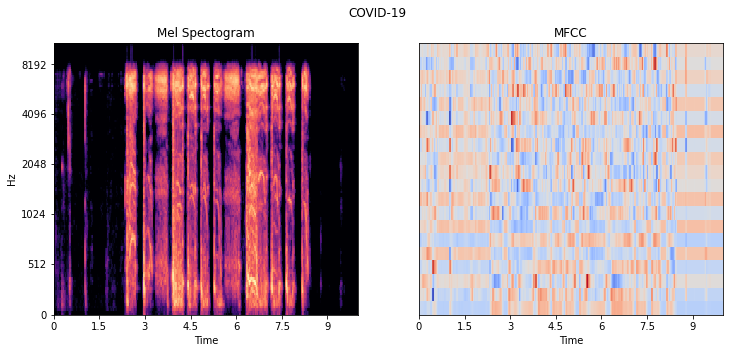

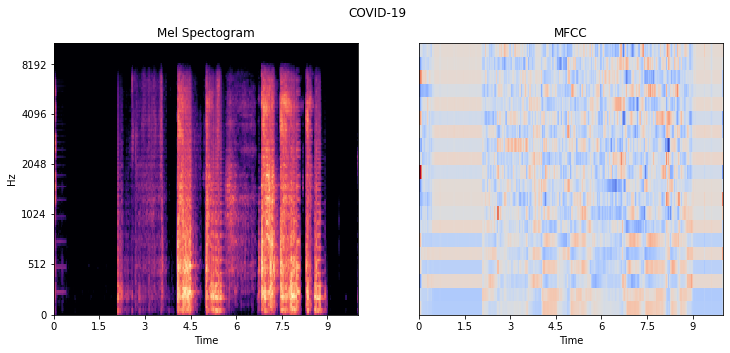

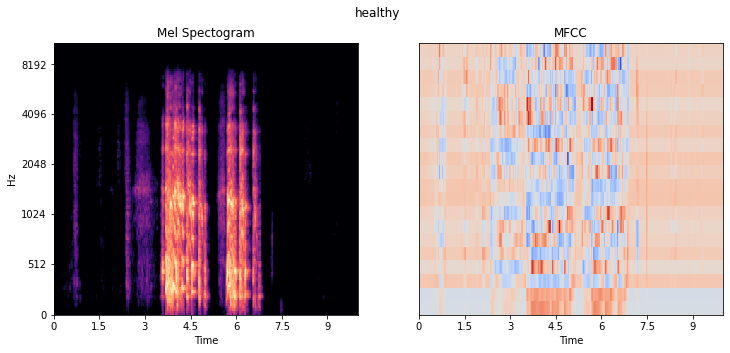

In [12]:
def get_mel_spectrogram(signal):
    sgram =librosa.stft(signal)

    sgram_mag, _= librosa.magphase(sgram)
    mel_scale_sgram = librosa.feature.melspectrogram(S = sgram_mag)

    mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref = np.min)

    return mel_sgram

def get_mfcc(signal, n_mfcc=20):
    """
        Return mfcc with x mfccs
    """
    mfcc = librosa.feature.mfcc(signal, n_mfcc=n_mfcc)
    mfcc = preprocessing.scale(mfcc, axis=1)
    return mfcc

# plot 3 mel spectograms to show that helper function works
for a in range(3):
    i = random.randint(0, len(train_signals))
    mel_sgram = get_mel_spectrogram(train_signals[i])
    mfcc = get_mfcc(train_signals[i])


    label = y_train[i]

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
    librosa.display.specshow(mel_sgram, x_axis='time', y_axis='mel', ax=ax1)
    librosa.display.specshow(mfcc, x_axis='time', ax=ax2)


    fig.suptitle(label)
    ax1.set_title('Mel Spectogram')
    ax2.set_title('MFCC')
    #plt.colorbar(format='%+2.0f dB', ax=ax1)
    plt.show()



In [13]:
train_mel_spectrograms = []
test_mel_spectrograms = []

train_mfccs = []
test_mfccs = []

for signal in train_signals:
    mel_spect = get_mel_spectrogram(signal)
    train_mel_spectrograms.append(mel_spect)
    mfcc = get_mfcc(signal)
    train_mfccs.append(mfcc)


for signal in test_signals:
    mel_spect = get_mel_spectrogram(signal)
    test_mel_spectrograms.append(mel_spect)
    mfcc = get_mfcc(signal)
    test_mfccs.append(mfcc)

train_mel_spectrograms = np.array(train_mel_spectrograms)
test_mel_spectrograms = np.array(test_mel_spectrograms)
train_mfccs = np.array(train_mfccs)
test_mfccs = np.array(test_mfccs)

# normalise (between 0 and 1)
train_mel_spectrograms = (train_mel_spectrograms - train_mel_spectrograms.min())/(train_mel_spectrograms.max() - train_mel_spectrograms.min())
test_mel_spectrograms = (test_mel_spectrograms - test_mel_spectrograms.min())/(test_mel_spectrograms.max() - test_mel_spectrograms.min())
train_mfccs = (train_mfccs - train_mfccs.min())/(train_mfccs.max() - train_mfccs.min())
test_mfccs = (test_mfccs - test_mfccs.min())/(test_mfccs.max() - test_mfccs.min())


In [14]:
#pre-process labels
def to_binary(label):
    if label == 'COVID-19':
        return 1
    else:
        return 0

y_train = np.array(list(map(to_binary, y_train)))
y_test = np.array(list(map(to_binary, y_test)))


In [15]:
train_mel_spectrograms = train_mel_spectrograms[...,np.newaxis]
test_mel_spectrograms = test_mel_spectrograms[..., np.newaxis]
train_mfccs = train_mfccs[...,np.newaxis]
test_mfccs = test_mfccs[..., np.newaxis]

In [16]:
train_mfccs.shape, train_mel_spectrograms.shape

((2000, 20, 431, 1), (2000, 128, 431, 1))

## Mel Spectogram 

### Defining model and training/testing data

In [17]:
X_train = train_mel_spectrograms
X_test = test_mel_spectrograms

In [18]:
def build_cnn(
    hidden_activation = 'relu',
    final_activation = 'sigmoid',
    filters = 32,
    n_hidden = 1,
    kernel_size = 3,
    dropout = False,
    dropout_p = 0.2,
    optimiser = 'Adam',
    kernel_initialiser = 'he_normal',
    learning_rate = 0.0001):
    
    model = keras.models.Sequential()

    # first layer:
    if hidden_activation == 'leaky_relu':
        model.add(keras.layers.Conv2D(filters=filters, kernel_size = (kernel_size,kernel_size), input_shape = (128,431,1), kernel_initializer=kernel_initialiser))
        keras.layers.LeakyReLU(alpha=0.2),
    elif hidden_activation == 'selu':
        model.add(keras.layers.Conv2D(filters=filters, kernel_size=(kernel_size, kernel_size), activation='selu', padding = 'same', input_shape=(128,431,1), kernel_initializer='lecun_normal'))
    else:
        model.add(keras.layers.Conv2D(filters=filters, kernel_size = (kernel_size,kernel_size), activation=hidden_activation, input_shape = (128,431,1), kernel_initializer=kernel_initialiser))

    model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))  # add maxpooling layer

    if dropout:
        model.add(keras.layers.Dropout(dropout_p))

    if n_hidden > 1:
        for layer in range(n_hidden - 1):
            if hidden_activation == 'leaky_relu':
                model.add(keras.layers.Conv2D(filters=filters, kernel_size = (kernel_size,kernel_size), padding = 'same', kernel_initializer=kernel_initialiser))
                keras.layers.LeakyReLU(alpha=0.2)
                model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))  # add maxpooling layer
            elif hidden_activation == 'selu':
                model.add(keras.layers.Conv2D(filters=filters, kernel_size = (kernel_size,kernel_size), activation='selu', padding = 'same', kernel_initializer='lecun_normal'))
                model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))  # add maxpooling layer
            else:
                model.add(keras.layers.Conv2D(filters=filters, kernel_size = (kernel_size,kernel_size), activation=hidden_activation, padding = 'same', kernel_initializer=kernel_initialiser))
                model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))  # add maxpooling layer
            
            if dropout:
                model.add(keras.layers.Dropout(dropout_p))


    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1, activation = final_activation))

    if optimiser == 'SGD':
        opt = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimiser == 'momentum':
        opt = keras.optimizers.SGD(learning_rate=learning_rate, momentum = 0.9)
    elif optimiser == 'Adam':
        opt = keras.optimizers.Adam(learning_rate = learning_rate)
    elif optimiser == 'Adamax':
        opt = keras.optimizers.Adamax(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
    elif optimiser == 'Adagrad':
        opt = keras.optimizers.Adagrad(learning_rate = learning_rate)

    model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ["AUC"])
    print(model.summary())
    return model

cnn = keras.wrappers.scikit_learn.KerasClassifier(build_cnn)

### Baseline model

In [52]:
# 3 hours + to run

param_dist= {
    'n_hidden' : [1, 2, 3, 4],
    'filters' : [16, 24, 32],
    'batch_size' : [16, 32],
    'kernel_size' : [3, 4, 5],
    'kernel_initialiser' : ['he_normal', 'lecun_normal', 'he_uniform'],
    'hidden_activation' : ['relu', 'elu', 'selu', 'sigmoid','hard_sigmoid'],
    'final_activation' : ['sigmoid','hard_sigmoid'],
    'optimiser' : ['momentum', 'Adam', 'Adamax'],
}


rnd_search_cv = model_selection.RandomizedSearchCV(cnn, param_dist, n_iter = 12, cv=5, scoring = ['roc_auc', 'recall'], refit = 'roc_auc',random_state = random_state, return_train_score = True)
rnd_search_cv.fit(X_train, y_train, epochs = 50)

Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_216 (Conv2D)          (None, 125, 428, 16)      272       
_________________________________________________________________
max_pooling2d_216 (MaxPoolin (None, 62, 214, 16)       0         
_________________________________________________________________
conv2d_217 (Conv2D)          (None, 62, 214, 16)       4112      
_________________________________________________________________
max_pooling2d_217 (MaxPoolin (None, 31, 107, 16)       0         
_________________________________________________________________
conv2d_218 (Conv2D)          (None, 31, 107, 16)       4112      
_________________________________________________________________
max_pooling2d_218 (MaxPoolin (None, 15, 53, 16)        0         
_________________________________________________________________
flatten_88 (Flatten)         (None, 12720)           

1600/1600 [==============================] - 2s 941us/sample - loss: 0.5080 - AUC: 0.8097
Epoch 20/50
1600/1600 [==============================] - 2s 940us/sample - loss: 0.4980 - AUC: 0.8164
Epoch 21/50
1600/1600 [==============================] - 2s 941us/sample - loss: 0.5073 - AUC: 0.8164
Epoch 22/50
1600/1600 [==============================] - 2s 940us/sample - loss: 0.4981 - AUC: 0.8259
Epoch 23/50
1600/1600 [==============================] - 2s 938us/sample - loss: 0.4820 - AUC: 0.8308
Epoch 24/50
1600/1600 [==============================] - 2s 940us/sample - loss: 0.4770 - AUC: 0.8330
Epoch 25/50
1600/1600 [==============================] - 2s 938us/sample - loss: 0.4613 - AUC: 0.8452
Epoch 26/50
1600/1600 [==============================] - 2s 939us/sample - loss: 0.5109 - AUC: 0.8240
Epoch 27/50
1600/1600 [==============================] - 2s 943us/sample - loss: 0.4607 - AUC: 0.8476
Epoch 28/50
1600/1600 [==============================] - 2s 941us/sample - loss: 0.4601 - AUC:

1600/1600 [==============================] - 4s 2ms/sample - loss: 1.3005 - AUC: 0.4919
Epoch 2/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7074 - AUC: 0.5238
Epoch 3/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7125 - AUC: 0.5425
Epoch 4/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7264 - AUC: 0.5183
Epoch 5/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7372 - AUC: 0.5469
Epoch 6/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7076 - AUC: 0.5623
Epoch 7/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7653 - AUC: 0.5344
Epoch 8/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.8206 - AUC: 0.5056
Epoch 9/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7116 - AUC: 0.5692
Epoch 10/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.8196 - AUC: 0.5244
Epoch 11/50
1600/160

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6621 - AUC: 0.6372
Epoch 25/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6989 - AUC: 0.6047
Epoch 26/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6983 - AUC: 0.6065
Epoch 27/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7189 - AUC: 0.6042
Epoch 28/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6754 - AUC: 0.6275
Epoch 29/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6548 - AUC: 0.6549
Epoch 30/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7240 - AUC: 0.5909
Epoch 31/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7070 - AUC: 0.6080
Epoch 32/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6665 - AUC: 0.6504
Epoch 33/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6849 - AUC: 0.6304
Epoch 34/50


Epoch 47/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7023 - AUC: 0.6042
Epoch 48/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6569 - AUC: 0.6493
Epoch 49/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7145 - AUC: 0.6093
Epoch 50/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6948 - AUC: 0.6110
Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_234 (Conv2D)          (None, 125, 428, 24)      408       
_________________________________________________________________
max_pooling2d_234 (MaxPoolin (None, 62, 214, 24)       0         
_________________________________________________________________
flatten_96 (Flatten)         (None, 318432)            0         
_________________________________________________________________
dense_96 (Dense)             (None, 1)           

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6983 - AUC: 0.4746
Epoch 28/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6978 - AUC: 0.4862
Epoch 29/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6970 - AUC: 0.5033
Epoch 30/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6971 - AUC: 0.4848
Epoch 31/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6979 - AUC: 0.5050
Epoch 32/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6991 - AUC: 0.4760
Epoch 33/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6979 - AUC: 0.4677
Epoch 34/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7035 - AUC: 0.4791
Epoch 35/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6978 - AUC: 0.5063
Epoch 36/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6994 - AUC: 0.4783
Epoch 37/50


1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6999 - AUC: 0.4804
Epoch 2/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6971 - AUC: 0.4731
Epoch 3/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6968 - AUC: 0.5114
Epoch 4/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6946 - AUC: 0.5214
Epoch 5/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6980 - AUC: 0.5025
Epoch 6/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7018 - AUC: 0.4843
Epoch 7/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6961 - AUC: 0.4855
Epoch 8/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6982 - AUC: 0.4973
Epoch 9/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6942 - AUC: 0.5129
Epoch 10/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6983 - AUC: 0.4861
Epoch 11/50
1600/160

1600/1600 [==============================] - 2s 942us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 41/50
1600/1600 [==============================] - 2s 942us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 42/50
1600/1600 [==============================] - 2s 941us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 43/50
1600/1600 [==============================] - 2s 941us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 44/50
1600/1600 [==============================] - 1s 937us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 45/50
1600/1600 [==============================] - 2s 938us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 46/50
1600/1600 [==============================] - 2s 941us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 47/50
1600/1600 [==============================] - 2s 941us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 48/50
1600/1600 [==============================] - 2s 939us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 49/50
1600/1600 [==============================] - 2s 940us/sample - loss: 7.5775 - AUC:

1600/1600 [==============================] - 2s 944us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 24/50
1600/1600 [==============================] - 2s 939us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 25/50
1600/1600 [==============================] - 2s 940us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 26/50
1600/1600 [==============================] - 2s 942us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 27/50
1600/1600 [==============================] - 2s 940us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 28/50
1600/1600 [==============================] - 2s 941us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 29/50
1600/1600 [==============================] - 2s 944us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 30/50
1600/1600 [==============================] - 2s 940us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 31/50
1600/1600 [==============================] - 2s 941us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 32/50
1600/1600 [==============================] - 2s 940us/sample - loss: 7.7800 - AUC:

1600/1600 [==============================] - 6s 4ms/sample - loss: 0.6930 - AUC: 0.5403
Epoch 2/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6740 - AUC: 0.6061
Epoch 3/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6545 - AUC: 0.6557
Epoch 4/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6389 - AUC: 0.6759
Epoch 5/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6228 - AUC: 0.7062
Epoch 6/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6056 - AUC: 0.7282
Epoch 7/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5950 - AUC: 0.7438
Epoch 8/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5802 - AUC: 0.7560
Epoch 9/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5666 - AUC: 0.7731
Epoch 10/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5537 - AUC: 0.7847
Epoch 11/50
1600/160

1600/1600 [==============================] - 4s 2ms/sample - loss: 0.3367 - AUC: 0.9294
Epoch 31/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.3259 - AUC: 0.9330
Epoch 32/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.3151 - AUC: 0.9390
Epoch 33/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.3015 - AUC: 0.9455
Epoch 34/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.2925 - AUC: 0.9502
Epoch 35/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.2845 - AUC: 0.9514
Epoch 36/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.2695 - AUC: 0.9587
Epoch 37/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.2631 - AUC: 0.9607
Epoch 38/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.2623 - AUC: 0.9663
Epoch 39/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.2386 - AUC: 0.9687
Epoch 40/50


1600/1600 [==============================] - 4s 2ms/sample - loss: 0.2130 - AUC: 0.9778
Epoch 46/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.2055 - AUC: 0.9803
Epoch 47/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.1977 - AUC: 0.9830
Epoch 48/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.1898 - AUC: 0.9832
Epoch 49/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.1768 - AUC: 0.9873
Epoch 50/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.1712 - AUC: 0.9886
Model: "sequential_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_276 (Conv2D)          (None, 126, 429, 24)      240       
_________________________________________________________________
max_pooling2d_276 (MaxPoolin (None, 63, 214, 24)       0         
__________________________________________________________

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.9118 - AUC: 0.6116
Epoch 31/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 1.1304 - AUC: 0.5747
Epoch 32/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.9455 - AUC: 0.6018
Epoch 33/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 1.0432 - AUC: 0.5860
Epoch 34/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.9353 - AUC: 0.6117
Epoch 35/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 1.9657 - AUC: 0.5585
Epoch 36/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.9905 - AUC: 0.5985
Epoch 37/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 1.2576 - AUC: 0.5911
Epoch 38/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.8151 - AUC: 0.6250
Epoch 39/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.9427 - AUC: 0.6057
Epoch 40/50


1600/1600 [==============================] - 4s 3ms/sample - loss: 1.6948 - AUC: 0.5004
Epoch 2/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 1.4254 - AUC: 0.4959
Epoch 3/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.9139 - AUC: 0.5439
Epoch 4/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 1.2231 - AUC: 0.5175
Epoch 5/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 1.4979 - AUC: 0.5069
Epoch 6/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 1.1505 - AUC: 0.5580
Epoch 7/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 1.1161 - AUC: 0.5441
Epoch 8/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 1.1519 - AUC: 0.5404
Epoch 9/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 1.3706 - AUC: 0.5503
Epoch 10/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.9831 - AUC: 0.5732
Epoch 11/50
1600/160

1600/1600 [==============================] - 4s 2ms/sample - loss: 0.3234 - AUC: 0.9409
Epoch 36/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.3162 - AUC: 0.9393
Epoch 37/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.3012 - AUC: 0.9484
Epoch 38/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.2936 - AUC: 0.9487
Epoch 39/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.2796 - AUC: 0.9573
Epoch 40/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.2686 - AUC: 0.9603
Epoch 41/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.2607 - AUC: 0.9620
Epoch 42/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.2486 - AUC: 0.9666
Epoch 43/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.2397 - AUC: 0.9700
Epoch 44/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.2288 - AUC: 0.9730
Epoch 45/50


1600/1600 [==============================] - 7s 4ms/sample - loss: 0.7083 - AUC: 0.5111
Epoch 2/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6734 - AUC: 0.6076
Epoch 3/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6451 - AUC: 0.6664
Epoch 4/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6186 - AUC: 0.7098
Epoch 5/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6079 - AUC: 0.7188
Epoch 6/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5829 - AUC: 0.7472
Epoch 7/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5706 - AUC: 0.7592
Epoch 8/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5544 - AUC: 0.7744
Epoch 9/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5364 - AUC: 0.7917
Epoch 10/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5221 - AUC: 0.8045
Epoch 11/50
1600/160

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2611 - AUC: 0.9787
Epoch 39/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2600 - AUC: 0.9773
Epoch 40/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2484 - AUC: 0.9817
Epoch 41/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2381 - AUC: 0.9853
Epoch 42/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2335 - AUC: 0.9852
Epoch 43/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2248 - AUC: 0.9872
Epoch 44/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2174 - AUC: 0.9887
Epoch 45/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2118 - AUC: 0.9890
Epoch 46/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2047 - AUC: 0.9906
Epoch 47/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.1984 - AUC: 0.9908
Epoch 48/50


1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7612 - AUC: 0.5336
Epoch 2/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6583 - AUC: 0.6395
Epoch 3/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6484 - AUC: 0.6594
Epoch 4/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6501 - AUC: 0.6701
Epoch 5/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6096 - AUC: 0.7213
Epoch 6/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5947 - AUC: 0.7393
Epoch 7/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5851 - AUC: 0.7499
Epoch 8/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5716 - AUC: 0.7702
Epoch 9/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5611 - AUC: 0.7815
Epoch 10/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5476 - AUC: 0.7975
Epoch 11/50
1600/160

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2398 - AUC: 0.9865
Epoch 42/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2329 - AUC: 0.9866
Epoch 43/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2240 - AUC: 0.9891
Epoch 44/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2148 - AUC: 0.9902
Epoch 45/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2094 - AUC: 0.9909
Epoch 46/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2022 - AUC: 0.9920
Epoch 47/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.1988 - AUC: 0.9917
Epoch 48/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.1876 - AUC: 0.9943
Epoch 49/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.1828 - AUC: 0.9946
Epoch 50/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.1771 - AUC: 0.9950
Model: "sequ

1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7872 - AUC: 0.5229
Epoch 2/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6835 - AUC: 0.5782
Epoch 3/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6598 - AUC: 0.6450
Epoch 4/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6576 - AUC: 0.6409
Epoch 5/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6411 - AUC: 0.6725
Epoch 6/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6189 - AUC: 0.7207
Epoch 7/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6069 - AUC: 0.7369
Epoch 8/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5942 - AUC: 0.7539
Epoch 9/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5872 - AUC: 0.7609
Epoch 10/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5735 - AUC: 0.7808
Epoch 11/50
1600/160

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3099 - AUC: 0.9618
Epoch 42/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3004 - AUC: 0.9655
Epoch 43/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2995 - AUC: 0.9624
Epoch 44/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2861 - AUC: 0.9729
Epoch 45/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2776 - AUC: 0.9740
Epoch 46/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2716 - AUC: 0.9740
Epoch 47/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2656 - AUC: 0.9766
Epoch 48/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2632 - AUC: 0.9774
Epoch 49/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2516 - AUC: 0.9813
Epoch 50/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2461 - AUC: 0.9814
Model: "sequ

1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6944 - AUC: 0.4989
Epoch 2/50
1600/1600 [==============================] - 2s 943us/sample - loss: 0.6943 - AUC: 0.4853
Epoch 3/50
1600/1600 [==============================] - 2s 945us/sample - loss: 0.6941 - AUC: 0.4924
Epoch 4/50
1600/1600 [==============================] - 2s 943us/sample - loss: 0.6959 - AUC: 0.4770
Epoch 5/50
1600/1600 [==============================] - 2s 947us/sample - loss: 0.6957 - AUC: 0.4796
Epoch 6/50
1600/1600 [==============================] - 2s 944us/sample - loss: 0.6940 - AUC: 0.5008
Epoch 7/50
1600/1600 [==============================] - 2s 943us/sample - loss: 0.6949 - AUC: 0.5027
Epoch 8/50
1600/1600 [==============================] - 2s 946us/sample - loss: 0.6957 - AUC: 0.4803
Epoch 9/50
1600/1600 [==============================] - 2s 943us/sample - loss: 0.6931 - AUC: 0.5117
Epoch 10/50
1600/1600 [==============================] - 2s 945us/sample - loss: 0.6961 - AUC: 0.4928
Ep

Epoch 15/50
1600/1600 [==============================] - 2s 954us/sample - loss: 0.6940 - AUC: 0.5092
Epoch 16/50
1600/1600 [==============================] - 2s 955us/sample - loss: 0.6961 - AUC: 0.4660
Epoch 17/50
1600/1600 [==============================] - 2s 954us/sample - loss: 0.6947 - AUC: 0.4947
Epoch 18/50
1600/1600 [==============================] - 2s 955us/sample - loss: 0.6947 - AUC: 0.4694
Epoch 19/50
1600/1600 [==============================] - 2s 954us/sample - loss: 0.6981 - AUC: 0.4839
Epoch 20/50
1600/1600 [==============================] - 2s 956us/sample - loss: 0.6940 - AUC: 0.5017
Epoch 21/50
1600/1600 [==============================] - 2s 955us/sample - loss: 0.6952 - AUC: 0.4908
Epoch 22/50
1600/1600 [==============================] - 2s 953us/sample - loss: 0.6950 - AUC: 0.5005
Epoch 23/50
1600/1600 [==============================] - 2s 955us/sample - loss: 0.6947 - AUC: 0.4785
Epoch 24/50
1600/1600 [==============================] - 2s 954us/sample - loss: 0

1600/1600 [==============================] - 2s 952us/sample - loss: 0.6943 - AUC: 0.4934
Epoch 42/50
1600/1600 [==============================] - 2s 955us/sample - loss: 0.6944 - AUC: 0.4847
Epoch 43/50
1600/1600 [==============================] - 2s 955us/sample - loss: 0.6929 - AUC: 0.5186
Epoch 44/50
1600/1600 [==============================] - 2s 956us/sample - loss: 0.6959 - AUC: 0.4989
Epoch 45/50
1600/1600 [==============================] - 2s 956us/sample - loss: 0.6955 - AUC: 0.4819s - loss: 0.6951 
Epoch 46/50
1600/1600 [==============================] - 2s 955us/sample - loss: 0.6951 - AUC: 0.4894
Epoch 47/50
1600/1600 [==============================] - 2s 956us/sample - loss: 0.6948 - AUC: 0.5129
Epoch 48/50
1600/1600 [==============================] - 2s 952us/sample - loss: 0.6938 - AUC: 0.5066
Epoch 49/50
1600/1600 [==============================] - 2s 952us/sample - loss: 0.6945 - AUC: 0.5120
Epoch 50/50
1600/1600 [==============================] - 2s 954us/sample - lo

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6920 - AUC: 0.5371
Epoch 2/50
1600/1600 [==============================] - 1s 808us/sample - loss: 0.6893 - AUC: 0.5536
Epoch 3/50
1600/1600 [==============================] - 1s 811us/sample - loss: 0.6845 - AUC: 0.6032
Epoch 4/50
1600/1600 [==============================] - 1s 809us/sample - loss: 0.6822 - AUC: 0.6132
Epoch 5/50
1600/1600 [==============================] - 1s 810us/sample - loss: 0.6801 - AUC: 0.6208
Epoch 6/50
1600/1600 [==============================] - 1s 807us/sample - loss: 0.6761 - AUC: 0.6182
Epoch 7/50
1600/1600 [==============================] - 1s 810us/sample - loss: 0.6736 - AUC: 0.6406
Epoch 8/50
1600/1600 [==============================] - 1s 810us/sample - loss: 0.6700 - AUC: 0.6675
Epoch 9/50
1600/1600 [==============================] - 1s 810us/sample - loss: 0.6673 - AUC: 0.6624
Epoch 10/50
1600/1600 [==============================] - 1s 806us/sample - loss: 0.6636 - AUC: 0.6680
Ep

1600/1600 [==============================] - 1s 810us/sample - loss: 0.6167 - AUC: 0.7204
Epoch 21/50
1600/1600 [==============================] - 1s 807us/sample - loss: 0.6179 - AUC: 0.7160
Epoch 22/50
1600/1600 [==============================] - 1s 810us/sample - loss: 0.6119 - AUC: 0.7287
Epoch 23/50
1600/1600 [==============================] - 1s 811us/sample - loss: 0.6091 - AUC: 0.7295
Epoch 24/50
1600/1600 [==============================] - 1s 808us/sample - loss: 0.6105 - AUC: 0.7266
Epoch 25/50
1600/1600 [==============================] - 1s 809us/sample - loss: 0.6076 - AUC: 0.7312
Epoch 26/50
1600/1600 [==============================] - 1s 812us/sample - loss: 0.6002 - AUC: 0.7435
Epoch 27/50
1600/1600 [==============================] - 1s 811us/sample - loss: 0.6040 - AUC: 0.7293
Epoch 28/50
1600/1600 [==============================] - 1s 811us/sample - loss: 0.5994 - AUC: 0.7386
Epoch 29/50
1600/1600 [==============================] - 1s 811us/sample - loss: 0.6126 - AUC:

1600/1600 [==============================] - 1s 813us/sample - loss: 0.5852 - AUC: 0.7519
Epoch 40/50
1600/1600 [==============================] - 1s 815us/sample - loss: 0.5886 - AUC: 0.7496
Epoch 41/50
1600/1600 [==============================] - 1s 815us/sample - loss: 0.5862 - AUC: 0.7500
Epoch 42/50
1600/1600 [==============================] - 1s 814us/sample - loss: 0.5792 - AUC: 0.7593
Epoch 43/50
1600/1600 [==============================] - 1s 814us/sample - loss: 0.5814 - AUC: 0.7559
Epoch 44/50
1600/1600 [==============================] - 1s 812us/sample - loss: 0.5802 - AUC: 0.7608
Epoch 45/50
1600/1600 [==============================] - 1s 815us/sample - loss: 0.5798 - AUC: 0.7587
Epoch 46/50
1600/1600 [==============================] - 1s 813us/sample - loss: 0.5718 - AUC: 0.7673
Epoch 47/50
1600/1600 [==============================] - 1s 812us/sample - loss: 0.5698 - AUC: 0.7662
Epoch 48/50
1600/1600 [==============================] - 1s 813us/sample - loss: 0.5717 - AUC:

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6966 - AUC: 0.5295
Epoch 2/50
1600/1600 [==============================] - 1s 829us/sample - loss: 0.6915 - AUC: 0.5293
Epoch 3/50
1600/1600 [==============================] - 1s 825us/sample - loss: 0.6866 - AUC: 0.5793
Epoch 4/50
1600/1600 [==============================] - 1s 828us/sample - loss: 0.6830 - AUC: 0.5959
Epoch 5/50
1600/1600 [==============================] - 1s 826us/sample - loss: 0.6796 - AUC: 0.6116
Epoch 6/50
1600/1600 [==============================] - 1s 827us/sample - loss: 0.6785 - AUC: 0.6065
Epoch 7/50
1600/1600 [==============================] - 1s 827us/sample - loss: 0.6769 - AUC: 0.6133
Epoch 8/50
1600/1600 [==============================] - 1s 830us/sample - loss: 0.6730 - AUC: 0.6231
Epoch 9/50
1600/1600 [==============================] - 1s 825us/sample - loss: 0.6690 - AUC: 0.6342
Epoch 10/50
1600/1600 [==============================] - 1s 827us/sample - loss: 0.6693 - AUC: 0.6273
Ep

1600/1600 [==============================] - 1s 848us/sample - loss: 0.6653 - AUC: 0.6289
Epoch 44/50
1600/1600 [==============================] - 1s 849us/sample - loss: 0.7159 - AUC: 0.5834
Epoch 45/50
1600/1600 [==============================] - 1s 848us/sample - loss: 0.6824 - AUC: 0.6038
Epoch 46/50
1600/1600 [==============================] - 1s 848us/sample - loss: 0.6611 - AUC: 0.6396
Epoch 47/50
1600/1600 [==============================] - 1s 846us/sample - loss: 0.6666 - AUC: 0.6234
Epoch 48/50
1600/1600 [==============================] - 1s 851us/sample - loss: 0.7446 - AUC: 0.5791
Epoch 49/50
1600/1600 [==============================] - 1s 848us/sample - loss: 0.6708 - AUC: 0.6227
Epoch 50/50
1600/1600 [==============================] - 1s 843us/sample - loss: 0.6732 - AUC: 0.6216
Model: "sequential_145"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_348 (Conv2D)          (None, 126,

1600/1600 [==============================] - 1s 848us/sample - loss: 0.6909 - AUC: 0.5965
Epoch 27/50
1600/1600 [==============================] - 1s 848us/sample - loss: 0.6799 - AUC: 0.6005
Epoch 28/50
1600/1600 [==============================] - 1s 849us/sample - loss: 0.7041 - AUC: 0.5830
Epoch 29/50
1600/1600 [==============================] - 1s 851us/sample - loss: 0.7185 - AUC: 0.5749
Epoch 30/50
1600/1600 [==============================] - 1s 846us/sample - loss: 0.7222 - AUC: 0.5830
Epoch 31/50
1600/1600 [==============================] - 1s 851us/sample - loss: 0.7675 - AUC: 0.5557
Epoch 32/50
1600/1600 [==============================] - 1s 844us/sample - loss: 0.7260 - AUC: 0.5786
Epoch 33/50
1600/1600 [==============================] - 1s 850us/sample - loss: 0.6907 - AUC: 0.6053
Epoch 34/50
1600/1600 [==============================] - 1s 847us/sample - loss: 0.8570 - AUC: 0.5389
Epoch 35/50
1600/1600 [==============================] - 1s 850us/sample - loss: 0.6994 - AUC:

RandomizedSearchCV(cv=5,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000012C2D46A208>,
                   n_iter=12,
                   param_distributions={'batch_size': [16, 32],
                                        'filters': [16, 24, 32],
                                        'final_activation': ['sigmoid',
                                                             'hard_sigmoid'],
                                        'hidden_activation': ['relu', 'elu',
                                                              'selu', 'sigmoid',
                                                              'hard_sigmoid'],
                                        'kernel_initialiser': ['he_normal',
                                                               'lecun_normal',
                                                               'he_uniform'],
                                        'kernel_size': [3, 4, 5],
       

In [53]:
rnd_search_cv.best_params_

{'optimiser': 'Adamax',
 'n_hidden': 2,
 'kernel_size': 4,
 'kernel_initialiser': 'he_normal',
 'hidden_activation': 'elu',
 'final_activation': 'sigmoid',
 'filters': 32,
 'batch_size': 16}

In [20]:
# 3 hours + to run

param_dist= {
    'n_hidden' : [2],
    'filters' : [32],
    'batch_size' : [16],
    'kernel_size' : [4],
    'kernel_initialiser' : ['he_normal'],
    'hidden_activation' : ['elu'],
    'final_activation' : ['sigmoid'],
    'optimiser' : ['Adamax']
}


rnd_search_cv = model_selection.RandomizedSearchCV(cnn, param_dist, n_iter = 1, cv=5, scoring = ['roc_auc', 'recall'], refit = 'roc_auc', random_state = random_state, return_train_score = True)
rnd_search_cv.fit(X_train, y_train, epochs = 50)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 125, 428, 32)      544       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 214, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 214, 32)       16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 107, 32)       0         
_________________________________________________________________
flatten (Flatten)            (None, 106144)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 106145    
Total params: 123,105
Trainable params: 123,105
Non-trainable params: 0
__________________________________________________

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3329 - AUC: 0.9556
Epoch 30/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3219 - AUC: 0.9594
Epoch 31/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3118 - AUC: 0.9634
Epoch 32/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3035 - AUC: 0.9681
Epoch 33/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2950 - AUC: 0.9687
Epoch 34/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2852 - AUC: 0.9727
Epoch 35/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2760 - AUC: 0.9754
Epoch 36/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2712 - AUC: 0.9761
Epoch 37/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2572 - AUC: 0.9811
Epoch 38/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2511 - AUC: 0.9812
Epoch 39/50


2000/2000 [==============================] - 3s 1ms/sample - loss: 0.5579 - AUC: 0.7821
Epoch 8/50
2000/2000 [==============================] - 3s 1ms/sample - loss: 0.5412 - AUC: 0.8022
Epoch 9/50
2000/2000 [==============================] - 3s 1ms/sample - loss: 0.5286 - AUC: 0.8124
Epoch 10/50
2000/2000 [==============================] - 3s 1ms/sample - loss: 0.5153 - AUC: 0.8283
Epoch 11/50
2000/2000 [==============================] - 3s 1ms/sample - loss: 0.5057 - AUC: 0.8362
Epoch 12/50
2000/2000 [==============================] - 3s 1ms/sample - loss: 0.4919 - AUC: 0.8466
Epoch 13/50
2000/2000 [==============================] - 3s 1ms/sample - loss: 0.4764 - AUC: 0.8612
Epoch 14/50
2000/2000 [==============================] - 3s 1ms/sample - loss: 0.4675 - AUC: 0.8679
Epoch 15/50
2000/2000 [==============================] - 3s 1ms/sample - loss: 0.4527 - AUC: 0.8807
Epoch 16/50
2000/2000 [==============================] - 3s 1ms/sample - loss: 0.4422 - AUC: 0.8886
Epoch 17/50
20

RandomizedSearchCV(cv=5,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001968538C1C8>,
                   n_iter=1,
                   param_distributions={'batch_size': [16], 'filters': [32],
                                        'final_activation': ['sigmoid'],
                                        'hidden_activation': ['elu'],
                                        'kernel_initialiser': ['he_normal'],
                                        'kernel_size': [4], 'n_hidden': [2],
                                        'optimiser': ['Adamax']},
                   random_state=23, refit='roc_auc', return_train_score=True,
                   scoring=['roc_auc', 'recall'])

In [22]:
rnd_search_cv.cv_results_

{'mean_fit_time': array([111.67390542]),
 'std_fit_time': array([0.98717281]),
 'mean_score_time': array([0.57665682]),
 'std_score_time': array([0.01027122]),
 'param_optimiser': masked_array(data=['Adamax'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_hidden': masked_array(data=[2],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_kernel_size': masked_array(data=[4],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_kernel_initialiser': masked_array(data=['he_normal'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_hidden_activation': masked_array(data=['elu'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_final_activation': masked_array(data=['sigmoid'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_filters': masked_array(data=[32],
      

### Fine tuning layers and kernels

In [19]:
# 3 hours + to run

param_dist= {
    'n_hidden' : [1, 2, 3, 4],
    'filters' : [16, 24, 32],
    'batch_size' : [16],
    'kernel_size' : [3, 4, 5],
    'kernel_initialiser' : ['he_normal'],
    'hidden_activation' : ['elu'],
    'final_activation' : ['sigmoid'],
    'optimiser' : ['Adamax'],
}


rnd_search_cv_2 = model_selection.RandomizedSearchCV(cnn, param_dist, n_iter = 1, cv=5, scoring = ['roc_auc', 'recall'], refit = 'roc_auc', random_state = random_state, return_train_score = True)
rnd_search_cv_2.fit(X_train, y_train, epochs = 50)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 429, 24)      240       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 214, 24)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 214, 24)       5208      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 107, 24)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 107, 24)       5208      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 53, 24)        0         
_________________________________________________________________
flatten (Flatten)            (None, 19080)             0

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5669 - AUC: 0.7771
Epoch 22/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5589 - AUC: 0.7892
Epoch 23/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5588 - AUC: 0.7860
Epoch 24/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5558 - AUC: 0.7886
Epoch 25/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5475 - AUC: 0.7971
Epoch 26/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5436 - AUC: 0.8025
Epoch 27/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5447 - AUC: 0.7962
Epoch 28/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5353 - AUC: 0.8089
Epoch 29/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5306 - AUC: 0.8122
Epoch 30/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5258 - AUC: 0.8165
Epoch 31/50


1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7094 - AUC: 0.5434
Epoch 2/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6696 - AUC: 0.6161
Epoch 3/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6428 - AUC: 0.6721
Epoch 4/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6239 - AUC: 0.7075
Epoch 5/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6133 - AUC: 0.7215
Epoch 6/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5917 - AUC: 0.7516
Epoch 7/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5817 - AUC: 0.7619
Epoch 8/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5677 - AUC: 0.7807
Epoch 9/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5504 - AUC: 0.8068
Epoch 10/50
1600/1600 [==============================] - ETA: 0s - loss: 0.5398 - AUC: 0.809 - 2s 1ms/sample - loss: 0.5

Epoch 21/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4331 - AUC: 0.9006
Epoch 22/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4225 - AUC: 0.9069
Epoch 23/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4127 - AUC: 0.9099
Epoch 24/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4002 - AUC: 0.9212
Epoch 25/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3884 - AUC: 0.9266
Epoch 26/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3795 - AUC: 0.9303
Epoch 27/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3670 - AUC: 0.9392
Epoch 28/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3538 - AUC: 0.9444
Epoch 29/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3441 - AUC: 0.9505
Epoch 30/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3341 - AUC: 0.9545


1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7369 - AUC: 0.5330
Epoch 2/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6875 - AUC: 0.5881
Epoch 3/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6688 - AUC: 0.6266
Epoch 4/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6588 - AUC: 0.6410
Epoch 5/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6380 - AUC: 0.6688
Epoch 6/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6289 - AUC: 0.6902
Epoch 7/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6246 - AUC: 0.6957
Epoch 8/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5996 - AUC: 0.7353
Epoch 9/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5936 - AUC: 0.7397
Epoch 10/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5771 - AUC: 0.7660
Epoch 11/50
1600/160

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3903 - AUC: 0.9138
Epoch 36/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3832 - AUC: 0.9180
Epoch 37/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3780 - AUC: 0.9209
Epoch 38/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3750 - AUC: 0.9211
Epoch 39/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3621 - AUC: 0.9289
Epoch 40/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3617 - AUC: 0.9273
Epoch 41/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3542 - AUC: 0.9325
Epoch 42/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3497 - AUC: 0.9341
Epoch 43/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3425 - AUC: 0.9372
Epoch 44/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3342 - AUC: 0.9414
Epoch 45/50


1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6949 - AUC: 0.5526
Epoch 2/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6675 - AUC: 0.6157
Epoch 3/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6515 - AUC: 0.6563
Epoch 4/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6419 - AUC: 0.6756
Epoch 5/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6340 - AUC: 0.6868
Epoch 6/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6254 - AUC: 0.7017
Epoch 7/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6151 - AUC: 0.7205
Epoch 8/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6092 - AUC: 0.7270
Epoch 9/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5981 - AUC: 0.7462
Epoch 10/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5924 - AUC: 0.7507
Epoch 11/50
1600/160

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2454 - AUC: 0.9810
Epoch 39/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2358 - AUC: 0.9835
Epoch 40/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2245 - AUC: 0.9859
Epoch 41/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2184 - AUC: 0.9869
Epoch 42/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2084 - AUC: 0.9897
Epoch 43/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2014 - AUC: 0.9891
Epoch 44/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.1931 - AUC: 0.9914
Epoch 45/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.1892 - AUC: 0.9915
Epoch 46/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.1781 - AUC: 0.9937
Epoch 47/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.1745 - AUC: 0.9939
Epoch 48/50


1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7032 - AUC: 0.6090
Epoch 2/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6651 - AUC: 0.6443
Epoch 3/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6178 - AUC: 0.7054
Epoch 4/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5946 - AUC: 0.7417
Epoch 5/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5825 - AUC: 0.7575
Epoch 6/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5636 - AUC: 0.7808
Epoch 7/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5489 - AUC: 0.7949
Epoch 8/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5381 - AUC: 0.8065
Epoch 9/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5257 - AUC: 0.8177
Epoch 10/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5105 - AUC: 0.8366
Epoch 11/50
1600/160

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2263 - AUC: 0.9849
Epoch 41/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2157 - AUC: 0.9871
Epoch 42/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2110 - AUC: 0.9876
Epoch 43/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2019 - AUC: 0.9893
Epoch 44/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.1914 - AUC: 0.9917
Epoch 45/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.1837 - AUC: 0.9925
Epoch 46/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.1784 - AUC: 0.9934
Epoch 47/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.1694 - AUC: 0.9940
Epoch 48/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.1641 - AUC: 0.9953
Epoch 49/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.1576 - AUC: 0.9960
Epoch 50/50


1600/1600 [==============================] - 1s 928us/sample - loss: 0.4443 - AUC: 0.8767
Epoch 24/50
1600/1600 [==============================] - 1s 928us/sample - loss: 0.4843 - AUC: 0.8386
Epoch 25/50
1600/1600 [==============================] - 1s 926us/sample - loss: 0.4592 - AUC: 0.8631
Epoch 26/50
1600/1600 [==============================] - 1s 931us/sample - loss: 0.4817 - AUC: 0.8422
Epoch 27/50
1600/1600 [==============================] - 1s 928us/sample - loss: 0.4192 - AUC: 0.8936
Epoch 28/50
1600/1600 [==============================] - 1s 928us/sample - loss: 0.4349 - AUC: 0.8792
Epoch 29/50
1600/1600 [==============================] - 1s 928us/sample - loss: 0.3925 - AUC: 0.9166
Epoch 30/50
1600/1600 [==============================] - 1s 928us/sample - loss: 0.4121 - AUC: 0.8989
Epoch 31/50
1600/1600 [==============================] - 1s 927us/sample - loss: 0.3928 - AUC: 0.9129
Epoch 32/50
1600/1600 [==============================] - 1s 927us/sample - loss: 0.3808 - AUC:

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7116 - AUC: 0.5400
Epoch 2/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6701 - AUC: 0.6138
Epoch 3/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6637 - AUC: 0.6317
Epoch 4/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6671 - AUC: 0.6222
Epoch 5/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6449 - AUC: 0.6679
Epoch 6/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6387 - AUC: 0.6787
Epoch 7/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6278 - AUC: 0.6980
Epoch 8/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6238 - AUC: 0.7076
Epoch 9/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6163 - AUC: 0.7187
Epoch 10/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6100 - AUC: 0.7255
Epoch 11/50
1600/160

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4771 - AUC: 0.8549 1
Epoch 36/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4726 - AUC: 0.8580
Epoch 37/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4676 - AUC: 0.8616
Epoch 38/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4577 - AUC: 0.8693
Epoch 39/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4569 - AUC: 0.8679
Epoch 40/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4498 - AUC: 0.8761
Epoch 41/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4435 - AUC: 0.8794
Epoch 42/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4415 - AUC: 0.8811
Epoch 43/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4346 - AUC: 0.8859
Epoch 44/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4307 - AUC: 0.8872
Epoch 45/5

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7109 - AUC: 0.5233
Epoch 2/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6745 - AUC: 0.6124
Epoch 3/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6613 - AUC: 0.6363
Epoch 4/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6508 - AUC: 0.6620
Epoch 5/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6432 - AUC: 0.6765
Epoch 6/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6406 - AUC: 0.6787
Epoch 7/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6281 - AUC: 0.7041
Epoch 8/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6262 - AUC: 0.7030
Epoch 9/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6135 - AUC: 0.7234
Epoch 10/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6097 - AUC: 0.7296
Epoch 11/50
1600/160

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4794 - AUC: 0.8447
Epoch 25/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4420 - AUC: 0.8774
Epoch 26/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4247 - AUC: 0.8904
Epoch 27/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4277 - AUC: 0.8884
Epoch 28/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4222 - AUC: 0.8912
Epoch 29/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4337 - AUC: 0.8780
Epoch 30/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4067 - AUC: 0.9037
Epoch 31/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4129 - AUC: 0.8966
Epoch 32/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3963 - AUC: 0.9108
Epoch 33/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4252 - AUC: 0.8839
Epoch 34/50


Epoch 47/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3300 - AUC: 0.9447
Epoch 48/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3175 - AUC: 0.9521
Epoch 49/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3091 - AUC: 0.9582
Epoch 50/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3266 - AUC: 0.9446
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 125, 428, 32)      544       
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 62, 214, 32)       0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 424576)            0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)           

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3823 - AUC: 0.9097
Epoch 33/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3390 - AUC: 0.9427
Epoch 34/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3323 - AUC: 0.9467
Epoch 35/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3231 - AUC: 0.9563
Epoch 36/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3153 - AUC: 0.9599
Epoch 37/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3352 - AUC: 0.9381
Epoch 38/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3188 - AUC: 0.9520
Epoch 39/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3018 - AUC: 0.9645
Epoch 40/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3018 - AUC: 0.9609
Epoch 41/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3081 - AUC: 0.9555
Epoch 42/50


1600/1600 [==============================] - 2s 1ms/sample - loss: 0.8223 - AUC: 0.5196
Epoch 2/50
1600/1600 [==============================] - 1s 735us/sample - loss: 0.6675 - AUC: 0.6290
Epoch 3/50
1600/1600 [==============================] - 1s 733us/sample - loss: 0.6593 - AUC: 0.6435
Epoch 4/50
1600/1600 [==============================] - 1s 735us/sample - loss: 0.6605 - AUC: 0.6527
Epoch 5/50
1600/1600 [==============================] - 1s 734us/sample - loss: 0.6485 - AUC: 0.6789
Epoch 6/50
1600/1600 [==============================] - 1s 733us/sample - loss: 0.6429 - AUC: 0.6794
Epoch 7/50
1600/1600 [==============================] - 1s 734us/sample - loss: 0.6493 - AUC: 0.6780
Epoch 8/50
1600/1600 [==============================] - 1s 735us/sample - loss: 0.6537 - AUC: 0.6881
Epoch 9/50
1600/1600 [==============================] - 1s 738us/sample - loss: 0.6164 - AUC: 0.7138
Epoch 10/50
1600/1600 [==============================] - 1s 737us/sample - loss: 0.5840 - AUC: 0.7535
Ep

1600/1600 [==============================] - 1s 738us/sample - loss: 0.3916 - AUC: 0.9201
Epoch 44/50
1600/1600 [==============================] - 1s 739us/sample - loss: 0.4127 - AUC: 0.8966
Epoch 45/50
1600/1600 [==============================] - 1s 739us/sample - loss: 0.3742 - AUC: 0.9352
Epoch 46/50
1600/1600 [==============================] - 1s 738us/sample - loss: 0.3719 - AUC: 0.9347
Epoch 47/50
1600/1600 [==============================] - 1s 738us/sample - loss: 0.3684 - AUC: 0.9392
Epoch 48/50
1600/1600 [==============================] - 1s 737us/sample - loss: 0.3609 - AUC: 0.9408
Epoch 49/50
1600/1600 [==============================] - 1s 738us/sample - loss: 0.3662 - AUC: 0.9333
Epoch 50/50
1600/1600 [==============================] - 1s 737us/sample - loss: 0.3550 - AUC: 0.9439
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_79 (Conv2D)           (None, 124, 

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4379 - AUC: 0.8870
Epoch 24/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4251 - AUC: 0.8995
Epoch 25/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4136 - AUC: 0.9075
Epoch 26/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4090 - AUC: 0.9086
Epoch 27/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3977 - AUC: 0.9111
Epoch 28/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3912 - AUC: 0.9210
Epoch 29/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3785 - AUC: 0.9292
Epoch 30/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3692 - AUC: 0.9314
Epoch 31/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3593 - AUC: 0.9385
Epoch 32/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3477 - AUC: 0.9431
Epoch 33/50


1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7263 - AUC: 0.5208
Epoch 2/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6606 - AUC: 0.6385
Epoch 3/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6567 - AUC: 0.6429
Epoch 4/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6398 - AUC: 0.6732
Epoch 5/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6145 - AUC: 0.7195
Epoch 6/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6020 - AUC: 0.7386
Epoch 7/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5902 - AUC: 0.7517
Epoch 8/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5851 - AUC: 0.7572
Epoch 9/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5780 - AUC: 0.7625
Epoch 10/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5647 - AUC: 0.7793
Epoch 11/50
1600/160

1600/1600 [==============================] - 1s 736us/sample - loss: 0.4281 - AUC: 0.8838
Epoch 45/50
1600/1600 [==============================] - 1s 736us/sample - loss: 0.4157 - AUC: 0.8996
Epoch 46/50
1600/1600 [==============================] - 1s 734us/sample - loss: 0.3941 - AUC: 0.9213
Epoch 47/50
1600/1600 [==============================] - 1s 736us/sample - loss: 0.3962 - AUC: 0.9110
Epoch 48/50
1600/1600 [==============================] - 1s 736us/sample - loss: 0.3976 - AUC: 0.9102
Epoch 49/50
1600/1600 [==============================] - 1s 735us/sample - loss: 0.4043 - AUC: 0.9075
Epoch 50/50
1600/1600 [==============================] - 1s 736us/sample - loss: 0.4042 - AUC: 0.9031
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 125, 428, 16)      272       
_________________________________________________________________
max_pooling

1600/1600 [==============================] - 1s 745us/sample - loss: 0.5108 - AUC: 0.8214
Epoch 28/50
1600/1600 [==============================] - 1s 746us/sample - loss: 0.5146 - AUC: 0.8185
Epoch 29/50
1600/1600 [==============================] - 1s 746us/sample - loss: 0.4845 - AUC: 0.8465
Epoch 30/50
1600/1600 [==============================] - 1s 745us/sample - loss: 0.4700 - AUC: 0.8639
Epoch 31/50
1600/1600 [==============================] - 1s 741us/sample - loss: 0.5008 - AUC: 0.8286
Epoch 32/50
1600/1600 [==============================] - 1s 739us/sample - loss: 0.4820 - AUC: 0.8466
Epoch 33/50
1600/1600 [==============================] - 1s 740us/sample - loss: 0.4904 - AUC: 0.8337
Epoch 34/50
1600/1600 [==============================] - 1s 741us/sample - loss: 0.4838 - AUC: 0.8398
Epoch 35/50
1600/1600 [==============================] - 1s 741us/sample - loss: 0.4538 - AUC: 0.8725
Epoch 36/50
1600/1600 [==============================] - 1s 741us/sample - loss: 0.4641 - AUC:

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7089 - AUC: 0.5588
Epoch 2/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6682 - AUC: 0.6245
Epoch 3/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6534 - AUC: 0.6492
Epoch 4/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6485 - AUC: 0.6615
Epoch 5/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6259 - AUC: 0.7059
Epoch 6/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6117 - AUC: 0.7277
Epoch 7/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6039 - AUC: 0.7398
Epoch 8/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5980 - AUC: 0.7434
Epoch 9/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5858 - AUC: 0.7605
Epoch 10/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5751 - AUC: 0.7703
Epoch 11/50
1600/160

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4014 - AUC: 0.9068
Epoch 36/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3980 - AUC: 0.9090
Epoch 37/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3883 - AUC: 0.9153 0s - loss: 0.3871 - AUC: 0.91
Epoch 38/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3787 - AUC: 0.9217
Epoch 39/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3718 - AUC: 0.9261
Epoch 40/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3659 - AUC: 0.9263
Epoch 41/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3579 - AUC: 0.9314
Epoch 42/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3488 - AUC: 0.9374
Epoch 43/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3464 - AUC: 0.9341
Epoch 44/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7174 - AUC: 0.5209
Epoch 2/50
1600/1600 [==============================] - 1s 828us/sample - loss: 0.6863 - AUC: 0.5872
Epoch 3/50
1600/1600 [==============================] - 1s 828us/sample - loss: 0.6582 - AUC: 0.6384
Epoch 4/50
1600/1600 [==============================] - 1s 828us/sample - loss: 0.6461 - AUC: 0.6762
Epoch 5/50
1600/1600 [==============================] - 1s 826us/sample - loss: 0.6351 - AUC: 0.6870
Epoch 6/50
1600/1600 [==============================] - 1s 830us/sample - loss: 0.6377 - AUC: 0.6819
Epoch 7/50
1600/1600 [==============================] - 1s 829us/sample - loss: 0.6166 - AUC: 0.7131
Epoch 8/50
1600/1600 [==============================] - 1s 828us/sample - loss: 0.6147 - AUC: 0.7151
Epoch 9/50
1600/1600 [==============================] - 1s 829us/sample - loss: 0.6067 - AUC: 0.7274
Epoch 10/50
1600/1600 [==============================] - 1s 828us/sample - loss: 0.5896 - AUC: 0.7563
Ep

1600/1600 [==============================] - 1s 828us/sample - loss: 0.5507 - AUC: 0.7980
Epoch 21/50
1600/1600 [==============================] - 1s 830us/sample - loss: 0.5514 - AUC: 0.7970
Epoch 22/50
1600/1600 [==============================] - 1s 828us/sample - loss: 0.5471 - AUC: 0.7967
Epoch 23/50
1600/1600 [==============================] - 1s 829us/sample - loss: 0.5384 - AUC: 0.8110
Epoch 24/50
1600/1600 [==============================] - 1s 828us/sample - loss: 0.5341 - AUC: 0.8165
Epoch 25/50
1600/1600 [==============================] - 1s 826us/sample - loss: 0.5315 - AUC: 0.8160
Epoch 26/50
1600/1600 [==============================] - 1s 826us/sample - loss: 0.5246 - AUC: 0.8260
Epoch 27/50
1600/1600 [==============================] - 1s 825us/sample - loss: 0.5182 - AUC: 0.8335
Epoch 28/50
1600/1600 [==============================] - 1s 825us/sample - loss: 0.5161 - AUC: 0.8319
Epoch 29/50
1600/1600 [==============================] - 1s 827us/sample - loss: 0.5116 - AUC:

1600/1600 [==============================] - 1s 828us/sample - loss: 0.4731 - AUC: 0.8627
Epoch 40/50
1600/1600 [==============================] - 1s 826us/sample - loss: 0.4652 - AUC: 0.8707
Epoch 41/50
1600/1600 [==============================] - 1s 827us/sample - loss: 0.4577 - AUC: 0.8763
Epoch 42/50
1600/1600 [==============================] - 1s 828us/sample - loss: 0.4583 - AUC: 0.8730
Epoch 43/50
1600/1600 [==============================] - 1s 827us/sample - loss: 0.4514 - AUC: 0.8809
Epoch 44/50
1600/1600 [==============================] - 1s 828us/sample - loss: 0.4506 - AUC: 0.8800
Epoch 45/50
1600/1600 [==============================] - 1s 826us/sample - loss: 0.4397 - AUC: 0.8918
Epoch 46/50
1600/1600 [==============================] - 1s 828us/sample - loss: 0.4327 - AUC: 0.8965
Epoch 47/50
1600/1600 [==============================] - 1s 830us/sample - loss: 0.4302 - AUC: 0.8995
Epoch 48/50
1600/1600 [==============================] - 1s 828us/sample - loss: 0.4300 - AUC:

2000/2000 [==============================] - 2s 1ms/sample - loss: 0.9000 - AUC: 0.5259
Epoch 2/50
2000/2000 [==============================] - 2s 907us/sample - loss: 0.6727 - AUC: 0.6301
Epoch 3/50
2000/2000 [==============================] - 2s 908us/sample - loss: 0.6830 - AUC: 0.6460
Epoch 4/50
2000/2000 [==============================] - 2s 908us/sample - loss: 0.6950 - AUC: 0.6621
Epoch 5/50
2000/2000 [==============================] - 2s 909us/sample - loss: 0.6433 - AUC: 0.6894
Epoch 6/50
2000/2000 [==============================] - 2s 908us/sample - loss: 0.6302 - AUC: 0.7076
Epoch 7/50
2000/2000 [==============================] - 2s 910us/sample - loss: 0.6026 - AUC: 0.7307
Epoch 8/50
2000/2000 [==============================] - 2s 908us/sample - loss: 0.6091 - AUC: 0.7313
Epoch 9/50
2000/2000 [==============================] - 2s 908us/sample - loss: 0.6021 - AUC: 0.7345
Epoch 10/50
2000/2000 [==============================] - 2s 910us/sample - loss: 0.5886 - AUC: 0.7466
Ep

RandomizedSearchCV(cv=5,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000196A1CD77C8>,
                   n_iter=12,
                   param_distributions={'batch_size': [16],
                                        'filters': [16, 24, 32],
                                        'final_activation': ['sigmoid'],
                                        'hidden_activation': ['elu'],
                                        'kernel_initialiser': ['he_normal'],
                                        'kernel_size': [3, 4, 5],
                                        'n_hidden': [1, 2, 3, 4],
                                        'optimiser': ['Adamax']},
                   random_state=23, scoring='roc_auc')

In [20]:
rnd_search_cv_2.best_params_

{'optimiser': 'Adamax',
 'n_hidden': 1,
 'kernel_size': 5,
 'kernel_initialiser': 'he_normal',
 'hidden_activation': 'elu',
 'final_activation': 'sigmoid',
 'filters': 24,
 'batch_size': 16}

In [ ]:
rnd_search_cv_2.cv_results_

### Repeat fine-tuning but with regularisation

In [19]:
# 3 hours + to run

param_dist= {
    'n_hidden' : [1, 2, 3, 4],
    'filters' : [16, 24, 32],
    'batch_size' : [16],
    'kernel_size' : [3, 4, 5],
    'kernel_initialiser' : ['he_normal'],
    'hidden_activation' : ['elu'],
    'final_activation' : ['sigmoid'],
    'optimiser' : ['Adamax'],
    'dropout' : [True],
    'dropout_p' : [0.2, 0.5]
}


rnd_search_cv_3 = model_selection.RandomizedSearchCV(cnn, param_dist, n_iter = 1, cv=5, scoring = ['roc_auc', 'recall'], refit = 'roc_auc', random_state = random_state, return_train_score = True)
rnd_search_cv_3.fit(X_train, y_train, epochs = 50)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 427, 16)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 213, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 213, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 213, 16)       6416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 106, 16)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 106, 16)       0         
_________________________________________________________________
flatten (Flatten)            (None, 52576)             0

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5741 - AUC: 0.7625
Epoch 22/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5607 - AUC: 0.7778
Epoch 23/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5625 - AUC: 0.7732
Epoch 24/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5611 - AUC: 0.7788
Epoch 25/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5591 - AUC: 0.7802
Epoch 26/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5552 - AUC: 0.7805
Epoch 27/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5526 - AUC: 0.7826
Epoch 28/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5475 - AUC: 0.7872
Epoch 29/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5388 - AUC: 0.7956
Epoch 30/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5343 - AUC: 0.8041
Epoch 31/50


1600/1600 [==============================] - 3s 2ms/sample - loss: 1.5888 - AUC: 0.4829
Epoch 2/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 1.3293 - AUC: 0.5121
Epoch 3/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 1.2819 - AUC: 0.4731
Epoch 4/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 1.1265 - AUC: 0.5092
Epoch 5/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 1.0675 - AUC: 0.5149
Epoch 6/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 1.0706 - AUC: 0.4956
Epoch 7/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 1.0227 - AUC: 0.5045
Epoch 8/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.9649 - AUC: 0.5124
Epoch 9/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.9594 - AUC: 0.5068
Epoch 10/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.8939 - AUC: 0.5365
Epoch 11/50
1600/160

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7412 - AUC: 0.5758
Epoch 28/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7172 - AUC: 0.5982
Epoch 29/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7175 - AUC: 0.5919
Epoch 30/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7275 - AUC: 0.5877
Epoch 31/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7461 - AUC: 0.5620
Epoch 32/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7147 - AUC: 0.6021
Epoch 33/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7078 - AUC: 0.6074
Epoch 34/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7232 - AUC: 0.5847
Epoch 35/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7079 - AUC: 0.6081
Epoch 36/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7217 - AUC: 0.5883
Epoch 37/50


1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7372 - AUC: 0.5258
Epoch 2/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6950 - AUC: 0.5875
Epoch 3/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6879 - AUC: 0.6052
Epoch 4/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6771 - AUC: 0.6172
Epoch 5/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6959 - AUC: 0.5946
Epoch 6/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6575 - AUC: 0.6428
Epoch 7/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6495 - AUC: 0.6599
Epoch 8/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6601 - AUC: 0.6468
Epoch 9/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6394 - AUC: 0.6768
Epoch 10/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6290 - AUC: 0.6918
Epoch 11/50
1600/160

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5161 - AUC: 0.8184
Epoch 36/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5129 - AUC: 0.8253
Epoch 37/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5058 - AUC: 0.8305
Epoch 38/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5002 - AUC: 0.8350
Epoch 39/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5087 - AUC: 0.8224
Epoch 40/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4924 - AUC: 0.8411
Epoch 41/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4885 - AUC: 0.8427
Epoch 42/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4991 - AUC: 0.8333
Epoch 43/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4875 - AUC: 0.8431
Epoch 44/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4778 - AUC: 0.8503
Epoch 45/50


1600/1600 [==============================] - 3s 2ms/sample - loss: 0.8464 - AUC: 0.5328
Epoch 2/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7499 - AUC: 0.5388
Epoch 3/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7109 - AUC: 0.5865
Epoch 4/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7243 - AUC: 0.5802
Epoch 5/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6936 - AUC: 0.6135
Epoch 6/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6788 - AUC: 0.6308
Epoch 7/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6549 - AUC: 0.6593
Epoch 8/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6546 - AUC: 0.6541
Epoch 9/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6456 - AUC: 0.6656
Epoch 10/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6352 - AUC: 0.6860
Epoch 11/50
1600/160

1600/1600 [==============================] - 1s 812us/sample - loss: 0.4012 - AUC: 0.9084
Epoch 43/50
1600/1600 [==============================] - 1s 813us/sample - loss: 0.4026 - AUC: 0.9064
Epoch 44/50
1600/1600 [==============================] - 1s 816us/sample - loss: 0.3986 - AUC: 0.9118
Epoch 45/50
1600/1600 [==============================] - 1s 812us/sample - loss: 0.3823 - AUC: 0.9287
Epoch 46/50
1600/1600 [==============================] - 1s 817us/sample - loss: 0.3783 - AUC: 0.9272
Epoch 47/50
1600/1600 [==============================] - 1s 816us/sample - loss: 0.3718 - AUC: 0.9323
Epoch 48/50
1600/1600 [==============================] - 1s 815us/sample - loss: 0.3766 - AUC: 0.9272
Epoch 49/50
1600/1600 [==============================] - 1s 815us/sample - loss: 0.3605 - AUC: 0.9407
Epoch 50/50
1600/1600 [==============================] - 1s 814us/sample - loss: 0.3673 - AUC: 0.9333
Model: "sequential_17"
_________________________________________________________________
Layer

1600/1600 [==============================] - 1s 799us/sample - loss: 0.6640 - AUC: 0.6355
Epoch 3/50
1600/1600 [==============================] - 1s 800us/sample - loss: 0.6616 - AUC: 0.6594
Epoch 4/50
1600/1600 [==============================] - 1s 805us/sample - loss: 0.6321 - AUC: 0.6907
Epoch 5/50
1600/1600 [==============================] - 1s 802us/sample - loss: 0.6171 - AUC: 0.7152
Epoch 6/50
1600/1600 [==============================] - 1s 801us/sample - loss: 0.6120 - AUC: 0.7173
Epoch 7/50
1600/1600 [==============================] - 1s 802us/sample - loss: 0.5936 - AUC: 0.7400
Epoch 8/50
1600/1600 [==============================] - 1s 800us/sample - loss: 0.6021 - AUC: 0.7310
Epoch 9/50
1600/1600 [==============================] - 1s 801us/sample - loss: 0.5821 - AUC: 0.7548
Epoch 10/50
1600/1600 [==============================] - 1s 798us/sample - loss: 0.5694 - AUC: 0.7684
Epoch 11/50
1600/1600 [==============================] - 1s 803us/sample - loss: 0.5896 - AUC: 0.7494

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6618 - AUC: 0.6379
Epoch 32/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6606 - AUC: 0.6422
Epoch 33/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6442 - AUC: 0.6666
Epoch 34/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6464 - AUC: 0.6634
Epoch 35/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6568 - AUC: 0.6507
Epoch 36/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6470 - AUC: 0.6596
Epoch 37/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6400 - AUC: 0.6757
Epoch 38/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6404 - AUC: 0.6736
Epoch 39/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6413 - AUC: 0.6696
Epoch 40/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6360 - AUC: 0.6810
Epoch 41/50


1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6164 - AUC: 0.7108
Epoch 50/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6127 - AUC: 0.7184
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 124, 427, 24)      624       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 62, 213, 24)       0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 62, 213, 24)       0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 62, 213, 24)       14424     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 31, 106, 24)       0         
_______________________________________________________________

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.8085 - AUC: 0.5046
Epoch 2/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7578 - AUC: 0.4950
Epoch 3/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7319 - AUC: 0.5192
Epoch 4/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7273 - AUC: 0.4992
Epoch 5/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7072 - AUC: 0.5346
Epoch 6/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7130 - AUC: 0.5275
Epoch 7/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7035 - AUC: 0.5514
Epoch 8/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6981 - AUC: 0.5554
Epoch 9/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6978 - AUC: 0.5603
Epoch 10/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7010 - AUC: 0.5511
Epoch 11/50
1600/160

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3184 - AUC: 0.9561
Epoch 44/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3042 - AUC: 0.9675
Epoch 45/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3107 - AUC: 0.9601
Epoch 46/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2954 - AUC: 0.9684
Epoch 47/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2911 - AUC: 0.9732
Epoch 48/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2812 - AUC: 0.9736
Epoch 49/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2857 - AUC: 0.9693
Epoch 50/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2723 - AUC: 0.9797
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_62 (Conv2D)           (None, 124, 427, 24)      62

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4348 - AUC: 0.8840
Epoch 26/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4071 - AUC: 0.9192
Epoch 27/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4116 - AUC: 0.9087
Epoch 28/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4144 - AUC: 0.9022
Epoch 29/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4028 - AUC: 0.9096
Epoch 30/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3862 - AUC: 0.9282
Epoch 31/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3795 - AUC: 0.9284
Epoch 32/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3918 - AUC: 0.9107
Epoch 33/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3985 - AUC: 0.9061
Epoch 34/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3658 - AUC: 0.9365
Epoch 35/50


1600/1600 [==============================] - 1s 818us/sample - loss: 0.6944 - AUC: 0.6460
Epoch 6/50
1600/1600 [==============================] - 1s 813us/sample - loss: 0.7068 - AUC: 0.6397
Epoch 7/50
1600/1600 [==============================] - 1s 816us/sample - loss: 0.6566 - AUC: 0.6812
Epoch 8/50
1600/1600 [==============================] - 1s 813us/sample - loss: 0.6583 - AUC: 0.6744
Epoch 9/50
1600/1600 [==============================] - 1s 816us/sample - loss: 0.6731 - AUC: 0.6707
Epoch 10/50
1600/1600 [==============================] - 1s 815us/sample - loss: 0.6485 - AUC: 0.6918
Epoch 11/50
1600/1600 [==============================] - 1s 812us/sample - loss: 0.6468 - AUC: 0.6896
Epoch 12/50
1600/1600 [==============================] - 1s 815us/sample - loss: 0.6278 - AUC: 0.7094
Epoch 13/50
1600/1600 [==============================] - 1s 813us/sample - loss: 0.5908 - AUC: 0.7427
Epoch 14/50
1600/1600 [==============================] - 1s 811us/sample - loss: 0.5910 - AUC: 0.7

1600/1600 [==============================] - 1s 814us/sample - loss: 0.3926 - AUC: 0.9167
Epoch 46/50
1600/1600 [==============================] - 1s 815us/sample - loss: 0.3941 - AUC: 0.9174
Epoch 47/50
1600/1600 [==============================] - 1s 817us/sample - loss: 0.3910 - AUC: 0.9164
Epoch 48/50
1600/1600 [==============================] - 1s 818us/sample - loss: 0.3821 - AUC: 0.9247
Epoch 49/50
1600/1600 [==============================] - 1s 818us/sample - loss: 0.3862 - AUC: 0.9171
Epoch 50/50
1600/1600 [==============================] - 1s 816us/sample - loss: 0.3768 - AUC: 0.9277
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 125, 428, 16)      272       
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 62, 214, 16)       0         
_______________________________________________

1600/1600 [==============================] - 1s 822us/sample - loss: 0.6879 - AUC: 0.6641
Epoch 6/50
1600/1600 [==============================] - 1s 828us/sample - loss: 0.6663 - AUC: 0.6755
Epoch 7/50
1600/1600 [==============================] - 1s 824us/sample - loss: 0.5877 - AUC: 0.7413
Epoch 8/50
1600/1600 [==============================] - 1s 828us/sample - loss: 0.5734 - AUC: 0.7636
Epoch 9/50
1600/1600 [==============================] - 1s 823us/sample - loss: 0.5849 - AUC: 0.7511
Epoch 10/50
1600/1600 [==============================] - 1s 822us/sample - loss: 0.5519 - AUC: 0.7835
Epoch 11/50
1600/1600 [==============================] - 1s 821us/sample - loss: 0.5836 - AUC: 0.7546
Epoch 12/50
1600/1600 [==============================] - 1s 827us/sample - loss: 0.5300 - AUC: 0.8080
Epoch 13/50
1600/1600 [==============================] - 1s 825us/sample - loss: 0.5266 - AUC: 0.8108
Epoch 14/50
1600/1600 [==============================] - 1s 822us/sample - loss: 0.5428 - AUC: 0.7

1600/1600 [==============================] - 1s 821us/sample - loss: 0.3983 - AUC: 0.9081
Epoch 46/50
1600/1600 [==============================] - 1s 824us/sample - loss: 0.3736 - AUC: 0.9291
Epoch 47/50
1600/1600 [==============================] - 1s 823us/sample - loss: 0.3784 - AUC: 0.9247
Epoch 48/50
1600/1600 [==============================] - 1s 823us/sample - loss: 0.3810 - AUC: 0.9213
Epoch 49/50
1600/1600 [==============================] - 1s 821us/sample - loss: 0.3675 - AUC: 0.9317
Epoch 50/50
1600/1600 [==============================] - 1s 825us/sample - loss: 0.3747 - AUC: 0.9242
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_74 (Conv2D)           (None, 125, 428, 16)      272       
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 62, 214, 16)       0         
_______________________________________________

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.8007 - AUC: 0.5148
Epoch 2/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7662 - AUC: 0.5316
Epoch 3/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7353 - AUC: 0.5574
Epoch 4/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7262 - AUC: 0.5478
Epoch 5/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7202 - AUC: 0.5587
Epoch 6/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7012 - AUC: 0.5779
Epoch 7/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7048 - AUC: 0.5683
Epoch 8/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6893 - AUC: 0.5856
Epoch 9/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6960 - AUC: 0.5906
Epoch 10/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6826 - AUC: 0.6032
Epoch 11/50
1600/160

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6217 - AUC: 0.6982
Epoch 28/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6262 - AUC: 0.6962
Epoch 29/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6157 - AUC: 0.7118
Epoch 30/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6011 - AUC: 0.7353
Epoch 31/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6069 - AUC: 0.7242
Epoch 32/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6053 - AUC: 0.7227
Epoch 33/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6016 - AUC: 0.7285
Epoch 34/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6043 - AUC: 0.7187
Epoch 35/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5911 - AUC: 0.7414
Epoch 36/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5949 - AUC: 0.7358
Epoch 37/50


1600/1600 [==============================] - 2s 1ms/sample - loss: 0.8286 - AUC: 0.5323
Epoch 2/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7116 - AUC: 0.6245
Epoch 3/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7242 - AUC: 0.6058
Epoch 4/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7072 - AUC: 0.6230
Epoch 5/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6646 - AUC: 0.6740
Epoch 6/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6611 - AUC: 0.6710
Epoch 7/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6997 - AUC: 0.6508
Epoch 8/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6519 - AUC: 0.6846
Epoch 9/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6105 - AUC: 0.7223
Epoch 10/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6188 - AUC: 0.7215
Epoch 11/50
1600/160

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3779 - AUC: 0.9240
Epoch 44/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3706 - AUC: 0.9270
Epoch 45/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3591 - AUC: 0.9373
Epoch 46/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3551 - AUC: 0.9405
Epoch 47/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3432 - AUC: 0.9489
Epoch 48/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3453 - AUC: 0.9476
Epoch 49/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3317 - AUC: 0.9533
Epoch 50/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3272 - AUC: 0.9562
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_93 (Conv2D)           (None, 124, 427, 24)      62

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.8373 - AUC: 0.5097
Epoch 18/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.8191 - AUC: 0.5244
Epoch 19/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7861 - AUC: 0.5463
Epoch 20/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7932 - AUC: 0.5448
Epoch 21/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7681 - AUC: 0.5555
Epoch 22/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.8043 - AUC: 0.5267
Epoch 23/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7775 - AUC: 0.5502
Epoch 24/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7723 - AUC: 0.5496
Epoch 25/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7792 - AUC: 0.5416
Epoch 26/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7912 - AUC: 0.5313
Epoch 27/50


1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7005 - AUC: 0.6112
Epoch 44/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6961 - AUC: 0.6212
Epoch 45/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6897 - AUC: 0.6264
Epoch 46/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7017 - AUC: 0.6061
Epoch 47/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7031 - AUC: 0.6067
Epoch 48/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6775 - AUC: 0.6395
Epoch 49/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6962 - AUC: 0.6222
Epoch 50/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6889 - AUC: 0.6287
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_104 (Conv2D)          (None, 124, 427, 24)      62

1600/1600 [==============================] - 3s 2ms/sample - loss: 1.3482 - AUC: 0.5303
Epoch 2/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 1.1373 - AUC: 0.5089
Epoch 3/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 1.0217 - AUC: 0.5077
Epoch 4/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.9485 - AUC: 0.5083
Epoch 5/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.8940 - AUC: 0.5270
Epoch 6/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.8979 - AUC: 0.5150
Epoch 7/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.8462 - AUC: 0.5221
Epoch 8/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.8375 - AUC: 0.5272
Epoch 9/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.8373 - AUC: 0.5128
Epoch 10/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.8150 - AUC: 0.5204
Epoch 11/50
1600/160

1600/1600 [==============================] - 2s 965us/sample - loss: 0.7093 - AUC: 0.5424
Epoch 19/50
1600/1600 [==============================] - 2s 971us/sample - loss: 0.7161 - AUC: 0.5280
Epoch 20/50
1600/1600 [==============================] - 2s 967us/sample - loss: 0.6988 - AUC: 0.5520
Epoch 21/50
1600/1600 [==============================] - 2s 968us/sample - loss: 0.7050 - AUC: 0.5493
Epoch 22/50
1600/1600 [==============================] - 2s 967us/sample - loss: 0.6962 - AUC: 0.5649
Epoch 23/50
1600/1600 [==============================] - 2s 966us/sample - loss: 0.7000 - AUC: 0.5639
Epoch 24/50
1600/1600 [==============================] - 2s 966us/sample - loss: 0.7090 - AUC: 0.5352
Epoch 25/50
1600/1600 [==============================] - 2s 971us/sample - loss: 0.6976 - AUC: 0.5664
Epoch 26/50
1600/1600 [==============================] - 2s 965us/sample - loss: 0.7078 - AUC: 0.5376
Epoch 27/50
1600/1600 [==============================] - 2s 966us/sample - loss: 0.7029 - AUC:

1600/1600 [==============================] - 2s 969us/sample - loss: 0.6867 - AUC: 0.5919
Epoch 35/50
1600/1600 [==============================] - 2s 970us/sample - loss: 0.6747 - AUC: 0.6139
Epoch 36/50
1600/1600 [==============================] - 2s 971us/sample - loss: 0.6751 - AUC: 0.6124
Epoch 37/50
1600/1600 [==============================] - 2s 969us/sample - loss: 0.6761 - AUC: 0.6101
Epoch 38/50
1600/1600 [==============================] - 2s 966us/sample - loss: 0.6690 - AUC: 0.6289
Epoch 39/50
1600/1600 [==============================] - 2s 969us/sample - loss: 0.6829 - AUC: 0.5986
Epoch 40/50
1600/1600 [==============================] - 2s 968us/sample - loss: 0.6749 - AUC: 0.6165
Epoch 41/50
1600/1600 [==============================] - 2s 971us/sample - loss: 0.6736 - AUC: 0.6190
Epoch 42/50
1600/1600 [==============================] - 2s 973us/sample - loss: 0.6692 - AUC: 0.6232
Epoch 43/50
1600/1600 [==============================] - 2s 970us/sample - loss: 0.6726 - AUC:

RandomizedSearchCV(cv=5,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001ECBE221CC8>,
                   n_iter=12,
                   param_distributions={'batch_size': [16], 'dropout': [True],
                                        'dropout_p': [0.2, 0.5],
                                        'filters': [16, 24, 32],
                                        'final_activation': ['sigmoid'],
                                        'hidden_activation': ['elu'],
                                        'kernel_initialiser': ['he_normal'],
                                        'kernel_size': [3, 4, 5],
                                        'n_hidden': [1, 2, 3, 4],
                                        'optimiser': ['Adamax']},
                   random_state=23, scoring='roc_auc')

In [20]:
rnd_search_cv_3.best_params_

{'optimiser': 'Adamax',
 'n_hidden': 1,
 'kernel_size': 5,
 'kernel_initialiser': 'he_normal',
 'hidden_activation': 'elu',
 'final_activation': 'sigmoid',
 'filters': 24,
 'dropout_p': 0.2,
 'dropout': True,
 'batch_size': 16}

In [ ]:
rnd_search_cv_3.cv_results_

### Further fine tuning of kernels and layers

In [22]:
# 3 hours + to run

param_grid= {
    'n_hidden' : [1, 2],
    'filters' : [20, 24],
    'batch_size' : [16],
    'kernel_size' : [5],
    'kernel_initialiser' : ['he_normal'],
    'hidden_activation' : ['elu'],
    'final_activation' : ['sigmoid'],
    'optimiser' : ['Adamax'],
    'dropout' : [True, False],
    'dropout_p' : [0.2]
}


grid_src_1 = model_selection.GridSearchCV(cnn, param_grid, cv=5, scoring = ['roc_auc', 'recall'], refit = 'roc_auc', return_train_score=True)
grid_src_1.fit(X_train, y_train, epochs = 50)

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_131 (Conv2D)          (None, 124, 427, 20)      520       
_________________________________________________________________
max_pooling2d_131 (MaxPoolin (None, 62, 213, 20)       0         
_________________________________________________________________
dropout_131 (Dropout)        (None, 62, 213, 20)       0         
_________________________________________________________________
flatten_61 (Flatten)         (None, 264120)            0         
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 264121    
Total params: 264,641
Trainable params: 264,641
Non-trainable params: 0
_________________________________________________________________
None
Train on 1600 samples
Epoch 1/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.9325 -

1600/1600 [==============================] - 1s 921us/sample - loss: 0.6069 - AUC: 0.7378
Epoch 12/50
1600/1600 [==============================] - 1s 920us/sample - loss: 0.6147 - AUC: 0.7286
Epoch 13/50
1600/1600 [==============================] - 1s 921us/sample - loss: 0.5673 - AUC: 0.7698
Epoch 14/50
1600/1600 [==============================] - 1s 922us/sample - loss: 0.5832 - AUC: 0.7603
Epoch 15/50
1600/1600 [==============================] - 1s 924us/sample - loss: 0.5785 - AUC: 0.7617
Epoch 16/50
1600/1600 [==============================] - 1s 917us/sample - loss: 0.5757 - AUC: 0.7633
Epoch 17/50
1600/1600 [==============================] - 1s 918us/sample - loss: 0.5499 - AUC: 0.7842
Epoch 18/50
1600/1600 [==============================] - 1s 916us/sample - loss: 0.5338 - AUC: 0.7999
Epoch 19/50
1600/1600 [==============================] - 1s 921us/sample - loss: 0.5465 - AUC: 0.7911
Epoch 20/50
1600/1600 [==============================] - 1s 922us/sample - loss: 0.5386 - AUC:

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.8669 - AUC: 0.5207
Epoch 2/50
1600/1600 [==============================] - 1s 922us/sample - loss: 0.7113 - AUC: 0.6042
Epoch 3/50
1600/1600 [==============================] - 1s 923us/sample - loss: 0.7178 - AUC: 0.6366
Epoch 4/50
1600/1600 [==============================] - 1s 925us/sample - loss: 0.6899 - AUC: 0.6519
Epoch 5/50
1600/1600 [==============================] - 1s 923us/sample - loss: 0.6355 - AUC: 0.7021
Epoch 6/50
1600/1600 [==============================] - 1s 926us/sample - loss: 0.6896 - AUC: 0.6702
Epoch 7/50
1600/1600 [==============================] - 1s 928us/sample - loss: 0.6936 - AUC: 0.6797
Epoch 8/50
1600/1600 [==============================] - 1s 927us/sample - loss: 0.6599 - AUC: 0.6915
Epoch 9/50
1600/1600 [==============================] - 1s 931us/sample - loss: 0.6165 - AUC: 0.7307
Epoch 10/50
1600/1600 [==============================] - 1s 925us/sample - loss: 0.5999 - AUC: 0.7409
Ep

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4897 - AUC: 0.8457
Epoch 35/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4938 - AUC: 0.8399
Epoch 36/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4840 - AUC: 0.8507
Epoch 37/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4786 - AUC: 0.8522
Epoch 38/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4790 - AUC: 0.8522
Epoch 39/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4745 - AUC: 0.8538
Epoch 40/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4657 - AUC: 0.8624
Epoch 41/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4607 - AUC: 0.8676
Epoch 42/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4588 - AUC: 0.8682
Epoch 43/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4545 - AUC: 0.8727
Epoch 44/50


1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7287 - AUC: 0.5346
Epoch 2/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7016 - AUC: 0.5818
Epoch 3/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6871 - AUC: 0.5913
Epoch 4/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6736 - AUC: 0.6135
Epoch 5/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6536 - AUC: 0.6532
Epoch 6/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6572 - AUC: 0.6476
Epoch 7/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6443 - AUC: 0.6673
Epoch 8/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6273 - AUC: 0.7014
Epoch 9/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6410 - AUC: 0.6738
Epoch 10/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6236 - AUC: 0.7031
Epoch 11/50
1600/160

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3706 - AUC: 0.9269
Epoch 40/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3761 - AUC: 0.9195
Epoch 41/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3569 - AUC: 0.9368
Epoch 42/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3552 - AUC: 0.9337
Epoch 43/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3605 - AUC: 0.9300
Epoch 44/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3432 - AUC: 0.9423
Epoch 45/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3481 - AUC: 0.9374
Epoch 46/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3220 - AUC: 0.9590
Epoch 47/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3324 - AUC: 0.9499
Epoch 48/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3276 - AUC: 0.9505
Epoch 49/50


1600/1600 [==============================] - 2s 1ms/sample - loss: 0.8707 - AUC: 0.5235
Epoch 2/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6580 - AUC: 0.6484
Epoch 3/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6342 - AUC: 0.6775
Epoch 4/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6285 - AUC: 0.6903
Epoch 5/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6129 - AUC: 0.7117
Epoch 6/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5931 - AUC: 0.7382
Epoch 7/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5667 - AUC: 0.7656
Epoch 8/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5712 - AUC: 0.7562
Epoch 9/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5541 - AUC: 0.7794
Epoch 10/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5583 - AUC: 0.7780
Epoch 11/50
1600/160

1600/1600 [==============================] - 2s 993us/sample - loss: 0.4133 - AUC: 0.8909
Epoch 44/50
1600/1600 [==============================] - 2s 993us/sample - loss: 0.3720 - AUC: 0.9264
Epoch 45/50
1600/1600 [==============================] - 2s 991us/sample - loss: 0.3883 - AUC: 0.9087
Epoch 46/50
1600/1600 [==============================] - 2s 996us/sample - loss: 0.3613 - AUC: 0.9365
Epoch 47/50
1600/1600 [==============================] - 2s 993us/sample - loss: 0.3716 - AUC: 0.9271
Epoch 48/50
1600/1600 [==============================] - 2s 991us/sample - loss: 0.3742 - AUC: 0.9184
Epoch 49/50
1600/1600 [==============================] - 2s 990us/sample - loss: 0.3407 - AUC: 0.9500
Epoch 50/50
1600/1600 [==============================] - 2s 996us/sample - loss: 0.3411 - AUC: 0.9464
Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_151 (Conv2D)          (None, 124, 

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.8195 - AUC: 0.5242
Epoch 2/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7288 - AUC: 0.5682
Epoch 3/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7052 - AUC: 0.5884
Epoch 4/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6899 - AUC: 0.6135
Epoch 5/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6607 - AUC: 0.6449
Epoch 6/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6604 - AUC: 0.6443
Epoch 7/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6491 - AUC: 0.6629
Epoch 8/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6549 - AUC: 0.6583
Epoch 9/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6367 - AUC: 0.6815
Epoch 10/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6214 - AUC: 0.7080
Epoch 11/50
1600/160

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4371 - AUC: 0.8829
Epoch 36/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4273 - AUC: 0.8883
Epoch 37/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4301 - AUC: 0.8883
Epoch 38/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4188 - AUC: 0.8949
Epoch 39/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4154 - AUC: 0.8979
Epoch 40/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4017 - AUC: 0.9072
Epoch 41/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4028 - AUC: 0.9038
Epoch 42/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3961 - AUC: 0.9075
Epoch 43/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3959 - AUC: 0.9059
Epoch 44/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3886 - AUC: 0.9117
Epoch 45/50


1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7996 - AUC: 0.5050
Epoch 2/50
1600/1600 [==============================] - 1s 852us/sample - loss: 0.6780 - AUC: 0.6405
Epoch 3/50
1600/1600 [==============================] - 1s 851us/sample - loss: 0.6527 - AUC: 0.6607
Epoch 4/50
1600/1600 [==============================] - 1s 847us/sample - loss: 0.6354 - AUC: 0.6902
Epoch 5/50
1600/1600 [==============================] - 1s 851us/sample - loss: 0.6348 - AUC: 0.6978
Epoch 6/50
1600/1600 [==============================] - 1s 850us/sample - loss: 0.6248 - AUC: 0.7099
Epoch 7/50
1600/1600 [==============================] - 1s 849us/sample - loss: 0.6256 - AUC: 0.7100
Epoch 8/50
1600/1600 [==============================] - 1s 852us/sample - loss: 0.5837 - AUC: 0.7504
Epoch 9/50
1600/1600 [==============================] - 1s 853us/sample - loss: 0.5565 - AUC: 0.7752
Epoch 10/50
1600/1600 [==============================] - 1s 854us/sample - loss: 0.5417 - AUC: 0.7917
Ep

1600/1600 [==============================] - 1s 852us/sample - loss: 0.3644 - AUC: 0.9382
Epoch 44/50
1600/1600 [==============================] - 1s 852us/sample - loss: 0.3637 - AUC: 0.9381
Epoch 45/50
1600/1600 [==============================] - 1s 852us/sample - loss: 0.3681 - AUC: 0.9300
Epoch 46/50
1600/1600 [==============================] - 1s 852us/sample - loss: 0.3527 - AUC: 0.9448
Epoch 47/50
1600/1600 [==============================] - 1s 851us/sample - loss: 0.3368 - AUC: 0.9551
Epoch 48/50
1600/1600 [==============================] - 1s 853us/sample - loss: 0.3433 - AUC: 0.9450
Epoch 49/50
1600/1600 [==============================] - 1s 851us/sample - loss: 0.3531 - AUC: 0.9377
Epoch 50/50
1600/1600 [==============================] - 1s 851us/sample - loss: 0.3452 - AUC: 0.9447
Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_164 (Conv2D)          (None, 124, 

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4261 - AUC: 0.8977
Epoch 25/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4141 - AUC: 0.9083
Epoch 26/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.4090 - AUC: 0.9089
Epoch 27/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3968 - AUC: 0.9170
Epoch 28/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3864 - AUC: 0.9252
Epoch 29/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3801 - AUC: 0.9275
Epoch 30/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3723 - AUC: 0.9317
Epoch 31/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3674 - AUC: 0.9328
Epoch 32/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3587 - AUC: 0.9362
Epoch 33/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3469 - AUC: 0.9454
Epoch 34/50


1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6451 - AUC: 0.6704
Epoch 3/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6260 - AUC: 0.7029
Epoch 4/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6137 - AUC: 0.7237
Epoch 5/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5968 - AUC: 0.7494
Epoch 6/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5876 - AUC: 0.7522
Epoch 7/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5700 - AUC: 0.7783
Epoch 8/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5586 - AUC: 0.7918
Epoch 9/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5480 - AUC: 0.8021
Epoch 10/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5360 - AUC: 0.8139
Epoch 11/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5259 - AUC: 0.8253
Epoch 12/50
1600/16

Epoch 44/50
1600/1600 [==============================] - 2s 954us/sample - loss: 0.3774 - AUC: 0.9128
Epoch 45/50
1600/1600 [==============================] - 2s 955us/sample - loss: 0.3143 - AUC: 0.9608
Epoch 46/50
1600/1600 [==============================] - 2s 955us/sample - loss: 0.3195 - AUC: 0.9532
Epoch 47/50
1600/1600 [==============================] - 2s 956us/sample - loss: 0.3089 - AUC: 0.9645
Epoch 48/50
1600/1600 [==============================] - 2s 953us/sample - loss: 0.3305 - AUC: 0.9427
Epoch 49/50
1600/1600 [==============================] - 2s 960us/sample - loss: 0.2848 - AUC: 0.9774
Epoch 50/50
1600/1600 [==============================] - 2s 959us/sample - loss: 0.2898 - AUC: 0.9714
Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_177 (Conv2D)          (None, 124, 427, 24)      624       
_________________________________________________________________

1600/1600 [==============================] - 2s 968us/sample - loss: 0.4423 - AUC: 0.8819
Epoch 28/50
1600/1600 [==============================] - 2s 966us/sample - loss: 0.4817 - AUC: 0.8414
Epoch 29/50
1600/1600 [==============================] - 2s 963us/sample - loss: 0.4142 - AUC: 0.9040
Epoch 30/50
1600/1600 [==============================] - 2s 963us/sample - loss: 0.4293 - AUC: 0.8872
Epoch 31/50
1600/1600 [==============================] - 2s 967us/sample - loss: 0.4212 - AUC: 0.8930
Epoch 32/50
1600/1600 [==============================] - 2s 966us/sample - loss: 0.4016 - AUC: 0.9095
Epoch 33/50
1600/1600 [==============================] - 2s 964us/sample - loss: 0.4028 - AUC: 0.9089
Epoch 34/50
1600/1600 [==============================] - 2s 969us/sample - loss: 0.3955 - AUC: 0.9113
Epoch 35/50
1600/1600 [==============================] - 2s 967us/sample - loss: 0.3913 - AUC: 0.9160
Epoch 36/50
1600/1600 [==============================] - 2s 967us/sample - loss: 0.3947 - AUC:

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6105 - AUC: 0.7211
Epoch 7/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6069 - AUC: 0.7257
Epoch 8/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5836 - AUC: 0.7592
Epoch 9/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5684 - AUC: 0.7773
Epoch 10/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5582 - AUC: 0.7888
Epoch 11/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5493 - AUC: 0.7992
Epoch 12/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5425 - AUC: 0.8015
Epoch 13/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5296 - AUC: 0.8157
Epoch 14/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5242 - AUC: 0.8189
Epoch 15/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.5098 - AUC: 0.8323
Epoch 16/50
160

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2273 - AUC: 0.9832
Epoch 47/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2192 - AUC: 0.9855
Epoch 48/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2126 - AUC: 0.9870
Epoch 49/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.2049 - AUC: 0.9884
Epoch 50/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.1982 - AUC: 0.9891
Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_189 (Conv2D)          (None, 124, 427, 24)      624       
_________________________________________________________________
max_pooling2d_189 (MaxPoolin (None, 62, 213, 24)       0         
_________________________________________________________________
conv2d_190 (Conv2D)          (None, 62, 213, 24)       14424     
__________________________

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001ECBE221CC8>,
             param_grid={'batch_size': [16], 'dropout': [True, False],
                         'dropout_p': [0.2], 'filters': [20, 24],
                         'final_activation': ['sigmoid'],
                         'hidden_activation': ['elu'],
                         'kernel_initialiser': ['he_normal'],
                         'kernel_size': [5], 'n_hidden': [1, 2],
                         'optimiser': ['Adamax']},
             scoring='roc_auc')

In [24]:
grid_src_1.best_params_

{'batch_size': 16,
 'dropout': False,
 'dropout_p': 0.2,
 'filters': 24,
 'final_activation': 'sigmoid',
 'hidden_activation': 'elu',
 'kernel_initialiser': 'he_normal',
 'kernel_size': 5,
 'n_hidden': 1,
 'optimiser': 'Adamax'}

In [ ]:
grid_src_1.cv_results_

### Fine tune activation functions

In [26]:
# 3 hours + to run

param_grid= {
    'n_hidden' : [1],
    'filters' : [24],
    'batch_size' : [16],
    'kernel_size' : [5],
    'kernel_initialiser' : ['he_normal'],
    'hidden_activation' : ['relu', 'elu', 'selu', 'sigmoid'],
    'final_activation' : ['sigmoid', 'hard_sigmoid'],
    'optimiser' : ['Adamax']
}


grid_src_2 = model_selection.GridSearchCV(cnn, param_grid, cv=5, scoring = ['roc_auc', 'recall'], refit = 'roc_auc', return_train_score=True)
grid_src_2.fit(X_train, y_train, epochs = 50)

Model: "sequential_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_192 (Conv2D)          (None, 124, 427, 24)      624       
_________________________________________________________________
max_pooling2d_192 (MaxPoolin (None, 62, 213, 24)       0         
_________________________________________________________________
flatten_102 (Flatten)        (None, 316944)            0         
_________________________________________________________________
dense_102 (Dense)            (None, 1)                 316945    
Total params: 317,569
Trainable params: 317,569
Non-trainable params: 0
_________________________________________________________________
None
Train on 1600 samples
Epoch 1/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7292 - AUC: 0.5626
Epoch 2/50
1600/1600 [==============================] - 2s 957us/sample - loss: 0.6974 - AUC: 0.6270
Epoch 3/50
1600/1

1600/1600 [==============================] - 2s 955us/sample - loss: 0.3755 - AUC: 0.9296
Epoch 35/50
1600/1600 [==============================] - 2s 959us/sample - loss: 0.3721 - AUC: 0.9281
Epoch 36/50
1600/1600 [==============================] - 2s 958us/sample - loss: 0.3613 - AUC: 0.9411
Epoch 37/50
1600/1600 [==============================] - 2s 955us/sample - loss: 0.3497 - AUC: 0.9497
Epoch 38/50
1600/1600 [==============================] - 2s 956us/sample - loss: 0.3531 - AUC: 0.9467
Epoch 39/50
1600/1600 [==============================] - 2s 960us/sample - loss: 0.3413 - AUC: 0.9509
Epoch 40/50
1600/1600 [==============================] - 2s 954us/sample - loss: 0.3312 - AUC: 0.9589
Epoch 41/50
1600/1600 [==============================] - 2s 954us/sample - loss: 0.3256 - AUC: 0.9641
Epoch 42/50
1600/1600 [==============================] - 2s 957us/sample - loss: 0.3270 - AUC: 0.9562
Epoch 43/50
1600/1600 [==============================] - 2s 959us/sample - loss: 0.3228 - AUC:

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.8928 - AUC: 0.5172
Epoch 2/50
1600/1600 [==============================] - 2s 941us/sample - loss: 0.6828 - AUC: 0.6239
Epoch 3/50
1600/1600 [==============================] - 1s 936us/sample - loss: 0.6404 - AUC: 0.6776
Epoch 4/50
1600/1600 [==============================] - 1s 936us/sample - loss: 0.6338 - AUC: 0.6955
Epoch 5/50
1600/1600 [==============================] - 2s 944us/sample - loss: 0.6079 - AUC: 0.7190
Epoch 6/50
1600/1600 [==============================] - 2s 946us/sample - loss: 0.6305 - AUC: 0.7051
Epoch 7/50
1600/1600 [==============================] - 2s 942us/sample - loss: 0.5990 - AUC: 0.7322
Epoch 8/50
1600/1600 [==============================] - 2s 944us/sample - loss: 0.5886 - AUC: 0.7417
Epoch 9/50
1600/1600 [==============================] - 2s 943us/sample - loss: 0.5606 - AUC: 0.7746
Epoch 10/50
1600/1600 [==============================] - 2s 944us/sample - loss: 0.5723 - AUC: 0.7598
Ep

1600/1600 [==============================] - 2s 961us/sample - loss: 0.3391 - AUC: 0.9470
Epoch 44/50
1600/1600 [==============================] - 2s 965us/sample - loss: 0.3426 - AUC: 0.9457
Epoch 45/50
1600/1600 [==============================] - 2s 973us/sample - loss: 0.3261 - AUC: 0.9580
Epoch 46/50
1600/1600 [==============================] - 2s 990us/sample - loss: 0.3484 - AUC: 0.9379
Epoch 47/50
1600/1600 [==============================] - 2s 998us/sample - loss: 0.3565 - AUC: 0.9295
Epoch 48/50
1600/1600 [==============================] - 2s 976us/sample - loss: 0.3303 - AUC: 0.9491
Epoch 49/50
1600/1600 [==============================] - 2s 960us/sample - loss: 0.3097 - AUC: 0.9677
Epoch 50/50
1600/1600 [==============================] - 2s 956us/sample - loss: 0.3371 - AUC: 0.9392
Model: "sequential_109"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_199 (Conv2D)          (None, 124,

1600/1600 [==============================] - 2s 977us/sample - loss: 0.4401 - AUC: 0.8783
Epoch 27/50
1600/1600 [==============================] - 2s 971us/sample - loss: 0.4405 - AUC: 0.8757
Epoch 28/50
1600/1600 [==============================] - 2s 989us/sample - loss: 0.4173 - AUC: 0.8949
Epoch 29/50
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.3926 - AUC: 0.9204
Epoch 30/50
1600/1600 [==============================] - 2s 967us/sample - loss: 0.3992 - AUC: 0.9093
Epoch 31/50
1600/1600 [==============================] - 2s 984us/sample - loss: 0.3996 - AUC: 0.9091
Epoch 32/50
1600/1600 [==============================] - 2s 974us/sample - loss: 0.3852 - AUC: 0.9194
Epoch 33/50
1600/1600 [==============================] - 2s 962us/sample - loss: 0.4075 - AUC: 0.8972
Epoch 34/50
1600/1600 [==============================] - 2s 950us/sample - loss: 0.3843 - AUC: 0.9178
Epoch 35/50
1600/1600 [==============================] - 2s 958us/sample - loss: 0.3751 - AUC: 0

1600/1600 [==============================] - 2s 2ms/sample - loss: 0.5413 - AUC: 0.7952
Epoch 12/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 0.5487 - AUC: 0.7861
Epoch 13/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 0.5517 - AUC: 0.7882
Epoch 14/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 0.5224 - AUC: 0.8112
Epoch 15/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 0.5022 - AUC: 0.8282
Epoch 16/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 0.5049 - AUC: 0.8235
Epoch 17/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.4825 - AUC: 0.8486
Epoch 18/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 0.4801 - AUC: 0.8494
Epoch 19/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 0.5004 - AUC: 0.8301
Epoch 20/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 0.4657 - AUC: 0.8588
Epoch 21/50


Epoch 34/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 0.3632 - AUC: 0.9228
Epoch 35/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 0.3141 - AUC: 0.9637
Epoch 36/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 0.3047 - AUC: 0.9681
Epoch 37/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 0.3072 - AUC: 0.9625
Epoch 38/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 0.3161 - AUC: 0.9565
Epoch 39/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 0.2911 - AUC: 0.9735
Epoch 40/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 0.3069 - AUC: 0.9572
Epoch 41/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 0.2927 - AUC: 0.9678
Epoch 42/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 0.2885 - AUC: 0.9679
Epoch 43/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 0.2845 - AUC: 0.9729


1600/1600 [==============================] - 2s 1ms/sample - loss: 1.5136 - AUC: 0.5037
Epoch 2/50
1600/1600 [==============================] - 2s 947us/sample - loss: 0.7928 - AUC: 0.5304
Epoch 3/50
1600/1600 [==============================] - 2s 957us/sample - loss: 0.8073 - AUC: 0.5171
Epoch 4/50
1600/1600 [==============================] - 2s 960us/sample - loss: 0.8108 - AUC: 0.5347
Epoch 5/50
1600/1600 [==============================] - 2s 955us/sample - loss: 0.8978 - AUC: 0.5044
Epoch 6/50
1600/1600 [==============================] - 2s 948us/sample - loss: 0.7336 - AUC: 0.5479
Epoch 7/50
1600/1600 [==============================] - 2s 952us/sample - loss: 0.7805 - AUC: 0.5469
Epoch 8/50
1600/1600 [==============================] - 2s 975us/sample - loss: 0.8000 - AUC: 0.5385
Epoch 9/50
1600/1600 [==============================] - 2s 948us/sample - loss: 0.7779 - AUC: 0.5521
Epoch 10/50
1600/1600 [==============================] - 2s 947us/sample - loss: 0.7404 - AUC: 0.5614
Ep

1600/1600 [==============================] - 2s 963us/sample - loss: 0.6764 - AUC: 0.6542
Epoch 44/50
1600/1600 [==============================] - 2s 957us/sample - loss: 0.7475 - AUC: 0.6201
Epoch 45/50
1600/1600 [==============================] - 2s 961us/sample - loss: 0.7217 - AUC: 0.6272
Epoch 46/50
1600/1600 [==============================] - 2s 958us/sample - loss: 0.7067 - AUC: 0.6344
Epoch 47/50
1600/1600 [==============================] - 2s 955us/sample - loss: 0.6679 - AUC: 0.6653
Epoch 48/50
1600/1600 [==============================] - 2s 960us/sample - loss: 0.6401 - AUC: 0.6849
Epoch 49/50
1600/1600 [==============================] - 2s 954us/sample - loss: 0.7214 - AUC: 0.6409
Epoch 50/50
1600/1600 [==============================] - 2s 962us/sample - loss: 0.6515 - AUC: 0.6742
Model: "sequential_120"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_210 (Conv2D)          (None, 124,

1600/1600 [==============================] - 2s 955us/sample - loss: 0.4764 - AUC: 0.8697
Epoch 27/50
1600/1600 [==============================] - 2s 957us/sample - loss: 0.4756 - AUC: 0.8704
Epoch 28/50
1600/1600 [==============================] - 2s 956us/sample - loss: 0.4752 - AUC: 0.8703
Epoch 29/50
1600/1600 [==============================] - 2s 956us/sample - loss: 0.4744 - AUC: 0.8706
Epoch 30/50
1600/1600 [==============================] - 2s 958us/sample - loss: 0.4732 - AUC: 0.8718
Epoch 31/50
1600/1600 [==============================] - 2s 952us/sample - loss: 0.4722 - AUC: 0.8718
Epoch 32/50
1600/1600 [==============================] - 2s 956us/sample - loss: 0.4717 - AUC: 0.8717
Epoch 33/50
1600/1600 [==============================] - 2s 955us/sample - loss: 0.4705 - AUC: 0.8728
Epoch 34/50
1600/1600 [==============================] - 2s 956us/sample - loss: 0.4695 - AUC: 0.8723
Epoch 35/50
1600/1600 [==============================] - 2s 952us/sample - loss: 0.4679 - AUC:

1600/1600 [==============================] - 1s 936us/sample - loss: 7.5907 - AUC: 0.5006
Epoch 10/50
1600/1600 [==============================] - 2s 939us/sample - loss: 7.5907 - AUC: 0.5006
Epoch 11/50
1600/1600 [==============================] - 1s 935us/sample - loss: 7.5907 - AUC: 0.5006
Epoch 12/50
1600/1600 [==============================] - 1s 936us/sample - loss: 7.5906 - AUC: 0.5006
Epoch 13/50
1600/1600 [==============================] - 2s 938us/sample - loss: 7.5906 - AUC: 0.5006
Epoch 14/50
1600/1600 [==============================] - 2s 942us/sample - loss: 7.5906 - AUC: 0.5006
Epoch 15/50
1600/1600 [==============================] - 2s 940us/sample - loss: 7.5906 - AUC: 0.5006
Epoch 16/50
1600/1600 [==============================] - 2s 941us/sample - loss: 7.5906 - AUC: 0.5006
Epoch 17/50
1600/1600 [==============================] - 2s 938us/sample - loss: 7.5905 - AUC: 0.5006
Epoch 18/50
1600/1600 [==============================] - 2s 971us/sample - loss: 7.5905 - AUC:

1600/1600 [==============================] - 2s 1ms/sample - loss: 7.7386 - AUC: 0.4999
Epoch 2/50
1600/1600 [==============================] - 2s 971us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 3/50
1600/1600 [==============================] - 2s 971us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 4/50
1600/1600 [==============================] - 2s 968us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 5/50
1600/1600 [==============================] - 2s 969us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 6/50
1600/1600 [==============================] - 2s 966us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 7/50
1600/1600 [==============================] - 2s 965us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 8/50
1600/1600 [==============================] - 2s 966us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 9/50
1600/1600 [==============================] - 2s 966us/sample - loss: 7.8089 - AUC: 0.5000
Epoch 10/50
1600/1600 [==============================] - 2s 963us/sample - loss: 7.8089 - AUC: 0.5000
Ep

1600/1600 [==============================] - 2s 970us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 44/50
1600/1600 [==============================] - 2s 963us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 45/50
1600/1600 [==============================] - 2s 967us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 46/50
1600/1600 [==============================] - 2s 966us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 47/50
1600/1600 [==============================] - 2s 962us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 48/50
1600/1600 [==============================] - 2s 962us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 49/50
1600/1600 [==============================] - 2s 965us/sample - loss: 7.7800 - AUC: 0.5000
Epoch 50/50
1600/1600 [==============================] - 2s 970us/sample - loss: 7.7800 - AUC: 0.5000
Model: "sequential_131"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_221 (Conv2D)          (None, 124,

1600/1600 [==============================] - 2s 2ms/sample - loss: 7.8089 - AUC: 0.5000
Epoch 29/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 7.8089 - AUC: 0.5000
Epoch 30/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 7.8089 - AUC: 0.5000
Epoch 31/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 7.8089 - AUC: 0.5000
Epoch 32/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 7.8089 - AUC: 0.5000
Epoch 33/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 7.8089 - AUC: 0.5000
Epoch 34/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 7.8089 - AUC: 0.5000
Epoch 35/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 7.8089 - AUC: 0.5000
Epoch 36/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 7.8089 - AUC: 0.5000
Epoch 37/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 7.8089 - AUC: 0.5000
Epoch 38/50


Model: "sequential_135"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_225 (Conv2D)          (None, 128, 431, 24)      624       
_________________________________________________________________
max_pooling2d_225 (MaxPoolin (None, 64, 215, 24)       0         
_________________________________________________________________
flatten_135 (Flatten)        (None, 330240)            0         
_________________________________________________________________
dense_135 (Dense)            (None, 1)                 330241    
Total params: 330,865
Trainable params: 330,865
Non-trainable params: 0
_________________________________________________________________
None
Train on 1600 samples
Epoch 1/50
1600/1600 [==============================] - 5s 3ms/sample - loss: 7.6904 - AUC: 0.5024
Epoch 2/50
1600/1600 [==============================] - 2s 2ms/sample - loss: 7.7800 - AUC: 0.5000
Epoch 3/50
1600/160

1600/1600 [==============================] - 2s 963us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 37/50
1600/1600 [==============================] - 2s 968us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 38/50
1600/1600 [==============================] - 2s 962us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 39/50
1600/1600 [==============================] - 2s 964us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 40/50
1600/1600 [==============================] - 2s 964us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 41/50
1600/1600 [==============================] - 2s 962us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 42/50
1600/1600 [==============================] - 2s 965us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 43/50
1600/1600 [==============================] - 2s 962us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 44/50
1600/1600 [==============================] - 2s 965us/sample - loss: 7.5775 - AUC: 0.5000
Epoch 45/50
1600/1600 [==============================] - 2s 963us/sample - loss: 7.5775 - AUC:

1600/1600 [==============================] - 2s 1ms/sample - loss: 7.6617 - AUC: 0.4987
Epoch 2/50
1600/1600 [==============================] - 2s 961us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 3/50
1600/1600 [==============================] - 2s 966us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 4/50
1600/1600 [==============================] - 2s 965us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 5/50
1600/1600 [==============================] - 2s 957us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 6/50
1600/1600 [==============================] - 2s 959us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 7/50
1600/1600 [==============================] - 2s 963us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 8/50
1600/1600 [==============================] - 2s 960us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 9/50
1600/1600 [==============================] - 2s 961us/sample - loss: 7.7221 - AUC: 0.5000
Epoch 10/50
1600/1600 [==============================] - 2s 951us/sample - loss: 7.7221 - AUC: 0.5000
Ep

1600/1600 [==============================] - 2s 960us/sample - loss: 7.6739 - AUC: 0.5000
Epoch 44/50
1600/1600 [==============================] - 2s 960us/sample - loss: 7.6739 - AUC: 0.5000
Epoch 45/50
1600/1600 [==============================] - 2s 962us/sample - loss: 7.6739 - AUC: 0.5000
Epoch 46/50
1600/1600 [==============================] - 2s 960us/sample - loss: 7.6739 - AUC: 0.5000
Epoch 47/50
1600/1600 [==============================] - 2s 958us/sample - loss: 7.6739 - AUC: 0.5000
Epoch 48/50
1600/1600 [==============================] - 2s 958us/sample - loss: 7.6739 - AUC: 0.5000
Epoch 49/50
1600/1600 [==============================] - 2s 962us/sample - loss: 7.6739 - AUC: 0.5000
Epoch 50/50
1600/1600 [==============================] - 2s 959us/sample - loss: 7.6739 - AUC: 0.5000
Model: "sequential_142"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_232 (Conv2D)          (None, 128,

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001ECBE221CC8>,
             param_grid={'batch_size': [16], 'filters': [24],
                         'final_activation': ['sigmoid', 'hard_sigmoid'],
                         'hidden_activation': ['relu', 'elu', 'selu',
                                               'sigmoid'],
                         'kernel_initialiser': ['he_normal'],
                         'kernel_size': [5], 'n_hidden': [1],
                         'optimiser': ['Adamax']},
             scoring='roc_auc')

In [27]:
grid_src_2.best_params_

{'batch_size': 16,
 'filters': 24,
 'final_activation': 'sigmoid',
 'hidden_activation': 'selu',
 'kernel_initialiser': 'he_normal',
 'kernel_size': 5,
 'n_hidden': 1,
 'optimiser': 'Adamax'}

In [ ]:
grid_src_2.cv_results_

### Explore medium-sized models with regularisation

In [29]:
# 3 hours + to run

param_grid= {
    'n_hidden' : [3, 4],
    'filters' : [24, 32],
    'batch_size' : [16],
    'kernel_size' : [5],
    'kernel_initialiser' : ['he_normal'],
    'hidden_activation' : ['selu'],
    'final_activation' : ['sigmoid'],
    'optimiser' : ['Adamax'],
    'dropout' : [True],
    'dropout_p' : [0.2, 0.5]
}


grid_src_3 = model_selection.GridSearchCV(cnn, param_grid, cv=5, scoring = ['roc_auc', 'recall'], refit = 'roc_auc', return_train_score=True)
grid_src_3.fit(X_train, y_train, epochs = 50)

Model: "sequential_143"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_233 (Conv2D)          (None, 128, 431, 24)      624       
_________________________________________________________________
max_pooling2d_233 (MaxPoolin (None, 64, 215, 24)       0         
_________________________________________________________________
dropout_161 (Dropout)        (None, 64, 215, 24)       0         
_________________________________________________________________
conv2d_234 (Conv2D)          (None, 64, 215, 24)       14424     
_________________________________________________________________
max_pooling2d_234 (MaxPoolin (None, 32, 107, 24)       0         
_________________________________________________________________
dropout_162 (Dropout)        (None, 32, 107, 24)       0         
_________________________________________________________________
conv2d_235 (Conv2D)          (None, 32, 107, 24)    

1600/1600 [==============================] - 5s 3ms/sample - loss: 0.7413 - AUC: 0.4974
Epoch 2/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7193 - AUC: 0.5002
Epoch 3/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6953 - AUC: 0.5527
Epoch 4/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6818 - AUC: 0.5937
Epoch 5/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6830 - AUC: 0.5856
Epoch 6/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6835 - AUC: 0.5744
Epoch 7/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6722 - AUC: 0.6078
Epoch 8/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6658 - AUC: 0.6294
Epoch 9/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6563 - AUC: 0.6454
Epoch 10/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6463 - AUC: 0.6685
Epoch 11/50
1600/160

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5791 - AUC: 0.7578
Epoch 28/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5698 - AUC: 0.7682
Epoch 29/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5725 - AUC: 0.7664
Epoch 30/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5682 - AUC: 0.7688
Epoch 31/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5611 - AUC: 0.7741
Epoch 32/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5583 - AUC: 0.7788
Epoch 33/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5565 - AUC: 0.7797
Epoch 34/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5522 - AUC: 0.7798
Epoch 35/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5450 - AUC: 0.7943
Epoch 36/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5427 - AUC: 0.7921
Epoch 37/50


1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6204 - AUC: 0.7087
Epoch 50/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6144 - AUC: 0.7166
Model: "sequential_149"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_252 (Conv2D)          (None, 128, 431, 24)      624       
_________________________________________________________________
max_pooling2d_252 (MaxPoolin (None, 64, 215, 24)       0         
_________________________________________________________________
dropout_180 (Dropout)        (None, 64, 215, 24)       0         
_________________________________________________________________
conv2d_253 (Conv2D)          (None, 64, 215, 24)       14424     
_________________________________________________________________
max_pooling2d_253 (MaxPoolin (None, 32, 107, 24)       0         
______________________________________________________________

1600/1600 [==============================] - 6s 3ms/sample - loss: 0.7618 - AUC: 0.5031
Epoch 2/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7068 - AUC: 0.5421
Epoch 3/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7147 - AUC: 0.5209
Epoch 4/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7093 - AUC: 0.5291
Epoch 5/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6999 - AUC: 0.5506
Epoch 6/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7031 - AUC: 0.5370
Epoch 7/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6945 - AUC: 0.5583
Epoch 8/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6986 - AUC: 0.5405
Epoch 9/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6901 - AUC: 0.5747
Epoch 10/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6951 - AUC: 0.5563
Epoch 11/50
1600/160

1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6668 - AUC: 0.6259
Epoch 20/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6698 - AUC: 0.6215
Epoch 21/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6700 - AUC: 0.6219
Epoch 22/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6684 - AUC: 0.6237
Epoch 23/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6722 - AUC: 0.6140
Epoch 24/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6574 - AUC: 0.6395
Epoch 25/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6532 - AUC: 0.6542
Epoch 26/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6575 - AUC: 0.6446
Epoch 27/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6556 - AUC: 0.6473
Epoch 28/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6578 - AUC: 0.6444
Epoch 29/50


1600/1600 [==============================] - 4s 3ms/sample - loss: 0.4840 - AUC: 0.8422
Epoch 46/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.4800 - AUC: 0.8457
Epoch 47/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.4755 - AUC: 0.8496
Epoch 48/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.4648 - AUC: 0.8578
Epoch 49/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.4667 - AUC: 0.8550
Epoch 50/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.4662 - AUC: 0.8540
Model: "sequential_155"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_274 (Conv2D)          (None, 128, 431, 32)      832       
_________________________________________________________________
max_pooling2d_274 (MaxPoolin (None, 64, 215, 32)       0         
__________________________________________________________

1600/1600 [==============================] - 7s 4ms/sample - loss: 0.7353 - AUC: 0.5148
Epoch 2/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7092 - AUC: 0.5479
Epoch 3/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6896 - AUC: 0.5773
Epoch 4/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6907 - AUC: 0.5729
Epoch 5/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6788 - AUC: 0.5951
Epoch 6/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6750 - AUC: 0.6088
Epoch 7/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6672 - AUC: 0.6272
Epoch 8/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6482 - AUC: 0.6611
Epoch 9/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6559 - AUC: 0.6453
Epoch 10/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6420 - AUC: 0.6724
Epoch 11/50
1600/160

1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6425 - AUC: 0.6771
Epoch 24/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6485 - AUC: 0.6615
Epoch 25/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6425 - AUC: 0.6712
Epoch 26/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6337 - AUC: 0.6887
Epoch 27/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6487 - AUC: 0.6620
Epoch 28/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6319 - AUC: 0.6846
Epoch 29/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6267 - AUC: 0.6945
Epoch 30/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6259 - AUC: 0.6987
Epoch 31/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6148 - AUC: 0.7143
Epoch 32/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6221 - AUC: 0.7041
Epoch 33/50


1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5872 - AUC: 0.7462
Epoch 42/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5935 - AUC: 0.7399
Epoch 43/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5966 - AUC: 0.7386
Epoch 44/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5750 - AUC: 0.7591
Epoch 45/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5899 - AUC: 0.7470
Epoch 46/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5838 - AUC: 0.7525
Epoch 47/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5778 - AUC: 0.7593
Epoch 48/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5708 - AUC: 0.7669
Epoch 49/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5650 - AUC: 0.7706
Epoch 50/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5654 - AUC: 0.7702
Model: "sequ

1600/1600 [==============================] - 5s 3ms/sample - loss: 0.9089 - AUC: 0.5156
Epoch 2/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.8708 - AUC: 0.4851
Epoch 3/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.8176 - AUC: 0.5066
Epoch 4/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7977 - AUC: 0.5178
Epoch 5/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7803 - AUC: 0.5208
Epoch 6/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7647 - AUC: 0.5342
Epoch 7/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7562 - AUC: 0.5362
Epoch 8/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7608 - AUC: 0.5346
Epoch 9/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7688 - AUC: 0.5207
Epoch 10/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7570 - AUC: 0.5331
Epoch 11/50
1600/160

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7087 - AUC: 0.5902
Epoch 28/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6961 - AUC: 0.6085
Epoch 29/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7075 - AUC: 0.5913
Epoch 30/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6897 - AUC: 0.6233
Epoch 31/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7042 - AUC: 0.5920
Epoch 32/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6830 - AUC: 0.6246
Epoch 33/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6900 - AUC: 0.6157
Epoch 34/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6784 - AUC: 0.6321
Epoch 35/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6846 - AUC: 0.6180
Epoch 36/50
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6815 - AUC: 0.6263
Epoch 37/50


1600/1600 [==============================] - 7s 4ms/sample - loss: 1.1109 - AUC: 0.4999
Epoch 2/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.9813 - AUC: 0.4923
Epoch 3/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.9221 - AUC: 0.4971
Epoch 4/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.9122 - AUC: 0.4911
Epoch 5/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.8898 - AUC: 0.4893
Epoch 6/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.8442 - AUC: 0.5174
Epoch 7/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.8697 - AUC: 0.4933
Epoch 8/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.8250 - AUC: 0.5195
Epoch 9/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.8408 - AUC: 0.4950
Epoch 10/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.8042 - AUC: 0.5299
Epoch 11/50
1600/160

1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7829 - AUC: 0.4926
Epoch 20/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7665 - AUC: 0.5081
Epoch 21/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7652 - AUC: 0.5054
Epoch 22/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7548 - AUC: 0.5271
Epoch 23/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7284 - AUC: 0.5540
Epoch 24/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7547 - AUC: 0.5183
Epoch 25/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7367 - AUC: 0.5476
Epoch 26/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7459 - AUC: 0.5285
Epoch 27/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7517 - AUC: 0.5225
Epoch 28/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7431 - AUC: 0.5332
Epoch 29/50


1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7442 - AUC: 0.5367
Epoch 38/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7372 - AUC: 0.5397
Epoch 39/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7332 - AUC: 0.5544
Epoch 40/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7232 - AUC: 0.5607
Epoch 41/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7300 - AUC: 0.5576
Epoch 42/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7208 - AUC: 0.5634
Epoch 43/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7071 - AUC: 0.5788
Epoch 44/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7297 - AUC: 0.5534
Epoch 45/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7101 - AUC: 0.5810
Epoch 46/50
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7130 - AUC: 0.5758
Epoch 47/50


1600/1600 [==============================] - 7s 4ms/sample - loss: 0.9272 - AUC: 0.5045
Epoch 2/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.8179 - AUC: 0.5255
Epoch 3/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.8317 - AUC: 0.4914
Epoch 4/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7970 - AUC: 0.5168
Epoch 5/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7881 - AUC: 0.5155
Epoch 6/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7465 - AUC: 0.5580
Epoch 7/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7432 - AUC: 0.5600
Epoch 8/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7673 - AUC: 0.5312
Epoch 9/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7455 - AUC: 0.5537
Epoch 10/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7543 - AUC: 0.5460
Epoch 11/50
1600/160

1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6892 - AUC: 0.6249
Epoch 28/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7012 - AUC: 0.6171
Epoch 29/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7030 - AUC: 0.6169
Epoch 30/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6940 - AUC: 0.6259
Epoch 31/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6952 - AUC: 0.6170
Epoch 32/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6873 - AUC: 0.6289
Epoch 33/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6670 - AUC: 0.6543
Epoch 34/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6813 - AUC: 0.6467
Epoch 35/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6701 - AUC: 0.6513
Epoch 36/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6752 - AUC: 0.6489
Epoch 37/50


1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7105 - AUC: 0.5860
Epoch 46/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7173 - AUC: 0.5849
Epoch 47/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7197 - AUC: 0.5787
Epoch 48/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7229 - AUC: 0.5690
Epoch 49/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7126 - AUC: 0.5838
Epoch 50/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7247 - AUC: 0.5629
Model: "sequential_180"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_361 (Conv2D)          (None, 128, 431, 32)      832       
_________________________________________________________________
max_pooling2d_361 (MaxPoolin (None, 64, 215, 32)       0         
__________________________________________________________

1600/1600 [==============================] - 7s 4ms/sample - loss: 1.1201 - AUC: 0.4985
Epoch 2/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.9712 - AUC: 0.4940
Epoch 3/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.9204 - AUC: 0.5016
Epoch 4/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.8819 - AUC: 0.5112
Epoch 5/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.8425 - AUC: 0.5282
Epoch 6/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.8785 - AUC: 0.4983
Epoch 7/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.8431 - AUC: 0.5239
Epoch 8/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.8539 - AUC: 0.4999
Epoch 9/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.8297 - AUC: 0.5126
Epoch 10/50
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.8539 - AUC: 0.4977
Epoch 11/50
1600/160

2000/2000 [==============================] - 5s 3ms/sample - loss: 0.5762 - AUC: 0.7631
Epoch 24/50
2000/2000 [==============================] - 5s 3ms/sample - loss: 0.5778 - AUC: 0.7568
Epoch 25/50
2000/2000 [==============================] - 5s 3ms/sample - loss: 0.5729 - AUC: 0.7622
Epoch 26/50
2000/2000 [==============================] - 5s 3ms/sample - loss: 0.5575 - AUC: 0.7786
Epoch 27/50
2000/2000 [==============================] - 5s 3ms/sample - loss: 0.5569 - AUC: 0.7771
Epoch 28/50
2000/2000 [==============================] - 5s 3ms/sample - loss: 0.5488 - AUC: 0.7874
Epoch 29/50
2000/2000 [==============================] - 5s 3ms/sample - loss: 0.5477 - AUC: 0.7865
Epoch 30/50
2000/2000 [==============================] - 5s 3ms/sample - loss: 0.5465 - AUC: 0.7874
Epoch 31/50
2000/2000 [==============================] - 5s 3ms/sample - loss: 0.5376 - AUC: 0.7971
Epoch 32/50
2000/2000 [==============================] - 5s 3ms/sample - loss: 0.5292 - AUC: 0.8070
Epoch 33/50


GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001ECBE221CC8>,
             param_grid={'batch_size': [16], 'dropout': [True],
                         'dropout_p': [0.2, 0.5], 'filters': [24, 32],
                         'final_activation': ['sigmoid'],
                         'hidden_activation': ['selu'],
                         'kernel_initialiser': ['he_normal'],
                         'kernel_size': [5], 'n_hidden': [3, 4],
                         'optimiser': ['Adamax']},
             scoring='roc_auc')

In [30]:
grid_src_3.best_params_

{'batch_size': 16,
 'dropout': True,
 'dropout_p': 0.2,
 'filters': 32,
 'final_activation': 'sigmoid',
 'hidden_activation': 'selu',
 'kernel_initialiser': 'he_normal',
 'kernel_size': 5,
 'n_hidden': 3,
 'optimiser': 'Adamax'}

In [26]:
grid_src_3.cv_results_

{'mean_fit_time': array([214.67933388]),
 'std_fit_time': array([0.27311872]),
 'mean_score_time': array([0.94399714]),
 'std_score_time': array([0.00662284]),
 'param_batch_size': masked_array(data=[16],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_dropout': masked_array(data=[True],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_dropout_p': masked_array(data=[0.2],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_filters': masked_array(data=[32],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_final_activation': masked_array(data=['sigmoid'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_hidden_activation': masked_array(data=['selu'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_kernel_initialiser': masked_array(data=['he_normal'],
        

#### Evaluate Model

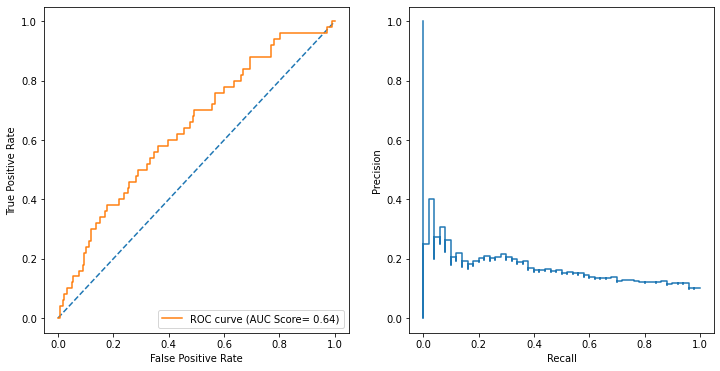

              precision    recall  f1-score   support

           0      0.936     0.487     0.640       450
           1      0.132     0.700     0.222        50

    accuracy                          0.508       500
   macro avg      0.534     0.593     0.431       500
weighted avg      0.855     0.508     0.598       500



[]

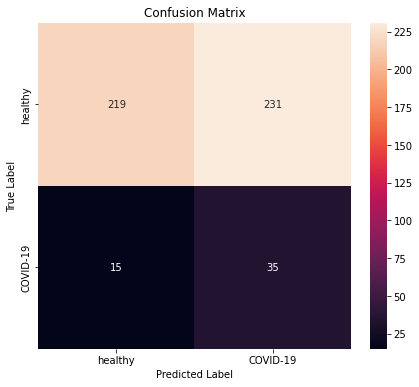

In [31]:
gs_model_3 = grid_src_3.best_estimator_.model
y_test_pred = gs_model_3.predict_classes(X_test).reshape(-1)
y_test_probs = gs_model_3.predict_proba(X_test).reshape(-1)

# ROC and ROC AUC score 
auc_score = roc_auc_score(y_test, y_test_probs)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

prec, recall, _ = precision_recall_curve(y_test, y_test_probs)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

fpr, tpr, _ = roc_curve(y_test, y_test_probs)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

ax1.plot([0,1], [0,1], linestyle='--')
roc_display.plot(ax=ax1, label = f"ROC curve (AUC Score= {round(auc_score, 3)})")
pr_display.plot(ax=ax2)
plt.show()

# CLASSIFICATION REPORT
print(classification_report(y_test, y_test_pred, digits=3))

# CONFUSION MATRIX
conf_mat = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(figsize = (7,6))
sns.heatmap(conf_mat, annot=True, fmt='g')
ax.set_title('Confusion Matrix')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.xaxis.set_ticklabels(['healthy', 'COVID-19'])
ax.yaxis.set_ticklabels(['healthy', 'COVID-19'])
plt.plot() 

### Exploring medium-sized networks with regularisation (but more epochs)

In [28]:
# 3 hours + to run

param_grid= {
    'n_hidden' : [3, 4],
    'filters' : [24, 32],
    'batch_size' : [16],
    'kernel_size' : [5],
    'kernel_initialiser' : ['he_normal'],
    'hidden_activation' : ['selu'],
    'final_activation' : ['sigmoid'],
    'optimiser' : ['Adamax'],
    'dropout' : [True],
    'dropout_p' : [0.2, 0.5]
}



grid_src_4 = model_selection.GridSearchCV(cnn, param_grid, cv=5, scoring = ['roc_auc', 'recall'], refit = 'roc_auc', return_train_score=True)
grid_src_4.fit(X_train, y_train, epochs = 100)  # increase epochs - more params to adjust

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_187 (Conv2D)          (None, 128, 431, 24)      624       
_________________________________________________________________
max_pooling2d_187 (MaxPoolin (None, 64, 215, 24)       0         
_________________________________________________________________
dropout_187 (Dropout)        (None, 64, 215, 24)       0         
_________________________________________________________________
conv2d_188 (Conv2D)          (None, 64, 215, 24)       14424     
_________________________________________________________________
max_pooling2d_188 (MaxPoolin (None, 32, 107, 24)       0         
_________________________________________________________________
dropout_188 (Dropout)        (None, 32, 107, 24)       0         
_________________________________________________________________
conv2d_189 (Conv2D)          (None, 32, 107, 24)     

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5987 - AUC: 0.7366
Epoch 27/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5941 - AUC: 0.7462
Epoch 28/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5847 - AUC: 0.7516
Epoch 29/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5859 - AUC: 0.7559
Epoch 30/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5791 - AUC: 0.7589
Epoch 31/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5843 - AUC: 0.7523
Epoch 32/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5706 - AUC: 0.7740
Epoch 33/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5762 - AUC: 0.7596
Epoch 34/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5632 - AUC: 0.7747
Epoch 35/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5571 - AUC: 0.7836
Epo

1600/1600 [==============================] - 6s 4ms/sample - loss: 0.7501 - AUC: 0.4854
Epoch 2/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7036 - AUC: 0.5367
Epoch 3/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7031 - AUC: 0.5360
Epoch 4/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6858 - AUC: 0.5793
Epoch 5/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6875 - AUC: 0.5793
Epoch 6/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6792 - AUC: 0.6001
Epoch 7/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6741 - AUC: 0.6100
Epoch 8/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6790 - AUC: 0.5952
Epoch 9/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6712 - AUC: 0.6155
Epoch 10/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6711 - AUC: 0.6164
Epoch 11/10

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5020 - AUC: 0.8288
Epoch 45/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.4966 - AUC: 0.8357
Epoch 46/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.4922 - AUC: 0.8384
Epoch 47/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.4953 - AUC: 0.8353
Epoch 48/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.4818 - AUC: 0.8474
Epoch 49/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.4845 - AUC: 0.8419
Epoch 50/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.4850 - AUC: 0.8443
Epoch 51/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.4796 - AUC: 0.8464
Epoch 52/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.4787 - AUC: 0.8481
Epoch 53/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.4700 - AUC: 0.8551
Epo

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6759 - AUC: 0.5995
Epoch 8/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6730 - AUC: 0.6171
Epoch 9/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6666 - AUC: 0.6346
Epoch 10/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6613 - AUC: 0.6334
Epoch 11/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6625 - AUC: 0.6371
Epoch 12/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6564 - AUC: 0.6475
Epoch 13/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6526 - AUC: 0.6527
Epoch 14/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6413 - AUC: 0.6709
Epoch 15/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6499 - AUC: 0.6565
Epoch 16/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6334 - AUC: 0.6852
Epoch

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6037 - AUC: 0.7259
Epoch 47/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6006 - AUC: 0.7291
Epoch 48/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5966 - AUC: 0.7345
Epoch 49/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5958 - AUC: 0.7377
Epoch 50/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5950 - AUC: 0.7365
Epoch 51/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5849 - AUC: 0.7523
Epoch 52/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5823 - AUC: 0.7534
Epoch 53/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5927 - AUC: 0.7398
Epoch 54/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5839 - AUC: 0.7533
Epoch 55/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5800 - AUC: 0.7576
Epo

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5078 - AUC: 0.8191
Epoch 87/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.4959 - AUC: 0.8326
Epoch 88/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.4964 - AUC: 0.8316
Epoch 89/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5006 - AUC: 0.8281
Epoch 90/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5054 - AUC: 0.8242
Epoch 91/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5066 - AUC: 0.8239
Epoch 92/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.4921 - AUC: 0.8352
Epoch 93/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.4957 - AUC: 0.8317
Epoch 94/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.4919 - AUC: 0.8360
Epoch 95/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.4898 - AUC: 0.8373
Epo

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7069 - AUC: 0.5333
Epoch 4/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7054 - AUC: 0.5270
Epoch 5/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6998 - AUC: 0.5418
Epoch 6/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6990 - AUC: 0.5423
Epoch 7/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6945 - AUC: 0.5511
Epoch 8/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6829 - AUC: 0.5873
Epoch 9/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6818 - AUC: 0.5881
Epoch 10/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6878 - AUC: 0.5731
Epoch 11/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6734 - AUC: 0.6112
Epoch 12/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6686 - AUC: 0.6171
Epoch 13/

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6197 - AUC: 0.7082
Epoch 44/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6109 - AUC: 0.7187
Epoch 45/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6097 - AUC: 0.7205
Epoch 46/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6084 - AUC: 0.7236
Epoch 47/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6004 - AUC: 0.7322
Epoch 48/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5968 - AUC: 0.7369
Epoch 49/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5959 - AUC: 0.7328
Epoch 50/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5915 - AUC: 0.7442
Epoch 51/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5849 - AUC: 0.7530
Epoch 52/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5928 - AUC: 0.7431
Epo

1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6774 - AUC: 0.6007
Epoch 7/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6700 - AUC: 0.6156
Epoch 8/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6594 - AUC: 0.6398
Epoch 9/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6582 - AUC: 0.6455
Epoch 10/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6580 - AUC: 0.6445
Epoch 11/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6435 - AUC: 0.6700
Epoch 12/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6452 - AUC: 0.6645
Epoch 13/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6360 - AUC: 0.6798
Epoch 14/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6319 - AUC: 0.6875
Epoch 15/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6331 - AUC: 0.6855
Epoch 

1600/1600 [==============================] - 4s 3ms/sample - loss: 0.4431 - AUC: 0.8726
Epoch 51/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.4394 - AUC: 0.8738
Epoch 52/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.4274 - AUC: 0.8824
Epoch 53/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.4285 - AUC: 0.8793
Epoch 54/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.4337 - AUC: 0.8781
Epoch 55/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.4120 - AUC: 0.8927
Epoch 56/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.4081 - AUC: 0.8959
Epoch 57/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.4042 - AUC: 0.8977
Epoch 58/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.4075 - AUC: 0.8943
Epoch 59/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.3963 - AUC: 0.9044
Epo

1600/1600 [==============================] - 4s 3ms/sample - loss: 0.2692 - AUC: 0.9615
Epoch 95/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.2773 - AUC: 0.9575
Epoch 96/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.2710 - AUC: 0.9608
Epoch 97/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.2629 - AUC: 0.9617
Epoch 98/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.2568 - AUC: 0.9666
Epoch 99/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.2592 - AUC: 0.9642
Epoch 100/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.2464 - AUC: 0.9692
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_231 (Conv2D)          (None, 128, 431, 32)      832       
_________________________________________________________________
max_pooling2d_231 

1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6094 - AUC: 0.7221
Epoch 21/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5962 - AUC: 0.7397
Epoch 22/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6009 - AUC: 0.7305
Epoch 23/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5944 - AUC: 0.7399
Epoch 24/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5919 - AUC: 0.7429
Epoch 25/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5821 - AUC: 0.7518
Epoch 26/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5779 - AUC: 0.7584
Epoch 27/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5768 - AUC: 0.7602
Epoch 28/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5745 - AUC: 0.7607
Epoch 29/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5702 - AUC: 0.7669
Epo

1600/1600 [==============================] - 7s 4ms/sample - loss: 0.7351 - AUC: 0.5169
Epoch 2/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7140 - AUC: 0.5381
Epoch 3/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6994 - AUC: 0.5609
Epoch 4/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7079 - AUC: 0.5536
Epoch 5/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7056 - AUC: 0.5428
Epoch 6/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6932 - AUC: 0.5626
Epoch 7/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7030 - AUC: 0.5485
Epoch 8/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6957 - AUC: 0.5542
Epoch 9/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6998 - AUC: 0.5570
Epoch 10/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6790 - AUC: 0.6012
Epoch 11/10

1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5718 - AUC: 0.7614
Epoch 42/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5628 - AUC: 0.7710
Epoch 43/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5575 - AUC: 0.7850
Epoch 44/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5562 - AUC: 0.7809
Epoch 45/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5526 - AUC: 0.7837
Epoch 46/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5604 - AUC: 0.7720
Epoch 47/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5404 - AUC: 0.7979
Epoch 48/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5412 - AUC: 0.7933
Epoch 49/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5355 - AUC: 0.7974
Epoch 50/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5366 - AUC: 0.7995
Epo

1600/1600 [==============================] - 7s 4ms/sample - loss: 0.7387 - AUC: 0.5345
Epoch 2/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7289 - AUC: 0.5352
Epoch 3/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7160 - AUC: 0.5289
Epoch 4/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6945 - AUC: 0.5701
Epoch 5/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7010 - AUC: 0.5585
Epoch 6/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6961 - AUC: 0.5698
Epoch 7/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6956 - AUC: 0.5722
Epoch 8/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6913 - AUC: 0.5772
Epoch 9/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6935 - AUC: 0.5744
Epoch 10/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6810 - AUC: 0.5940
Epoch 11/10

1600/1600 [==============================] - 5s 3ms/sample - loss: 0.5445 - AUC: 0.7907
Epoch 42/100
1600/1600 [==============================] - 5s 3ms/sample - loss: 0.5412 - AUC: 0.7951
Epoch 43/100
1600/1600 [==============================] - 5s 3ms/sample - loss: 0.5479 - AUC: 0.7877
Epoch 44/100
1600/1600 [==============================] - 5s 3ms/sample - loss: 0.5402 - AUC: 0.7936
Epoch 45/100
1600/1600 [==============================] - 5s 3ms/sample - loss: 0.5251 - AUC: 0.8078
Epoch 46/100
1600/1600 [==============================] - 5s 3ms/sample - loss: 0.5300 - AUC: 0.8046
Epoch 47/100
1600/1600 [==============================] - 5s 3ms/sample - loss: 0.5300 - AUC: 0.8050
Epoch 48/100
1600/1600 [==============================] - 5s 3ms/sample - loss: 0.5275 - AUC: 0.8066
Epoch 49/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5242 - AUC: 0.8089
Epoch 50/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5155 - AUC: 0.8171
Epo

1600/1600 [==============================] - 7s 4ms/sample - loss: 0.7520 - AUC: 0.4942
Epoch 2/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7211 - AUC: 0.5291
Epoch 3/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7056 - AUC: 0.5468
Epoch 4/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7029 - AUC: 0.5564
Epoch 5/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6886 - AUC: 0.5830
Epoch 6/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6906 - AUC: 0.5771
Epoch 7/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6941 - AUC: 0.5670
Epoch 8/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6853 - AUC: 0.5818
Epoch 9/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6871 - AUC: 0.5827
Epoch 10/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6885 - AUC: 0.5820
Epoch 11/10

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6714 - AUC: 0.6443
Epoch 46/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6645 - AUC: 0.6584
Epoch 47/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6614 - AUC: 0.6584
Epoch 48/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6603 - AUC: 0.6614
Epoch 49/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6650 - AUC: 0.6550
Epoch 50/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6521 - AUC: 0.6704
Epoch 51/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6448 - AUC: 0.6829
Epoch 52/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6425 - AUC: 0.6842
Epoch 53/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6575 - AUC: 0.6630
Epoch 54/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6485 - AUC: 0.6728
Epo

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5874 - AUC: 0.7446
Epoch 90/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5949 - AUC: 0.7386
Epoch 91/100
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5826 - AUC: 0.7539
Epoch 92/100
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5767 - AUC: 0.7596
Epoch 93/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5738 - AUC: 0.7642
Epoch 94/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5791 - AUC: 0.7598
Epoch 95/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5684 - AUC: 0.7715
Epoch 96/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5775 - AUC: 0.7593
Epoch 97/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5756 - AUC: 0.7591
Epoch 98/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.5607 - AUC: 0.7783
Epo

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7480 - AUC: 0.5305
Epoch 16/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7316 - AUC: 0.5614
Epoch 17/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7287 - AUC: 0.5581
Epoch 18/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7031 - AUC: 0.6027
Epoch 19/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7159 - AUC: 0.5726
Epoch 20/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7282 - AUC: 0.5532
Epoch 21/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7112 - AUC: 0.5820
Epoch 22/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7141 - AUC: 0.5772
Epoch 23/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7058 - AUC: 0.5916
Epoch 24/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6970 - AUC: 0.6034
Epo

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6304 - AUC: 0.6935
Epoch 60/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6367 - AUC: 0.6846
Epoch 61/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6173 - AUC: 0.7136
Epoch 62/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6395 - AUC: 0.6888
Epoch 63/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6209 - AUC: 0.7119
Epoch 64/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6087 - AUC: 0.7246
Epoch 65/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6179 - AUC: 0.7097
Epoch 66/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6138 - AUC: 0.7131
Epoch 67/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6150 - AUC: 0.7132
Epoch 68/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6115 - AUC: 0.7195
Epo

Epoch 99/100
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6591 - AUC: 0.6452
Epoch 100/100
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6678 - AUC: 0.6350
Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_276 (Conv2D)          (None, 128, 431, 24)      624       
_________________________________________________________________
max_pooling2d_276 (MaxPoolin (None, 64, 215, 24)       0         
_________________________________________________________________
dropout_276 (Dropout)        (None, 64, 215, 24)       0         
_________________________________________________________________
conv2d_277 (Conv2D)          (None, 64, 215, 24)       14424     
_________________________________________________________________
max_pooling2d_277 (MaxPoolin (None, 32, 107, 24)       0         
________________________________________________

1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7184 - AUC: 0.5620
Epoch 59/100
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7291 - AUC: 0.5469
Epoch 60/100
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7142 - AUC: 0.5662
Epoch 61/100
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7145 - AUC: 0.5645
Epoch 62/100
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7163 - AUC: 0.5579
Epoch 63/100
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7216 - AUC: 0.5527
Epoch 64/100
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7239 - AUC: 0.5494
Epoch 65/100
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7107 - AUC: 0.5769
Epoch 66/100
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7032 - AUC: 0.5864
Epoch 67/100
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7144 - AUC: 0.5695
Epo

1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6657 - AUC: 0.6346
Epoch 99/100
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6565 - AUC: 0.6518
Epoch 100/100
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.6586 - AUC: 0.6439
Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_284 (Conv2D)          (None, 128, 431, 24)      624       
_________________________________________________________________
max_pooling2d_284 (MaxPoolin (None, 64, 215, 24)       0         
_________________________________________________________________
dropout_284 (Dropout)        (None, 64, 215, 24)       0         
_________________________________________________________________
conv2d_285 (Conv2D)          (None, 64, 215, 24)       14424     
_________________________________________________________________
max_pooling2d_285 (MaxPool

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7994 - AUC: 0.4856
Epoch 17/100
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7876 - AUC: 0.4944
Epoch 18/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7721 - AUC: 0.5195
Epoch 19/100
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7729 - AUC: 0.5162
Epoch 20/100
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7438 - AUC: 0.5421
Epoch 21/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7589 - AUC: 0.5277
Epoch 22/100
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7363 - AUC: 0.5529
Epoch 23/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7561 - AUC: 0.5267
Epoch 24/100
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.7620 - AUC: 0.5194
Epoch 25/100
1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7493 - AUC: 0.5333
Epo

1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5976 - AUC: 0.7353
Epoch 61/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5849 - AUC: 0.7504
Epoch 62/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5957 - AUC: 0.7397
Epoch 63/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6021 - AUC: 0.7320
Epoch 64/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5856 - AUC: 0.7482
Epoch 65/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5742 - AUC: 0.7630
Epoch 66/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5871 - AUC: 0.7424
Epoch 67/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5739 - AUC: 0.7614
Epoch 68/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5721 - AUC: 0.7638
Epoch 69/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5805 - AUC: 0.7549
Epo

1600/1600 [==============================] - 7s 4ms/sample - loss: 0.8964 - AUC: 0.5120
Epoch 2/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.8265 - AUC: 0.5230
Epoch 3/100
1600/1600 [==============================] - 5s 3ms/sample - loss: 0.8085 - AUC: 0.5192
Epoch 4/100
1600/1600 [==============================] - 5s 3ms/sample - loss: 0.8014 - AUC: 0.5154
Epoch 5/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7750 - AUC: 0.5402
Epoch 6/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.8127 - AUC: 0.4848
Epoch 7/100
1600/1600 [==============================] - 5s 3ms/sample - loss: 0.7846 - AUC: 0.5151
Epoch 8/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7725 - AUC: 0.5308
Epoch 9/100
1600/1600 [==============================] - 5s 3ms/sample - loss: 0.7596 - AUC: 0.5436
Epoch 10/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7604 - AUC: 0.5408
Epoch 11/10

1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6445 - AUC: 0.6919
Epoch 46/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6417 - AUC: 0.6980
Epoch 47/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6293 - AUC: 0.7056
Epoch 48/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6300 - AUC: 0.7078
Epoch 49/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6207 - AUC: 0.7093
Epoch 50/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6288 - AUC: 0.7084
Epoch 51/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6208 - AUC: 0.7154
Epoch 52/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6307 - AUC: 0.7052
Epoch 53/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6005 - AUC: 0.7364
Epoch 54/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6273 - AUC: 0.7105
Epo

1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5459 - AUC: 0.7892
Epoch 90/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5544 - AUC: 0.7778
Epoch 91/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5474 - AUC: 0.7856
Epoch 92/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5558 - AUC: 0.7825
Epoch 93/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5498 - AUC: 0.7808
Epoch 94/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5422 - AUC: 0.7918
Epoch 95/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5434 - AUC: 0.7911
Epoch 96/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5378 - AUC: 0.7986
Epoch 97/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5353 - AUC: 0.7992
Epoch 98/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.5415 - AUC: 0.7925
Epo

1600/1600 [==============================] - 4s 3ms/sample - loss: 0.8385 - AUC: 0.5049
Epoch 8/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.8353 - AUC: 0.5002
Epoch 9/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.8178 - AUC: 0.5173
Epoch 10/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.8016 - AUC: 0.5268
Epoch 11/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7680 - AUC: 0.5491
Epoch 12/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7939 - AUC: 0.5082
Epoch 13/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7839 - AUC: 0.5329
Epoch 14/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.8237 - AUC: 0.4821
Epoch 15/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7732 - AUC: 0.5318
Epoch 16/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7922 - AUC: 0.5102
Epoch

1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7247 - AUC: 0.5710
Epoch 48/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7208 - AUC: 0.5715
Epoch 49/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7084 - AUC: 0.5827
Epoch 50/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7009 - AUC: 0.5958
Epoch 51/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7082 - AUC: 0.5801
Epoch 52/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7329 - AUC: 0.5459
Epoch 53/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7056 - AUC: 0.5936
Epoch 54/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7037 - AUC: 0.5989
Epoch 55/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7080 - AUC: 0.5878
Epoch 56/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.7041 - AUC: 0.5863
Epo

1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6515 - AUC: 0.6670
Epoch 88/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6689 - AUC: 0.6448
Epoch 89/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6754 - AUC: 0.6336
Epoch 90/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6724 - AUC: 0.6427
Epoch 91/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6454 - AUC: 0.6774
Epoch 92/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6672 - AUC: 0.6488
Epoch 93/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6541 - AUC: 0.6658
Epoch 94/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6461 - AUC: 0.6755
Epoch 95/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6598 - AUC: 0.6581
Epoch 96/100
1600/1600 [==============================] - 4s 3ms/sample - loss: 0.6388 - AUC: 0.6851
Epo

2000/2000 [==============================] - 4s 2ms/sample - loss: 0.6804 - AUC: 0.5974
Epoch 6/100
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.6880 - AUC: 0.5755
Epoch 7/100
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.6877 - AUC: 0.5808
Epoch 8/100
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.6815 - AUC: 0.5943
Epoch 9/100
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.6780 - AUC: 0.5991
Epoch 10/100
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.6757 - AUC: 0.6105
Epoch 11/100
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.6696 - AUC: 0.6243
Epoch 12/100
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.6712 - AUC: 0.6189
Epoch 13/100
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.6560 - AUC: 0.6487
Epoch 14/100
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.6640 - AUC: 0.6378
Epoch 1

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000227A9277488>,
             param_grid={'batch_size': [16], 'dropout': [True],
                         'dropout_p': [0.2, 0.5], 'filters': [24, 32],
                         'final_activation': ['sigmoid'],
                         'hidden_activation': ['selu'],
                         'kernel_initialiser': ['he_normal'],
                         'kernel_size': [5], 'n_hidden': [3, 4],
                         'optimiser': ['Adamax']},
             scoring='roc_auc')

In [29]:
grid_src_4.best_params_

{'batch_size': 16,
 'dropout': True,
 'dropout_p': 0.2,
 'filters': 24,
 'final_activation': 'sigmoid',
 'hidden_activation': 'selu',
 'kernel_initialiser': 'he_normal',
 'kernel_size': 5,
 'n_hidden': 4,
 'optimiser': 'Adamax'}

In [ ]:
grid_src_4.cv_results_

## MFCC

### Define training and testing data, and model building function

In [27]:
X_train = train_mfccs
X_test = test_mfccs

In [28]:
def build_cnn(
    hidden_activation = 'relu',
    final_activation = 'sigmoid',
    filters = 32,
    n_hidden = 1,
    kernel_size = 3,
    dropout = False,
    dropout_p = 0.2,
    optimiser = 'Adam',
    kernel_initialiser = 'he_normal',
    learning_rate = 0.0001):
    
    model = keras.models.Sequential()

    # first layer:
    if hidden_activation == 'leaky_relu':
        model.add(keras.layers.Conv2D(filters=filters, kernel_size = (kernel_size,kernel_size), input_shape = (20,431,1), kernel_initializer=kernel_initialiser))
        keras.layers.LeakyReLU(alpha=0.2),
    elif hidden_activation == 'selu':
        model.add(keras.layers.Conv2D(filters=filters, kernel_size=(kernel_size, kernel_size), activation='selu', padding = 'same', input_shape=(20,431,1), kernel_initializer='lecun_normal'))
    else:
        model.add(keras.layers.Conv2D(filters=filters, kernel_size = (kernel_size,kernel_size), activation=hidden_activation, input_shape = (20,431,1), kernel_initializer=kernel_initialiser))

    model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))  # add maxpooling layer

    if dropout:
        model.add(keras.layers.Dropout(dropout_p))

    if n_hidden > 1:
        for layer in range(n_hidden - 1):
            if hidden_activation == 'leaky_relu':
                model.add(keras.layers.Conv2D(filters=filters, kernel_size = (kernel_size,kernel_size), padding = 'same', kernel_initializer=kernel_initialiser))
                keras.layers.LeakyReLU(alpha=0.2)
                model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))  # add maxpooling layer
            elif hidden_activation == 'selu':
                model.add(keras.layers.Conv2D(filters=filters, kernel_size = (kernel_size,kernel_size), activation='selu', padding = 'same', kernel_initializer='lecun_normal'))
                model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))  # add maxpooling layer
            else:
                model.add(keras.layers.Conv2D(filters=filters, kernel_size = (kernel_size,kernel_size), activation=hidden_activation, padding = 'same', kernel_initializer=kernel_initialiser))
                model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))  # add maxpooling layer
            
            if dropout:
                model.add(keras.layers.Dropout(dropout_p))


    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1, activation = final_activation))

    if optimiser == 'SGD':
        opt = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimiser == 'momentum':
        opt = keras.optimizers.SGD(learning_rate=learning_rate, momentum = 0.9)
    elif optimiser == 'Adam':
        opt = keras.optimizers.Adam(learning_rate = learning_rate)
    elif optimiser == 'Adamax':
        opt = keras.optimizers.Adamax(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
    elif optimiser == 'Adagrad':
        opt = keras.optimizers.Adagrad(learning_rate = learning_rate)

    model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ["AUC"])
    print(model.summary())
    return model

cnn = keras.wrappers.scikit_learn.KerasClassifier(build_cnn)

### Baseline Model

In [24]:
# 3 hours + to run

param_dist= {
    'n_hidden' : [1, 2, 3, 4],
    'filters' : [16, 24, 32],
    'batch_size' : [16, 32],
    'kernel_size' : [3, 4, 5],
    'kernel_initialiser' : ['he_normal', 'lecun_normal', 'he_uniform'],
    'hidden_activation' : ['relu', 'elu', 'selu', 'sigmoid','hard_sigmoid'],
    'final_activation' : ['sigmoid','hard_sigmoid'],
    'optimiser' : ['momentum', 'Adam', 'Adamax'],
}


rnd_search_cv = model_selection.RandomizedSearchCV(cnn, param_dist, n_iter = 12, cv=5, scoring = 'roc_auc', random_state = random_state)
rnd_search_cv.fit(X_train, y_train, epochs = 100)

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_139 (Conv2D)          (None, 17, 428, 16)       272       
_________________________________________________________________
max_pooling2d_139 (MaxPoolin (None, 8, 214, 16)        0         
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 8, 214, 16)        4112      
_________________________________________________________________
max_pooling2d_140 (MaxPoolin (None, 4, 107, 16)        0         
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 4, 107, 16)        4112      
_________________________________________________________________
max_pooling2d_141 (MaxPoolin (None, 2, 53, 16)         0         
_________________________________________________________________
flatten_61 (Flatten)         (None, 1696)            

1600/1600 [==============================] - 0s 290us/sample - loss: 0.6145 - AUC: 0.7173
Epoch 32/100
1600/1600 [==============================] - 0s 290us/sample - loss: 0.6110 - AUC: 0.7228
Epoch 33/100
1600/1600 [==============================] - 0s 289us/sample - loss: 0.6090 - AUC: 0.7218
Epoch 34/100
1600/1600 [==============================] - 0s 293us/sample - loss: 0.6095 - AUC: 0.7221
Epoch 35/100
1600/1600 [==============================] - 0s 289us/sample - loss: 0.6082 - AUC: 0.7247
Epoch 36/100
1600/1600 [==============================] - 0s 290us/sample - loss: 0.6057 - AUC: 0.7270
Epoch 37/100
1600/1600 [==============================] - 0s 291us/sample - loss: 0.6075 - AUC: 0.7264
Epoch 38/100
1600/1600 [==============================] - 0s 291us/sample - loss: 0.6045 - AUC: 0.7267
Epoch 39/100
1600/1600 [==============================] - 0s 287us/sample - loss: 0.6019 - AUC: 0.7347
Epoch 40/100
1600/1600 [==============================] - 0s 291us/sample - loss: 0.59

1600/1600 [==============================] - 1s 790us/sample - loss: 0.6942 - AUC: 0.4957
Epoch 2/100
1600/1600 [==============================] - 0s 288us/sample - loss: 0.6931 - AUC: 0.5136
Epoch 3/100
1600/1600 [==============================] - 0s 290us/sample - loss: 0.6925 - AUC: 0.5293
Epoch 4/100
1600/1600 [==============================] - 0s 293us/sample - loss: 0.6916 - AUC: 0.5552
Epoch 5/100
1600/1600 [==============================] - 0s 289us/sample - loss: 0.6910 - AUC: 0.5730
Epoch 6/100
1600/1600 [==============================] - 0s 289us/sample - loss: 0.6900 - AUC: 0.5596
Epoch 7/100
1600/1600 [==============================] - 0s 291us/sample - loss: 0.6874 - AUC: 0.5797
Epoch 8/100
1600/1600 [==============================] - 0s 292us/sample - loss: 0.6880 - AUC: 0.5787
Epoch 9/100
1600/1600 [==============================] - 0s 290us/sample - loss: 0.6822 - AUC: 0.6127
Epoch 10/100
1600/1600 [==============================] - 0s 288us/sample - loss: 0.6788 - AUC

1600/1600 [==============================] - 0s 293us/sample - loss: 0.5977 - AUC: 0.7371
Epoch 46/100
1600/1600 [==============================] - 0s 295us/sample - loss: 0.5943 - AUC: 0.7405
Epoch 47/100
1600/1600 [==============================] - 0s 292us/sample - loss: 0.5910 - AUC: 0.7439
Epoch 48/100
1600/1600 [==============================] - 0s 292us/sample - loss: 0.5904 - AUC: 0.7449
Epoch 49/100
1600/1600 [==============================] - 0s 291us/sample - loss: 0.5900 - AUC: 0.7457
Epoch 50/100
1600/1600 [==============================] - 0s 293us/sample - loss: 0.5872 - AUC: 0.7473
Epoch 51/100
1600/1600 [==============================] - 0s 293us/sample - loss: 0.5848 - AUC: 0.7513
Epoch 52/100
1600/1600 [==============================] - 0s 292us/sample - loss: 0.5847 - AUC: 0.7503
Epoch 53/100
1600/1600 [==============================] - 0s 292us/sample - loss: 0.5824 - AUC: 0.7531
Epoch 54/100
1600/1600 [==============================] - 0s 291us/sample - loss: 0.57

1600/1600 [==============================] - 0s 292us/sample - loss: 0.5323 - AUC: 0.7996
Epoch 90/100
1600/1600 [==============================] - 0s 287us/sample - loss: 0.5339 - AUC: 0.7973
Epoch 91/100
1600/1600 [==============================] - 0s 289us/sample - loss: 0.5304 - AUC: 0.8010
Epoch 92/100
1600/1600 [==============================] - 0s 290us/sample - loss: 0.5287 - AUC: 0.8020
Epoch 93/100
1600/1600 [==============================] - 0s 291us/sample - loss: 0.5277 - AUC: 0.8026
Epoch 94/100
1600/1600 [==============================] - 0s 290us/sample - loss: 0.5268 - AUC: 0.8025
Epoch 95/100
1600/1600 [==============================] - 0s 291us/sample - loss: 0.5270 - AUC: 0.8045
Epoch 96/100
1600/1600 [==============================] - 0s 288us/sample - loss: 0.5255 - AUC: 0.8039
Epoch 97/100
1600/1600 [==============================] - 0s 290us/sample - loss: 0.5258 - AUC: 0.8029
Epoch 98/100
1600/1600 [==============================] - 0s 290us/sample - loss: 0.52

1600/1600 [==============================] - 0s 219us/sample - loss: 0.7082 - AUC: 0.5158
Epoch 30/100
1600/1600 [==============================] - 0s 222us/sample - loss: 0.7281 - AUC: 0.4983
Epoch 31/100
1600/1600 [==============================] - 0s 221us/sample - loss: 0.6969 - AUC: 0.5112
Epoch 32/100
1600/1600 [==============================] - 0s 218us/sample - loss: 0.7010 - AUC: 0.5141
Epoch 33/100
1600/1600 [==============================] - 0s 220us/sample - loss: 0.7026 - AUC: 0.5089
Epoch 34/100
1600/1600 [==============================] - 0s 219us/sample - loss: 0.7028 - AUC: 0.5076
Epoch 35/100
1600/1600 [==============================] - 0s 222us/sample - loss: 0.7025 - AUC: 0.5182
Epoch 36/100
1600/1600 [==============================] - 0s 221us/sample - loss: 0.6963 - AUC: 0.5211
Epoch 37/100
1600/1600 [==============================] - 0s 219us/sample - loss: 0.6974 - AUC: 0.5057
Epoch 38/100
1600/1600 [==============================] - 0s 224us/sample - loss: 0.69

1600/1600 [==============================] - 1s 764us/sample - loss: 0.7149 - AUC: 0.4984
Epoch 2/100
1600/1600 [==============================] - 0s 222us/sample - loss: 0.7396 - AUC: 0.5007
Epoch 3/100
1600/1600 [==============================] - 0s 220us/sample - loss: 0.7063 - AUC: 0.5277
Epoch 4/100
1600/1600 [==============================] - 0s 221us/sample - loss: 0.6990 - AUC: 0.5069
Epoch 5/100
1600/1600 [==============================] - 0s 221us/sample - loss: 0.7090 - AUC: 0.5199
Epoch 6/100
1600/1600 [==============================] - 0s 222us/sample - loss: 0.7182 - AUC: 0.4872
Epoch 7/100
1600/1600 [==============================] - 0s 221us/sample - loss: 0.7012 - AUC: 0.4985
Epoch 8/100
1600/1600 [==============================] - 0s 218us/sample - loss: 0.7104 - AUC: 0.5036
Epoch 9/100
1600/1600 [==============================] - 0s 222us/sample - loss: 0.7007 - AUC: 0.5135
Epoch 10/100
1600/1600 [==============================] - 0s 220us/sample - loss: 0.6935 - AUC

1600/1600 [==============================] - 0s 218us/sample - loss: 0.7070 - AUC: 0.5218
Epoch 51/100
1600/1600 [==============================] - 0s 221us/sample - loss: 0.7057 - AUC: 0.5215
Epoch 52/100
1600/1600 [==============================] - 0s 218us/sample - loss: 0.7195 - AUC: 0.5025
Epoch 53/100
1600/1600 [==============================] - 0s 217us/sample - loss: 0.7138 - AUC: 0.5048
Epoch 54/100
1600/1600 [==============================] - 0s 219us/sample - loss: 0.6935 - AUC: 0.5346
Epoch 55/100
1600/1600 [==============================] - 0s 219us/sample - loss: 0.7069 - AUC: 0.5223
Epoch 56/100
1600/1600 [==============================] - 0s 221us/sample - loss: 0.6987 - AUC: 0.5166
Epoch 57/100
1600/1600 [==============================] - 0s 218us/sample - loss: 0.6910 - AUC: 0.5567
Epoch 58/100
1600/1600 [==============================] - 0s 218us/sample - loss: 0.6981 - AUC: 0.5235
Epoch 59/100
1600/1600 [==============================] - 0s 219us/sample - loss: 0.70

1600/1600 [==============================] - 0s 221us/sample - loss: 0.6973 - AUC: 0.5374
Epoch 100/100
1600/1600 [==============================] - 0s 223us/sample - loss: 0.6960 - AUC: 0.5309
Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_159 (Conv2D)          (None, 17, 428, 16)       272       
_________________________________________________________________
max_pooling2d_159 (MaxPoolin (None, 8, 214, 16)        0         
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 8, 214, 16)        4112      
_________________________________________________________________
max_pooling2d_160 (MaxPoolin (None, 4, 107, 16)        0         
_________________________________________________________________
conv2d_161 (Conv2D)          (None, 4, 107, 16)        4112      
_________________________________________________________

1600/1600 [==============================] - 1s 314us/sample - loss: 0.6941 - AUC: 0.4785
Epoch 30/100
1600/1600 [==============================] - 0s 307us/sample - loss: 0.6939 - AUC: 0.4744
Epoch 31/100
1600/1600 [==============================] - 0s 312us/sample - loss: 0.6949 - AUC: 0.4746
Epoch 32/100
1600/1600 [==============================] - 0s 309us/sample - loss: 0.6941 - AUC: 0.4866
Epoch 33/100
1600/1600 [==============================] - 1s 313us/sample - loss: 0.6941 - AUC: 0.4896
Epoch 34/100
1600/1600 [==============================] - 0s 309us/sample - loss: 0.6948 - AUC: 0.4882
Epoch 35/100
1600/1600 [==============================] - 0s 310us/sample - loss: 0.6938 - AUC: 0.4988
Epoch 36/100
1600/1600 [==============================] - 0s 308us/sample - loss: 0.6953 - AUC: 0.4662
Epoch 37/100
1600/1600 [==============================] - 0s 308us/sample - loss: 0.6944 - AUC: 0.4892
Epoch 38/100
1600/1600 [==============================] - 0s 310us/sample - loss: 0.69

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6984 - AUC: 0.4688
Epoch 2/100
1600/1600 [==============================] - 0s 311us/sample - loss: 0.6934 - AUC: 0.5067
Epoch 3/100
1600/1600 [==============================] - 0s 311us/sample - loss: 0.6937 - AUC: 0.5077
Epoch 4/100
1600/1600 [==============================] - 0s 311us/sample - loss: 0.6949 - AUC: 0.4871
Epoch 5/100
1600/1600 [==============================] - 0s 311us/sample - loss: 0.6943 - AUC: 0.4974
Epoch 6/100
1600/1600 [==============================] - 0s 306us/sample - loss: 0.6941 - AUC: 0.4976
Epoch 7/100
1600/1600 [==============================] - 1s 313us/sample - loss: 0.6945 - AUC: 0.5012
Epoch 8/100
1600/1600 [==============================] - 0s 308us/sample - loss: 0.6948 - AUC: 0.4830
Epoch 9/100
1600/1600 [==============================] - 0s 307us/sample - loss: 0.6931 - AUC: 0.5121
Epoch 10/100
1600/1600 [==============================] - 0s 311us/sample - loss: 0.6936 - AUC: 

1600/1600 [==============================] - 0s 312us/sample - loss: 0.6939 - AUC: 0.4882
Epoch 46/100
1600/1600 [==============================] - 0s 309us/sample - loss: 0.6936 - AUC: 0.4903
Epoch 47/100
1600/1600 [==============================] - 0s 311us/sample - loss: 0.6953 - AUC: 0.4885
Epoch 48/100
1600/1600 [==============================] - 0s 311us/sample - loss: 0.6932 - AUC: 0.5110
Epoch 49/100
1600/1600 [==============================] - 0s 312us/sample - loss: 0.6945 - AUC: 0.4922
Epoch 50/100
1600/1600 [==============================] - 0s 309us/sample - loss: 0.6935 - AUC: 0.5010
Epoch 51/100
1600/1600 [==============================] - 0s 307us/sample - loss: 0.6942 - AUC: 0.4828
Epoch 52/100
1600/1600 [==============================] - 0s 309us/sample - loss: 0.6938 - AUC: 0.4888
Epoch 53/100
1600/1600 [==============================] - 0s 310us/sample - loss: 0.6938 - AUC: 0.4960
Epoch 54/100
1600/1600 [==============================] - 1s 314us/sample - loss: 0.69

1600/1600 [==============================] - 0s 312us/sample - loss: 0.6944 - AUC: 0.4702
Epoch 90/100
1600/1600 [==============================] - 0s 311us/sample - loss: 0.6937 - AUC: 0.4616
Epoch 91/100
1600/1600 [==============================] - 0s 311us/sample - loss: 0.6944 - AUC: 0.4701
Epoch 92/100
1600/1600 [==============================] - 0s 309us/sample - loss: 0.6938 - AUC: 0.4687
Epoch 93/100
1600/1600 [==============================] - 0s 311us/sample - loss: 0.6935 - AUC: 0.4812
Epoch 94/100
1600/1600 [==============================] - 0s 310us/sample - loss: 0.6936 - AUC: 0.4846
Epoch 95/100
1600/1600 [==============================] - 1s 313us/sample - loss: 0.6940 - AUC: 0.4874
Epoch 96/100
1600/1600 [==============================] - 0s 311us/sample - loss: 0.6941 - AUC: 0.4904
Epoch 97/100
1600/1600 [==============================] - 0s 306us/sample - loss: 0.6940 - AUC: 0.4901
Epoch 98/100
1600/1600 [==============================] - 0s 310us/sample - loss: 0.69

1600/1600 [==============================] - 0s 251us/sample - loss: 0.7031 - AUC: 0.5241
Epoch 30/100
1600/1600 [==============================] - 0s 253us/sample - loss: 0.7377 - AUC: 0.5339
Epoch 31/100
1600/1600 [==============================] - 0s 253us/sample - loss: 0.7149 - AUC: 0.4966
Epoch 32/100
1600/1600 [==============================] - 0s 251us/sample - loss: 0.7161 - AUC: 0.5190
Epoch 33/100
1600/1600 [==============================] - 0s 252us/sample - loss: 0.6902 - AUC: 0.5650
Epoch 34/100
1600/1600 [==============================] - 0s 253us/sample - loss: 0.7054 - AUC: 0.5112
Epoch 35/100
1600/1600 [==============================] - 0s 253us/sample - loss: 0.7139 - AUC: 0.4993
Epoch 36/100
1600/1600 [==============================] - 0s 253us/sample - loss: 0.7098 - AUC: 0.5208
Epoch 37/100
1600/1600 [==============================] - 0s 254us/sample - loss: 0.6962 - AUC: 0.5408
Epoch 38/100
1600/1600 [==============================] - 0s 253us/sample - loss: 0.70

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7179 - AUC: 0.4970
Epoch 2/100
1600/1600 [==============================] - 0s 259us/sample - loss: 0.7286 - AUC: 0.4985
Epoch 3/100
1600/1600 [==============================] - 0s 254us/sample - loss: 0.7344 - AUC: 0.4755
Epoch 4/100
1600/1600 [==============================] - 0s 259us/sample - loss: 0.7121 - AUC: 0.4882
Epoch 5/100
1600/1600 [==============================] - 0s 253us/sample - loss: 0.7132 - AUC: 0.5054
Epoch 6/100
1600/1600 [==============================] - 0s 254us/sample - loss: 0.7111 - AUC: 0.5295
Epoch 7/100
1600/1600 [==============================] - 0s 256us/sample - loss: 0.7324 - AUC: 0.5029
Epoch 8/100
1600/1600 [==============================] - 0s 258us/sample - loss: 0.7285 - AUC: 0.5150
Epoch 9/100
1600/1600 [==============================] - 0s 257us/sample - loss: 0.7462 - AUC: 0.5052
Epoch 10/100
1600/1600 [==============================] - 0s 256us/sample - loss: 0.7220 - AUC: 

1600/1600 [==============================] - 0s 254us/sample - loss: 0.7017 - AUC: 0.5457
Epoch 51/100
1600/1600 [==============================] - 0s 254us/sample - loss: 0.6901 - AUC: 0.5572
Epoch 52/100
1600/1600 [==============================] - 0s 254us/sample - loss: 0.6936 - AUC: 0.5626
Epoch 53/100
1600/1600 [==============================] - 0s 255us/sample - loss: 0.7111 - AUC: 0.5357
Epoch 54/100
1600/1600 [==============================] - 0s 255us/sample - loss: 0.6932 - AUC: 0.5571
Epoch 55/100
1600/1600 [==============================] - 0s 252us/sample - loss: 0.6948 - AUC: 0.5351
Epoch 56/100
1600/1600 [==============================] - 0s 258us/sample - loss: 0.6844 - AUC: 0.5725
Epoch 57/100
1600/1600 [==============================] - 0s 252us/sample - loss: 0.6970 - AUC: 0.5459
Epoch 58/100
1600/1600 [==============================] - 0s 254us/sample - loss: 0.6930 - AUC: 0.5488
Epoch 59/100
1600/1600 [==============================] - 0s 253us/sample - loss: 0.69

1600/1600 [==============================] - 0s 256us/sample - loss: 7.6739 - AUC: 0.5000
Epoch 100/100
1600/1600 [==============================] - 0s 257us/sample - loss: 7.6739 - AUC: 0.5000
Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_179 (Conv2D)          (None, 20, 431, 32)       320       
_________________________________________________________________
max_pooling2d_179 (MaxPoolin (None, 10, 215, 32)       0         
_________________________________________________________________
conv2d_180 (Conv2D)          (None, 10, 215, 32)       9248      
_________________________________________________________________
max_pooling2d_180 (MaxPoolin (None, 5, 107, 32)        0         
_________________________________________________________________
conv2d_181 (Conv2D)          (None, 5, 107, 32)        9248      
_________________________________________________________

1600/1600 [==============================] - 1s 516us/sample - loss: 0.5678 - AUC: 0.7785
Epoch 26/100
1600/1600 [==============================] - 1s 514us/sample - loss: 0.5635 - AUC: 0.7812
Epoch 27/100
1600/1600 [==============================] - 1s 510us/sample - loss: 0.5647 - AUC: 0.7766
Epoch 28/100
1600/1600 [==============================] - 1s 510us/sample - loss: 0.5541 - AUC: 0.7920
Epoch 29/100
1600/1600 [==============================] - 1s 511us/sample - loss: 0.5508 - AUC: 0.7882
Epoch 30/100
1600/1600 [==============================] - 1s 516us/sample - loss: 0.5423 - AUC: 0.8033
Epoch 31/100
1600/1600 [==============================] - 1s 515us/sample - loss: 0.5376 - AUC: 0.8052
Epoch 32/100
1600/1600 [==============================] - 1s 511us/sample - loss: 0.5307 - AUC: 0.8108
Epoch 33/100
1600/1600 [==============================] - 1s 511us/sample - loss: 0.5262 - AUC: 0.8142
Epoch 34/100
1600/1600 [==============================] - 1s 516us/sample - loss: 0.52

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7218 - AUC: 0.4975
Epoch 2/100
1600/1600 [==============================] - 1s 510us/sample - loss: 0.6913 - AUC: 0.5341
Epoch 3/100
1600/1600 [==============================] - 1s 510us/sample - loss: 0.6919 - AUC: 0.5395
Epoch 4/100
1600/1600 [==============================] - 1s 511us/sample - loss: 0.6897 - AUC: 0.5470
Epoch 5/100
1600/1600 [==============================] - 1s 513us/sample - loss: 0.6846 - AUC: 0.5849
Epoch 6/100
1600/1600 [==============================] - 1s 508us/sample - loss: 0.6842 - AUC: 0.5739
Epoch 7/100
1600/1600 [==============================] - 1s 509us/sample - loss: 0.6830 - AUC: 0.5814
Epoch 8/100
1600/1600 [==============================] - 1s 508us/sample - loss: 0.6741 - AUC: 0.6369
Epoch 9/100
1600/1600 [==============================] - 1s 509us/sample - loss: 0.6717 - AUC: 0.6374
Epoch 10/100
1600/1600 [==============================] - 1s 508us/sample - loss: 0.6681 - AUC: 

1600/1600 [==============================] - 1s 514us/sample - loss: 0.5008 - AUC: 0.8287
Epoch 44/100
1600/1600 [==============================] - 1s 513us/sample - loss: 0.4947 - AUC: 0.8344
Epoch 45/100
1600/1600 [==============================] - 1s 510us/sample - loss: 0.4923 - AUC: 0.8342
Epoch 46/100
1600/1600 [==============================] - 1s 509us/sample - loss: 0.4863 - AUC: 0.8394
Epoch 47/100
1600/1600 [==============================] - 1s 511us/sample - loss: 0.4821 - AUC: 0.8438
Epoch 48/100
1600/1600 [==============================] - 1s 513us/sample - loss: 0.4770 - AUC: 0.8477
Epoch 49/100
1600/1600 [==============================] - 1s 512us/sample - loss: 0.4739 - AUC: 0.8498
Epoch 50/100
1600/1600 [==============================] - 1s 513us/sample - loss: 0.4706 - AUC: 0.8516
Epoch 51/100
1600/1600 [==============================] - 1s 514us/sample - loss: 0.4676 - AUC: 0.8547
Epoch 52/100
1600/1600 [==============================] - 1s 514us/sample - loss: 0.46

1600/1600 [==============================] - 1s 513us/sample - loss: 0.2906 - AUC: 0.9638
Epoch 86/100
1600/1600 [==============================] - 1s 508us/sample - loss: 0.2903 - AUC: 0.9620
Epoch 87/100
1600/1600 [==============================] - 1s 510us/sample - loss: 0.2825 - AUC: 0.9654
Epoch 88/100
1600/1600 [==============================] - 1s 513us/sample - loss: 0.2781 - AUC: 0.9671
Epoch 89/100
1600/1600 [==============================] - 1s 508us/sample - loss: 0.2738 - AUC: 0.9679
Epoch 90/100
1600/1600 [==============================] - 1s 513us/sample - loss: 0.2709 - AUC: 0.9699
Epoch 91/100
1600/1600 [==============================] - 1s 513us/sample - loss: 0.2637 - AUC: 0.9724
Epoch 92/100
1600/1600 [==============================] - 1s 511us/sample - loss: 0.2564 - AUC: 0.9743
Epoch 93/100
1600/1600 [==============================] - 1s 511us/sample - loss: 0.2536 - AUC: 0.9751
Epoch 94/100
1600/1600 [==============================] - 1s 508us/sample - loss: 0.24

1600/1600 [==============================] - 0s 311us/sample - loss: 0.7729 - AUC: 0.5443
Epoch 26/100
1600/1600 [==============================] - 1s 313us/sample - loss: 0.7281 - AUC: 0.5244
Epoch 27/100
1600/1600 [==============================] - 1s 313us/sample - loss: 0.7129 - AUC: 0.5235
Epoch 28/100
1600/1600 [==============================] - 0s 309us/sample - loss: 0.7541 - AUC: 0.4809
Epoch 29/100
1600/1600 [==============================] - 0s 308us/sample - loss: 0.7609 - AUC: 0.5171
Epoch 30/100
1600/1600 [==============================] - 1s 314us/sample - loss: 0.7320 - AUC: 0.4923
Epoch 31/100
1600/1600 [==============================] - 0s 311us/sample - loss: 0.7390 - AUC: 0.4998
Epoch 32/100
1600/1600 [==============================] - 0s 309us/sample - loss: 0.7539 - AUC: 0.5005
Epoch 33/100
1600/1600 [==============================] - 0s 312us/sample - loss: 0.7352 - AUC: 0.5154
Epoch 34/100
1600/1600 [==============================] - 0s 309us/sample - loss: 0.74

1600/1600 [==============================] - 1s 770us/sample - loss: 0.8047 - AUC: 0.4818
Epoch 2/100
1600/1600 [==============================] - 0s 309us/sample - loss: 0.7817 - AUC: 0.5070
Epoch 3/100
1600/1600 [==============================] - 0s 312us/sample - loss: 0.7490 - AUC: 0.4874
Epoch 4/100
1600/1600 [==============================] - 0s 310us/sample - loss: 0.7717 - AUC: 0.4852
Epoch 5/100
1600/1600 [==============================] - 0s 311us/sample - loss: 0.7376 - AUC: 0.5147
Epoch 6/100
1600/1600 [==============================] - 0s 310us/sample - loss: 0.7261 - AUC: 0.5063
Epoch 7/100
1600/1600 [==============================] - 1s 315us/sample - loss: 0.7208 - AUC: 0.5066
Epoch 8/100
1600/1600 [==============================] - 0s 309us/sample - loss: 0.7791 - AUC: 0.4985
Epoch 9/100
1600/1600 [==============================] - 1s 313us/sample - loss: 0.7140 - AUC: 0.5210
Epoch 10/100
1600/1600 [==============================] - 0s 310us/sample - loss: 0.7654 - AUC

1600/1600 [==============================] - 0s 311us/sample - loss: 0.7379 - AUC: 0.5127
Epoch 51/100
1600/1600 [==============================] - 0s 311us/sample - loss: 0.7521 - AUC: 0.5020
Epoch 52/100
1600/1600 [==============================] - 0s 309us/sample - loss: 0.7086 - AUC: 0.5448
Epoch 53/100
1600/1600 [==============================] - 0s 309us/sample - loss: 0.7127 - AUC: 0.5370
Epoch 54/100
1600/1600 [==============================] - 0s 309us/sample - loss: 0.7027 - AUC: 0.5440
Epoch 55/100
1600/1600 [==============================] - 0s 312us/sample - loss: 0.7341 - AUC: 0.5254
Epoch 56/100
1600/1600 [==============================] - 0s 311us/sample - loss: 0.7020 - AUC: 0.5502
Epoch 57/100
1600/1600 [==============================] - 0s 310us/sample - loss: 0.7345 - AUC: 0.5290
Epoch 58/100
1600/1600 [==============================] - 0s 312us/sample - loss: 0.7105 - AUC: 0.5228
Epoch 59/100
1600/1600 [==============================] - 1s 314us/sample - loss: 0.74

1600/1600 [==============================] - 1s 316us/sample - loss: 0.7480 - AUC: 0.5564
Epoch 100/100
1600/1600 [==============================] - 1s 316us/sample - loss: 0.6922 - AUC: 0.5614
Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_204 (Conv2D)          (None, 20, 431, 32)       544       
_________________________________________________________________
max_pooling2d_204 (MaxPoolin (None, 10, 215, 32)       0         
_________________________________________________________________
conv2d_205 (Conv2D)          (None, 10, 215, 32)       16416     
_________________________________________________________________
max_pooling2d_205 (MaxPoolin (None, 5, 107, 32)        0         
_________________________________________________________________
conv2d_206 (Conv2D)          (None, 5, 107, 32)        16416     
_________________________________________________________

1600/1600 [==============================] - 1s 448us/sample - loss: 0.5617 - AUC: 0.7789
Epoch 30/100
1600/1600 [==============================] - 1s 447us/sample - loss: 0.5551 - AUC: 0.7897
Epoch 31/100
1600/1600 [==============================] - 1s 445us/sample - loss: 0.5501 - AUC: 0.7942
Epoch 32/100
1600/1600 [==============================] - 1s 447us/sample - loss: 0.5474 - AUC: 0.7986
Epoch 33/100
1600/1600 [==============================] - 1s 448us/sample - loss: 0.5424 - AUC: 0.8015
Epoch 34/100
1600/1600 [==============================] - 1s 444us/sample - loss: 0.5422 - AUC: 0.8003
Epoch 35/100
1600/1600 [==============================] - 1s 445us/sample - loss: 0.5343 - AUC: 0.8092
Epoch 36/100
1600/1600 [==============================] - 1s 447us/sample - loss: 0.5327 - AUC: 0.8067
Epoch 37/100
1600/1600 [==============================] - 1s 447us/sample - loss: 0.5248 - AUC: 0.8190
Epoch 38/100
1600/1600 [==============================] - 1s 445us/sample - loss: 0.52

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6981 - AUC: 0.4926
Epoch 2/100
1600/1600 [==============================] - 1s 448us/sample - loss: 0.7032 - AUC: 0.5052
Epoch 3/100
1600/1600 [==============================] - 1s 446us/sample - loss: 0.6883 - AUC: 0.5592
Epoch 4/100
1600/1600 [==============================] - 1s 446us/sample - loss: 0.6866 - AUC: 0.5731
Epoch 5/100
1600/1600 [==============================] - 1s 449us/sample - loss: 0.6825 - AUC: 0.6248
Epoch 6/100
1600/1600 [==============================] - 1s 446us/sample - loss: 0.6833 - AUC: 0.5807
Epoch 7/100
1600/1600 [==============================] - 1s 446us/sample - loss: 0.6797 - AUC: 0.5968
Epoch 8/100
1600/1600 [==============================] - 1s 448us/sample - loss: 0.6696 - AUC: 0.6425
Epoch 9/100
1600/1600 [==============================] - 1s 448us/sample - loss: 0.6680 - AUC: 0.6420
Epoch 10/100
1600/1600 [==============================] - 1s 445us/sample - loss: 0.6644 - AUC: 

1600/1600 [==============================] - 1s 446us/sample - loss: 0.4722 - AUC: 0.8554
Epoch 46/100
1600/1600 [==============================] - 1s 445us/sample - loss: 0.4637 - AUC: 0.8640
Epoch 47/100
1600/1600 [==============================] - 1s 448us/sample - loss: 0.4586 - AUC: 0.8715
Epoch 48/100
1600/1600 [==============================] - 1s 448us/sample - loss: 0.4592 - AUC: 0.8644
Epoch 49/100
1600/1600 [==============================] - 1s 449us/sample - loss: 0.4498 - AUC: 0.8758
Epoch 50/100
1600/1600 [==============================] - 1s 448us/sample - loss: 0.4491 - AUC: 0.8757
Epoch 51/100
1600/1600 [==============================] - 1s 447us/sample - loss: 0.4421 - AUC: 0.8821
Epoch 52/100
1600/1600 [==============================] - 1s 446us/sample - loss: 0.4374 - AUC: 0.8836
Epoch 53/100
1600/1600 [==============================] - 1s 448us/sample - loss: 0.4350 - AUC: 0.8838
Epoch 54/100
1600/1600 [==============================] - 1s 449us/sample - loss: 0.43

1600/1600 [==============================] - 1s 445us/sample - loss: 0.3136 - AUC: 0.9529
Epoch 90/100
1600/1600 [==============================] - 1s 446us/sample - loss: 0.3087 - AUC: 0.9554
Epoch 91/100
1600/1600 [==============================] - 1s 446us/sample - loss: 0.3036 - AUC: 0.9590
Epoch 92/100
1600/1600 [==============================] - 1s 447us/sample - loss: 0.2978 - AUC: 0.9614
Epoch 93/100
1600/1600 [==============================] - 1s 448us/sample - loss: 0.2944 - AUC: 0.9621
Epoch 94/100
1600/1600 [==============================] - 1s 444us/sample - loss: 0.2905 - AUC: 0.9635
Epoch 95/100
1600/1600 [==============================] - 1s 443us/sample - loss: 0.2853 - AUC: 0.9642
Epoch 96/100
1600/1600 [==============================] - 1s 445us/sample - loss: 0.2826 - AUC: 0.9660
Epoch 97/100
1600/1600 [==============================] - 1s 444us/sample - loss: 0.2780 - AUC: 0.9676
Epoch 98/100
1600/1600 [==============================] - 1s 447us/sample - loss: 0.27

1600/1600 [==============================] - 1s 329us/sample - loss: 0.6360 - AUC: 0.7118
Epoch 26/100
1600/1600 [==============================] - ETA: 0s - loss: 0.6364 - AUC: 0.697 - 1s 328us/sample - loss: 0.6347 - AUC: 0.7001
Epoch 27/100
1600/1600 [==============================] - 1s 331us/sample - loss: 0.6353 - AUC: 0.6947
Epoch 28/100
1600/1600 [==============================] - 1s 330us/sample - loss: 0.6268 - AUC: 0.7244
Epoch 29/100
1600/1600 [==============================] - 1s 329us/sample - loss: 0.6238 - AUC: 0.7269
Epoch 30/100
1600/1600 [==============================] - 1s 330us/sample - loss: 0.6195 - AUC: 0.7312
Epoch 31/100
1600/1600 [==============================] - 1s 328us/sample - loss: 0.6235 - AUC: 0.7119
Epoch 32/100
1600/1600 [==============================] - 1s 329us/sample - loss: 0.6222 - AUC: 0.7151
Epoch 33/100
1600/1600 [==============================] - 1s 330us/sample - loss: 0.6174 - AUC: 0.7317
Epoch 34/100
1600/1600 [========================

1600/1600 [==============================] - 1s 760us/sample - loss: 0.6919 - AUC: 0.5444
Epoch 2/100
1600/1600 [==============================] - 1s 328us/sample - loss: 0.6994 - AUC: 0.5106
Epoch 3/100
1600/1600 [==============================] - 1s 331us/sample - loss: 0.6866 - AUC: 0.5676
Epoch 4/100
1600/1600 [==============================] - 1s 332us/sample - loss: 0.6800 - AUC: 0.5972
Epoch 5/100
1600/1600 [==============================] - 1s 332us/sample - loss: 0.6807 - AUC: 0.5896
Epoch 6/100
1600/1600 [==============================] - 1s 331us/sample - loss: 0.6802 - AUC: 0.5850
Epoch 7/100
1600/1600 [==============================] - 1s 328us/sample - loss: 0.6697 - AUC: 0.6323
Epoch 8/100
1600/1600 [==============================] - 1s 331us/sample - loss: 0.6745 - AUC: 0.6055
Epoch 9/100
1600/1600 [==============================] - 1s 328us/sample - loss: 0.6700 - AUC: 0.6292
Epoch 10/100
1600/1600 [==============================] - 1s 329us/sample - loss: 0.6603 - AUC

1600/1600 [==============================] - 1s 328us/sample - loss: 0.5531 - AUC: 0.8151
Epoch 49/100
1600/1600 [==============================] - 1s 329us/sample - loss: 0.5503 - AUC: 0.8157
Epoch 50/100
1600/1600 [==============================] - 1s 329us/sample - loss: 0.5483 - AUC: 0.8168
Epoch 51/100
1600/1600 [==============================] - 1s 328us/sample - loss: 0.5429 - AUC: 0.8304
Epoch 52/100
1600/1600 [==============================] - 1s 334us/sample - loss: 0.5447 - AUC: 0.8166
Epoch 53/100
1600/1600 [==============================] - 1s 326us/sample - loss: 0.5388 - AUC: 0.8339
Epoch 54/100
1600/1600 [==============================] - 1s 329us/sample - loss: 0.5376 - AUC: 0.8297
Epoch 55/100
1600/1600 [==============================] - 1s 330us/sample - loss: 0.5347 - AUC: 0.8324
Epoch 56/100
1600/1600 [==============================] - 1s 330us/sample - loss: 0.5317 - AUC: 0.8375
Epoch 57/100
1600/1600 [==============================] - 1s 330us/sample - loss: 0.53

1600/1600 [==============================] - 1s 331us/sample - loss: 0.4782 - AUC: 0.8759
Epoch 96/100
1600/1600 [==============================] - 1s 334us/sample - loss: 0.4746 - AUC: 0.8795
Epoch 97/100
1600/1600 [==============================] - 1s 333us/sample - loss: 0.4698 - AUC: 0.8862
Epoch 98/100
1600/1600 [==============================] - 1s 333us/sample - loss: 0.4676 - AUC: 0.8877
Epoch 99/100
1600/1600 [==============================] - 1s 331us/sample - loss: 0.4665 - AUC: 0.8862
Epoch 100/100
1600/1600 [==============================] - 1s 333us/sample - loss: 0.4632 - AUC: 0.8897
Model: "sequential_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_229 (Conv2D)          (None, 20, 431, 16)       160       
_________________________________________________________________
max_pooling2d_229 (MaxPoolin (None, 10, 215, 16)       0         
________________________________________

1600/1600 [==============================] - 0s 252us/sample - loss: 0.6397 - AUC: 0.6922
Epoch 32/100
1600/1600 [==============================] - 0s 254us/sample - loss: 0.6462 - AUC: 0.6641
Epoch 33/100
1600/1600 [==============================] - 0s 255us/sample - loss: 0.6344 - AUC: 0.7112
Epoch 34/100
1600/1600 [==============================] - 0s 251us/sample - loss: 0.6370 - AUC: 0.6904
Epoch 35/100
1600/1600 [==============================] - 0s 254us/sample - loss: 0.6314 - AUC: 0.7113
Epoch 36/100
1600/1600 [==============================] - 0s 251us/sample - loss: 0.6272 - AUC: 0.7203
Epoch 37/100
1600/1600 [==============================] - 0s 251us/sample - loss: 0.6242 - AUC: 0.7282
Epoch 38/100
1600/1600 [==============================] - 0s 254us/sample - loss: 0.6220 - AUC: 0.7277
Epoch 39/100
1600/1600 [==============================] - 0s 253us/sample - loss: 0.6191 - AUC: 0.7358
Epoch 40/100
1600/1600 [==============================] - 0s 256us/sample - loss: 0.61

1600/1600 [==============================] - 1s 853us/sample - loss: 0.7025 - AUC: 0.5192
Epoch 2/100
1600/1600 [==============================] - 0s 254us/sample - loss: 0.6900 - AUC: 0.5467
Epoch 3/100
1600/1600 [==============================] - 0s 251us/sample - loss: 0.6866 - AUC: 0.5680
Epoch 4/100
1600/1600 [==============================] - 0s 250us/sample - loss: 0.6847 - AUC: 0.5704
Epoch 5/100
1600/1600 [==============================] - 0s 252us/sample - loss: 0.6758 - AUC: 0.6098
Epoch 6/100
1600/1600 [==============================] - 0s 251us/sample - loss: 0.6734 - AUC: 0.6283
Epoch 7/100
1600/1600 [==============================] - 0s 251us/sample - loss: 0.6817 - AUC: 0.5816
Epoch 8/100
1600/1600 [==============================] - 0s 251us/sample - loss: 0.6679 - AUC: 0.6525
Epoch 9/100
1600/1600 [==============================] - 0s 251us/sample - loss: 0.6682 - AUC: 0.6311
Epoch 10/100
1600/1600 [==============================] - 0s 252us/sample - loss: 0.6653 - AUC

1600/1600 [==============================] - 0s 251us/sample - loss: 0.5999 - AUC: 0.7421
Epoch 49/100
1600/1600 [==============================] - 0s 251us/sample - loss: 0.5868 - AUC: 0.7769
Epoch 50/100
1600/1600 [==============================] - 0s 254us/sample - loss: 0.5841 - AUC: 0.7768
Epoch 51/100
1600/1600 [==============================] - 0s 251us/sample - loss: 0.5835 - AUC: 0.7799
Epoch 52/100
1600/1600 [==============================] - 0s 249us/sample - loss: 0.5789 - AUC: 0.7875
Epoch 53/100
1600/1600 [==============================] - 0s 253us/sample - loss: 0.5798 - AUC: 0.7795
Epoch 54/100
1600/1600 [==============================] - 0s 249us/sample - loss: 0.5764 - AUC: 0.7853
Epoch 55/100
1600/1600 [==============================] - 0s 251us/sample - loss: 0.5738 - AUC: 0.7885
Epoch 56/100
1600/1600 [==============================] - 0s 251us/sample - loss: 0.5677 - AUC: 0.8023
Epoch 57/100
1600/1600 [==============================] - 0s 249us/sample - loss: 0.56

1600/1600 [==============================] - 0s 251us/sample - loss: 0.4947 - AUC: 0.8698
Epoch 96/100
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4929 - AUC: 0.8693
Epoch 97/100
1600/1600 [==============================] - 0s 253us/sample - loss: 0.4934 - AUC: 0.8683
Epoch 98/100
1600/1600 [==============================] - 0s 250us/sample - loss: 0.4877 - AUC: 0.8766
Epoch 99/100
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4851 - AUC: 0.8788
Epoch 100/100
1600/1600 [==============================] - 0s 249us/sample - loss: 0.4823 - AUC: 0.8821
Model: "sequential_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_239 (Conv2D)          (None, 17, 428, 16)       272       
_________________________________________________________________
max_pooling2d_239 (MaxPoolin (None, 8, 214, 16)        0         
________________________________________

1600/1600 [==============================] - 1s 318us/sample - loss: 0.6934 - AUC: 0.4958
Epoch 22/100
1600/1600 [==============================] - 1s 315us/sample - loss: 0.6935 - AUC: 0.4931
Epoch 23/100
1600/1600 [==============================] - 1s 316us/sample - loss: 0.6939 - AUC: 0.4650
Epoch 24/100
1600/1600 [==============================] - 1s 314us/sample - loss: 0.6936 - AUC: 0.4766
Epoch 25/100
1600/1600 [==============================] - 1s 316us/sample - loss: 0.6935 - AUC: 0.5014
Epoch 26/100
1600/1600 [==============================] - 1s 316us/sample - loss: 0.6938 - AUC: 0.4812
Epoch 27/100
1600/1600 [==============================] - 1s 316us/sample - loss: 0.6938 - AUC: 0.4835
Epoch 28/100
1600/1600 [==============================] - 1s 316us/sample - loss: 0.6939 - AUC: 0.4821
Epoch 29/100
1600/1600 [==============================] - 1s 316us/sample - loss: 0.6937 - AUC: 0.4860
Epoch 30/100
1600/1600 [==============================] - 1s 316us/sample - loss: 0.69

1600/1600 [==============================] - 1s 318us/sample - loss: 0.6939 - AUC: 0.4809
Epoch 64/100
1600/1600 [==============================] - 1s 316us/sample - loss: 0.6940 - AUC: 0.4696
Epoch 65/100
1600/1600 [==============================] - 1s 319us/sample - loss: 0.6934 - AUC: 0.4908
Epoch 66/100
1600/1600 [==============================] - 1s 318us/sample - loss: 0.6939 - AUC: 0.4729
Epoch 67/100
1600/1600 [==============================] - 1s 318us/sample - loss: 0.6936 - AUC: 0.4864
Epoch 68/100
1600/1600 [==============================] - 1s 319us/sample - loss: 0.6940 - AUC: 0.4706
Epoch 69/100
1600/1600 [==============================] - 1s 314us/sample - loss: 0.6937 - AUC: 0.4852
Epoch 70/100
1600/1600 [==============================] - 1s 320us/sample - loss: 0.6937 - AUC: 0.4772
Epoch 71/100
1600/1600 [==============================] - 1s 319us/sample - loss: 0.6937 - AUC: 0.4860
Epoch 72/100
1600/1600 [==============================] - 1s 314us/sample - loss: 0.69

1600/1600 [==============================] - 1s 841us/sample - loss: 0.6962 - AUC: 0.4745
Epoch 2/100
1600/1600 [==============================] - 1s 318us/sample - loss: 0.6935 - AUC: 0.5026
Epoch 3/100
1600/1600 [==============================] - 1s 316us/sample - loss: 0.6937 - AUC: 0.4988
Epoch 4/100
1600/1600 [==============================] - 1s 316us/sample - loss: 0.6935 - AUC: 0.4980
Epoch 5/100
1600/1600 [==============================] - 1s 314us/sample - loss: 0.6935 - AUC: 0.4845
Epoch 6/100
1600/1600 [==============================] - 1s 320us/sample - loss: 0.6934 - AUC: 0.4999
Epoch 7/100
1600/1600 [==============================] - 1s 317us/sample - loss: 0.6937 - AUC: 0.4877
Epoch 8/100
1600/1600 [==============================] - 1s 319us/sample - loss: 0.6937 - AUC: 0.4808
Epoch 9/100
1600/1600 [==============================] - 1s 318us/sample - loss: 0.6934 - AUC: 0.4810
Epoch 10/100
1600/1600 [==============================] - 1s 315us/sample - loss: 0.6935 - AUC

1600/1600 [==============================] - 0s 252us/sample - loss: 0.6819 - AUC: 0.6169
Epoch 49/100
1600/1600 [==============================] - 0s 256us/sample - loss: 0.6827 - AUC: 0.6006
Epoch 50/100
1600/1600 [==============================] - 0s 251us/sample - loss: 0.6814 - AUC: 0.6253
Epoch 51/100
1600/1600 [==============================] - 0s 256us/sample - loss: 0.6818 - AUC: 0.6190
Epoch 52/100
1600/1600 [==============================] - 0s 256us/sample - loss: 0.6813 - AUC: 0.6263
Epoch 53/100
1600/1600 [==============================] - 0s 253us/sample - loss: 0.6819 - AUC: 0.6276
Epoch 54/100
1600/1600 [==============================] - 0s 253us/sample - loss: 0.6813 - AUC: 0.6347
Epoch 55/100
1600/1600 [==============================] - 0s 257us/sample - loss: 0.6822 - AUC: 0.6066
Epoch 56/100
1600/1600 [==============================] - 0s 251us/sample - loss: 0.6814 - AUC: 0.6086
Epoch 57/100
1600/1600 [==============================] - 0s 253us/sample - loss: 0.68

1600/1600 [==============================] - 0s 253us/sample - loss: 0.6837 - AUC: 0.6435
Epoch 96/100
1600/1600 [==============================] - 0s 255us/sample - loss: 0.6844 - AUC: 0.6023
Epoch 97/100
1600/1600 [==============================] - 0s 253us/sample - loss: 0.6837 - AUC: 0.6139
Epoch 98/100
1600/1600 [==============================] - 0s 253us/sample - loss: 0.6841 - AUC: 0.6260
Epoch 99/100
1600/1600 [==============================] - 0s 254us/sample - loss: 0.6835 - AUC: 0.6459
Epoch 100/100
1600/1600 [==============================] - 0s 254us/sample - loss: 0.6836 - AUC: 0.6316
Model: "sequential_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_263 (Conv2D)          (None, 18, 429, 16)       160       
_________________________________________________________________
max_pooling2d_263 (MaxPoolin (None, 9, 214, 16)        0         
________________________________________

1600/1600 [==============================] - 0s 255us/sample - loss: 0.6907 - AUC: 0.5567
Epoch 32/100
1600/1600 [==============================] - 0s 255us/sample - loss: 0.6894 - AUC: 0.5615
Epoch 33/100
1600/1600 [==============================] - 0s 253us/sample - loss: 0.6892 - AUC: 0.5586
Epoch 34/100
1600/1600 [==============================] - 0s 252us/sample - loss: 0.6899 - AUC: 0.5643
Epoch 35/100
1600/1600 [==============================] - 0s 254us/sample - loss: 0.6900 - AUC: 0.5469
Epoch 36/100
1600/1600 [==============================] - 0s 253us/sample - loss: 0.6883 - AUC: 0.5678
Epoch 37/100
1600/1600 [==============================] - 0s 254us/sample - loss: 0.6885 - AUC: 0.5725
Epoch 38/100
1600/1600 [==============================] - 0s 254us/sample - loss: 0.6905 - AUC: 0.5395
Epoch 39/100
1600/1600 [==============================] - 0s 253us/sample - loss: 0.6877 - AUC: 0.5713
Epoch 40/100
1600/1600 [==============================] - 0s 253us/sample - loss: 0.68

1600/1600 [==============================] - 1s 661us/sample - loss: 0.6976 - AUC: 0.4995
Epoch 2/100
1600/1600 [==============================] - 0s 253us/sample - loss: 0.6951 - AUC: 0.5044
Epoch 3/100
1600/1600 [==============================] - 0s 251us/sample - loss: 0.6934 - AUC: 0.5178
Epoch 4/100
1600/1600 [==============================] - 0s 252us/sample - loss: 0.6959 - AUC: 0.4968
Epoch 5/100
1600/1600 [==============================] - 0s 253us/sample - loss: 0.6940 - AUC: 0.5079
Epoch 6/100
1600/1600 [==============================] - 0s 252us/sample - loss: 0.6947 - AUC: 0.5074
Epoch 7/100
1600/1600 [==============================] - 0s 256us/sample - loss: 0.6962 - AUC: 0.4950
Epoch 8/100
1600/1600 [==============================] - 0s 256us/sample - loss: 0.6935 - AUC: 0.5085
Epoch 9/100
1600/1600 [==============================] - 0s 254us/sample - loss: 0.6925 - AUC: 0.5215
Epoch 10/100
1600/1600 [==============================] - 0s 253us/sample - loss: 0.6949 - AUC

1600/1600 [==============================] - 0s 187us/sample - loss: 0.6957 - AUC: 0.5472
Epoch 51/100
1600/1600 [==============================] - 0s 188us/sample - loss: 0.6950 - AUC: 0.5274
Epoch 52/100
1600/1600 [==============================] - 0s 194us/sample - loss: 0.6992 - AUC: 0.5124
Epoch 53/100
1600/1600 [==============================] - 0s 184us/sample - loss: 0.7006 - AUC: 0.5337
Epoch 54/100
1600/1600 [==============================] - 0s 187us/sample - loss: 0.6950 - AUC: 0.5286
Epoch 55/100
1600/1600 [==============================] - 0s 188us/sample - loss: 0.6973 - AUC: 0.5349
Epoch 56/100
1600/1600 [==============================] - 0s 189us/sample - loss: 0.7066 - AUC: 0.5134
Epoch 57/100
1600/1600 [==============================] - 0s 188us/sample - loss: 0.6975 - AUC: 0.5232
Epoch 58/100
1600/1600 [==============================] - 0s 188us/sample - loss: 0.7025 - AUC: 0.4995
Epoch 59/100
1600/1600 [==============================] - 0s 189us/sample - loss: 0.69

1600/1600 [==============================] - 0s 185us/sample - loss: 0.6889 - AUC: 0.5471
Epoch 100/100
1600/1600 [==============================] - 0s 185us/sample - loss: 0.6886 - AUC: 0.5557
Model: "sequential_118"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_271 (Conv2D)          (None, 18, 429, 16)       160       
_________________________________________________________________
max_pooling2d_271 (MaxPoolin (None, 9, 214, 16)        0         
_________________________________________________________________
flatten_118 (Flatten)        (None, 30816)             0         
_________________________________________________________________
dense_118 (Dense)            (None, 1)                 30817     
Total params: 30,977
Trainable params: 30,977
Non-trainable params: 0
_________________________________________________________________
None
Train on 1600 samples
Epoch 1/100
1600/1600 [==

1600/1600 [==============================] - 0s 184us/sample - loss: 0.6974 - AUC: 0.5039
Epoch 40/100
1600/1600 [==============================] - 0s 185us/sample - loss: 0.7018 - AUC: 0.4882
Epoch 41/100
1600/1600 [==============================] - 0s 186us/sample - loss: 0.6986 - AUC: 0.5060
Epoch 42/100
1600/1600 [==============================] - 0s 185us/sample - loss: 0.6952 - AUC: 0.5164
Epoch 43/100
1600/1600 [==============================] - 0s 185us/sample - loss: 0.6977 - AUC: 0.5126
Epoch 44/100
1600/1600 [==============================] - 0s 186us/sample - loss: 0.6928 - AUC: 0.5342
Epoch 45/100
1600/1600 [==============================] - 0s 185us/sample - loss: 0.6989 - AUC: 0.5152
Epoch 46/100
1600/1600 [==============================] - 0s 184us/sample - loss: 0.6965 - AUC: 0.5174
Epoch 47/100
1600/1600 [==============================] - 0s 184us/sample - loss: 0.6986 - AUC: 0.5278
Epoch 48/100
1600/1600 [==============================] - 0s 184us/sample - loss: 0.69

1600/1600 [==============================] - 0s 184us/sample - loss: 0.6918 - AUC: 0.5445
Epoch 89/100
1600/1600 [==============================] - 0s 184us/sample - loss: 0.6923 - AUC: 0.5311
Epoch 90/100
1600/1600 [==============================] - 0s 187us/sample - loss: 0.6928 - AUC: 0.5338
Epoch 91/100
1600/1600 [==============================] - 0s 185us/sample - loss: 0.7040 - AUC: 0.5163
Epoch 92/100
1600/1600 [==============================] - 0s 185us/sample - loss: 0.6936 - AUC: 0.5446
Epoch 93/100
1600/1600 [==============================] - 0s 185us/sample - loss: 0.6959 - AUC: 0.5332
Epoch 94/100
1600/1600 [==============================] - 0s 187us/sample - loss: 0.6966 - AUC: 0.5256
Epoch 95/100
1600/1600 [==============================] - 0s 184us/sample - loss: 0.6933 - AUC: 0.5398
Epoch 96/100
1600/1600 [==============================] - 0s 185us/sample - loss: 0.6966 - AUC: 0.5291
Epoch 97/100
1600/1600 [==============================] - 0s 186us/sample - loss: 0.69

RandomizedSearchCV(cv=5,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002191640DFC8>,
                   n_iter=12,
                   param_distributions={'batch_size': [16, 32],
                                        'filters': [16, 24, 32],
                                        'final_activation': ['sigmoid',
                                                             'hard_sigmoid'],
                                        'hidden_activation': ['relu', 'elu',
                                                              'selu', 'sigmoid',
                                                              'hard_sigmoid'],
                                        'kernel_initialiser': ['he_normal',
                                                               'lecun_normal',
                                                               'he_uniform'],
                                        'kernel_size': [3, 4, 5],
       

In [25]:
rnd_search_cv.best_params_

{'optimiser': 'Adam',
 'n_hidden': 4,
 'kernel_size': 3,
 'kernel_initialiser': 'he_uniform',
 'hidden_activation': 'selu',
 'final_activation': 'hard_sigmoid',
 'filters': 32,
 'batch_size': 16}

In [30]:
rnd_search_cv.cv_results_

{'mean_fit_time': array([81.83854108]),
 'std_fit_time': array([0.10000823]),
 'mean_score_time': array([0.32805891]),
 'std_score_time': array([0.00277033]),
 'param_optimiser': masked_array(data=['Adam'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_hidden': masked_array(data=[4],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_kernel_size': masked_array(data=[3],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_kernel_initialiser': masked_array(data=['he_uniform'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_hidden_activation': masked_array(data=['selu'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_final_activation': masked_array(data=['hard_sigmoid'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_filters': masked_array(data=[32],
  

### Fine tuning layer count, kernels and filter dim

In [27]:
# 3 hours + to run

param_grid= {
    'n_hidden' : [3, 4],
    'filters' : [24, 32, 40],
    'batch_size' : [16],
    'kernel_size' : [3, 4, 5],
    'kernel_initialiser' : ['he_uniform'],
    'hidden_activation' : ['selu'],
    'final_activation' : ['hard_sigmoid'],
    'optimiser' : ['Adam'],
}


grid_src_1 = model_selection.GridSearchCV(cnn, param_grid, cv=5, scoring = ['roc_auc', 'recall'], refit = 'roc_auc', return_train_score=True)
grid_src_1.fit(X_train, y_train, epochs = 100)

Model: "sequential_122"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_278 (Conv2D)          (None, 20, 431, 24)       240       
_________________________________________________________________
max_pooling2d_278 (MaxPoolin (None, 10, 215, 24)       0         
_________________________________________________________________
conv2d_279 (Conv2D)          (None, 10, 215, 24)       5208      
_________________________________________________________________
max_pooling2d_279 (MaxPoolin (None, 5, 107, 24)        0         
_________________________________________________________________
conv2d_280 (Conv2D)          (None, 5, 107, 24)        5208      
_________________________________________________________________
max_pooling2d_280 (MaxPoolin (None, 2, 53, 24)         0         
_________________________________________________________________
flatten_122 (Flatten)        (None, 2544)           

1600/1600 [==============================] - 1s 416us/sample - loss: 0.5699 - AUC: 0.7700
Epoch 32/100
1600/1600 [==============================] - 1s 418us/sample - loss: 0.5718 - AUC: 0.7699
Epoch 33/100
1600/1600 [==============================] - 1s 416us/sample - loss: 0.5671 - AUC: 0.7767
Epoch 34/100
1600/1600 [==============================] - 1s 418us/sample - loss: 0.5607 - AUC: 0.7826
Epoch 35/100
1600/1600 [==============================] - 1s 421us/sample - loss: 0.5592 - AUC: 0.7840
Epoch 36/100
1600/1600 [==============================] - 1s 418us/sample - loss: 0.5550 - AUC: 0.7897
Epoch 37/100
1600/1600 [==============================] - 1s 416us/sample - loss: 0.5478 - AUC: 0.7977
Epoch 38/100
1600/1600 [==============================] - 1s 416us/sample - loss: 0.5447 - AUC: 0.7984
Epoch 39/100
1600/1600 [==============================] - 1s 417us/sample - loss: 0.5392 - AUC: 0.8071
Epoch 40/100
1600/1600 [==============================] - 1s 418us/sample - loss: 0.53

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6969 - AUC: 0.4979
Epoch 2/100
1600/1600 [==============================] - 1s 416us/sample - loss: 0.6892 - AUC: 0.5490
Epoch 3/100
1600/1600 [==============================] - 1s 419us/sample - loss: 0.6881 - AUC: 0.5534
Epoch 4/100
1600/1600 [==============================] - 1s 420us/sample - loss: 0.6807 - AUC: 0.6064
Epoch 5/100
1600/1600 [==============================] - 1s 422us/sample - loss: 0.6805 - AUC: 0.6062
Epoch 6/100
1600/1600 [==============================] - 1s 420us/sample - loss: 0.6730 - AUC: 0.6303
Epoch 7/100
1600/1600 [==============================] - 1s 418us/sample - loss: 0.6713 - AUC: 0.6316
Epoch 8/100
1600/1600 [==============================] - 1s 416us/sample - loss: 0.6691 - AUC: 0.6263
Epoch 9/100
1600/1600 [==============================] - 1s 415us/sample - loss: 0.6629 - AUC: 0.6456
Epoch 10/100
1600/1600 [==============================] - 1s 421us/sample - loss: 0.6588 - AUC: 

1600/1600 [==============================] - 1s 418us/sample - loss: 0.5253 - AUC: 0.8067
Epoch 46/100
1600/1600 [==============================] - 1s 418us/sample - loss: 0.5191 - AUC: 0.8135
Epoch 47/100
1600/1600 [==============================] - 1s 418us/sample - loss: 0.5156 - AUC: 0.8157
Epoch 48/100
1600/1600 [==============================] - 1s 417us/sample - loss: 0.5123 - AUC: 0.8175
Epoch 49/100
1600/1600 [==============================] - 1s 418us/sample - loss: 0.5078 - AUC: 0.8225
Epoch 50/100
1600/1600 [==============================] - 1s 420us/sample - loss: 0.5080 - AUC: 0.8221
Epoch 51/100
1600/1600 [==============================] - 1s 419us/sample - loss: 0.5031 - AUC: 0.8244
Epoch 52/100
1600/1600 [==============================] - 1s 418us/sample - loss: 0.4980 - AUC: 0.8287
Epoch 53/100
1600/1600 [==============================] - 1s 419us/sample - loss: 0.4944 - AUC: 0.8299
Epoch 54/100
1600/1600 [==============================] - 1s 418us/sample - loss: 0.49

1600/1600 [==============================] - 1s 421us/sample - loss: 0.4255 - AUC: 0.8852
Epoch 90/100
1600/1600 [==============================] - 1s 421us/sample - loss: 0.4267 - AUC: 0.8823
Epoch 91/100
1600/1600 [==============================] - 1s 424us/sample - loss: 0.4270 - AUC: 0.8792
Epoch 92/100
1600/1600 [==============================] - 1s 418us/sample - loss: 0.4182 - AUC: 0.8888
Epoch 93/100
1600/1600 [==============================] - 1s 418us/sample - loss: 0.4178 - AUC: 0.8901
Epoch 94/100
1600/1600 [==============================] - 1s 420us/sample - loss: 0.4129 - AUC: 0.8926
Epoch 95/100
1600/1600 [==============================] - 1s 421us/sample - loss: 0.4089 - AUC: 0.8960
Epoch 96/100
1600/1600 [==============================] - 1s 418us/sample - loss: 0.4063 - AUC: 0.8968
Epoch 97/100
1600/1600 [==============================] - 1s 419us/sample - loss: 0.4035 - AUC: 0.8997
Epoch 98/100
1600/1600 [==============================] - 1s 418us/sample - loss: 0.40

1600/1600 [==============================] - 1s 428us/sample - loss: 0.6567 - AUC: 0.6569
Epoch 16/100
1600/1600 [==============================] - 1s 426us/sample - loss: 0.6548 - AUC: 0.6644
Epoch 17/100
1600/1600 [==============================] - 1s 426us/sample - loss: 0.6497 - AUC: 0.6729
Epoch 18/100
1600/1600 [==============================] - 1s 423us/sample - loss: 0.6498 - AUC: 0.6703
Epoch 19/100
1600/1600 [==============================] - 1s 424us/sample - loss: 0.6454 - AUC: 0.6722
Epoch 20/100
1600/1600 [==============================] - 1s 424us/sample - loss: 0.6394 - AUC: 0.6827
Epoch 21/100
1600/1600 [==============================] - 1s 423us/sample - loss: 0.6362 - AUC: 0.6883
Epoch 22/100
1600/1600 [==============================] - 1s 427us/sample - loss: 0.6355 - AUC: 0.6911
Epoch 23/100
1600/1600 [==============================] - 1s 426us/sample - loss: 0.6314 - AUC: 0.6984
Epoch 24/100
1600/1600 [==============================] - 1s 426us/sample - loss: 0.62

1600/1600 [==============================] - 1s 426us/sample - loss: 0.5166 - AUC: 0.8194
Epoch 58/100
1600/1600 [==============================] - 1s 426us/sample - loss: 0.5129 - AUC: 0.8220
Epoch 59/100
1600/1600 [==============================] - 1s 426us/sample - loss: 0.5098 - AUC: 0.8230
Epoch 60/100
1600/1600 [==============================] - 1s 427us/sample - loss: 0.5070 - AUC: 0.8279
Epoch 61/100
1600/1600 [==============================] - 1s 428us/sample - loss: 0.5011 - AUC: 0.8329
Epoch 62/100
1600/1600 [==============================] - 1s 429us/sample - loss: 0.4994 - AUC: 0.8310
Epoch 63/100
1600/1600 [==============================] - 1s 428us/sample - loss: 0.4971 - AUC: 0.8347
Epoch 64/100
1600/1600 [==============================] - 1s 429us/sample - loss: 0.4919 - AUC: 0.8385
Epoch 65/100
1600/1600 [==============================] - 1s 428us/sample - loss: 0.4887 - AUC: 0.8406
Epoch 66/100
1600/1600 [==============================] - 1s 431us/sample - loss: 0.48

1600/1600 [==============================] - 1s 429us/sample - loss: 0.3939 - AUC: 0.9084
Epoch 100/100
1600/1600 [==============================] - 1s 427us/sample - loss: 0.3933 - AUC: 0.9099
Model: "sequential_131"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_309 (Conv2D)          (None, 20, 431, 24)       240       
_________________________________________________________________
max_pooling2d_309 (MaxPoolin (None, 10, 215, 24)       0         
_________________________________________________________________
conv2d_310 (Conv2D)          (None, 10, 215, 24)       5208      
_________________________________________________________________
max_pooling2d_310 (MaxPoolin (None, 5, 107, 24)        0         
_________________________________________________________________
conv2d_311 (Conv2D)          (None, 5, 107, 24)        5208      
________________________________________________________

1600/1600 [==============================] - 1s 454us/sample - loss: 0.5849 - AUC: 0.7637
Epoch 28/100
1600/1600 [==============================] - 1s 450us/sample - loss: 0.5765 - AUC: 0.7720
Epoch 29/100
1600/1600 [==============================] - 1s 451us/sample - loss: 0.5725 - AUC: 0.7783
Epoch 30/100
1600/1600 [==============================] - 1s 449us/sample - loss: 0.5713 - AUC: 0.7749
Epoch 31/100
1600/1600 [==============================] - 1s 449us/sample - loss: 0.5640 - AUC: 0.7866
Epoch 32/100
1600/1600 [==============================] - 1s 453us/sample - loss: 0.5607 - AUC: 0.7876
Epoch 33/100
1600/1600 [==============================] - 1s 450us/sample - loss: 0.5551 - AUC: 0.7958
Epoch 34/100
1600/1600 [==============================] - 1s 449us/sample - loss: 0.5529 - AUC: 0.7945
Epoch 35/100
1600/1600 [==============================] - 1s 450us/sample - loss: 0.5449 - AUC: 0.8051
Epoch 36/100
1600/1600 [==============================] - 1s 451us/sample - loss: 0.54

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6966 - AUC: 0.5184
Epoch 2/100
1600/1600 [==============================] - 1s 451us/sample - loss: 0.6901 - AUC: 0.5468
Epoch 3/100
1600/1600 [==============================] - 1s 454us/sample - loss: 0.6836 - AUC: 0.5784
Epoch 4/100
1600/1600 [==============================] - 1s 454us/sample - loss: 0.6791 - AUC: 0.5910
Epoch 5/100
1600/1600 [==============================] - 1s 463us/sample - loss: 0.6726 - AUC: 0.6192
Epoch 6/100
1600/1600 [==============================] - 1s 455us/sample - loss: 0.6701 - AUC: 0.6140
Epoch 7/100
1600/1600 [==============================] - 1s 455us/sample - loss: 0.6633 - AUC: 0.6365
Epoch 8/100
1600/1600 [==============================] - 1s 451us/sample - loss: 0.6602 - AUC: 0.6415
Epoch 9/100
1600/1600 [==============================] - 1s 459us/sample - loss: 0.6592 - AUC: 0.6392
Epoch 10/100
1600/1600 [==============================] - 1s 469us/sample - loss: 0.6460 - AUC: 

1600/1600 [==============================] - 1s 454us/sample - loss: 0.4765 - AUC: 0.8562
Epoch 46/100
1600/1600 [==============================] - 1s 449us/sample - loss: 0.4717 - AUC: 0.8615
Epoch 47/100
1600/1600 [==============================] - 1s 452us/sample - loss: 0.4651 - AUC: 0.8655
Epoch 48/100
1600/1600 [==============================] - 1s 446us/sample - loss: 0.4597 - AUC: 0.8694
Epoch 49/100
1600/1600 [==============================] - 1s 451us/sample - loss: 0.4525 - AUC: 0.8759
Epoch 50/100
1600/1600 [==============================] - 1s 449us/sample - loss: 0.4482 - AUC: 0.8759
Epoch 51/100
1600/1600 [==============================] - 1s 452us/sample - loss: 0.4421 - AUC: 0.8819
Epoch 52/100
1600/1600 [==============================] - 1s 448us/sample - loss: 0.4374 - AUC: 0.8824
Epoch 53/100
1600/1600 [==============================] - 1s 452us/sample - loss: 0.4316 - AUC: 0.8892
Epoch 54/100
1600/1600 [==============================] - 1s 449us/sample - loss: 0.42

1600/1600 [==============================] - 1s 453us/sample - loss: 0.2736 - AUC: 0.9637
Epoch 90/100
1600/1600 [==============================] - 1s 451us/sample - loss: 0.2694 - AUC: 0.9664
Epoch 91/100
1600/1600 [==============================] - 1s 455us/sample - loss: 0.2636 - AUC: 0.9675
Epoch 92/100
1600/1600 [==============================] - 1s 451us/sample - loss: 0.2595 - AUC: 0.9678
Epoch 93/100
1600/1600 [==============================] - 1s 449us/sample - loss: 0.2554 - AUC: 0.9702
Epoch 94/100
1600/1600 [==============================] - 1s 451us/sample - loss: 0.2522 - AUC: 0.9711
Epoch 95/100
1600/1600 [==============================] - 1s 454us/sample - loss: 0.2466 - AUC: 0.9740
Epoch 96/100
1600/1600 [==============================] - 1s 451us/sample - loss: 0.2432 - AUC: 0.9752
Epoch 97/100
1600/1600 [==============================] - 1s 451us/sample - loss: 0.2389 - AUC: 0.9759
Epoch 98/100
1600/1600 [==============================] - 1s 451us/sample - loss: 0.23

1600/1600 [==============================] - 1s 473us/sample - loss: 0.6328 - AUC: 0.7072
Epoch 18/100
1600/1600 [==============================] - 1s 470us/sample - loss: 0.6259 - AUC: 0.7239
Epoch 19/100
1600/1600 [==============================] - 1s 473us/sample - loss: 0.6187 - AUC: 0.7297
Epoch 20/100
1600/1600 [==============================] - 1s 469us/sample - loss: 0.6179 - AUC: 0.7226
Epoch 21/100
1600/1600 [==============================] - 1s 474us/sample - loss: 0.6088 - AUC: 0.7444
Epoch 22/100
1600/1600 [==============================] - 1s 474us/sample - loss: 0.6044 - AUC: 0.7457
Epoch 23/100
1600/1600 [==============================] - 1s 471us/sample - loss: 0.5974 - AUC: 0.7538
Epoch 24/100
1600/1600 [==============================] - 1s 468us/sample - loss: 0.5957 - AUC: 0.7538
Epoch 25/100
1600/1600 [==============================] - 1s 476us/sample - loss: 0.5857 - AUC: 0.7663
Epoch 26/100
1600/1600 [==============================] - 1s 473us/sample - loss: 0.57

1600/1600 [==============================] - 1s 470us/sample - loss: 0.4365 - AUC: 0.8832
Epoch 60/100
1600/1600 [==============================] - 1s 473us/sample - loss: 0.4326 - AUC: 0.8884
Epoch 61/100
1600/1600 [==============================] - 1s 471us/sample - loss: 0.4287 - AUC: 0.8908
Epoch 62/100
1600/1600 [==============================] - 1s 471us/sample - loss: 0.4206 - AUC: 0.8921
Epoch 63/100
1600/1600 [==============================] - 1s 471us/sample - loss: 0.4162 - AUC: 0.8971
Epoch 64/100
1600/1600 [==============================] - 1s 473us/sample - loss: 0.4105 - AUC: 0.9010
Epoch 65/100
1600/1600 [==============================] - 1s 473us/sample - loss: 0.4049 - AUC: 0.9049
Epoch 66/100
1600/1600 [==============================] - 1s 471us/sample - loss: 0.3992 - AUC: 0.9103
Epoch 67/100
1600/1600 [==============================] - 1s 468us/sample - loss: 0.3945 - AUC: 0.9089
Epoch 68/100
1600/1600 [==============================] - 1s 473us/sample - loss: 0.38

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6960 - AUC: 0.4967
Epoch 2/100
1600/1600 [==============================] - 1s 470us/sample - loss: 0.6950 - AUC: 0.5096
Epoch 3/100
1600/1600 [==============================] - 1s 469us/sample - loss: 0.6869 - AUC: 0.5689
Epoch 4/100
1600/1600 [==============================] - 1s 472us/sample - loss: 0.6809 - AUC: 0.6002
Epoch 5/100
1600/1600 [==============================] - 1s 472us/sample - loss: 0.6745 - AUC: 0.6266
Epoch 6/100
1600/1600 [==============================] - 1s 474us/sample - loss: 0.6770 - AUC: 0.5990
Epoch 7/100
1600/1600 [==============================] - 1s 474us/sample - loss: 0.6714 - AUC: 0.6208
Epoch 8/100
1600/1600 [==============================] - 1s 471us/sample - loss: 0.6663 - AUC: 0.6327
Epoch 9/100
1600/1600 [==============================] - 1s 472us/sample - loss: 0.6603 - AUC: 0.6495
Epoch 10/100
1600/1600 [==============================] - 1s 471us/sample - loss: 0.6525 - AUC: 

1600/1600 [==============================] - 1s 471us/sample - loss: 0.5111 - AUC: 0.8310
Epoch 44/100
1600/1600 [==============================] - 1s 472us/sample - loss: 0.5079 - AUC: 0.8337
Epoch 45/100
1600/1600 [==============================] - 1s 471us/sample - loss: 0.5004 - AUC: 0.8436
Epoch 46/100
1600/1600 [==============================] - 1s 469us/sample - loss: 0.4984 - AUC: 0.8402
Epoch 47/100
1600/1600 [==============================] - 1s 473us/sample - loss: 0.4896 - AUC: 0.8496
Epoch 48/100
1600/1600 [==============================] - 1s 471us/sample - loss: 0.4854 - AUC: 0.8503
Epoch 49/100
1600/1600 [==============================] - 1s 471us/sample - loss: 0.4842 - AUC: 0.8510
Epoch 50/100
1600/1600 [==============================] - 1s 469us/sample - loss: 0.4761 - AUC: 0.8597
Epoch 51/100
1600/1600 [==============================] - 1s 470us/sample - loss: 0.4737 - AUC: 0.8607
Epoch 52/100
1600/1600 [==============================] - 1s 473us/sample - loss: 0.46

1600/1600 [==============================] - 1s 467us/sample - loss: 0.1166 - AUC: 0.9987
Epoch 88/100
1600/1600 [==============================] - 1s 464us/sample - loss: 0.1102 - AUC: 0.9987
Epoch 89/100
1600/1600 [==============================] - 1s 462us/sample - loss: 0.1080 - AUC: 0.9990
Epoch 90/100
1600/1600 [==============================] - 1s 463us/sample - loss: 0.1011 - AUC: 0.9990
Epoch 91/100
1600/1600 [==============================] - 1s 463us/sample - loss: 0.0978 - AUC: 0.9991
Epoch 92/100
1600/1600 [==============================] - 1s 461us/sample - loss: 0.0928 - AUC: 0.9994
Epoch 93/100
1600/1600 [==============================] - 1s 463us/sample - loss: 0.0909 - AUC: 0.9996
Epoch 94/100
1600/1600 [==============================] - 1s 464us/sample - loss: 0.0845 - AUC: 0.9998
Epoch 95/100
1600/1600 [==============================] - 1s 462us/sample - loss: 0.0817 - AUC: 0.9996
Epoch 96/100
1600/1600 [==============================] - 1s 465us/sample - loss: 0.07

1600/1600 [==============================] - 1s 465us/sample - loss: 0.5728 - AUC: 0.7787
Epoch 18/100
1600/1600 [==============================] - 1s 464us/sample - loss: 0.5620 - AUC: 0.7908
Epoch 19/100
1600/1600 [==============================] - 1s 465us/sample - loss: 0.5511 - AUC: 0.8031
Epoch 20/100
1600/1600 [==============================] - 1s 465us/sample - loss: 0.5473 - AUC: 0.7986
Epoch 21/100
1600/1600 [==============================] - 1s 466us/sample - loss: 0.5383 - AUC: 0.8124
Epoch 22/100
1600/1600 [==============================] - 1s 465us/sample - loss: 0.5329 - AUC: 0.8184
Epoch 23/100
1600/1600 [==============================] - 1s 462us/sample - loss: 0.5259 - AUC: 0.8255
Epoch 24/100
1600/1600 [==============================] - 1s 462us/sample - loss: 0.5168 - AUC: 0.8286
Epoch 25/100
1600/1600 [==============================] - 1s 465us/sample - loss: 0.5067 - AUC: 0.8390
Epoch 26/100
1600/1600 [==============================] - 1s 464us/sample - loss: 0.49

1600/1600 [==============================] - 1s 463us/sample - loss: 0.2956 - AUC: 0.9552
Epoch 62/100
1600/1600 [==============================] - 1s 463us/sample - loss: 0.2900 - AUC: 0.9575
Epoch 63/100
1600/1600 [==============================] - 1s 460us/sample - loss: 0.2869 - AUC: 0.9588
Epoch 64/100
1600/1600 [==============================] - 1s 461us/sample - loss: 0.2791 - AUC: 0.9622
Epoch 65/100
1600/1600 [==============================] - 1s 461us/sample - loss: 0.2743 - AUC: 0.9646
Epoch 66/100
1600/1600 [==============================] - 1s 461us/sample - loss: 0.2690 - AUC: 0.9657
Epoch 67/100
1600/1600 [==============================] - 1s 461us/sample - loss: 0.2643 - AUC: 0.9673
Epoch 68/100
1600/1600 [==============================] - 1s 461us/sample - loss: 0.2599 - AUC: 0.9695
Epoch 69/100
1600/1600 [==============================] - 1s 461us/sample - loss: 0.2518 - AUC: 0.9729
Epoch 70/100
1600/1600 [==============================] - 1s 461us/sample - loss: 0.24

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.6985 - AUC: 0.4873
Epoch 2/100
1600/1600 [==============================] - 1s 486us/sample - loss: 0.6899 - AUC: 0.5409
Epoch 3/100
1600/1600 [==============================] - 1s 484us/sample - loss: 0.6844 - AUC: 0.5758
Epoch 4/100
1600/1600 [==============================] - 1s 484us/sample - loss: 0.6795 - AUC: 0.5992
Epoch 5/100
1600/1600 [==============================] - 1s 484us/sample - loss: 0.6746 - AUC: 0.6133
Epoch 6/100
1600/1600 [==============================] - 1s 484us/sample - loss: 0.6694 - AUC: 0.6240
Epoch 7/100
1600/1600 [==============================] - 1s 486us/sample - loss: 0.6598 - AUC: 0.6547
Epoch 8/100
1600/1600 [==============================] - 1s 484us/sample - loss: 0.6547 - AUC: 0.6597
Epoch 9/100
1600/1600 [==============================] - 1s 485us/sample - loss: 0.6492 - AUC: 0.6604
Epoch 10/100
1600/1600 [==============================] - 1s 484us/sample - loss: 0.6439 - AUC: 

1600/1600 [==============================] - 1s 486us/sample - loss: 0.3905 - AUC: 0.9128
Epoch 44/100
1600/1600 [==============================] - 1s 488us/sample - loss: 0.3847 - AUC: 0.9171
Epoch 45/100
1600/1600 [==============================] - 1s 486us/sample - loss: 0.3735 - AUC: 0.9227
Epoch 46/100
1600/1600 [==============================] - 1s 487us/sample - loss: 0.3681 - AUC: 0.9263
Epoch 47/100
1600/1600 [==============================] - 1s 487us/sample - loss: 0.3611 - AUC: 0.9302
Epoch 48/100
1600/1600 [==============================] - 1s 488us/sample - loss: 0.3530 - AUC: 0.9337
Epoch 49/100
1600/1600 [==============================] - 1s 485us/sample - loss: 0.3455 - AUC: 0.9374
Epoch 50/100
1600/1600 [==============================] - 1s 487us/sample - loss: 0.3391 - AUC: 0.9396
Epoch 51/100
1600/1600 [==============================] - 1s 489us/sample - loss: 0.3331 - AUC: 0.9429
Epoch 52/100
1600/1600 [==============================] - 1s 488us/sample - loss: 0.32

1600/1600 [==============================] - 1s 482us/sample - loss: 0.1338 - AUC: 0.9980
Epoch 86/100
1600/1600 [==============================] - 1s 489us/sample - loss: 0.1232 - AUC: 0.9990
Epoch 87/100
1600/1600 [==============================] - 1s 493us/sample - loss: 0.1173 - AUC: 0.9990
Epoch 88/100
1600/1600 [==============================] - 1s 494us/sample - loss: 0.1139 - AUC: 0.9990
Epoch 89/100
1600/1600 [==============================] - 1s 488us/sample - loss: 0.1058 - AUC: 0.9993
Epoch 90/100
1600/1600 [==============================] - 1s 488us/sample - loss: 0.0992 - AUC: 0.9996
Epoch 91/100
1600/1600 [==============================] - 1s 488us/sample - loss: 0.0958 - AUC: 0.9996
Epoch 92/100
1600/1600 [==============================] - 1s 486us/sample - loss: 0.0923 - AUC: 0.9997
Epoch 93/100
1600/1600 [==============================] - 1s 486us/sample - loss: 0.0863 - AUC: 0.9998
Epoch 94/100
1600/1600 [==============================] - 1s 486us/sample - loss: 0.07

1600/1600 [==============================] - 1s 482us/sample - loss: 0.6448 - AUC: 0.6802
Epoch 12/100
1600/1600 [==============================] - 1s 481us/sample - loss: 0.6385 - AUC: 0.6852
Epoch 13/100
1600/1600 [==============================] - 1s 484us/sample - loss: 0.6367 - AUC: 0.6874
Epoch 14/100
1600/1600 [==============================] - 1s 481us/sample - loss: 0.6220 - AUC: 0.7114
Epoch 15/100
1600/1600 [==============================] - 1s 482us/sample - loss: 0.6160 - AUC: 0.7212
Epoch 16/100
1600/1600 [==============================] - 1s 484us/sample - loss: 0.6132 - AUC: 0.7132
Epoch 17/100
1600/1600 [==============================] - 1s 490us/sample - loss: 0.6017 - AUC: 0.7364
Epoch 18/100
1600/1600 [==============================] - 1s 481us/sample - loss: 0.5924 - AUC: 0.7485
Epoch 19/100
1600/1600 [==============================] - 1s 484us/sample - loss: 0.5852 - AUC: 0.7579
Epoch 20/100
1600/1600 [==============================] - 1s 483us/sample - loss: 0.57

1600/1600 [==============================] - 1s 496us/sample - loss: 0.4181 - AUC: 0.8936
Epoch 56/100
1600/1600 [==============================] - 1s 497us/sample - loss: 0.4108 - AUC: 0.8985
Epoch 57/100
1600/1600 [==============================] - 1s 498us/sample - loss: 0.4083 - AUC: 0.8999
Epoch 58/100
1600/1600 [==============================] - 1s 495us/sample - loss: 0.4019 - AUC: 0.9041
Epoch 59/100
1600/1600 [==============================] - 1s 496us/sample - loss: 0.3985 - AUC: 0.9060
Epoch 60/100
1600/1600 [==============================] - 1s 497us/sample - loss: 0.3928 - AUC: 0.9090
Epoch 61/100
1600/1600 [==============================] - 1s 494us/sample - loss: 0.3894 - AUC: 0.9119
Epoch 62/100
1600/1600 [==============================] - 1s 494us/sample - loss: 0.3817 - AUC: 0.9167
Epoch 63/100
1600/1600 [==============================] - 1s 498us/sample - loss: 0.3777 - AUC: 0.9181
Epoch 64/100
1600/1600 [==============================] - 1s 499us/sample - loss: 0.37

1600/1600 [==============================] - 1s 498us/sample - loss: 0.2370 - AUC: 0.9791
Epoch 100/100
1600/1600 [==============================] - 1s 496us/sample - loss: 0.2323 - AUC: 0.9790
Model: "sequential_154"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_389 (Conv2D)          (None, 20, 431, 32)       320       
_________________________________________________________________
max_pooling2d_389 (MaxPoolin (None, 10, 215, 32)       0         
_________________________________________________________________
conv2d_390 (Conv2D)          (None, 10, 215, 32)       9248      
_________________________________________________________________
max_pooling2d_390 (MaxPoolin (None, 5, 107, 32)        0         
_________________________________________________________________
conv2d_391 (Conv2D)          (None, 5, 107, 32)        9248      
________________________________________________________

1600/1600 [==============================] - 1s 498us/sample - loss: 0.5527 - AUC: 0.7933
Epoch 30/100
1600/1600 [==============================] - 1s 501us/sample - loss: 0.5455 - AUC: 0.8037
Epoch 31/100
1600/1600 [==============================] - 1s 501us/sample - loss: 0.5557 - AUC: 0.7916
Epoch 32/100
1600/1600 [==============================] - 1s 501us/sample - loss: 0.5461 - AUC: 0.7970
Epoch 33/100
1600/1600 [==============================] - 1s 495us/sample - loss: 0.5334 - AUC: 0.8180
Epoch 34/100
1600/1600 [==============================] - 1s 495us/sample - loss: 0.5276 - AUC: 0.8181
Epoch 35/100
1600/1600 [==============================] - 1s 497us/sample - loss: 0.5249 - AUC: 0.8177
Epoch 36/100
1600/1600 [==============================] - 1s 496us/sample - loss: 0.5196 - AUC: 0.8236
Epoch 37/100
1600/1600 [==============================] - 1s 495us/sample - loss: 0.5148 - AUC: 0.8265
Epoch 38/100
1600/1600 [==============================] - 1s 498us/sample - loss: 0.51

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6957 - AUC: 0.5255
Epoch 2/100
1600/1600 [==============================] - 1s 496us/sample - loss: 0.6978 - AUC: 0.5242
Epoch 3/100
1600/1600 [==============================] - 1s 498us/sample - loss: 0.6850 - AUC: 0.5746
Epoch 4/100
1600/1600 [==============================] - 1s 499us/sample - loss: 0.6766 - AUC: 0.6051
Epoch 5/100
1600/1600 [==============================] - 1s 496us/sample - loss: 0.6741 - AUC: 0.6055
Epoch 6/100
1600/1600 [==============================] - 1s 494us/sample - loss: 0.6660 - AUC: 0.6330
Epoch 7/100
1600/1600 [==============================] - 1s 497us/sample - loss: 0.6657 - AUC: 0.6272
Epoch 8/100
1600/1600 [==============================] - 1s 496us/sample - loss: 0.6625 - AUC: 0.6368
Epoch 9/100
1600/1600 [==============================] - 1s 498us/sample - loss: 0.6569 - AUC: 0.6471
Epoch 10/100
1600/1600 [==============================] - 1s 498us/sample - loss: 0.6518 - AUC: 

1600/1600 [==============================] - 1s 509us/sample - loss: 0.4889 - AUC: 0.8589
Epoch 44/100
1600/1600 [==============================] - 1s 508us/sample - loss: 0.4880 - AUC: 0.8554
Epoch 45/100
1600/1600 [==============================] - 1s 514us/sample - loss: 0.4767 - AUC: 0.8646
Epoch 46/100
1600/1600 [==============================] - 1s 509us/sample - loss: 0.4748 - AUC: 0.8669
Epoch 47/100
1600/1600 [==============================] - 1s 513us/sample - loss: 0.4636 - AUC: 0.8751
Epoch 48/100
1600/1600 [==============================] - 1s 511us/sample - loss: 0.4594 - AUC: 0.8768
Epoch 49/100
1600/1600 [==============================] - 1s 511us/sample - loss: 0.4561 - AUC: 0.8758
Epoch 50/100
1600/1600 [==============================] - 1s 513us/sample - loss: 0.4485 - AUC: 0.8838
Epoch 51/100
1600/1600 [==============================] - 1s 511us/sample - loss: 0.4473 - AUC: 0.8837
Epoch 52/100
1600/1600 [==============================] - 1s 509us/sample - loss: 0.43

1600/1600 [==============================] - 1s 510us/sample - loss: 0.2929 - AUC: 0.9573
Epoch 86/100
1600/1600 [==============================] - 1s 511us/sample - loss: 0.2838 - AUC: 0.9626
Epoch 87/100
1600/1600 [==============================] - 1s 512us/sample - loss: 0.2771 - AUC: 0.9652
Epoch 88/100
1600/1600 [==============================] - 1s 518us/sample - loss: 0.2733 - AUC: 0.9673
Epoch 89/100
1600/1600 [==============================] - 1s 512us/sample - loss: 0.2716 - AUC: 0.9665
Epoch 90/100
1600/1600 [==============================] - 1s 514us/sample - loss: 0.2622 - AUC: 0.9719
Epoch 91/100
1600/1600 [==============================] - 1s 513us/sample - loss: 0.2596 - AUC: 0.9721
Epoch 92/100
1600/1600 [==============================] - 1s 509us/sample - loss: 0.2513 - AUC: 0.9745
Epoch 93/100
1600/1600 [==============================] - 1s 511us/sample - loss: 0.2473 - AUC: 0.9753
Epoch 94/100
1600/1600 [==============================] - 1s 513us/sample - loss: 0.24

1600/1600 [==============================] - 1s 510us/sample - loss: 0.6445 - AUC: 0.6751
Epoch 12/100
1600/1600 [==============================] - 1s 510us/sample - loss: 0.6394 - AUC: 0.6820
Epoch 13/100
1600/1600 [==============================] - 1s 509us/sample - loss: 0.6365 - AUC: 0.6823
Epoch 14/100
1600/1600 [==============================] - 1s 510us/sample - loss: 0.6340 - AUC: 0.6858
Epoch 15/100
1600/1600 [==============================] - 1s 508us/sample - loss: 0.6300 - AUC: 0.6906
Epoch 16/100
1600/1600 [==============================] - 1s 514us/sample - loss: 0.6196 - AUC: 0.7048
Epoch 17/100
1600/1600 [==============================] - 1s 510us/sample - loss: 0.6203 - AUC: 0.7028
Epoch 18/100
1600/1600 [==============================] - 1s 509us/sample - loss: 0.6180 - AUC: 0.7055
Epoch 19/100
1600/1600 [==============================] - 1s 513us/sample - loss: 0.6094 - AUC: 0.7200
Epoch 20/100
1600/1600 [==============================] - 1s 508us/sample - loss: 0.60

1600/1600 [==============================] - 1s 514us/sample - loss: 0.4293 - AUC: 0.8925
Epoch 54/100
1600/1600 [==============================] - 1s 513us/sample - loss: 0.4225 - AUC: 0.8941
Epoch 55/100
1600/1600 [==============================] - 1s 510us/sample - loss: 0.4157 - AUC: 0.9009
Epoch 56/100
1600/1600 [==============================] - 1s 506us/sample - loss: 0.4103 - AUC: 0.9030
Epoch 57/100
1600/1600 [==============================] - 1s 514us/sample - loss: 0.4049 - AUC: 0.9071
Epoch 58/100
1600/1600 [==============================] - 1s 511us/sample - loss: 0.4025 - AUC: 0.9050
Epoch 59/100
1600/1600 [==============================] - 1s 509us/sample - loss: 0.3963 - AUC: 0.9107
Epoch 60/100
1600/1600 [==============================] - 1s 511us/sample - loss: 0.3887 - AUC: 0.9174
Epoch 61/100
1600/1600 [==============================] - 1s 516us/sample - loss: 0.3801 - AUC: 0.9207
Epoch 62/100
1600/1600 [==============================] - 1s 513us/sample - loss: 0.37

1600/1600 [==============================] - 1s 548us/sample - loss: 0.0982 - AUC: 0.9993
Epoch 98/100
1600/1600 [==============================] - 1s 543us/sample - loss: 0.0923 - AUC: 0.9996
Epoch 99/100
1600/1600 [==============================] - 1s 544us/sample - loss: 0.0880 - AUC: 0.9997
Epoch 100/100
1600/1600 [==============================] - 1s 543us/sample - loss: 0.0833 - AUC: 0.9998
Model: "sequential_163"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_421 (Conv2D)          (None, 20, 431, 32)       544       
_________________________________________________________________
max_pooling2d_421 (MaxPoolin (None, 10, 215, 32)       0         
_________________________________________________________________
conv2d_422 (Conv2D)          (None, 10, 215, 32)       16416     
_________________________________________________________________
max_pooling2d_422 (MaxPoolin (None, 5, 107, 32) 

1600/1600 [==============================] - 1s 540us/sample - loss: 0.5181 - AUC: 0.8280
Epoch 28/100
1600/1600 [==============================] - 1s 541us/sample - loss: 0.5142 - AUC: 0.8261
Epoch 29/100
1600/1600 [==============================] - 1s 540us/sample - loss: 0.5032 - AUC: 0.8379
Epoch 30/100
1600/1600 [==============================] - 1s 540us/sample - loss: 0.4962 - AUC: 0.8406
Epoch 31/100
1600/1600 [==============================] - 1s 539us/sample - loss: 0.4895 - AUC: 0.8494
Epoch 32/100
1600/1600 [==============================] - 1s 542us/sample - loss: 0.4817 - AUC: 0.8527
Epoch 33/100
1600/1600 [==============================] - 1s 543us/sample - loss: 0.4744 - AUC: 0.8573
Epoch 34/100
1600/1600 [==============================] - 1s 540us/sample - loss: 0.4694 - AUC: 0.8609
Epoch 35/100
1600/1600 [==============================] - 1s 543us/sample - loss: 0.4633 - AUC: 0.8643
Epoch 36/100
1600/1600 [==============================] - 1s 545us/sample - loss: 0.45

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6960 - AUC: 0.5184
Epoch 2/100
1600/1600 [==============================] - 1s 541us/sample - loss: 0.6874 - AUC: 0.5622
Epoch 3/100
1600/1600 [==============================] - 1s 543us/sample - loss: 0.6846 - AUC: 0.5668
Epoch 4/100
1600/1600 [==============================] - 1s 541us/sample - loss: 0.6777 - AUC: 0.6012
Epoch 5/100
1600/1600 [==============================] - 1s 538us/sample - loss: 0.6681 - AUC: 0.6374
Epoch 6/100
1600/1600 [==============================] - 1s 539us/sample - loss: 0.6611 - AUC: 0.6539
Epoch 7/100
1600/1600 [==============================] - 1s 539us/sample - loss: 0.6533 - AUC: 0.6679
Epoch 8/100
1600/1600 [==============================] - 1s 542us/sample - loss: 0.6482 - AUC: 0.6656
Epoch 9/100
1600/1600 [==============================] - 1s 539us/sample - loss: 0.6393 - AUC: 0.6821
Epoch 10/100
1600/1600 [==============================] - 1s 539us/sample - loss: 0.6343 - AUC: 

1600/1600 [==============================] - 1s 544us/sample - loss: 0.4514 - AUC: 0.8836s - loss: 0.4501 - AUC:
Epoch 46/100
1600/1600 [==============================] - 1s 545us/sample - loss: 0.4431 - AUC: 0.8880
Epoch 47/100
1600/1600 [==============================] - 1s 544us/sample - loss: 0.4374 - AUC: 0.8916
Epoch 48/100
1600/1600 [==============================] - 1s 547us/sample - loss: 0.4315 - AUC: 0.8939
Epoch 49/100
1600/1600 [==============================] - 1s 544us/sample - loss: 0.4270 - AUC: 0.8960
Epoch 50/100
1600/1600 [==============================] - 1s 542us/sample - loss: 0.4219 - AUC: 0.9008
Epoch 51/100
1600/1600 [==============================] - 1s 538us/sample - loss: 0.4141 - AUC: 0.9028
Epoch 52/100
1600/1600 [==============================] - 1s 540us/sample - loss: 0.4045 - AUC: 0.9098
Epoch 53/100
1600/1600 [==============================] - 1s 540us/sample - loss: 0.4033 - AUC: 0.9050
Epoch 54/100
1600/1600 [==============================] - 1s 53

Epoch 8/100
1600/1600 [==============================] - 1s 575us/sample - loss: 0.6734 - AUC: 0.6222
Epoch 9/100
1600/1600 [==============================] - 1s 571us/sample - loss: 0.6739 - AUC: 0.6131
Epoch 10/100
1600/1600 [==============================] - 1s 571us/sample - loss: 0.6699 - AUC: 0.6178
Epoch 11/100
1600/1600 [==============================] - 1s 573us/sample - loss: 0.6648 - AUC: 0.6311
Epoch 12/100
1600/1600 [==============================] - 1s 576us/sample - loss: 0.6555 - AUC: 0.6670
Epoch 13/100
1600/1600 [==============================] - 1s 568us/sample - loss: 0.6591 - AUC: 0.6439
Epoch 14/100
1600/1600 [==============================] - 1s 572us/sample - loss: 0.6526 - AUC: 0.6488
Epoch 15/100
1600/1600 [==============================] - 1s 573us/sample - loss: 0.6452 - AUC: 0.6746
Epoch 16/100
1600/1600 [==============================] - 1s 571us/sample - loss: 0.6405 - AUC: 0.6886
Epoch 17/100
1600/1600 [==============================] - 1s 567us/sample -

1600/1600 [==============================] - 1s 566us/sample - loss: 0.3506 - AUC: 0.9380
Epoch 51/100
1600/1600 [==============================] - 1s 568us/sample - loss: 0.3427 - AUC: 0.9412
Epoch 52/100
1600/1600 [==============================] - 1s 567us/sample - loss: 0.3401 - AUC: 0.9435
Epoch 53/100
1600/1600 [==============================] - 1s 570us/sample - loss: 0.3222 - AUC: 0.9521
Epoch 54/100
1600/1600 [==============================] - 1s 567us/sample - loss: 0.3202 - AUC: 0.9526
Epoch 55/100
1600/1600 [==============================] - 1s 568us/sample - loss: 0.3099 - AUC: 0.9575
Epoch 56/100
1600/1600 [==============================] - 1s 568us/sample - loss: 0.3033 - AUC: 0.9593
Epoch 57/100
1600/1600 [==============================] - 1s 566us/sample - loss: 0.2932 - AUC: 0.9633
Epoch 58/100
1600/1600 [==============================] - 1s 568us/sample - loss: 0.2880 - AUC: 0.9647
Epoch 59/100
1600/1600 [==============================] - 1s 568us/sample - loss: 0.28

1600/1600 [==============================] - 1s 561us/sample - loss: 0.1367 - AUC: 0.9973
Epoch 93/100
1600/1600 [==============================] - 1s 566us/sample - loss: 0.1334 - AUC: 0.9978
Epoch 94/100
1600/1600 [==============================] - 1s 561us/sample - loss: 0.1268 - AUC: 0.9981
Epoch 95/100
1600/1600 [==============================] - 1s 566us/sample - loss: 0.1253 - AUC: 0.9981
Epoch 96/100
1600/1600 [==============================] - 1s 561us/sample - loss: 0.1176 - AUC: 0.9986
Epoch 97/100
1600/1600 [==============================] - 1s 566us/sample - loss: 0.1131 - AUC: 0.9987
Epoch 98/100
1600/1600 [==============================] - 1s 566us/sample - loss: 0.1090 - AUC: 0.9990
Epoch 99/100
1600/1600 [==============================] - 1s 564us/sample - loss: 0.1035 - AUC: 0.9993
Epoch 100/100
1600/1600 [==============================] - 1s 563us/sample - loss: 0.0972 - AUC: 0.9994
Model: "sequential_170"
_____________________________________________________________

1600/1600 [==============================] - 1s 566us/sample - loss: 0.6167 - AUC: 0.7099
Epoch 19/100
1600/1600 [==============================] - 1s 566us/sample - loss: 0.6115 - AUC: 0.7150
Epoch 20/100
1600/1600 [==============================] - 1s 566us/sample - loss: 0.6059 - AUC: 0.7275
Epoch 21/100
1600/1600 [==============================] - 1s 567us/sample - loss: 0.6009 - AUC: 0.7404
Epoch 22/100
1600/1600 [==============================] - 1s 566us/sample - loss: 0.5894 - AUC: 0.7537
Epoch 23/100
1600/1600 [==============================] - 1s 567us/sample - loss: 0.5824 - AUC: 0.7596
Epoch 24/100
1600/1600 [==============================] - 1s 566us/sample - loss: 0.5740 - AUC: 0.7676
Epoch 25/100
1600/1600 [==============================] - 1s 567us/sample - loss: 0.5767 - AUC: 0.7622
Epoch 26/100
1600/1600 [==============================] - 1s 567us/sample - loss: 0.5687 - AUC: 0.7770
Epoch 27/100
1600/1600 [==============================] - 1s 567us/sample - loss: 0.55

1600/1600 [==============================] - 1s 543us/sample - loss: 0.1588 - AUC: 0.9945
Epoch 63/100
1600/1600 [==============================] - 1s 542us/sample - loss: 0.1502 - AUC: 0.9960
Epoch 64/100
1600/1600 [==============================] - 1s 544us/sample - loss: 0.1443 - AUC: 0.9966
Epoch 65/100
1600/1600 [==============================] - 1s 543us/sample - loss: 0.1366 - AUC: 0.9970
Epoch 66/100
1600/1600 [==============================] - 1s 547us/sample - loss: 0.1301 - AUC: 0.9977
Epoch 67/100
1600/1600 [==============================] - 1s 551us/sample - loss: 0.1260 - AUC: 0.9978
Epoch 68/100
1600/1600 [==============================] - 1s 548us/sample - loss: 0.1157 - AUC: 0.9988
Epoch 69/100
1600/1600 [==============================] - 1s 545us/sample - loss: 0.1101 - AUC: 0.9986
Epoch 70/100
1600/1600 [==============================] - 1s 548us/sample - loss: 0.1026 - AUC: 0.9991
Epoch 71/100
1600/1600 [==============================] - 1s 545us/sample - loss: 0.09

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7106 - AUC: 0.4976
Epoch 2/100
1600/1600 [==============================] - 1s 544us/sample - loss: 0.6932 - AUC: 0.5389
Epoch 3/100
1600/1600 [==============================] - 1s 543us/sample - loss: 0.6868 - AUC: 0.5659
Epoch 4/100
1600/1600 [==============================] - 1s 544us/sample - loss: 0.6793 - AUC: 0.6025
Epoch 5/100
1600/1600 [==============================] - 1s 544us/sample - loss: 0.6801 - AUC: 0.5905
Epoch 6/100
1600/1600 [==============================] - 1s 544us/sample - loss: 0.6663 - AUC: 0.6426
Epoch 7/100
1600/1600 [==============================] - 1s 546us/sample - loss: 0.6548 - AUC: 0.6708
Epoch 8/100
1600/1600 [==============================] - 1s 544us/sample - loss: 0.6505 - AUC: 0.6716
Epoch 9/100
1600/1600 [==============================] - 1s 544us/sample - loss: 0.6424 - AUC: 0.6826
Epoch 10/100
1600/1600 [==============================] - 1s 546us/sample - loss: 0.6357 - AUC: 

1600/1600 [==============================] - 1s 547us/sample - loss: 0.3256 - AUC: 0.9475
Epoch 46/100
1600/1600 [==============================] - 1s 545us/sample - loss: 0.3181 - AUC: 0.9522
Epoch 47/100
1600/1600 [==============================] - 1s 547us/sample - loss: 0.3164 - AUC: 0.9493
Epoch 48/100
1600/1600 [==============================] - 1s 546us/sample - loss: 0.3028 - AUC: 0.9573
Epoch 49/100
1600/1600 [==============================] - 1s 543us/sample - loss: 0.2941 - AUC: 0.9617
Epoch 50/100
1600/1600 [==============================] - 1s 546us/sample - loss: 0.2840 - AUC: 0.9646
Epoch 51/100
1600/1600 [==============================] - 1s 547us/sample - loss: 0.2769 - AUC: 0.9676
Epoch 52/100
1600/1600 [==============================] - 1s 548us/sample - loss: 0.2703 - AUC: 0.9688
Epoch 53/100
1600/1600 [==============================] - 1s 547us/sample - loss: 0.2619 - AUC: 0.9733
Epoch 54/100
1600/1600 [==============================] - 1s 547us/sample - loss: 0.25

1600/1600 [==============================] - 1s 547us/sample - loss: 0.0057 - AUC: 1.0000
Epoch 90/100
1600/1600 [==============================] - 1s 544us/sample - loss: 0.0043 - AUC: 1.0000
Epoch 91/100
1600/1600 [==============================] - 1s 544us/sample - loss: 0.0034 - AUC: 1.0000
Epoch 92/100
1600/1600 [==============================] - 1s 544us/sample - loss: 0.0030 - AUC: 1.0000
Epoch 93/100
1600/1600 [==============================] - 1s 543us/sample - loss: 0.0021 - AUC: 1.0000
Epoch 94/100
1600/1600 [==============================] - 1s 545us/sample - loss: 0.0020 - AUC: 1.0000
Epoch 95/100
1600/1600 [==============================] - 1s 546us/sample - loss: 0.0018 - AUC: 1.0000
Epoch 96/100
1600/1600 [==============================] - 1s 543us/sample - loss: 0.0011 - AUC: 1.0000
Epoch 97/100
1600/1600 [==============================] - 1s 548us/sample - loss: 9.1791e-04 - AUC: 1.0000
Epoch 98/100
1600/1600 [==============================] - 1s 544us/sample - loss: 

1600/1600 [==============================] - 1s 566us/sample - loss: 0.2623 - AUC: 0.9734
Epoch 53/100
1600/1600 [==============================] - 1s 570us/sample - loss: 0.2520 - AUC: 0.9782
Epoch 54/100
1600/1600 [==============================] - 1s 568us/sample - loss: 0.2416 - AUC: 0.9816
Epoch 55/100
1600/1600 [==============================] - 1s 564us/sample - loss: 0.2337 - AUC: 0.9826
Epoch 56/100
1600/1600 [==============================] - 1s 566us/sample - loss: 0.2255 - AUC: 0.9846
Epoch 57/100
1600/1600 [==============================] - 1s 566us/sample - loss: 0.2131 - AUC: 0.9887
Epoch 58/100
1600/1600 [==============================] - 1s 566us/sample - loss: 0.2026 - AUC: 0.9892
Epoch 59/100
1600/1600 [==============================] - 1s 566us/sample - loss: 0.1969 - AUC: 0.9900
Epoch 60/100
1600/1600 [==============================] - 1s 568us/sample - loss: 0.1881 - AUC: 0.9924
Epoch 61/100
1600/1600 [==============================] - 1s 567us/sample - loss: 0.17

1600/1600 [==============================] - 1s 566us/sample - loss: 9.7842e-04 - AUC: 1.0000
Epoch 95/100
1600/1600 [==============================] - 1s 564us/sample - loss: 8.0090e-04 - AUC: 1.0000
Epoch 96/100
1600/1600 [==============================] - 1s 568us/sample - loss: 6.7700e-04 - AUC: 1.0000
Epoch 97/100
1600/1600 [==============================] - 1s 570us/sample - loss: 9.0064e-04 - AUC: 1.0000
Epoch 98/100
1600/1600 [==============================] - 1s 568us/sample - loss: 4.2754e-04 - AUC: 1.0000
Epoch 99/100
1600/1600 [==============================] - 1s 566us/sample - loss: 0.0012 - AUC: 1.0000
Epoch 100/100
1600/1600 [==============================] - 1s 568us/sample - loss: 5.1786e-04 - AUC: 1.0000
Model: "sequential_179"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_476 (Conv2D)          (None, 20, 431, 32)       832       
_____________________________________________

Epoch 57/100
1600/1600 [==============================] - 1s 571us/sample - loss: 0.1493 - AUC: 0.9955
Epoch 58/100
1600/1600 [==============================] - 1s 567us/sample - loss: 0.1414 - AUC: 0.9963
Epoch 59/100
1600/1600 [==============================] - 1s 569us/sample - loss: 0.1321 - AUC: 0.9979
Epoch 60/100
1600/1600 [==============================] - 1s 570us/sample - loss: 0.1228 - AUC: 0.9983
Epoch 61/100
1600/1600 [==============================] - 1s 567us/sample - loss: 0.1159 - AUC: 0.9990
Epoch 62/100
1600/1600 [==============================] - 1s 570us/sample - loss: 0.1081 - AUC: 0.9992
Epoch 63/100
1600/1600 [==============================] - 1s 569us/sample - loss: 0.0981 - AUC: 0.9995
Epoch 64/100
1600/1600 [==============================] - 1s 569us/sample - loss: 0.0915 - AUC: 0.9995
Epoch 65/100
1600/1600 [==============================] - 1s 570us/sample - loss: 0.0878 - AUC: 0.9998
Epoch 66/100
1600/1600 [==============================] - 1s 576us/sample

Epoch 20/100
1600/1600 [==============================] - 1s 567us/sample - loss: 0.5418 - AUC: 0.8053
Epoch 21/100
1600/1600 [==============================] - 1s 569us/sample - loss: 0.5333 - AUC: 0.8046
Epoch 22/100
1600/1600 [==============================] - 1s 564us/sample - loss: 0.5265 - AUC: 0.8141
Epoch 23/100
1600/1600 [==============================] - 1s 566us/sample - loss: 0.5133 - AUC: 0.8268
Epoch 24/100
1600/1600 [==============================] - 1s 566us/sample - loss: 0.5107 - AUC: 0.8295
Epoch 25/100
1600/1600 [==============================] - 1s 570us/sample - loss: 0.4980 - AUC: 0.8348
Epoch 26/100
1600/1600 [==============================] - 1s 568us/sample - loss: 0.4881 - AUC: 0.8457
Epoch 27/100
1600/1600 [==============================] - 1s 569us/sample - loss: 0.4746 - AUC: 0.8595
Epoch 28/100
1600/1600 [==============================] - 1s 568us/sample - loss: 0.4674 - AUC: 0.8575
Epoch 29/100
1600/1600 [==============================] - 1s 568us/sample

1600/1600 [==============================] - 1s 598us/sample - loss: 0.0812 - AUC: 0.9999
Epoch 63/100
1600/1600 [==============================] - 1s 734us/sample - loss: 0.0751 - AUC: 1.0000
Epoch 64/100
1600/1600 [==============================] - 1s 573us/sample - loss: 0.0678 - AUC: 1.0000
Epoch 65/100
1600/1600 [==============================] - 1s 569us/sample - loss: 0.0606 - AUC: 1.0000
Epoch 66/100
1600/1600 [==============================] - 1s 566us/sample - loss: 0.0533 - AUC: 1.0000
Epoch 67/100
1600/1600 [==============================] - 1s 569us/sample - loss: 0.0459 - AUC: 1.0000
Epoch 68/100
1600/1600 [==============================] - 1s 571us/sample - loss: 0.0432 - AUC: 1.0000
Epoch 69/100
1600/1600 [==============================] - 1s 573us/sample - loss: 0.0361 - AUC: 1.0000
Epoch 70/100
1600/1600 [==============================] - 1s 568us/sample - loss: 0.0315 - AUC: 1.0000
Epoch 71/100
1600/1600 [==============================] - 1s 566us/sample - loss: 0.02

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6982 - AUC: 0.5219
Epoch 2/100
1600/1600 [==============================] - 1s 583us/sample - loss: 0.6877 - AUC: 0.5595
Epoch 3/100
1600/1600 [==============================] - 1s 584us/sample - loss: 0.6869 - AUC: 0.5630
Epoch 4/100
1600/1600 [==============================] - 1s 583us/sample - loss: 0.6827 - AUC: 0.5797
Epoch 5/100
1600/1600 [==============================] - 1s 584us/sample - loss: 0.6763 - AUC: 0.6127
Epoch 6/100
1600/1600 [==============================] - 1s 586us/sample - loss: 0.6719 - AUC: 0.6184
Epoch 7/100
1600/1600 [==============================] - 1s 583us/sample - loss: 0.6649 - AUC: 0.6469
Epoch 8/100
1600/1600 [==============================] - 1s 583us/sample - loss: 0.6594 - AUC: 0.6530
Epoch 9/100
1600/1600 [==============================] - 1s 583us/sample - loss: 0.6561 - AUC: 0.6498
Epoch 10/100
1600/1600 [==============================] - 1s 585us/sample - loss: 0.6485 - AUC: 

1600/1600 [==============================] - 1s 583us/sample - loss: 0.4284 - AUC: 0.8900
Epoch 46/100
1600/1600 [==============================] - 1s 583us/sample - loss: 0.4195 - AUC: 0.8955
Epoch 47/100
1600/1600 [==============================] - 1s 587us/sample - loss: 0.4143 - AUC: 0.8989
Epoch 48/100
1600/1600 [==============================] - 1s 585us/sample - loss: 0.4077 - AUC: 0.9026
Epoch 49/100
1600/1600 [==============================] - 1s 586us/sample - loss: 0.4002 - AUC: 0.9076
Epoch 50/100
1600/1600 [==============================] - 1s 583us/sample - loss: 0.3965 - AUC: 0.9080
Epoch 51/100
1600/1600 [==============================] - 1s 583us/sample - loss: 0.3911 - AUC: 0.9099
Epoch 52/100
1600/1600 [==============================] - 1s 580us/sample - loss: 0.3851 - AUC: 0.9150
Epoch 53/100
1600/1600 [==============================] - 1s 584us/sample - loss: 0.3787 - AUC: 0.9173
Epoch 54/100
1600/1600 [==============================] - 1s 586us/sample - loss: 0.37

1600/1600 [==============================] - 1s 588us/sample - loss: 0.1222 - AUC: 0.9982
Epoch 90/100
1600/1600 [==============================] - 1s 586us/sample - loss: 0.1192 - AUC: 0.9982
Epoch 91/100
1600/1600 [==============================] - 1s 586us/sample - loss: 0.1128 - AUC: 0.9989
Epoch 92/100
1600/1600 [==============================] - 1s 583us/sample - loss: 0.1096 - AUC: 0.9987
Epoch 93/100
1600/1600 [==============================] - 1s 583us/sample - loss: 0.1063 - AUC: 0.9990
Epoch 94/100
1600/1600 [==============================] - 1s 585us/sample - loss: 0.0992 - AUC: 0.9994
Epoch 95/100
1600/1600 [==============================] - 1s 586us/sample - loss: 0.0953 - AUC: 0.9995
Epoch 96/100
1600/1600 [==============================] - 1s 588us/sample - loss: 0.0933 - AUC: 0.9994
Epoch 97/100
1600/1600 [==============================] - 1s 584us/sample - loss: 0.0875 - AUC: 0.9996
Epoch 98/100
1600/1600 [==============================] - 1s 585us/sample - loss: 0.08

1600/1600 [==============================] - 1s 604us/sample - loss: 0.6177 - AUC: 0.7126
Epoch 18/100
1600/1600 [==============================] - 1s 602us/sample - loss: 0.6133 - AUC: 0.7120
Epoch 19/100
1600/1600 [==============================] - 1s 601us/sample - loss: 0.6013 - AUC: 0.7405
Epoch 20/100
1600/1600 [==============================] - 1s 603us/sample - loss: 0.5972 - AUC: 0.7395
Epoch 21/100
1600/1600 [==============================] - 1s 600us/sample - loss: 0.5895 - AUC: 0.7583
Epoch 22/100
1600/1600 [==============================] - 1s 602us/sample - loss: 0.5845 - AUC: 0.7605
Epoch 23/100
1600/1600 [==============================] - 1s 603us/sample - loss: 0.5765 - AUC: 0.7689
Epoch 24/100
1600/1600 [==============================] - 1s 600us/sample - loss: 0.5706 - AUC: 0.7775
Epoch 25/100
1600/1600 [==============================] - 1s 600us/sample - loss: 0.5640 - AUC: 0.7848
Epoch 26/100
1600/1600 [==============================] - 1s 601us/sample - loss: 0.56

1600/1600 [==============================] - 1s 603us/sample - loss: 0.3559 - AUC: 0.9315
Epoch 60/100
1600/1600 [==============================] - 1s 605us/sample - loss: 0.3498 - AUC: 0.9337
Epoch 61/100
1600/1600 [==============================] - 1s 601us/sample - loss: 0.3408 - AUC: 0.9399
Epoch 62/100
1600/1600 [==============================] - 1s 603us/sample - loss: 0.3350 - AUC: 0.9403
Epoch 63/100
1600/1600 [==============================] - 1s 601us/sample - loss: 0.3291 - AUC: 0.9432
Epoch 64/100
1600/1600 [==============================] - 1s 606us/sample - loss: 0.3264 - AUC: 0.9451
Epoch 65/100
1600/1600 [==============================] - 1s 600us/sample - loss: 0.3173 - AUC: 0.9491
Epoch 66/100
1600/1600 [==============================] - 1s 603us/sample - loss: 0.3128 - AUC: 0.9502
Epoch 67/100
1600/1600 [==============================] - 1s 605us/sample - loss: 0.3072 - AUC: 0.9540
Epoch 68/100
1600/1600 [==============================] - 1s 602us/sample - loss: 0.29

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7286 - AUC: 0.4892
Epoch 2/100
1600/1600 [==============================] - 1s 602us/sample - loss: 0.6942 - AUC: 0.5098
Epoch 3/100
1600/1600 [==============================] - 1s 606us/sample - loss: 0.6972 - AUC: 0.5070
Epoch 4/100
1600/1600 [==============================] - 1s 603us/sample - loss: 0.6912 - AUC: 0.5342
Epoch 5/100
1600/1600 [==============================] - 1s 605us/sample - loss: 0.6880 - AUC: 0.5661
Epoch 6/100
1600/1600 [==============================] - 1s 603us/sample - loss: 0.6858 - AUC: 0.5723
Epoch 7/100
1600/1600 [==============================] - 1s 604us/sample - loss: 0.6876 - AUC: 0.5641
Epoch 8/100
1600/1600 [==============================] - 1s 610us/sample - loss: 0.6832 - AUC: 0.5898
Epoch 9/100
1600/1600 [==============================] - 1s 603us/sample - loss: 0.6842 - AUC: 0.5753
Epoch 10/100
1600/1600 [==============================] - 1s 602us/sample - loss: 0.6798 - AUC: 

1600/1600 [==============================] - 1s 612us/sample - loss: 0.4540 - AUC: 0.8720
Epoch 44/100
1600/1600 [==============================] - 1s 605us/sample - loss: 0.4467 - AUC: 0.8770
Epoch 45/100
1600/1600 [==============================] - 1s 609us/sample - loss: 0.4436 - AUC: 0.8801
Epoch 46/100
1600/1600 [==============================] - 1s 604us/sample - loss: 0.4353 - AUC: 0.8825
Epoch 47/100
1600/1600 [==============================] - 1s 610us/sample - loss: 0.4285 - AUC: 0.8889
Epoch 48/100
1600/1600 [==============================] - 1s 607us/sample - loss: 0.4229 - AUC: 0.8918
Epoch 49/100
1600/1600 [==============================] - 1s 606us/sample - loss: 0.4182 - AUC: 0.8953
Epoch 50/100
1600/1600 [==============================] - 1s 601us/sample - loss: 0.4098 - AUC: 0.9006
Epoch 51/100
1600/1600 [==============================] - 1s 608us/sample - loss: 0.4035 - AUC: 0.9040
Epoch 52/100
1600/1600 [==============================] - 1s 606us/sample - loss: 0.39

1600/1600 [==============================] - 1s 661us/sample - loss: 0.0269 - AUC: 1.0000
Epoch 88/100
1600/1600 [==============================] - 1s 665us/sample - loss: 0.0242 - AUC: 1.0000
Epoch 89/100
1600/1600 [==============================] - 1s 664us/sample - loss: 0.0204 - AUC: 1.0000
Epoch 90/100
1600/1600 [==============================] - 1s 658us/sample - loss: 0.0184 - AUC: 1.0000
Epoch 91/100
1600/1600 [==============================] - 1s 662us/sample - loss: 0.0160 - AUC: 1.0000
Epoch 92/100
1600/1600 [==============================] - 1s 658us/sample - loss: 0.0136 - AUC: 1.0000
Epoch 93/100
1600/1600 [==============================] - 1s 665us/sample - loss: 0.0123 - AUC: 1.0000
Epoch 94/100
1600/1600 [==============================] - 1s 660us/sample - loss: 0.0103 - AUC: 1.0000
Epoch 95/100
1600/1600 [==============================] - 1s 661us/sample - loss: 0.0095 - AUC: 1.0000
Epoch 96/100
1600/1600 [==============================] - 1s 662us/sample - loss: 0.00

1600/1600 [==============================] - 1s 656us/sample - loss: 0.5586 - AUC: 0.7912
Epoch 18/100
1600/1600 [==============================] - 1s 667us/sample - loss: 0.5520 - AUC: 0.7996
Epoch 19/100
1600/1600 [==============================] - 1s 658us/sample - loss: 0.5374 - AUC: 0.8149
Epoch 20/100
1600/1600 [==============================] - 1s 660us/sample - loss: 0.5261 - AUC: 0.8226
Epoch 21/100
1600/1600 [==============================] - 1s 661us/sample - loss: 0.5162 - AUC: 0.8304
Epoch 22/100
1600/1600 [==============================] - 1s 663us/sample - loss: 0.5085 - AUC: 0.8363
Epoch 23/100
1600/1600 [==============================] - 1s 661us/sample - loss: 0.4998 - AUC: 0.8442
Epoch 24/100
1600/1600 [==============================] - 1s 663us/sample - loss: 0.4964 - AUC: 0.8413
Epoch 25/100
1600/1600 [==============================] - 1s 666us/sample - loss: 0.4822 - AUC: 0.8590
Epoch 26/100
1600/1600 [==============================] - 1s 667us/sample - loss: 0.47

1600/1600 [==============================] - 1s 662us/sample - loss: 0.1912 - AUC: 0.9922
Epoch 62/100
1600/1600 [==============================] - 1s 668us/sample - loss: 0.1862 - AUC: 0.9920
Epoch 63/100
1600/1600 [==============================] - 1s 669us/sample - loss: 0.1778 - AUC: 0.9934
Epoch 64/100
1600/1600 [==============================] - 1s 666us/sample - loss: 0.1668 - AUC: 0.9948
Epoch 65/100
1600/1600 [==============================] - 1s 663us/sample - loss: 0.1596 - AUC: 0.9961
Epoch 66/100
1600/1600 [==============================] - 1s 666us/sample - loss: 0.1538 - AUC: 0.9964
Epoch 67/100
1600/1600 [==============================] - 1s 663us/sample - loss: 0.1453 - AUC: 0.9975
Epoch 68/100
1600/1600 [==============================] - 1s 663us/sample - loss: 0.1416 - AUC: 0.9971
Epoch 69/100
1600/1600 [==============================] - 1s 666us/sample - loss: 0.1318 - AUC: 0.9982
Epoch 70/100
1600/1600 [==============================] - 1s 663us/sample - loss: 0.12

1600/1600 [==============================] - 2s 2ms/sample - loss: 0.6985 - AUC: 0.5293
Epoch 2/100
1600/1600 [==============================] - 1s 689us/sample - loss: 0.6915 - AUC: 0.5414
Epoch 3/100
1600/1600 [==============================] - 1s 698us/sample - loss: 0.6829 - AUC: 0.5789
Epoch 4/100
1600/1600 [==============================] - 1s 686us/sample - loss: 0.6768 - AUC: 0.6000
Epoch 5/100
1600/1600 [==============================] - 1s 689us/sample - loss: 0.6654 - AUC: 0.6394
Epoch 6/100
1600/1600 [==============================] - 1s 688us/sample - loss: 0.6626 - AUC: 0.6324
Epoch 7/100
1600/1600 [==============================] - 1s 691us/sample - loss: 0.6569 - AUC: 0.6457
Epoch 8/100
1600/1600 [==============================] - 1s 693us/sample - loss: 0.6519 - AUC: 0.6498
Epoch 9/100
1600/1600 [==============================] - 1s 693us/sample - loss: 0.6444 - AUC: 0.6650
Epoch 10/100
1600/1600 [==============================] - 1s 686us/sample - loss: 0.6458 - AUC: 

1600/1600 [==============================] - 1s 692us/sample - loss: 0.3168 - AUC: 0.9554
Epoch 44/100
1600/1600 [==============================] - 1s 691us/sample - loss: 0.3050 - AUC: 0.9597
Epoch 45/100
1600/1600 [==============================] - 1s 688us/sample - loss: 0.2944 - AUC: 0.9648
Epoch 46/100
1600/1600 [==============================] - 1s 691us/sample - loss: 0.2866 - AUC: 0.9676
Epoch 47/100
1600/1600 [==============================] - 1s 688us/sample - loss: 0.2757 - AUC: 0.9710
Epoch 48/100
1600/1600 [==============================] - 1s 688us/sample - loss: 0.2656 - AUC: 0.9740
Epoch 49/100
1600/1600 [==============================] - 1s 689us/sample - loss: 0.2561 - AUC: 0.9767
Epoch 50/100
1600/1600 [==============================] - 1s 693us/sample - loss: 0.2451 - AUC: 0.9806
Epoch 51/100
1600/1600 [==============================] - 1s 688us/sample - loss: 0.2404 - AUC: 0.9801
Epoch 52/100
1600/1600 [==============================] - 1s 681us/sample - loss: 0.22

1600/1600 [==============================] - 1s 691us/sample - loss: 0.6646 - AUC: 0.6389
Epoch 7/100
1600/1600 [==============================] - 1s 691us/sample - loss: 0.6585 - AUC: 0.6483
Epoch 8/100
1600/1600 [==============================] - 1s 685us/sample - loss: 0.6519 - AUC: 0.6615
Epoch 9/100
1600/1600 [==============================] - 1s 686us/sample - loss: 0.6463 - AUC: 0.6731
Epoch 10/100
1600/1600 [==============================] - 1s 687us/sample - loss: 0.6372 - AUC: 0.6897
Epoch 11/100
1600/1600 [==============================] - 1s 690us/sample - loss: 0.6326 - AUC: 0.6937
Epoch 12/100
1600/1600 [==============================] - 1s 695us/sample - loss: 0.6259 - AUC: 0.7028
Epoch 13/100
1600/1600 [==============================] - 1s 688us/sample - loss: 0.6258 - AUC: 0.7118
Epoch 14/100
1600/1600 [==============================] - 1s 697us/sample - loss: 0.6110 - AUC: 0.7242
Epoch 15/100
1600/1600 [==============================] - 1s 689us/sample - loss: 0.6006 

1600/1600 [==============================] - 1s 690us/sample - loss: 0.2698 - AUC: 0.9713
Epoch 49/100
1600/1600 [==============================] - 1s 686us/sample - loss: 0.2594 - AUC: 0.9761
Epoch 50/100
1600/1600 [==============================] - 1s 684us/sample - loss: 0.2457 - AUC: 0.9790
Epoch 51/100
1600/1600 [==============================] - 1s 690us/sample - loss: 0.2356 - AUC: 0.9820
Epoch 52/100
1600/1600 [==============================] - 1s 685us/sample - loss: 0.2281 - AUC: 0.9837
Epoch 53/100
1600/1600 [==============================] - 1s 696us/sample - loss: 0.2150 - AUC: 0.9873
Epoch 54/100
1600/1600 [==============================] - 1s 691us/sample - loss: 0.2057 - AUC: 0.9882
Epoch 55/100
1600/1600 [==============================] - 1s 691us/sample - loss: 0.1997 - AUC: 0.9901
Epoch 56/100
1600/1600 [==============================] - 1s 691us/sample - loss: 0.1850 - AUC: 0.9926
Epoch 57/100
1600/1600 [==============================] - 1s 685us/sample - loss: 0.17

1600/1600 [==============================] - 1s 689us/sample - loss: 0.6237 - AUC: 0.7063
Epoch 12/100
1600/1600 [==============================] - 1s 692us/sample - loss: 0.6180 - AUC: 0.7072
Epoch 13/100
1600/1600 [==============================] - 1s 690us/sample - loss: 0.6058 - AUC: 0.7300
Epoch 14/100
1600/1600 [==============================] - 1s 691us/sample - loss: 0.5997 - AUC: 0.7297
Epoch 15/100
1600/1600 [==============================] - 1s 692us/sample - loss: 0.5820 - AUC: 0.7599
Epoch 16/100
1600/1600 [==============================] - 1s 691us/sample - loss: 0.5754 - AUC: 0.7682
Epoch 17/100
1600/1600 [==============================] - 1s 695us/sample - loss: 0.5685 - AUC: 0.7690
Epoch 18/100
1600/1600 [==============================] - 1s 690us/sample - loss: 0.5563 - AUC: 0.7920
Epoch 19/100
1600/1600 [==============================] - 1s 688us/sample - loss: 0.5525 - AUC: 0.7884
Epoch 20/100
1600/1600 [==============================] - 1s 691us/sample - loss: 0.54

1600/1600 [==============================] - 1s 680us/sample - loss: 0.1471 - AUC: 0.9971
Epoch 56/100
1600/1600 [==============================] - 1s 683us/sample - loss: 0.1395 - AUC: 0.9977
Epoch 57/100
1600/1600 [==============================] - 1s 682us/sample - loss: 0.1313 - AUC: 0.9979
Epoch 58/100
1600/1600 [==============================] - 1s 678us/sample - loss: 0.1230 - AUC: 0.9982
Epoch 59/100
1600/1600 [==============================] - 1s 678us/sample - loss: 0.1141 - AUC: 0.9990
Epoch 60/100
1600/1600 [==============================] - 1s 675us/sample - loss: 0.1072 - AUC: 0.9993
Epoch 61/100
1600/1600 [==============================] - 1s 678us/sample - loss: 0.0988 - AUC: 0.9995
Epoch 62/100
1600/1600 [==============================] - 1s 681us/sample - loss: 0.0912 - AUC: 0.9996
Epoch 63/100
1600/1600 [==============================] - 1s 678us/sample - loss: 0.0843 - AUC: 0.9998
Epoch 64/100
1600/1600 [==============================] - 1s 680us/sample - loss: 0.08

1600/1600 [==============================] - 1s 676us/sample - loss: 3.5772e-04 - AUC: 1.0000
Epoch 99/100
1600/1600 [==============================] - 1s 679us/sample - loss: 6.0179e-04 - AUC: 1.0000
Epoch 100/100
1600/1600 [==============================] - 1s 681us/sample - loss: 7.3785e-04 - AUC: 1.0000
Model: "sequential_204"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_564 (Conv2D)          (None, 20, 431, 40)       1040      
_________________________________________________________________
max_pooling2d_564 (MaxPoolin (None, 10, 215, 40)       0         
_________________________________________________________________
conv2d_565 (Conv2D)          (None, 10, 215, 40)       40040     
_________________________________________________________________
max_pooling2d_565 (MaxPoolin (None, 5, 107, 40)        0         
_________________________________________________________________
conv2d_

1600/1600 [==============================] - 1s 677us/sample - loss: 0.4082 - AUC: 0.9020
Epoch 29/100
1600/1600 [==============================] - 1s 681us/sample - loss: 0.3966 - AUC: 0.9091
Epoch 30/100
1600/1600 [==============================] - 1s 678us/sample - loss: 0.3913 - AUC: 0.9110
Epoch 31/100
1600/1600 [==============================] - 1s 680us/sample - loss: 0.3754 - AUC: 0.9224
Epoch 32/100
1600/1600 [==============================] - 1s 677us/sample - loss: 0.3707 - AUC: 0.9246
Epoch 33/100
1600/1600 [==============================] - 1s 681us/sample - loss: 0.3566 - AUC: 0.9301
Epoch 34/100
1600/1600 [==============================] - 1s 680us/sample - loss: 0.3482 - AUC: 0.9367
Epoch 35/100
1600/1600 [==============================] - 1s 680us/sample - loss: 0.3347 - AUC: 0.9439
Epoch 36/100
1600/1600 [==============================] - 1s 679us/sample - loss: 0.3260 - AUC: 0.9452
Epoch 37/100
1600/1600 [==============================] - 1s 678us/sample - loss: 0.31

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7067 - AUC: 0.5135
Epoch 2/100
1600/1600 [==============================] - 1s 685us/sample - loss: 0.6905 - AUC: 0.5540
Epoch 3/100
1600/1600 [==============================] - 1s 680us/sample - loss: 0.6776 - AUC: 0.6104
Epoch 4/100
1600/1600 [==============================] - 1s 689us/sample - loss: 0.6711 - AUC: 0.6180
Epoch 5/100
1600/1600 [==============================] - 1s 690us/sample - loss: 0.6575 - AUC: 0.6489
Epoch 6/100
1600/1600 [==============================] - 1s 679us/sample - loss: 0.6602 - AUC: 0.6332
Epoch 7/100
1600/1600 [==============================] - 1s 681us/sample - loss: 0.6404 - AUC: 0.6818
Epoch 8/100
1600/1600 [==============================] - 1s 678us/sample - loss: 0.6345 - AUC: 0.6827
Epoch 9/100
1600/1600 [==============================] - 1s 675us/sample - loss: 0.6210 - AUC: 0.7086
Epoch 10/100
1600/1600 [==============================] - 1s 678us/sample - loss: 0.6094 - AUC: 

1600/1600 [==============================] - 1s 698us/sample - loss: 0.2124 - AUC: 0.9885
Epoch 43/100
1600/1600 [==============================] - 1s 700us/sample - loss: 0.1953 - AUC: 0.9925
Epoch 44/100
1600/1600 [==============================] - 1s 702us/sample - loss: 0.1849 - AUC: 0.9930
Epoch 45/100
1600/1600 [==============================] - 1s 700us/sample - loss: 0.1742 - AUC: 0.9944
Epoch 46/100
1600/1600 [==============================] - 1s 708us/sample - loss: 0.1619 - AUC: 0.9956
Epoch 47/100
1600/1600 [==============================] - 1s 705us/sample - loss: 0.1456 - AUC: 0.9977
Epoch 48/100
1600/1600 [==============================] - 1s 701us/sample - loss: 0.1368 - AUC: 0.9974
Epoch 49/100
1600/1600 [==============================] - 1s 702us/sample - loss: 0.1259 - AUC: 0.9987
Epoch 50/100
1600/1600 [==============================] - 1s 704us/sample - loss: 0.1166 - AUC: 0.9993
Epoch 51/100
1600/1600 [==============================] - 1s 701us/sample - loss: 0.10

1600/1600 [==============================] - 1s 702us/sample - loss: 0.0024 - AUC: 1.0000
Epoch 84/100
1600/1600 [==============================] - 1s 700us/sample - loss: 0.0013 - AUC: 1.0000
Epoch 85/100
1600/1600 [==============================] - 1s 702us/sample - loss: 7.0365e-04 - AUC: 1.0000
Epoch 86/100
1600/1600 [==============================] - 1s 702us/sample - loss: 4.9253e-04 - AUC: 1.0000
Epoch 87/100
1600/1600 [==============================] - 1s 701us/sample - loss: 9.9928e-04 - AUC: 1.0000
Epoch 88/100
1600/1600 [==============================] - 1s 698us/sample - loss: 8.8457e-04 - AUC: 1.0000
Epoch 89/100
1600/1600 [==============================] - 1s 701us/sample - loss: 6.0816e-04 - AUC: 1.0000
Epoch 90/100
1600/1600 [==============================] - 1s 698us/sample - loss: 5.7112e-04 - AUC: 1.0000
Epoch 91/100
1600/1600 [==============================] - 1s 701us/sample - loss: 9.9172e-04 - AUC: 1.0000
Epoch 92/100
1600/1600 [==============================] - 

1600/1600 [==============================] - 1s 703us/sample - loss: 0.6483 - AUC: 0.6666
Epoch 8/100
1600/1600 [==============================] - 1s 701us/sample - loss: 0.6434 - AUC: 0.6717
Epoch 9/100
1600/1600 [==============================] - 1s 703us/sample - loss: 0.6320 - AUC: 0.6893
Epoch 10/100
1600/1600 [==============================] - 1s 704us/sample - loss: 0.6197 - AUC: 0.7170
Epoch 11/100
1600/1600 [==============================] - 1s 704us/sample - loss: 0.6187 - AUC: 0.7061
Epoch 12/100
1600/1600 [==============================] - 1s 708us/sample - loss: 0.6040 - AUC: 0.7388
Epoch 13/100
1600/1600 [==============================] - 1s 707us/sample - loss: 0.5866 - AUC: 0.7564
Epoch 14/100
1600/1600 [==============================] - 1s 702us/sample - loss: 0.5794 - AUC: 0.7602
Epoch 15/100
1600/1600 [==============================] - 1s 705us/sample - loss: 0.5803 - AUC: 0.7587
Epoch 16/100
1600/1600 [==============================] - 1s 707us/sample - loss: 0.5622

1600/1600 [==============================] - 1s 685us/sample - loss: 0.1385 - AUC: 0.9979
Epoch 50/100
1600/1600 [==============================] - 1s 685us/sample - loss: 0.1296 - AUC: 0.9985
Epoch 51/100
1600/1600 [==============================] - 1s 681us/sample - loss: 0.1222 - AUC: 0.9990
Epoch 52/100
1600/1600 [==============================] - 1s 685us/sample - loss: 0.1093 - AUC: 0.9993
Epoch 53/100
1600/1600 [==============================] - 1s 682us/sample - loss: 0.1008 - AUC: 0.9996
Epoch 54/100
1600/1600 [==============================] - 1s 683us/sample - loss: 0.0888 - AUC: 0.9998
Epoch 55/100
1600/1600 [==============================] - 1s 683us/sample - loss: 0.0812 - AUC: 0.9999
Epoch 56/100
1600/1600 [==============================] - 1s 683us/sample - loss: 0.0741 - AUC: 1.0000
Epoch 57/100
1600/1600 [==============================] - 1s 683us/sample - loss: 0.0645 - AUC: 1.0000
Epoch 58/100
1600/1600 [==============================] - 1s 684us/sample - loss: 0.05

2000/2000 [==============================] - 1s 416us/sample - loss: 0.3823 - AUC: 0.9132
Epoch 91/100
2000/2000 [==============================] - 1s 415us/sample - loss: 0.3758 - AUC: 0.9181
Epoch 92/100
2000/2000 [==============================] - 1s 417us/sample - loss: 0.3726 - AUC: 0.9195
Epoch 93/100
2000/2000 [==============================] - 1s 415us/sample - loss: 0.3696 - AUC: 0.9206
Epoch 94/100
2000/2000 [==============================] - 1s 415us/sample - loss: 0.3647 - AUC: 0.9251
Epoch 95/100
2000/2000 [==============================] - 1s 413us/sample - loss: 0.3650 - AUC: 0.9229
Epoch 96/100
2000/2000 [==============================] - 1s 414us/sample - loss: 0.3598 - AUC: 0.9274
Epoch 97/100
2000/2000 [==============================] - 1s 417us/sample - loss: 0.3559 - AUC: 0.9288
Epoch 98/100
2000/2000 [==============================] - 1s 415us/sample - loss: 0.3528 - AUC: 0.9304
Epoch 99/100
2000/2000 [==============================] - 1s 416us/sample - loss: 0.34

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002191640DFC8>,
             param_grid={'batch_size': [16], 'filters': [24, 32, 40],
                         'final_activation': ['hard_sigmoid'],
                         'hidden_activation': ['selu'],
                         'kernel_initialiser': ['he_uniform'],
                         'kernel_size': [3, 4, 5], 'n_hidden': [3, 4],
                         'optimiser': ['Adam']},
             scoring='roc_auc')

In [28]:
grid_src_1.best_params_

{'batch_size': 16,
 'filters': 24,
 'final_activation': 'hard_sigmoid',
 'hidden_activation': 'selu',
 'kernel_initialiser': 'he_uniform',
 'kernel_size': 3,
 'n_hidden': 4,
 'optimiser': 'Adam'}

In [34]:
grid_src_1.cv_results_

{'mean_fit_time': array([68.86775432]),
 'std_fit_time': array([0.2270028]),
 'mean_score_time': array([0.31133556]),
 'std_score_time': array([0.00269667]),
 'param_batch_size': masked_array(data=[16],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_filters': masked_array(data=[24],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_final_activation': masked_array(data=['hard_sigmoid'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_hidden_activation': masked_array(data=['selu'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_kernel_initialiser': masked_array(data=['he_uniform'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_kernel_size': masked_array(data=[3],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_hidden': masked_array(data=[4],
      

#### Evaluate best model architecture

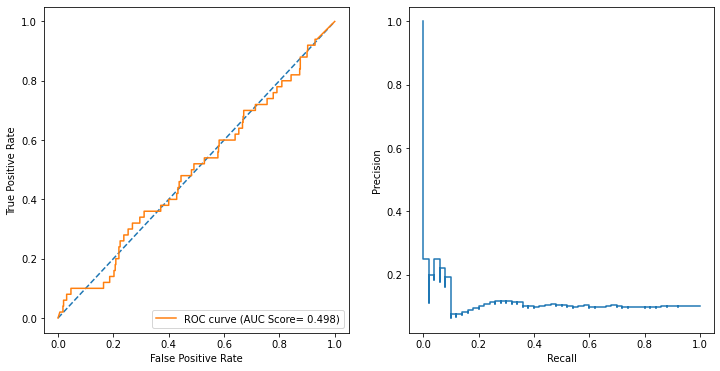

              precision    recall  f1-score   support

           0      0.904     0.771     0.832       450
           1      0.112     0.260     0.157        50

    accuracy                          0.720       500
   macro avg      0.508     0.516     0.494       500
weighted avg      0.824     0.720     0.765       500



[]

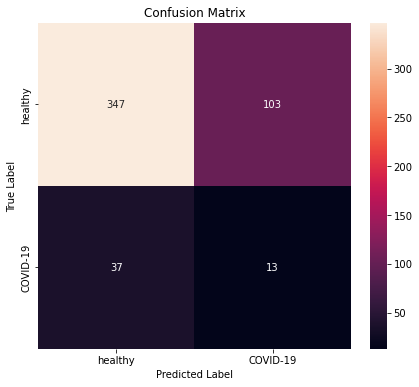

In [35]:
gs_model_1 = grid_src_1.best_estimator_.model
y_test_pred = gs_model_1.predict_classes(X_test).reshape(-1)
y_test_probs = gs_model_1.predict_proba(X_test).reshape(-1)

# ROC and ROC AUC score 
auc_score = roc_auc_score(y_test, y_test_probs)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

prec, recall, _ = precision_recall_curve(y_test, y_test_probs)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

fpr, tpr, _ = roc_curve(y_test, y_test_probs)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

ax1.plot([0,1], [0,1], linestyle='--')
roc_display.plot(ax=ax1, label = f"ROC curve (AUC Score= {round(auc_score, 3)})")
pr_display.plot(ax=ax2)
plt.show()

# CLASSIFICATION REPORT
print(classification_report(y_test, y_test_pred, digits=3))

# CONFUSION MATRIX
conf_mat = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(figsize = (7,6))
sns.heatmap(conf_mat, annot=True, fmt='g')
ax.set_title('Confusion Matrix')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.xaxis.set_ticklabels(['healthy', 'COVID-19'])
ax.yaxis.set_ticklabels(['healthy', 'COVID-19'])
plt.plot() 

Very high training AUC and poor testing - suggests that models are overfitting. Try same thing but with regularisation.

### Fine tuning layer count, kernels and filter dim with regularisation

In [19]:
# 3 hours + to run

param_grid= {
    'n_hidden' : [3, 4],
    'filters' : [24, 32, 40],
    'batch_size' : [16],
    'kernel_size' : [3, 4, 5],
    'kernel_initialiser' : ['he_uniform'],
    'hidden_activation' : ['selu'],
    'final_activation' : ['hard_sigmoid'],
    'optimiser' : ['Adam'],
    'dropout' : [True]  # default: 0.2
}


grid_src_2 = model_selection.GridSearchCV(cnn, param_grid, cv=5, scoring = ['roc_auc', 'recall'], refit = 'roc_auc', return_train_score=True)
grid_src_2.fit(X_train, y_train, epochs = 100)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 431, 24)       240       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 215, 24)       0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 215, 24)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 215, 24)       5208      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 107, 24)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 107, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 107, 24)        5

Epoch 24/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.6770 - AUC: 0.5969
Epoch 25/100
1600/1600 [==============================] - 1s 434us/sample - loss: 0.6826 - AUC: 0.5823
Epoch 26/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.6731 - AUC: 0.6139
Epoch 27/100
1600/1600 [==============================] - 1s 434us/sample - loss: 0.6809 - AUC: 0.5872
Epoch 28/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.6755 - AUC: 0.6034
Epoch 29/100
1600/1600 [==============================] - 1s 437us/sample - loss: 0.6763 - AUC: 0.5969
Epoch 30/100
1600/1600 [==============================] - 1s 435us/sample - loss: 0.6737 - AUC: 0.6092
Epoch 31/100
1600/1600 [==============================] - 1s 435us/sample - loss: 0.6701 - AUC: 0.6186
Epoch 32/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.6664 - AUC: 0.6314
Epoch 33/100
1600/1600 [==============================] - 1s 436us/sample

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.8179 - AUC: 0.4966
Epoch 2/100
1600/1600 [==============================] - 1s 435us/sample - loss: 0.7549 - AUC: 0.5054
Epoch 3/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.7264 - AUC: 0.5205
Epoch 4/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.7290 - AUC: 0.4952
Epoch 5/100
1600/1600 [==============================] - 1s 437us/sample - loss: 0.7180 - AUC: 0.5150
Epoch 6/100
1600/1600 [==============================] - 1s 437us/sample - loss: 0.7233 - AUC: 0.5021
Epoch 7/100
1600/1600 [==============================] - 1s 437us/sample - loss: 0.7143 - AUC: 0.5117
Epoch 8/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.7118 - AUC: 0.5282
Epoch 9/100
1600/1600 [==============================] - 1s 437us/sample - loss: 0.7225 - AUC: 0.4919
Epoch 10/100
1600/1600 [==============================] - 1s 437us/sample - loss: 0.7120 - AUC: 

Epoch 42/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.6537 - AUC: 0.6536
Epoch 43/100
1600/1600 [==============================] - 1s 434us/sample - loss: 0.6563 - AUC: 0.6684
Epoch 44/100
1600/1600 [==============================] - 1s 437us/sample - loss: 0.6483 - AUC: 0.6645
Epoch 45/100
1600/1600 [==============================] - 1s 434us/sample - loss: 0.6604 - AUC: 0.6573
Epoch 46/100
1600/1600 [==============================] - 1s 437us/sample - loss: 0.6565 - AUC: 0.6479
Epoch 47/100
1600/1600 [==============================] - 1s 435us/sample - loss: 0.6471 - AUC: 0.6621
Epoch 48/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.6453 - AUC: 0.6624
Epoch 49/100
1600/1600 [==============================] - 1s 432us/sample - loss: 0.6458 - AUC: 0.6666
Epoch 50/100
1600/1600 [==============================] - 1s 435us/sample - loss: 0.6537 - AUC: 0.6566
Epoch 51/100
1600/1600 [==============================] - 1s 433us/sample

1600/1600 [==============================] - 1s 436us/sample - loss: 0.6651 - AUC: 0.6251
Epoch 83/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.6594 - AUC: 0.6372
Epoch 84/100
1600/1600 [==============================] - 1s 438us/sample - loss: 0.6537 - AUC: 0.6505
Epoch 85/100
1600/1600 [==============================] - 1s 438us/sample - loss: 0.6530 - AUC: 0.6456
Epoch 86/100
1600/1600 [==============================] - 1s 435us/sample - loss: 0.6534 - AUC: 0.6510
Epoch 87/100
1600/1600 [==============================] - 1s 437us/sample - loss: 0.6578 - AUC: 0.6456
Epoch 88/100
1600/1600 [==============================] - 1s 433us/sample - loss: 0.6612 - AUC: 0.6364
Epoch 89/100
1600/1600 [==============================] - 1s 438us/sample - loss: 0.6548 - AUC: 0.6478
Epoch 90/100
1600/1600 [==============================] - 1s 437us/sample - loss: 0.6502 - AUC: 0.6551
Epoch 91/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.64

1600/1600 [==============================] - 1s 449us/sample - loss: 0.6841 - AUC: 0.5795
Epoch 41/100
1600/1600 [==============================] - 1s 450us/sample - loss: 0.6814 - AUC: 0.5846
Epoch 42/100
1600/1600 [==============================] - 1s 449us/sample - loss: 0.6777 - AUC: 0.5965
Epoch 43/100
1600/1600 [==============================] - 1s 450us/sample - loss: 0.6790 - AUC: 0.5934
Epoch 44/100
1600/1600 [==============================] - 1s 451us/sample - loss: 0.6760 - AUC: 0.6020
Epoch 45/100
1600/1600 [==============================] - 1s 450us/sample - loss: 0.6763 - AUC: 0.6017
Epoch 46/100
1600/1600 [==============================] - 1s 452us/sample - loss: 0.6723 - AUC: 0.6109
Epoch 47/100
1600/1600 [==============================] - 1s 449us/sample - loss: 0.6775 - AUC: 0.5948
Epoch 48/100
1600/1600 [==============================] - 1s 448us/sample - loss: 0.6742 - AUC: 0.6113
Epoch 49/100
1600/1600 [==============================] - 1s 449us/sample - loss: 0.67

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7243 - AUC: 0.4941
Epoch 2/100
1600/1600 [==============================] - 1s 450us/sample - loss: 0.7196 - AUC: 0.4910
Epoch 3/100
1600/1600 [==============================] - 1s 449us/sample - loss: 0.7093 - AUC: 0.5094
Epoch 4/100
1600/1600 [==============================] - 1s 448us/sample - loss: 0.7108 - AUC: 0.4948
Epoch 5/100
1600/1600 [==============================] - 1s 448us/sample - loss: 0.7039 - AUC: 0.5148
Epoch 6/100
1600/1600 [==============================] - 1s 449us/sample - loss: 0.7059 - AUC: 0.5039
Epoch 7/100
1600/1600 [==============================] - 1s 450us/sample - loss: 0.7085 - AUC: 0.4928
Epoch 8/100
1600/1600 [==============================] - 1s 448us/sample - loss: 0.6992 - AUC: 0.5141
Epoch 9/100
1600/1600 [==============================] - 1s 447us/sample - loss: 0.7055 - AUC: 0.4991
Epoch 10/100
1600/1600 [==============================] - 1s 449us/sample - loss: 0.7040 - AUC: 

1600/1600 [==============================] - 1s 447us/sample - loss: 0.6954 - AUC: 0.5257
Epoch 39/100
1600/1600 [==============================] - 1s 446us/sample - loss: 0.6891 - AUC: 0.5598
Epoch 40/100
1600/1600 [==============================] - 1s 444us/sample - loss: 0.6931 - AUC: 0.5564
Epoch 41/100
1600/1600 [==============================] - 1s 445us/sample - loss: 0.6874 - AUC: 0.5702
Epoch 42/100
1600/1600 [==============================] - 1s 447us/sample - loss: 0.6917 - AUC: 0.5579
Epoch 43/100
1600/1600 [==============================] - 1s 444us/sample - loss: 0.6869 - AUC: 0.5680
Epoch 44/100
1600/1600 [==============================] - 1s 444us/sample - loss: 0.6821 - AUC: 0.5869
Epoch 45/100
1600/1600 [==============================] - 1s 446us/sample - loss: 0.6827 - AUC: 0.5815
Epoch 46/100
1600/1600 [==============================] - 1s 443us/sample - loss: 0.6796 - AUC: 0.6032
Epoch 47/100
1600/1600 [==============================] - 1s 446us/sample - loss: 0.69

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.8333 - AUC: 0.4952
Epoch 2/100
1600/1600 [==============================] - 1s 449us/sample - loss: 0.7412 - AUC: 0.4929
Epoch 3/100
1600/1600 [==============================] - 1s 449us/sample - loss: 0.7270 - AUC: 0.4968
Epoch 4/100
1600/1600 [==============================] - 1s 449us/sample - loss: 0.7230 - AUC: 0.4914
Epoch 5/100
1600/1600 [==============================] - 1s 448us/sample - loss: 0.7162 - AUC: 0.5020
Epoch 6/100
1600/1600 [==============================] - 1s 449us/sample - loss: 0.7168 - AUC: 0.4908
Epoch 7/100
1600/1600 [==============================] - 1s 450us/sample - loss: 0.7161 - AUC: 0.4904
Epoch 8/100
1600/1600 [==============================] - 1s 448us/sample - loss: 0.7089 - AUC: 0.5098
Epoch 9/100
1600/1600 [==============================] - 1s 451us/sample - loss: 0.7021 - AUC: 0.5213
Epoch 10/100
1600/1600 [==============================] - 1s 450us/sample - loss: 0.7096 - AUC: 

1600/1600 [==============================] - 1s 444us/sample - loss: 0.6949 - AUC: 0.5332
Epoch 39/100
1600/1600 [==============================] - 1s 445us/sample - loss: 0.6947 - AUC: 0.5315
Epoch 40/100
1600/1600 [==============================] - 1s 445us/sample - loss: 0.6940 - AUC: 0.5309
Epoch 41/100
1600/1600 [==============================] - 1s 442us/sample - loss: 0.6926 - AUC: 0.5432
Epoch 42/100
1600/1600 [==============================] - 1s 445us/sample - loss: 0.6904 - AUC: 0.5539
Epoch 43/100
1600/1600 [==============================] - 1s 445us/sample - loss: 0.6928 - AUC: 0.5424
Epoch 44/100
1600/1600 [==============================] - 1s 442us/sample - loss: 0.7006 - AUC: 0.5093
Epoch 45/100
1600/1600 [==============================] - 1s 444us/sample - loss: 0.6951 - AUC: 0.5321
Epoch 46/100
1600/1600 [==============================] - 1s 446us/sample - loss: 0.6927 - AUC: 0.5447
Epoch 47/100
1600/1600 [==============================] - 1s 444us/sample - loss: 0.69

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7364 - AUC: 0.4732
Epoch 2/100
1600/1600 [==============================] - 1s 471us/sample - loss: 0.7054 - AUC: 0.5327
Epoch 3/100
1600/1600 [==============================] - 1s 471us/sample - loss: 0.7093 - AUC: 0.4998
Epoch 4/100
1600/1600 [==============================] - 1s 467us/sample - loss: 0.7035 - AUC: 0.5054
Epoch 5/100
1600/1600 [==============================] - 1s 467us/sample - loss: 0.7009 - AUC: 0.5113
Epoch 6/100
1600/1600 [==============================] - 1s 468us/sample - loss: 0.7063 - AUC: 0.5002
Epoch 7/100
1600/1600 [==============================] - 1s 467us/sample - loss: 0.7049 - AUC: 0.4949
Epoch 8/100
1600/1600 [==============================] - 1s 469us/sample - loss: 0.6939 - AUC: 0.5467
Epoch 9/100
1600/1600 [==============================] - 1s 469us/sample - loss: 0.6991 - AUC: 0.5240
Epoch 10/100
1600/1600 [==============================] - 1s 470us/sample - loss: 0.7013 - AUC: 

Epoch 42/100
1600/1600 [==============================] - 1s 468us/sample - loss: 0.6569 - AUC: 0.6492
Epoch 43/100
1600/1600 [==============================] - 1s 467us/sample - loss: 0.6628 - AUC: 0.6266
Epoch 44/100
1600/1600 [==============================] - 1s 466us/sample - loss: 0.6640 - AUC: 0.6261
Epoch 45/100
1600/1600 [==============================] - 1s 467us/sample - loss: 0.6761 - AUC: 0.5934
Epoch 46/100
1600/1600 [==============================] - 1s 468us/sample - loss: 0.6637 - AUC: 0.6235
Epoch 47/100
1600/1600 [==============================] - 1s 467us/sample - loss: 0.6510 - AUC: 0.6495
Epoch 48/100
1600/1600 [==============================] - 1s 468us/sample - loss: 0.6592 - AUC: 0.6314
Epoch 49/100
1600/1600 [==============================] - 1s 467us/sample - loss: 0.6559 - AUC: 0.6398
Epoch 50/100
1600/1600 [==============================] - 1s 468us/sample - loss: 0.6523 - AUC: 0.6469
Epoch 51/100
1600/1600 [==============================] - 1s 469us/sample

1600/1600 [==============================] - 1s 468us/sample - loss: 0.6310 - AUC: 0.6922
Epoch 83/100
1600/1600 [==============================] - 1s 468us/sample - loss: 0.6247 - AUC: 0.7042
Epoch 84/100
1600/1600 [==============================] - 1s 468us/sample - loss: 0.6205 - AUC: 0.7126
Epoch 85/100
1600/1600 [==============================] - 1s 469us/sample - loss: 0.6324 - AUC: 0.6924
Epoch 86/100
1600/1600 [==============================] - 1s 467us/sample - loss: 0.6246 - AUC: 0.6945
Epoch 87/100
1600/1600 [==============================] - 1s 467us/sample - loss: 0.6226 - AUC: 0.7024
Epoch 88/100
1600/1600 [==============================] - 1s 468us/sample - loss: 0.6257 - AUC: 0.7121
Epoch 89/100
1600/1600 [==============================] - 1s 468us/sample - loss: 0.6216 - AUC: 0.7007
Epoch 90/100
1600/1600 [==============================] - 1s 471us/sample - loss: 0.6263 - AUC: 0.6969
Epoch 91/100
1600/1600 [==============================] - 1s 467us/sample - loss: 0.61

Epoch 44/100
1600/1600 [==============================] - 1s 463us/sample - loss: 0.6611 - AUC: 0.6401
Epoch 45/100
1600/1600 [==============================] - 1s 464us/sample - loss: 0.6486 - AUC: 0.6609
Epoch 46/100
1600/1600 [==============================] - 1s 461us/sample - loss: 0.6478 - AUC: 0.6626
Epoch 47/100
1600/1600 [==============================] - 1s 462us/sample - loss: 0.6566 - AUC: 0.6508
Epoch 48/100
1600/1600 [==============================] - 1s 464us/sample - loss: 0.6504 - AUC: 0.6586
Epoch 49/100
1600/1600 [==============================] - 1s 463us/sample - loss: 0.6535 - AUC: 0.6453
Epoch 50/100
1600/1600 [==============================] - 1s 464us/sample - loss: 0.6493 - AUC: 0.6545
Epoch 51/100
1600/1600 [==============================] - 1s 465us/sample - loss: 0.6575 - AUC: 0.6457
Epoch 52/100
1600/1600 [==============================] - 1s 466us/sample - loss: 0.6561 - AUC: 0.6423
Epoch 53/100
1600/1600 [==============================] - 1s 463us/sample

1600/1600 [==============================] - 1s 467us/sample - loss: 0.6057 - AUC: 0.7212
Epoch 85/100
1600/1600 [==============================] - 1s 467us/sample - loss: 0.6159 - AUC: 0.7174
Epoch 86/100
1600/1600 [==============================] - 1s 470us/sample - loss: 0.5972 - AUC: 0.7326
Epoch 87/100
1600/1600 [==============================] - 1s 467us/sample - loss: 0.6096 - AUC: 0.7217
Epoch 88/100
1600/1600 [==============================] - 1s 467us/sample - loss: 0.6255 - AUC: 0.7066
Epoch 89/100
1600/1600 [==============================] - 1s 469us/sample - loss: 0.6107 - AUC: 0.7205
Epoch 90/100
1600/1600 [==============================] - 1s 471us/sample - loss: 0.6036 - AUC: 0.7244
Epoch 91/100
1600/1600 [==============================] - 1s 465us/sample - loss: 0.6048 - AUC: 0.7244
Epoch 92/100
1600/1600 [==============================] - 1s 469us/sample - loss: 0.5986 - AUC: 0.7292
Epoch 93/100
1600/1600 [==============================] - 1s 471us/sample - loss: 0.59

1600/1600 [==============================] - 1s 492us/sample - loss: 0.6782 - AUC: 0.6016
Epoch 43/100
1600/1600 [==============================] - 1s 490us/sample - loss: 0.6809 - AUC: 0.5820
Epoch 44/100
1600/1600 [==============================] - 1s 489us/sample - loss: 0.6753 - AUC: 0.5961
Epoch 45/100
1600/1600 [==============================] - 1s 492us/sample - loss: 0.6771 - AUC: 0.5896
Epoch 46/100
1600/1600 [==============================] - 1s 491us/sample - loss: 0.6774 - AUC: 0.6026
Epoch 47/100
1600/1600 [==============================] - 1s 491us/sample - loss: 0.6815 - AUC: 0.5828
Epoch 48/100
1600/1600 [==============================] - 1s 489us/sample - loss: 0.6755 - AUC: 0.6012
Epoch 49/100
1600/1600 [==============================] - 1s 491us/sample - loss: 0.6759 - AUC: 0.5988
Epoch 50/100
1600/1600 [==============================] - 1s 489us/sample - loss: 0.6704 - AUC: 0.6050
Epoch 51/100
1600/1600 [==============================] - 1s 491us/sample - loss: 0.66

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7717 - AUC: 0.5061
Epoch 2/100
1600/1600 [==============================] - 1s 486us/sample - loss: 0.7044 - AUC: 0.5048
Epoch 3/100
1600/1600 [==============================] - 1s 485us/sample - loss: 0.7077 - AUC: 0.4902
Epoch 4/100
1600/1600 [==============================] - 1s 486us/sample - loss: 0.7029 - AUC: 0.5020
Epoch 5/100
1600/1600 [==============================] - 1s 486us/sample - loss: 0.7077 - AUC: 0.4886
Epoch 6/100
1600/1600 [==============================] - 1s 485us/sample - loss: 0.6986 - AUC: 0.5153
Epoch 7/100
1600/1600 [==============================] - 1s 486us/sample - loss: 0.7015 - AUC: 0.4985
Epoch 8/100
1600/1600 [==============================] - 1s 484us/sample - loss: 0.7029 - AUC: 0.5080
Epoch 9/100
1600/1600 [==============================] - 1s 487us/sample - loss: 0.6974 - AUC: 0.5215
Epoch 10/100
1600/1600 [==============================] - 1s 487us/sample - loss: 0.7053 - AUC: 

1600/1600 [==============================] - 1s 501us/sample - loss: 0.6892 - AUC: 0.5510
Epoch 39/100
1600/1600 [==============================] - 1s 506us/sample - loss: 0.6911 - AUC: 0.5504
Epoch 40/100
1600/1600 [==============================] - 1s 500us/sample - loss: 0.6965 - AUC: 0.5198
Epoch 41/100
1600/1600 [==============================] - 1s 507us/sample - loss: 0.6898 - AUC: 0.5550
Epoch 42/100
1600/1600 [==============================] - 1s 501us/sample - loss: 0.6883 - AUC: 0.5577
Epoch 43/100
1600/1600 [==============================] - 1s 515us/sample - loss: 0.6886 - AUC: 0.5575
Epoch 44/100
1600/1600 [==============================] - 1s 505us/sample - loss: 0.6877 - AUC: 0.5607
Epoch 45/100
1600/1600 [==============================] - 1s 507us/sample - loss: 0.6848 - AUC: 0.5773
Epoch 46/100
1600/1600 [==============================] - 1s 505us/sample - loss: 0.6856 - AUC: 0.5758
Epoch 47/100
1600/1600 [==============================] - 1s 501us/sample - loss: 0.68

1600/1600 [==============================] - 2s 2ms/sample - loss: 0.7477 - AUC: 0.5057
Epoch 2/100
1600/1600 [==============================] - 1s 503us/sample - loss: 0.7121 - AUC: 0.4997
Epoch 3/100
1600/1600 [==============================] - 1s 500us/sample - loss: 0.7093 - AUC: 0.4880
Epoch 4/100
1600/1600 [==============================] - 1s 503us/sample - loss: 0.7046 - AUC: 0.5056
Epoch 5/100
1600/1600 [==============================] - 1s 499us/sample - loss: 0.7046 - AUC: 0.5013
Epoch 6/100
1600/1600 [==============================] - 1s 498us/sample - loss: 0.7009 - AUC: 0.5023
Epoch 7/100
1600/1600 [==============================] - 1s 504us/sample - loss: 0.7026 - AUC: 0.5049
Epoch 8/100
1600/1600 [==============================] - 1s 501us/sample - loss: 0.7042 - AUC: 0.4884
Epoch 9/100
1600/1600 [==============================] - 1s 504us/sample - loss: 0.6979 - AUC: 0.5145
Epoch 10/100
1600/1600 [==============================] - 1s 502us/sample - loss: 0.7015 - AUC: 

1600/1600 [==============================] - 1s 499us/sample - loss: 0.6826 - AUC: 0.5878
Epoch 39/100
1600/1600 [==============================] - 1s 504us/sample - loss: 0.6817 - AUC: 0.5871
Epoch 40/100
1600/1600 [==============================] - 1s 496us/sample - loss: 0.6759 - AUC: 0.6032
Epoch 41/100
1600/1600 [==============================] - 1s 496us/sample - loss: 0.6789 - AUC: 0.5961
Epoch 42/100
1600/1600 [==============================] - 1s 500us/sample - loss: 0.6810 - AUC: 0.5921
Epoch 43/100
1600/1600 [==============================] - 1s 501us/sample - loss: 0.6817 - AUC: 0.5890
Epoch 44/100
1600/1600 [==============================] - 1s 500us/sample - loss: 0.6802 - AUC: 0.5901
Epoch 45/100
1600/1600 [==============================] - 1s 501us/sample - loss: 0.6805 - AUC: 0.5946
Epoch 46/100
1600/1600 [==============================] - 1s 500us/sample - loss: 0.6711 - AUC: 0.6178
Epoch 47/100
1600/1600 [==============================] - 1s 497us/sample - loss: 0.67

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7551 - AUC: 0.4950
Epoch 2/100
1600/1600 [==============================] - 1s 493us/sample - loss: 0.7161 - AUC: 0.4935
Epoch 3/100
1600/1600 [==============================] - 1s 490us/sample - loss: 0.7119 - AUC: 0.5004
Epoch 4/100
1600/1600 [==============================] - 1s 487us/sample - loss: 0.7035 - AUC: 0.5182
Epoch 5/100
1600/1600 [==============================] - 1s 490us/sample - loss: 0.7075 - AUC: 0.5030
Epoch 6/100
1600/1600 [==============================] - 1s 492us/sample - loss: 0.7018 - AUC: 0.5156
Epoch 7/100
1600/1600 [==============================] - 1s 489us/sample - loss: 0.6972 - AUC: 0.5328
Epoch 8/100
1600/1600 [==============================] - 1s 491us/sample - loss: 0.7059 - AUC: 0.5021
Epoch 9/100
1600/1600 [==============================] - 1s 489us/sample - loss: 0.6962 - AUC: 0.5337
Epoch 10/100
1600/1600 [==============================] - 1s 487us/sample - loss: 0.6970 - AUC: 

Epoch 42/100
1600/1600 [==============================] - 1s 490us/sample - loss: 0.6561 - AUC: 0.6451
Epoch 43/100
1600/1600 [==============================] - 1s 487us/sample - loss: 0.6577 - AUC: 0.6377
Epoch 44/100
1600/1600 [==============================] - 1s 491us/sample - loss: 0.6519 - AUC: 0.6524
Epoch 45/100
1600/1600 [==============================] - 1s 488us/sample - loss: 0.6557 - AUC: 0.6400
Epoch 46/100
1600/1600 [==============================] - 1s 490us/sample - loss: 0.6577 - AUC: 0.6400
Epoch 47/100
1600/1600 [==============================] - 1s 490us/sample - loss: 0.6600 - AUC: 0.6424
Epoch 48/100
1600/1600 [==============================] - 1s 491us/sample - loss: 0.6530 - AUC: 0.6461
Epoch 49/100
1600/1600 [==============================] - 1s 488us/sample - loss: 0.6460 - AUC: 0.6601
Epoch 50/100
1600/1600 [==============================] - 1s 489us/sample - loss: 0.6483 - AUC: 0.6492
Epoch 51/100
1600/1600 [==============================] - 1s 489us/sample

1600/1600 [==============================] - 1s 489us/sample - loss: 0.5878 - AUC: 0.7475
Epoch 83/100
1600/1600 [==============================] - 1s 492us/sample - loss: 0.5937 - AUC: 0.7550
Epoch 84/100
1600/1600 [==============================] - 1s 490us/sample - loss: 0.5698 - AUC: 0.7677
Epoch 85/100
1600/1600 [==============================] - 1s 491us/sample - loss: 0.5746 - AUC: 0.7572
Epoch 86/100
1600/1600 [==============================] - 1s 491us/sample - loss: 0.5755 - AUC: 0.7552
Epoch 87/100
1600/1600 [==============================] - 1s 489us/sample - loss: 0.5849 - AUC: 0.7560
Epoch 88/100
1600/1600 [==============================] - 1s 489us/sample - loss: 0.5570 - AUC: 0.7755
Epoch 89/100
1600/1600 [==============================] - 1s 490us/sample - loss: 0.5760 - AUC: 0.7659
Epoch 90/100
1600/1600 [==============================] - 1s 491us/sample - loss: 0.5670 - AUC: 0.7694
Epoch 91/100
1600/1600 [==============================] - 1s 486us/sample - loss: 0.55

Epoch 44/100
1600/1600 [==============================] - 1s 485us/sample - loss: 0.6500 - AUC: 0.6576
Epoch 45/100
1600/1600 [==============================] - 1s 485us/sample - loss: 0.6511 - AUC: 0.6469
Epoch 46/100
1600/1600 [==============================] - 1s 487us/sample - loss: 0.6445 - AUC: 0.6693
Epoch 47/100
1600/1600 [==============================] - 1s 486us/sample - loss: 0.6410 - AUC: 0.6657
Epoch 48/100
1600/1600 [==============================] - 1s 489us/sample - loss: 0.6493 - AUC: 0.6729
Epoch 49/100
1600/1600 [==============================] - 1s 488us/sample - loss: 0.6446 - AUC: 0.6676
Epoch 50/100
1600/1600 [==============================] - 1s 482us/sample - loss: 0.6373 - AUC: 0.6802
Epoch 51/100
1600/1600 [==============================] - 1s 486us/sample - loss: 0.6359 - AUC: 0.6807
Epoch 52/100
1600/1600 [==============================] - 1s 489us/sample - loss: 0.6266 - AUC: 0.6952
Epoch 53/100
1600/1600 [==============================] - 1s 486us/sample

1600/1600 [==============================] - 1s 486us/sample - loss: 0.5038 - AUC: 0.8285
Epoch 85/100
1600/1600 [==============================] - 1s 485us/sample - loss: 0.5086 - AUC: 0.8255
Epoch 86/100
1600/1600 [==============================] - 1s 485us/sample - loss: 0.4990 - AUC: 0.8271
Epoch 87/100
1600/1600 [==============================] - 1s 487us/sample - loss: 0.4864 - AUC: 0.8399
Epoch 88/100
1600/1600 [==============================] - 1s 485us/sample - loss: 0.4892 - AUC: 0.8355
Epoch 89/100
1600/1600 [==============================] - 1s 484us/sample - loss: 0.4818 - AUC: 0.8429
Epoch 90/100
1600/1600 [==============================] - 1s 485us/sample - loss: 0.4839 - AUC: 0.8444
Epoch 91/100
1600/1600 [==============================] - 1s 484us/sample - loss: 0.5028 - AUC: 0.8447
Epoch 92/100
1600/1600 [==============================] - 1s 488us/sample - loss: 0.4697 - AUC: 0.8552
Epoch 93/100
1600/1600 [==============================] - 1s 488us/sample - loss: 0.46

1600/1600 [==============================] - 1s 525us/sample - loss: 0.6797 - AUC: 0.5898
Epoch 43/100
1600/1600 [==============================] - 1s 519us/sample - loss: 0.6743 - AUC: 0.6024
Epoch 44/100
1600/1600 [==============================] - 1s 523us/sample - loss: 0.6716 - AUC: 0.6178
Epoch 45/100
1600/1600 [==============================] - 1s 519us/sample - loss: 0.6708 - AUC: 0.6074
Epoch 46/100
1600/1600 [==============================] - 1s 518us/sample - loss: 0.6713 - AUC: 0.6206
Epoch 47/100
1600/1600 [==============================] - 1s 521us/sample - loss: 0.6669 - AUC: 0.6244
Epoch 48/100
1600/1600 [==============================] - 1s 518us/sample - loss: 0.6673 - AUC: 0.6112
Epoch 49/100
1600/1600 [==============================] - 1s 523us/sample - loss: 0.6644 - AUC: 0.6234
Epoch 50/100
1600/1600 [==============================] - 1s 519us/sample - loss: 0.6680 - AUC: 0.6080
Epoch 51/100
1600/1600 [==============================] - 1s 519us/sample - loss: 0.66

1600/1600 [==============================] - 2s 2ms/sample - loss: 0.7230 - AUC: 0.4937
Epoch 2/100
1600/1600 [==============================] - 1s 514us/sample - loss: 0.7058 - AUC: 0.5129
Epoch 3/100
1600/1600 [==============================] - 1s 512us/sample - loss: 0.7037 - AUC: 0.5119
Epoch 4/100
1600/1600 [==============================] - 1s 507us/sample - loss: 0.7072 - AUC: 0.5133
Epoch 5/100
1600/1600 [==============================] - 1s 510us/sample - loss: 0.7024 - AUC: 0.5018
Epoch 6/100
1600/1600 [==============================] - 1s 513us/sample - loss: 0.7051 - AUC: 0.4939
Epoch 7/100
1600/1600 [==============================] - 1s 512us/sample - loss: 0.7129 - AUC: 0.4793
Epoch 8/100
1600/1600 [==============================] - 1s 509us/sample - loss: 0.6998 - AUC: 0.5063
Epoch 9/100
1600/1600 [==============================] - 1s 509us/sample - loss: 0.6976 - AUC: 0.5225
Epoch 10/100
1600/1600 [==============================] - 1s 513us/sample - loss: 0.7032 - AUC: 

1600/1600 [==============================] - 1s 513us/sample - loss: 0.6586 - AUC: 0.6432
Epoch 39/100
1600/1600 [==============================] - 1s 513us/sample - loss: 0.6684 - AUC: 0.6441
Epoch 40/100
1600/1600 [==============================] - 1s 514us/sample - loss: 0.6602 - AUC: 0.6378
Epoch 41/100
1600/1600 [==============================] - 1s 511us/sample - loss: 0.6556 - AUC: 0.6505
Epoch 42/100
1600/1600 [==============================] - 1s 512us/sample - loss: 0.7435 - AUC: 0.5290
Epoch 43/100
1600/1600 [==============================] - 1s 512us/sample - loss: 0.7066 - AUC: 0.5311
Epoch 44/100
1600/1600 [==============================] - 1s 515us/sample - loss: 0.6916 - AUC: 0.5553
Epoch 45/100
1600/1600 [==============================] - 1s 513us/sample - loss: 0.6873 - AUC: 0.5642
Epoch 46/100
1600/1600 [==============================] - 1s 515us/sample - loss: 0.6833 - AUC: 0.5828
Epoch 47/100
1600/1600 [==============================] - 1s 512us/sample - loss: 0.67

1600/1600 [==============================] - 2s 2ms/sample - loss: 0.7135 - AUC: 0.4917
Epoch 2/100
1600/1600 [==============================] - 1s 510us/sample - loss: 0.6999 - AUC: 0.5172
Epoch 3/100
1600/1600 [==============================] - 1s 509us/sample - loss: 0.7040 - AUC: 0.4822
Epoch 4/100
1600/1600 [==============================] - 1s 506us/sample - loss: 0.7061 - AUC: 0.4665
Epoch 5/100
1600/1600 [==============================] - 1s 514us/sample - loss: 0.6959 - AUC: 0.5156
Epoch 6/100
1600/1600 [==============================] - 1s 509us/sample - loss: 0.6983 - AUC: 0.5064
Epoch 7/100
1600/1600 [==============================] - 1s 510us/sample - loss: 0.6996 - AUC: 0.5040
Epoch 8/100
1600/1600 [==============================] - 1s 507us/sample - loss: 0.6997 - AUC: 0.5086
Epoch 9/100
1600/1600 [==============================] - 1s 510us/sample - loss: 0.6988 - AUC: 0.5253
Epoch 10/100
1600/1600 [==============================] - 1s 511us/sample - loss: 0.6972 - AUC: 

1600/1600 [==============================] - 1s 508us/sample - loss: 0.6838 - AUC: 0.5787
Epoch 39/100
1600/1600 [==============================] - 1s 510us/sample - loss: 0.6814 - AUC: 0.5861
Epoch 40/100
1600/1600 [==============================] - 1s 510us/sample - loss: 0.6788 - AUC: 0.5901
Epoch 41/100
1600/1600 [==============================] - 1s 510us/sample - loss: 0.6756 - AUC: 0.5971
Epoch 42/100
1600/1600 [==============================] - 1s 509us/sample - loss: 0.6781 - AUC: 0.5967
Epoch 43/100
1600/1600 [==============================] - 1s 508us/sample - loss: 0.6777 - AUC: 0.5977
Epoch 44/100
1600/1600 [==============================] - 1s 507us/sample - loss: 0.6743 - AUC: 0.6062
Epoch 45/100
1600/1600 [==============================] - 1s 509us/sample - loss: 0.6723 - AUC: 0.6201
Epoch 46/100
1600/1600 [==============================] - 1s 509us/sample - loss: 0.6781 - AUC: 0.5968
Epoch 47/100
1600/1600 [==============================] - 1s 507us/sample - loss: 0.67

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7569 - AUC: 0.4881
Epoch 2/100
1600/1600 [==============================] - 1s 534us/sample - loss: 0.7280 - AUC: 0.4903
Epoch 3/100
1600/1600 [==============================] - 1s 536us/sample - loss: 0.7152 - AUC: 0.5131
Epoch 4/100
1600/1600 [==============================] - 1s 532us/sample - loss: 0.7150 - AUC: 0.5026
Epoch 5/100
1600/1600 [==============================] - 1s 533us/sample - loss: 0.7209 - AUC: 0.4775
Epoch 6/100
1600/1600 [==============================] - 1s 536us/sample - loss: 0.7029 - AUC: 0.5235
Epoch 7/100
1600/1600 [==============================] - 1s 535us/sample - loss: 0.7147 - AUC: 0.4934
Epoch 8/100
1600/1600 [==============================] - 1s 535us/sample - loss: 0.7034 - AUC: 0.5185
Epoch 9/100
1600/1600 [==============================] - 1s 535us/sample - loss: 0.7084 - AUC: 0.5085
Epoch 10/100
1600/1600 [==============================] - 1s 533us/sample - loss: 0.7151 - AUC: 

Epoch 42/100
1600/1600 [==============================] - 1s 536us/sample - loss: 0.6552 - AUC: 0.6396
Epoch 43/100
1600/1600 [==============================] - 1s 537us/sample - loss: 0.6560 - AUC: 0.6474
Epoch 44/100
1600/1600 [==============================] - 1s 537us/sample - loss: 0.6496 - AUC: 0.6543
Epoch 45/100
1600/1600 [==============================] - 1s 536us/sample - loss: 0.6497 - AUC: 0.6578
Epoch 46/100
1600/1600 [==============================] - 1s 535us/sample - loss: 0.6497 - AUC: 0.6575
Epoch 47/100
1600/1600 [==============================] - 1s 535us/sample - loss: 0.6511 - AUC: 0.6469
Epoch 48/100
1600/1600 [==============================] - 1s 535us/sample - loss: 0.6492 - AUC: 0.6549
Epoch 49/100
1600/1600 [==============================] - 1s 535us/sample - loss: 0.6468 - AUC: 0.6613
Epoch 50/100
1600/1600 [==============================] - 1s 536us/sample - loss: 0.6420 - AUC: 0.6706
Epoch 51/100
1600/1600 [==============================] - 1s 537us/sample

1600/1600 [==============================] - 1s 530us/sample - loss: 0.6574 - AUC: 0.6499
Epoch 83/100
1600/1600 [==============================] - 1s 530us/sample - loss: 0.6612 - AUC: 0.6508
Epoch 84/100
1600/1600 [==============================] - 1s 530us/sample - loss: 0.6485 - AUC: 0.6587
Epoch 85/100
1600/1600 [==============================] - 1s 530us/sample - loss: 0.6589 - AUC: 0.6546
Epoch 86/100
1600/1600 [==============================] - 1s 530us/sample - loss: 0.6472 - AUC: 0.6584
Epoch 87/100
1600/1600 [==============================] - 1s 529us/sample - loss: 0.6461 - AUC: 0.6567
Epoch 88/100
1600/1600 [==============================] - 1s 531us/sample - loss: 0.6442 - AUC: 0.6622
Epoch 89/100
1600/1600 [==============================] - 1s 534us/sample - loss: 0.6472 - AUC: 0.6541
Epoch 90/100
1600/1600 [==============================] - 1s 533us/sample - loss: 0.6460 - AUC: 0.6706
Epoch 91/100
1600/1600 [==============================] - 1s 533us/sample - loss: 0.64

Epoch 44/100
1600/1600 [==============================] - 1s 527us/sample - loss: 0.6422 - AUC: 0.6653
Epoch 45/100
1600/1600 [==============================] - 1s 525us/sample - loss: 0.6454 - AUC: 0.6665
Epoch 46/100
1600/1600 [==============================] - 1s 526us/sample - loss: 0.6400 - AUC: 0.6679
Epoch 47/100
1600/1600 [==============================] - 1s 528us/sample - loss: 0.6494 - AUC: 0.6626
Epoch 48/100
1600/1600 [==============================] - 1s 528us/sample - loss: 0.6500 - AUC: 0.6584
Epoch 49/100
1600/1600 [==============================] - 1s 530us/sample - loss: 0.6357 - AUC: 0.6758
Epoch 50/100
1600/1600 [==============================] - 1s 528us/sample - loss: 0.6352 - AUC: 0.6967
Epoch 51/100
1600/1600 [==============================] - 1s 528us/sample - loss: 0.6356 - AUC: 0.6841
Epoch 52/100
1600/1600 [==============================] - 1s 533us/sample - loss: 0.6539 - AUC: 0.6770
Epoch 53/100
1600/1600 [==============================] - 1s 530us/sample

1600/1600 [==============================] - 1s 527us/sample - loss: 0.6313 - AUC: 0.6861
Epoch 85/100
1600/1600 [==============================] - 1s 528us/sample - loss: 0.6301 - AUC: 0.6875
Epoch 86/100
1600/1600 [==============================] - 1s 532us/sample - loss: 0.6291 - AUC: 0.6982
Epoch 87/100
1600/1600 [==============================] - 1s 530us/sample - loss: 0.6226 - AUC: 0.6906
Epoch 88/100
1600/1600 [==============================] - 1s 529us/sample - loss: 0.6111 - AUC: 0.7087
Epoch 89/100
1600/1600 [==============================] - 1s 534us/sample - loss: 0.6223 - AUC: 0.6976
Epoch 90/100
1600/1600 [==============================] - 1s 531us/sample - loss: 0.6148 - AUC: 0.7120
Epoch 91/100
1600/1600 [==============================] - 1s 531us/sample - loss: 0.6216 - AUC: 0.7001
Epoch 92/100
1600/1600 [==============================] - 1s 530us/sample - loss: 0.6155 - AUC: 0.7079
Epoch 93/100
1600/1600 [==============================] - 1s 535us/sample - loss: 0.62

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7458 - AUC: 0.4999
Epoch 2/100
1600/1600 [==============================] - 1s 551us/sample - loss: 0.7274 - AUC: 0.4770
Epoch 3/100
1600/1600 [==============================] - 1s 551us/sample - loss: 0.7215 - AUC: 0.4877
Epoch 4/100
1600/1600 [==============================] - 1s 552us/sample - loss: 0.7120 - AUC: 0.5017
Epoch 5/100
1600/1600 [==============================] - 1s 555us/sample - loss: 0.7072 - AUC: 0.5092
Epoch 6/100
1600/1600 [==============================] - 1s 553us/sample - loss: 0.6992 - AUC: 0.5311
Epoch 7/100
1600/1600 [==============================] - 1s 550us/sample - loss: 0.7038 - AUC: 0.5128
Epoch 8/100
1600/1600 [==============================] - 1s 552us/sample - loss: 0.7037 - AUC: 0.5111
Epoch 9/100
1600/1600 [==============================] - 1s 549us/sample - loss: 0.7033 - AUC: 0.5106
Epoch 10/100
1600/1600 [==============================] - 1s 553us/sample - loss: 0.7036 - AUC: 

1600/1600 [==============================] - 1s 551us/sample - loss: 0.6898 - AUC: 0.5686
Epoch 39/100
1600/1600 [==============================] - 1s 553us/sample - loss: 0.6881 - AUC: 0.5667
Epoch 40/100
1600/1600 [==============================] - 1s 552us/sample - loss: 0.6762 - AUC: 0.6084
Epoch 41/100
1600/1600 [==============================] - 1s 553us/sample - loss: 0.6905 - AUC: 0.5655
Epoch 42/100
1600/1600 [==============================] - 1s 554us/sample - loss: 0.6890 - AUC: 0.5722
Epoch 43/100
1600/1600 [==============================] - 1s 558us/sample - loss: 0.6892 - AUC: 0.5773
Epoch 44/100
1600/1600 [==============================] - 1s 556us/sample - loss: 0.6819 - AUC: 0.5825
Epoch 45/100
1600/1600 [==============================] - 1s 554us/sample - loss: 0.6810 - AUC: 0.5981
Epoch 46/100
1600/1600 [==============================] - 1s 555us/sample - loss: 0.6892 - AUC: 0.5681
Epoch 47/100
1600/1600 [==============================] - 1s 554us/sample - loss: 0.67

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7572 - AUC: 0.5197
Epoch 2/100
1600/1600 [==============================] - 1s 544us/sample - loss: 0.7271 - AUC: 0.4863
Epoch 3/100
1600/1600 [==============================] - 1s 546us/sample - loss: 0.7186 - AUC: 0.4920
Epoch 4/100
1600/1600 [==============================] - 1s 544us/sample - loss: 0.7078 - AUC: 0.5009
Epoch 5/100
1600/1600 [==============================] - 1s 542us/sample - loss: 0.7136 - AUC: 0.4829
Epoch 6/100
1600/1600 [==============================] - 1s 545us/sample - loss: 0.7003 - AUC: 0.5194
Epoch 7/100
1600/1600 [==============================] - 1s 545us/sample - loss: 0.7002 - AUC: 0.5132
Epoch 8/100
1600/1600 [==============================] - 1s 545us/sample - loss: 0.7023 - AUC: 0.5087
Epoch 9/100
1600/1600 [==============================] - 1s 546us/sample - loss: 0.7076 - AUC: 0.4866
Epoch 10/100
1600/1600 [==============================] - 1s 544us/sample - loss: 0.7048 - AUC: 

1600/1600 [==============================] - 1s 551us/sample - loss: 0.6902 - AUC: 0.5479
Epoch 39/100
1600/1600 [==============================] - 1s 554us/sample - loss: 0.6881 - AUC: 0.5664
Epoch 40/100
1600/1600 [==============================] - 1s 553us/sample - loss: 0.6806 - AUC: 0.5821
Epoch 41/100
1600/1600 [==============================] - 1s 551us/sample - loss: 0.6787 - AUC: 0.5924
Epoch 42/100
1600/1600 [==============================] - 1s 551us/sample - loss: 0.6753 - AUC: 0.5999
Epoch 43/100
1600/1600 [==============================] - 1s 551us/sample - loss: 0.6755 - AUC: 0.6036
Epoch 44/100
1600/1600 [==============================] - 1s 555us/sample - loss: 0.6789 - AUC: 0.6006
Epoch 45/100
1600/1600 [==============================] - 1s 551us/sample - loss: 0.6835 - AUC: 0.5845
Epoch 46/100
1600/1600 [==============================] - 1s 553us/sample - loss: 0.6768 - AUC: 0.5989
Epoch 47/100
1600/1600 [==============================] - 1s 553us/sample - loss: 0.67

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7376 - AUC: 0.5042
Epoch 2/100
1600/1600 [==============================] - 1s 579us/sample - loss: 0.7198 - AUC: 0.4714
Epoch 3/100
1600/1600 [==============================] - 1s 571us/sample - loss: 0.7120 - AUC: 0.4929
Epoch 4/100
1600/1600 [==============================] - 1s 571us/sample - loss: 0.7037 - AUC: 0.5129
Epoch 5/100
1600/1600 [==============================] - 1s 572us/sample - loss: 0.7036 - AUC: 0.5140
Epoch 6/100
1600/1600 [==============================] - 1s 574us/sample - loss: 0.7042 - AUC: 0.5051
Epoch 7/100
1600/1600 [==============================] - 1s 576us/sample - loss: 0.6967 - AUC: 0.5298
Epoch 8/100
1600/1600 [==============================] - 1s 573us/sample - loss: 0.6968 - AUC: 0.5346
Epoch 9/100
1600/1600 [==============================] - 1s 570us/sample - loss: 0.7033 - AUC: 0.5148
Epoch 10/100
1600/1600 [==============================] - 1s 573us/sample - loss: 0.6978 - AUC: 

Epoch 42/100
1600/1600 [==============================] - 1s 568us/sample - loss: 0.6453 - AUC: 0.6598
Epoch 43/100
1600/1600 [==============================] - 1s 571us/sample - loss: 0.6506 - AUC: 0.6670
Epoch 44/100
1600/1600 [==============================] - 1s 568us/sample - loss: 0.6396 - AUC: 0.6673
Epoch 45/100
1600/1600 [==============================] - 1s 573us/sample - loss: 0.6482 - AUC: 0.6539
Epoch 46/100
1600/1600 [==============================] - 1s 573us/sample - loss: 0.6412 - AUC: 0.6628
Epoch 47/100
1600/1600 [==============================] - 1s 570us/sample - loss: 0.6457 - AUC: 0.6575
Epoch 48/100
1600/1600 [==============================] - 1s 573us/sample - loss: 0.6423 - AUC: 0.6627
Epoch 49/100
1600/1600 [==============================] - 1s 572us/sample - loss: 0.6371 - AUC: 0.6748
Epoch 50/100
1600/1600 [==============================] - 1s 570us/sample - loss: 0.6418 - AUC: 0.6661
Epoch 51/100
1600/1600 [==============================] - 1s 570us/sample

1600/1600 [==============================] - 1s 570us/sample - loss: 0.6187 - AUC: 0.7044
Epoch 83/100
1600/1600 [==============================] - 1s 570us/sample - loss: 0.6177 - AUC: 0.7082
Epoch 84/100
1600/1600 [==============================] - 1s 568us/sample - loss: 0.6192 - AUC: 0.7053
Epoch 85/100
1600/1600 [==============================] - 1s 571us/sample - loss: 0.6151 - AUC: 0.7163
Epoch 86/100
1600/1600 [==============================] - 1s 572us/sample - loss: 0.6154 - AUC: 0.7087
Epoch 87/100
1600/1600 [==============================] - 1s 574us/sample - loss: 0.6119 - AUC: 0.7102
Epoch 88/100
1600/1600 [==============================] - 1s 570us/sample - loss: 0.6067 - AUC: 0.7232
Epoch 89/100
1600/1600 [==============================] - 1s 570us/sample - loss: 0.6109 - AUC: 0.7150
Epoch 90/100
1600/1600 [==============================] - 1s 568us/sample - loss: 0.6168 - AUC: 0.7105
Epoch 91/100
1600/1600 [==============================] - 1s 573us/sample - loss: 0.60

Epoch 44/100
1600/1600 [==============================] - 1s 569us/sample - loss: 0.6345 - AUC: 0.6766
Epoch 45/100
1600/1600 [==============================] - 1s 571us/sample - loss: 0.6409 - AUC: 0.6830
Epoch 46/100
1600/1600 [==============================] - 1s 571us/sample - loss: 0.6374 - AUC: 0.6747
Epoch 47/100
1600/1600 [==============================] - 1s 572us/sample - loss: 0.6365 - AUC: 0.6785
Epoch 48/100
1600/1600 [==============================] - 1s 573us/sample - loss: 0.6227 - AUC: 0.7030
Epoch 49/100
1600/1600 [==============================] - 1s 570us/sample - loss: 0.6312 - AUC: 0.6893
Epoch 50/100
1600/1600 [==============================] - 1s 572us/sample - loss: 0.6217 - AUC: 0.7068
Epoch 51/100
1600/1600 [==============================] - 1s 569us/sample - loss: 0.6250 - AUC: 0.6957
Epoch 52/100
1600/1600 [==============================] - 1s 571us/sample - loss: 0.6246 - AUC: 0.6964
Epoch 53/100
1600/1600 [==============================] - 1s 569us/sample

1600/1600 [==============================] - 1s 567us/sample - loss: 0.6445 - AUC: 0.6630
Epoch 85/100
1600/1600 [==============================] - 1s 568us/sample - loss: 0.6377 - AUC: 0.6720
Epoch 86/100
1600/1600 [==============================] - 1s 571us/sample - loss: 0.6371 - AUC: 0.6732
Epoch 87/100
1600/1600 [==============================] - 1s 571us/sample - loss: 0.6408 - AUC: 0.6674
Epoch 88/100
1600/1600 [==============================] - 1s 572us/sample - loss: 0.6392 - AUC: 0.6706
Epoch 89/100
1600/1600 [==============================] - 1s 568us/sample - loss: 0.6384 - AUC: 0.6720
Epoch 90/100
1600/1600 [==============================] - 1s 568us/sample - loss: 0.6247 - AUC: 0.6970
Epoch 91/100
1600/1600 [==============================] - 1s 569us/sample - loss: 0.6412 - AUC: 0.6832
Epoch 92/100
1600/1600 [==============================] - 1s 569us/sample - loss: 0.6331 - AUC: 0.6824
Epoch 93/100
1600/1600 [==============================] - 1s 570us/sample - loss: 0.62

1600/1600 [==============================] - 1s 598us/sample - loss: 0.6893 - AUC: 0.5700
Epoch 43/100
1600/1600 [==============================] - 1s 594us/sample - loss: 0.6838 - AUC: 0.5788
Epoch 44/100
1600/1600 [==============================] - 1s 596us/sample - loss: 0.6859 - AUC: 0.5797
Epoch 45/100
1600/1600 [==============================] - 1s 597us/sample - loss: 0.6793 - AUC: 0.5926
Epoch 46/100
1600/1600 [==============================] - 1s 596us/sample - loss: 0.6736 - AUC: 0.6120
Epoch 47/100
1600/1600 [==============================] - 1s 596us/sample - loss: 0.6773 - AUC: 0.5923
Epoch 48/100
1600/1600 [==============================] - 1s 598us/sample - loss: 0.6664 - AUC: 0.6270
Epoch 49/100
1600/1600 [==============================] - 1s 596us/sample - loss: 0.6713 - AUC: 0.6070
Epoch 50/100
1600/1600 [==============================] - 1s 594us/sample - loss: 0.6697 - AUC: 0.6154
Epoch 51/100
1600/1600 [==============================] - 1s 595us/sample - loss: 0.66

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7336 - AUC: 0.4935
Epoch 2/100
1600/1600 [==============================] - 1s 601us/sample - loss: 0.7131 - AUC: 0.4918
Epoch 3/100
1600/1600 [==============================] - 1s 601us/sample - loss: 0.7191 - AUC: 0.4727
Epoch 4/100
1600/1600 [==============================] - 1s 598us/sample - loss: 0.7171 - AUC: 0.4762
Epoch 5/100
1600/1600 [==============================] - 1s 598us/sample - loss: 0.7058 - AUC: 0.5021
Epoch 6/100
1600/1600 [==============================] - 1s 596us/sample - loss: 0.7052 - AUC: 0.5077
Epoch 7/100
1600/1600 [==============================] - 1s 595us/sample - loss: 0.7036 - AUC: 0.5036
Epoch 8/100
1600/1600 [==============================] - 1s 597us/sample - loss: 0.7024 - AUC: 0.5052
Epoch 9/100
1600/1600 [==============================] - 1s 599us/sample - loss: 0.7047 - AUC: 0.5033
Epoch 10/100
1600/1600 [==============================] - 1s 602us/sample - loss: 0.7086 - AUC: 

1600/1600 [==============================] - 1s 596us/sample - loss: 0.6688 - AUC: 0.6182
Epoch 39/100
1600/1600 [==============================] - 1s 594us/sample - loss: 0.6674 - AUC: 0.6279
Epoch 40/100
1600/1600 [==============================] - 1s 595us/sample - loss: 0.6663 - AUC: 0.6326
Epoch 41/100
1600/1600 [==============================] - 1s 596us/sample - loss: 0.6651 - AUC: 0.6292
Epoch 42/100
1600/1600 [==============================] - 1s 599us/sample - loss: 0.6568 - AUC: 0.6475
Epoch 43/100
1600/1600 [==============================] - 1s 596us/sample - loss: 0.6670 - AUC: 0.6326
Epoch 44/100
1600/1600 [==============================] - 1s 597us/sample - loss: 0.6579 - AUC: 0.6519
Epoch 45/100
1600/1600 [==============================] - 1s 596us/sample - loss: 0.6645 - AUC: 0.6341
Epoch 46/100
1600/1600 [==============================] - 1s 596us/sample - loss: 0.6574 - AUC: 0.6501
Epoch 47/100
1600/1600 [==============================] - 1s 597us/sample - loss: 0.65

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.8447 - AUC: 0.4684
Epoch 2/100
1600/1600 [==============================] - 1s 596us/sample - loss: 0.7282 - AUC: 0.5030
Epoch 3/100
1600/1600 [==============================] - 1s 598us/sample - loss: 0.7180 - AUC: 0.5067
Epoch 4/100
1600/1600 [==============================] - 1s 596us/sample - loss: 0.7081 - AUC: 0.5318
Epoch 5/100
1600/1600 [==============================] - 1s 595us/sample - loss: 0.7190 - AUC: 0.4914
Epoch 6/100
1600/1600 [==============================] - 1s 595us/sample - loss: 0.7166 - AUC: 0.4906
Epoch 7/100
1600/1600 [==============================] - 1s 596us/sample - loss: 0.6986 - AUC: 0.5295
Epoch 8/100
1600/1600 [==============================] - 1s 596us/sample - loss: 0.7055 - AUC: 0.5018
Epoch 9/100
1600/1600 [==============================] - 1s 593us/sample - loss: 0.7045 - AUC: 0.5029
Epoch 10/100
1600/1600 [==============================] - 1s 599us/sample - loss: 0.7055 - AUC: 

1600/1600 [==============================] - 1s 598us/sample - loss: 0.6832 - AUC: 0.5841
Epoch 38/100
1600/1600 [==============================] - 1s 596us/sample - loss: 0.6747 - AUC: 0.6053
Epoch 39/100
1600/1600 [==============================] - 1s 601us/sample - loss: 0.6771 - AUC: 0.6009
Epoch 40/100
1600/1600 [==============================] - 1s 600us/sample - loss: 0.6789 - AUC: 0.5934
Epoch 41/100
1600/1600 [==============================] - 1s 600us/sample - loss: 0.6750 - AUC: 0.6036
Epoch 42/100
1600/1600 [==============================] - 1s 599us/sample - loss: 0.6768 - AUC: 0.5993
Epoch 43/100
1600/1600 [==============================] - 1s 594us/sample - loss: 0.6792 - AUC: 0.5908
Epoch 44/100
1600/1600 [==============================] - 1s 601us/sample - loss: 0.6741 - AUC: 0.6176
Epoch 45/100
1600/1600 [==============================] - 1s 596us/sample - loss: 0.6756 - AUC: 0.6050
Epoch 46/100
1600/1600 [==============================] - 1s 595us/sample - loss: 0.66

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7543 - AUC: 0.5328
Epoch 2/100
1600/1600 [==============================] - 1s 579us/sample - loss: 0.7169 - AUC: 0.4853
Epoch 3/100
1600/1600 [==============================] - 1s 582us/sample - loss: 0.7053 - AUC: 0.5076
Epoch 4/100
1600/1600 [==============================] - 1s 582us/sample - loss: 0.7091 - AUC: 0.5017
Epoch 5/100
1600/1600 [==============================] - 1s 581us/sample - loss: 0.7041 - AUC: 0.5033
Epoch 6/100
1600/1600 [==============================] - 1s 579us/sample - loss: 0.6986 - AUC: 0.5268
Epoch 7/100
1600/1600 [==============================] - 1s 579us/sample - loss: 0.7015 - AUC: 0.5159
Epoch 8/100
1600/1600 [==============================] - 1s 582us/sample - loss: 0.7018 - AUC: 0.5135
Epoch 9/100
1600/1600 [==============================] - 1s 579us/sample - loss: 0.6958 - AUC: 0.5411
Epoch 10/100
1600/1600 [==============================] - 1s 581us/sample - loss: 0.6946 - AUC: 

Epoch 42/100
1600/1600 [==============================] - 1s 583us/sample - loss: 0.6265 - AUC: 0.6874
Epoch 43/100
1600/1600 [==============================] - 1s 579us/sample - loss: 0.6284 - AUC: 0.6898
Epoch 44/100
1600/1600 [==============================] - 1s 580us/sample - loss: 0.6343 - AUC: 0.6729
Epoch 45/100
1600/1600 [==============================] - 1s 581us/sample - loss: 0.6209 - AUC: 0.6960
Epoch 46/100
1600/1600 [==============================] - 1s 580us/sample - loss: 0.6282 - AUC: 0.6851
Epoch 47/100
1600/1600 [==============================] - 1s 579us/sample - loss: 0.6267 - AUC: 0.6996
Epoch 48/100
1600/1600 [==============================] - 1s 583us/sample - loss: 0.6224 - AUC: 0.6932
Epoch 49/100
1600/1600 [==============================] - 1s 582us/sample - loss: 0.6156 - AUC: 0.6997
Epoch 50/100
1600/1600 [==============================] - 1s 581us/sample - loss: 0.6135 - AUC: 0.7070
Epoch 51/100
1600/1600 [==============================] - 1s 584us/sample

1600/1600 [==============================] - 1s 586us/sample - loss: 0.5252 - AUC: 0.8028
Epoch 83/100
1600/1600 [==============================] - 1s 585us/sample - loss: 0.5135 - AUC: 0.8148
Epoch 84/100
1600/1600 [==============================] - 1s 583us/sample - loss: 0.5156 - AUC: 0.8120
Epoch 85/100
1600/1600 [==============================] - 1s 583us/sample - loss: 0.5064 - AUC: 0.8235
Epoch 86/100
1600/1600 [==============================] - 1s 586us/sample - loss: 0.5172 - AUC: 0.8107
Epoch 87/100
1600/1600 [==============================] - 1s 587us/sample - loss: 0.5082 - AUC: 0.8181
Epoch 88/100
1600/1600 [==============================] - 1s 585us/sample - loss: 0.5082 - AUC: 0.8165
Epoch 89/100
1600/1600 [==============================] - 1s 583us/sample - loss: 0.4885 - AUC: 0.8409
Epoch 90/100
1600/1600 [==============================] - 1s 586us/sample - loss: 0.5001 - AUC: 0.8347
Epoch 91/100
1600/1600 [==============================] - 1s 583us/sample - loss: 0.49

Epoch 44/100
1600/1600 [==============================] - 1s 579us/sample - loss: 0.6192 - AUC: 0.7074
Epoch 45/100
1600/1600 [==============================] - 1s 582us/sample - loss: 0.6147 - AUC: 0.7135
Epoch 46/100
1600/1600 [==============================] - 1s 580us/sample - loss: 0.6141 - AUC: 0.7053
Epoch 47/100
1600/1600 [==============================] - 1s 580us/sample - loss: 0.6080 - AUC: 0.7211
Epoch 48/100
1600/1600 [==============================] - 1s 578us/sample - loss: 0.6035 - AUC: 0.7241
Epoch 49/100
1600/1600 [==============================] - 1s 579us/sample - loss: 0.5997 - AUC: 0.7275
Epoch 50/100
1600/1600 [==============================] - 1s 581us/sample - loss: 0.5982 - AUC: 0.7317
Epoch 51/100
1600/1600 [==============================] - 1s 580us/sample - loss: 0.5981 - AUC: 0.7446
Epoch 52/100
1600/1600 [==============================] - 1s 582us/sample - loss: 0.6108 - AUC: 0.7233
Epoch 53/100
1600/1600 [==============================] - 1s 580us/sample

1600/1600 [==============================] - 1s 577us/sample - loss: 0.5224 - AUC: 0.8128
Epoch 85/100
1600/1600 [==============================] - 1s 576us/sample - loss: 0.5146 - AUC: 0.8130
Epoch 86/100
1600/1600 [==============================] - 1s 574us/sample - loss: 0.5277 - AUC: 0.8141
Epoch 87/100
1600/1600 [==============================] - 1s 578us/sample - loss: 0.5072 - AUC: 0.8203
Epoch 88/100
1600/1600 [==============================] - 1s 579us/sample - loss: 0.5232 - AUC: 0.8193
Epoch 89/100
1600/1600 [==============================] - 1s 577us/sample - loss: 0.5013 - AUC: 0.8243
Epoch 90/100
1600/1600 [==============================] - 1s 575us/sample - loss: 0.4968 - AUC: 0.8280
Epoch 91/100
1600/1600 [==============================] - 1s 576us/sample - loss: 0.5012 - AUC: 0.8247
Epoch 92/100
1600/1600 [==============================] - 1s 578us/sample - loss: 0.4919 - AUC: 0.8311
Epoch 93/100
1600/1600 [==============================] - 1s 576us/sample - loss: 0.50

1600/1600 [==============================] - 1s 607us/sample - loss: 0.6737 - AUC: 0.5992
Epoch 43/100
1600/1600 [==============================] - 1s 606us/sample - loss: 0.6686 - AUC: 0.6143
Epoch 44/100
1600/1600 [==============================] - 1s 609us/sample - loss: 0.6747 - AUC: 0.5964
Epoch 45/100
1600/1600 [==============================] - 1s 604us/sample - loss: 0.6673 - AUC: 0.6150
Epoch 46/100
1600/1600 [==============================] - 1s 607us/sample - loss: 0.6679 - AUC: 0.6148
Epoch 47/100
1600/1600 [==============================] - 1s 610us/sample - loss: 0.6667 - AUC: 0.6231
Epoch 48/100
1600/1600 [==============================] - 1s 610us/sample - loss: 0.6574 - AUC: 0.6468
Epoch 49/100
1600/1600 [==============================] - 1s 607us/sample - loss: 0.6687 - AUC: 0.6151
Epoch 50/100
1600/1600 [==============================] - 1s 605us/sample - loss: 0.6601 - AUC: 0.6308
Epoch 51/100
1600/1600 [==============================] - 1s 611us/sample - loss: 0.65

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7155 - AUC: 0.4926
Epoch 2/100
1600/1600 [==============================] - 1s 606us/sample - loss: 0.6996 - AUC: 0.5214
Epoch 3/100
1600/1600 [==============================] - 1s 610us/sample - loss: 0.7050 - AUC: 0.4973
Epoch 4/100
1600/1600 [==============================] - 1s 609us/sample - loss: 0.7022 - AUC: 0.5051
Epoch 5/100
1600/1600 [==============================] - 1s 608us/sample - loss: 0.6959 - AUC: 0.5232
Epoch 6/100
1600/1600 [==============================] - 1s 608us/sample - loss: 0.6965 - AUC: 0.5305
Epoch 7/100
1600/1600 [==============================] - 1s 611us/sample - loss: 0.6977 - AUC: 0.5252
Epoch 8/100
1600/1600 [==============================] - 1s 606us/sample - loss: 0.6942 - AUC: 0.5336
Epoch 9/100
1600/1600 [==============================] - 1s 608us/sample - loss: 0.6875 - AUC: 0.5666
Epoch 10/100
1600/1600 [==============================] - 1s 611us/sample - loss: 0.6923 - AUC: 

1600/1600 [==============================] - 1s 604us/sample - loss: 0.6563 - AUC: 0.6435
Epoch 39/100
1600/1600 [==============================] - 1s 605us/sample - loss: 0.6519 - AUC: 0.6611
Epoch 40/100
1600/1600 [==============================] - 1s 608us/sample - loss: 0.6476 - AUC: 0.6618
Epoch 41/100
1600/1600 [==============================] - 1s 608us/sample - loss: 0.6426 - AUC: 0.6684
Epoch 42/100
1600/1600 [==============================] - 1s 606us/sample - loss: 0.6415 - AUC: 0.6770
Epoch 43/100
1600/1600 [==============================] - 1s 610us/sample - loss: 0.6382 - AUC: 0.6742
Epoch 44/100
1600/1600 [==============================] - 1s 608us/sample - loss: 0.6522 - AUC: 0.6565
Epoch 45/100
1600/1600 [==============================] - 1s 609us/sample - loss: 0.6427 - AUC: 0.6657
Epoch 46/100
1600/1600 [==============================] - 1s 609us/sample - loss: 0.6371 - AUC: 0.6842
Epoch 47/100
1600/1600 [==============================] - 1s 609us/sample - loss: 0.64

1600/1600 [==============================] - 2s 2ms/sample - loss: 0.7291 - AUC: 0.4890
Epoch 2/100
1600/1600 [==============================] - 1s 612us/sample - loss: 0.7142 - AUC: 0.4709
Epoch 3/100
1600/1600 [==============================] - 1s 608us/sample - loss: 0.7062 - AUC: 0.5125
Epoch 4/100
1600/1600 [==============================] - 1s 611us/sample - loss: 0.7082 - AUC: 0.4962
Epoch 5/100
1600/1600 [==============================] - 1s 611us/sample - loss: 0.7038 - AUC: 0.5002
Epoch 6/100
1600/1600 [==============================] - 1s 609us/sample - loss: 0.6984 - AUC: 0.5268
Epoch 7/100
1600/1600 [==============================] - 1s 611us/sample - loss: 0.6959 - AUC: 0.5364
Epoch 8/100
1600/1600 [==============================] - 1s 605us/sample - loss: 0.6981 - AUC: 0.5278
Epoch 9/100
1600/1600 [==============================] - 1s 605us/sample - loss: 0.6981 - AUC: 0.5261
Epoch 10/100
1600/1600 [==============================] - 1s 606us/sample - loss: 0.6927 - AUC: 

1600/1600 [==============================] - 1s 610us/sample - loss: 0.6559 - AUC: 0.6445
Epoch 39/100
1600/1600 [==============================] - 1s 608us/sample - loss: 0.6550 - AUC: 0.6498
Epoch 40/100
1600/1600 [==============================] - 1s 605us/sample - loss: 0.6484 - AUC: 0.6600
Epoch 41/100
1600/1600 [==============================] - 1s 611us/sample - loss: 0.6569 - AUC: 0.6486
Epoch 42/100
1600/1600 [==============================] - 1s 605us/sample - loss: 0.6490 - AUC: 0.6647
Epoch 43/100
1600/1600 [==============================] - 1s 609us/sample - loss: 0.6514 - AUC: 0.6536
Epoch 44/100
1600/1600 [==============================] - 1s 609us/sample - loss: 0.6498 - AUC: 0.6524
Epoch 45/100
1600/1600 [==============================] - 1s 605us/sample - loss: 0.6520 - AUC: 0.6525
Epoch 46/100
1600/1600 [==============================] - 1s 604us/sample - loss: 0.6471 - AUC: 0.6613
Epoch 47/100
1600/1600 [==============================] - 1s 605us/sample - loss: 0.64

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7759 - AUC: 0.5139
Epoch 2/100
1600/1600 [==============================] - 1s 628us/sample - loss: 0.7296 - AUC: 0.5050
Epoch 3/100
1600/1600 [==============================] - 1s 632us/sample - loss: 0.7170 - AUC: 0.5193
Epoch 4/100
1600/1600 [==============================] - 1s 629us/sample - loss: 0.7219 - AUC: 0.4885
Epoch 5/100
1600/1600 [==============================] - 1s 627us/sample - loss: 0.7162 - AUC: 0.5031
Epoch 6/100
1600/1600 [==============================] - 1s 631us/sample - loss: 0.7150 - AUC: 0.5042
Epoch 7/100
1600/1600 [==============================] - 1s 628us/sample - loss: 0.7164 - AUC: 0.4873
Epoch 8/100
1600/1600 [==============================] - 1s 633us/sample - loss: 0.7137 - AUC: 0.5034
Epoch 9/100
1600/1600 [==============================] - 1s 625us/sample - loss: 0.7056 - AUC: 0.5131
Epoch 10/100
1600/1600 [==============================] - 1s 631us/sample - loss: 0.7064 - AUC: 

Epoch 42/100
1600/1600 [==============================] - 1s 627us/sample - loss: 0.6519 - AUC: 0.6483
Epoch 43/100
1600/1600 [==============================] - 1s 627us/sample - loss: 0.6549 - AUC: 0.6462
Epoch 44/100
1600/1600 [==============================] - 1s 624us/sample - loss: 0.6512 - AUC: 0.6462
Epoch 45/100
1600/1600 [==============================] - 1s 630us/sample - loss: 0.6546 - AUC: 0.6429
Epoch 46/100
1600/1600 [==============================] - 1s 630us/sample - loss: 0.6537 - AUC: 0.6503
Epoch 47/100
1600/1600 [==============================] - 1s 626us/sample - loss: 0.6542 - AUC: 0.6465
Epoch 48/100
1600/1600 [==============================] - 1s 624us/sample - loss: 0.6524 - AUC: 0.6399
Epoch 49/100
1600/1600 [==============================] - 1s 631us/sample - loss: 0.6429 - AUC: 0.6625
Epoch 50/100
1600/1600 [==============================] - 1s 627us/sample - loss: 0.6503 - AUC: 0.6576
Epoch 51/100
1600/1600 [==============================] - 1s 628us/sample

1600/1600 [==============================] - 1s 633us/sample - loss: 0.6042 - AUC: 0.7249
Epoch 83/100
1600/1600 [==============================] - 1s 630us/sample - loss: 0.5969 - AUC: 0.7350
Epoch 84/100
1600/1600 [==============================] - 1s 626us/sample - loss: 0.5946 - AUC: 0.7375
Epoch 85/100
1600/1600 [==============================] - 1s 632us/sample - loss: 0.6013 - AUC: 0.7338
Epoch 86/100
1600/1600 [==============================] - 1s 630us/sample - loss: 0.6052 - AUC: 0.7312
Epoch 87/100
1600/1600 [==============================] - 1s 629us/sample - loss: 0.6445 - AUC: 0.6937
Epoch 88/100
1600/1600 [==============================] - 1s 636us/sample - loss: 0.6247 - AUC: 0.6957
Epoch 89/100
1600/1600 [==============================] - 1s 633us/sample - loss: 0.6264 - AUC: 0.7012
Epoch 90/100
1600/1600 [==============================] - 1s 630us/sample - loss: 0.6459 - AUC: 0.6880
Epoch 91/100
1600/1600 [==============================] - 1s 630us/sample - loss: 0.63

Epoch 44/100
1600/1600 [==============================] - 1s 633us/sample - loss: 0.6545 - AUC: 0.6500
Epoch 45/100
1600/1600 [==============================] - 1s 631us/sample - loss: 0.6560 - AUC: 0.6449
Epoch 46/100
1600/1600 [==============================] - 1s 635us/sample - loss: 0.6657 - AUC: 0.6263
Epoch 47/100
1600/1600 [==============================] - 1s 630us/sample - loss: 0.6507 - AUC: 0.6535
Epoch 48/100
1600/1600 [==============================] - 1s 632us/sample - loss: 0.6485 - AUC: 0.6622
Epoch 49/100
1600/1600 [==============================] - 1s 630us/sample - loss: 0.6495 - AUC: 0.6541
Epoch 50/100
1600/1600 [==============================] - 1s 632us/sample - loss: 0.6434 - AUC: 0.6854
Epoch 51/100
1600/1600 [==============================] - 1s 633us/sample - loss: 0.6482 - AUC: 0.6654
Epoch 52/100
1600/1600 [==============================] - 1s 630us/sample - loss: 0.6449 - AUC: 0.6723
Epoch 53/100
1600/1600 [==============================] - 1s 631us/sample

1600/1600 [==============================] - 1s 625us/sample - loss: 0.6399 - AUC: 0.6873
Epoch 85/100
1600/1600 [==============================] - 1s 629us/sample - loss: 0.6305 - AUC: 0.6944
Epoch 86/100
1600/1600 [==============================] - 1s 624us/sample - loss: 0.6592 - AUC: 0.6543
Epoch 87/100
1600/1600 [==============================] - 1s 626us/sample - loss: 0.6218 - AUC: 0.7071
Epoch 88/100
1600/1600 [==============================] - 1s 624us/sample - loss: 0.6250 - AUC: 0.6872
Epoch 89/100
1600/1600 [==============================] - 1s 625us/sample - loss: 0.6276 - AUC: 0.6863
Epoch 90/100
1600/1600 [==============================] - 1s 626us/sample - loss: 0.6293 - AUC: 0.6960
Epoch 91/100
1600/1600 [==============================] - 1s 622us/sample - loss: 0.6362 - AUC: 0.6830
Epoch 92/100
1600/1600 [==============================] - 1s 626us/sample - loss: 0.6204 - AUC: 0.7027
Epoch 93/100
1600/1600 [==============================] - 1s 626us/sample - loss: 0.61

1600/1600 [==============================] - 2s 2ms/sample - loss: 0.7568 - AUC: 0.5194
Epoch 2/100
1600/1600 [==============================] - 1s 653us/sample - loss: 0.7253 - AUC: 0.5159
Epoch 3/100
1600/1600 [==============================] - 1s 650us/sample - loss: 0.7282 - AUC: 0.4771
Epoch 4/100
1600/1600 [==============================] - 1s 652us/sample - loss: 0.7160 - AUC: 0.4892
Epoch 5/100
1600/1600 [==============================] - 1s 653us/sample - loss: 0.7175 - AUC: 0.4797
Epoch 6/100
1600/1600 [==============================] - 1s 651us/sample - loss: 0.7088 - AUC: 0.5098
Epoch 7/100
1600/1600 [==============================] - 1s 653us/sample - loss: 0.7110 - AUC: 0.4895
Epoch 8/100
1600/1600 [==============================] - 1s 656us/sample - loss: 0.7030 - AUC: 0.5086
Epoch 9/100
1600/1600 [==============================] - 1s 655us/sample - loss: 0.7043 - AUC: 0.5166
Epoch 10/100
1600/1600 [==============================] - 1s 657us/sample - loss: 0.6978 - AUC: 

1600/1600 [==============================] - 1s 651us/sample - loss: 0.6836 - AUC: 0.5840
Epoch 39/100
1600/1600 [==============================] - 1s 653us/sample - loss: 0.6894 - AUC: 0.5632
Epoch 40/100
1600/1600 [==============================] - 1s 651us/sample - loss: 0.6913 - AUC: 0.5643
Epoch 41/100
1600/1600 [==============================] - 1s 653us/sample - loss: 0.6823 - AUC: 0.5891
Epoch 42/100
1600/1600 [==============================] - 1s 654us/sample - loss: 0.6784 - AUC: 0.5955
Epoch 43/100
1600/1600 [==============================] - 1s 652us/sample - loss: 0.6781 - AUC: 0.5983
Epoch 44/100
1600/1600 [==============================] - 1s 653us/sample - loss: 0.6752 - AUC: 0.6092
Epoch 45/100
1600/1600 [==============================] - 1s 653us/sample - loss: 0.6875 - AUC: 0.5785
Epoch 46/100
1600/1600 [==============================] - 1s 651us/sample - loss: 0.6766 - AUC: 0.5945
Epoch 47/100
1600/1600 [==============================] - 1s 651us/sample - loss: 0.67

1600/1600 [==============================] - 2s 2ms/sample - loss: 0.7299 - AUC: 0.4887
Epoch 2/100
1600/1600 [==============================] - 1s 650us/sample - loss: 0.7141 - AUC: 0.4923
Epoch 3/100
1600/1600 [==============================] - 1s 651us/sample - loss: 0.7072 - AUC: 0.5037
Epoch 4/100
1600/1600 [==============================] - 1s 653us/sample - loss: 0.7058 - AUC: 0.5110
Epoch 5/100
1600/1600 [==============================] - 1s 652us/sample - loss: 0.7055 - AUC: 0.5108
Epoch 6/100
1600/1600 [==============================] - 1s 653us/sample - loss: 0.7094 - AUC: 0.4879
Epoch 7/100
1600/1600 [==============================] - 1s 650us/sample - loss: 0.7035 - AUC: 0.5062
Epoch 8/100
1600/1600 [==============================] - 1s 650us/sample - loss: 0.7018 - AUC: 0.5102
Epoch 9/100
1600/1600 [==============================] - 1s 652us/sample - loss: 0.6982 - AUC: 0.5287
Epoch 10/100
1600/1600 [==============================] - 1s 651us/sample - loss: 0.7061 - AUC: 

1600/1600 [==============================] - 1s 651us/sample - loss: 0.6751 - AUC: 0.6062
Epoch 39/100
1600/1600 [==============================] - 1s 654us/sample - loss: 0.6781 - AUC: 0.6039
Epoch 40/100
1600/1600 [==============================] - 1s 654us/sample - loss: 0.6756 - AUC: 0.6118
Epoch 41/100
1600/1600 [==============================] - 1s 653us/sample - loss: 0.6751 - AUC: 0.6067
Epoch 42/100
1600/1600 [==============================] - 1s 657us/sample - loss: 0.6802 - AUC: 0.5984
Epoch 43/100
1600/1600 [==============================] - 1s 654us/sample - loss: 0.6722 - AUC: 0.6151
Epoch 44/100
1600/1600 [==============================] - 1s 651us/sample - loss: 0.6687 - AUC: 0.6296
Epoch 45/100
1600/1600 [==============================] - 1s 648us/sample - loss: 0.6751 - AUC: 0.6142
Epoch 46/100
1600/1600 [==============================] - 1s 652us/sample - loss: 0.6732 - AUC: 0.6093
Epoch 47/100
1600/1600 [==============================] - 1s 653us/sample - loss: 0.66

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7313 - AUC: 0.5134
Epoch 2/100
1600/1600 [==============================] - 1s 733us/sample - loss: 0.7347 - AUC: 0.4888
Epoch 3/100
1600/1600 [==============================] - 1s 730us/sample - loss: 0.7040 - AUC: 0.5276
Epoch 4/100
1600/1600 [==============================] - 1s 728us/sample - loss: 0.7070 - AUC: 0.5117
Epoch 5/100
1600/1600 [==============================] - 1s 731us/sample - loss: 0.7110 - AUC: 0.5068
Epoch 6/100
1600/1600 [==============================] - 1s 736us/sample - loss: 0.6950 - AUC: 0.5365
Epoch 7/100
1600/1600 [==============================] - 1s 730us/sample - loss: 0.7048 - AUC: 0.5171
Epoch 8/100
1600/1600 [==============================] - 1s 731us/sample - loss: 0.6959 - AUC: 0.5449
Epoch 9/100
1600/1600 [==============================] - 1s 732us/sample - loss: 0.6978 - AUC: 0.5270
Epoch 10/100
1600/1600 [==============================] - 1s 733us/sample - loss: 0.6926 - AUC: 

Epoch 42/100
1600/1600 [==============================] - 1s 729us/sample - loss: 0.6459 - AUC: 0.6563
Epoch 43/100
1600/1600 [==============================] - 1s 728us/sample - loss: 0.6428 - AUC: 0.6644
Epoch 44/100
1600/1600 [==============================] - 1s 731us/sample - loss: 0.6334 - AUC: 0.6771
Epoch 45/100
1600/1600 [==============================] - 1s 730us/sample - loss: 0.6398 - AUC: 0.6686
Epoch 46/100
1600/1600 [==============================] - 1s 725us/sample - loss: 0.6327 - AUC: 0.6755
Epoch 47/100
1600/1600 [==============================] - 1s 728us/sample - loss: 0.6365 - AUC: 0.6700
Epoch 48/100
1600/1600 [==============================] - 1s 724us/sample - loss: 0.6496 - AUC: 0.6541
Epoch 49/100
1600/1600 [==============================] - 1s 726us/sample - loss: 0.6432 - AUC: 0.6790
Epoch 50/100
1600/1600 [==============================] - 1s 727us/sample - loss: 0.6286 - AUC: 0.6857
Epoch 51/100
1600/1600 [==============================] - 1s 730us/sample

1600/1600 [==============================] - 1s 732us/sample - loss: 0.6244 - AUC: 0.7007
Epoch 83/100
1600/1600 [==============================] - 1s 735us/sample - loss: 0.6305 - AUC: 0.6938
Epoch 84/100
1600/1600 [==============================] - 1s 728us/sample - loss: 0.6228 - AUC: 0.7060
Epoch 85/100
1600/1600 [==============================] - 1s 732us/sample - loss: 0.6116 - AUC: 0.7103
Epoch 86/100
1600/1600 [==============================] - 1s 734us/sample - loss: 0.6034 - AUC: 0.7237
Epoch 87/100
1600/1600 [==============================] - 1s 729us/sample - loss: 0.6109 - AUC: 0.7156
Epoch 88/100
1600/1600 [==============================] - 1s 737us/sample - loss: 0.6124 - AUC: 0.7179
Epoch 89/100
1600/1600 [==============================] - 1s 732us/sample - loss: 0.6018 - AUC: 0.7306
Epoch 90/100
1600/1600 [==============================] - 1s 731us/sample - loss: 0.6095 - AUC: 0.7123
Epoch 91/100
1600/1600 [==============================] - 1s 735us/sample - loss: 0.59

1600/1600 [==============================] - 1s 731us/sample - loss: 0.7173 - AUC: 0.5021
Epoch 5/100
1600/1600 [==============================] - 1s 731us/sample - loss: 0.7112 - AUC: 0.5132
Epoch 6/100
1600/1600 [==============================] - 1s 727us/sample - loss: 0.7055 - AUC: 0.5236
Epoch 7/100
1600/1600 [==============================] - 1s 731us/sample - loss: 0.7061 - AUC: 0.5132
Epoch 8/100
1600/1600 [==============================] - 1s 729us/sample - loss: 0.7042 - AUC: 0.5274
Epoch 9/100
1600/1600 [==============================] - 1s 726us/sample - loss: 0.7071 - AUC: 0.5174
Epoch 10/100
1600/1600 [==============================] - 1s 733us/sample - loss: 0.7008 - AUC: 0.5260
Epoch 11/100
1600/1600 [==============================] - 1s 727us/sample - loss: 0.7082 - AUC: 0.5015
Epoch 12/100
1600/1600 [==============================] - 1s 730us/sample - loss: 0.7022 - AUC: 0.5220
Epoch 13/100
1600/1600 [==============================] - 1s 730us/sample - loss: 0.7056 - 

1600/1600 [==============================] - 1s 743us/sample - loss: 0.6701 - AUC: 0.6297
Epoch 42/100
1600/1600 [==============================] - 1s 741us/sample - loss: 0.7063 - AUC: 0.5899
Epoch 43/100
1600/1600 [==============================] - 1s 742us/sample - loss: 0.6730 - AUC: 0.6007
Epoch 44/100
1600/1600 [==============================] - 1s 740us/sample - loss: 0.6631 - AUC: 0.6234
Epoch 45/100
1600/1600 [==============================] - 1s 743us/sample - loss: 0.6552 - AUC: 0.6477
Epoch 46/100
1600/1600 [==============================] - 1s 741us/sample - loss: 0.6572 - AUC: 0.6302
Epoch 47/100
1600/1600 [==============================] - 1s 740us/sample - loss: 0.6546 - AUC: 0.6401
Epoch 48/100
1600/1600 [==============================] - 1s 743us/sample - loss: 0.6544 - AUC: 0.6440
Epoch 49/100
1600/1600 [==============================] - 1s 743us/sample - loss: 0.6651 - AUC: 0.6217
Epoch 50/100
1600/1600 [==============================] - 1s 740us/sample - loss: 0.65

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7195 - AUC: 0.5025
Epoch 2/100
1600/1600 [==============================] - 1s 735us/sample - loss: 0.7073 - AUC: 0.5045
Epoch 3/100
1600/1600 [==============================] - 1s 737us/sample - loss: 0.7153 - AUC: 0.4955
Epoch 4/100
1600/1600 [==============================] - 1s 736us/sample - loss: 0.7005 - AUC: 0.5155
Epoch 5/100
1600/1600 [==============================] - 1s 738us/sample - loss: 0.7021 - AUC: 0.5232
Epoch 6/100
1600/1600 [==============================] - 1s 734us/sample - loss: 0.7053 - AUC: 0.5031
Epoch 7/100
1600/1600 [==============================] - 1s 735us/sample - loss: 0.7063 - AUC: 0.4956
Epoch 8/100
1600/1600 [==============================] - 1s 736us/sample - loss: 0.6948 - AUC: 0.5369
Epoch 9/100
1600/1600 [==============================] - 1s 737us/sample - loss: 0.6980 - AUC: 0.5304
Epoch 10/100
1600/1600 [==============================] - 1s 737us/sample - loss: 0.6946 - AUC: 

1600/1600 [==============================] - 1s 736us/sample - loss: 0.6631 - AUC: 0.6570
Epoch 39/100
1600/1600 [==============================] - 1s 737us/sample - loss: 0.6435 - AUC: 0.6700
Epoch 40/100
1600/1600 [==============================] - 1s 735us/sample - loss: 0.6392 - AUC: 0.6811
Epoch 41/100
1600/1600 [==============================] - 1s 735us/sample - loss: 0.6506 - AUC: 0.6648
Epoch 42/100
1600/1600 [==============================] - 1s 737us/sample - loss: 0.6469 - AUC: 0.6650
Epoch 43/100
1600/1600 [==============================] - 1s 733us/sample - loss: 0.6395 - AUC: 0.6767
Epoch 44/100
1600/1600 [==============================] - 1s 736us/sample - loss: 0.6432 - AUC: 0.6700
Epoch 45/100
1600/1600 [==============================] - 1s 736us/sample - loss: 0.6441 - AUC: 0.6687
Epoch 46/100
1600/1600 [==============================] - 1s 739us/sample - loss: 0.6479 - AUC: 0.6917
Epoch 47/100
1600/1600 [==============================] - 1s 738us/sample - loss: 0.63

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7574 - AUC: 0.5022
Epoch 2/100
1600/1600 [==============================] - 1s 743us/sample - loss: 0.7215 - AUC: 0.4880
Epoch 3/100
1600/1600 [==============================] - 1s 741us/sample - loss: 0.7065 - AUC: 0.5118
Epoch 4/100
1600/1600 [==============================] - 1s 742us/sample - loss: 0.7061 - AUC: 0.4991
Epoch 5/100
1600/1600 [==============================] - 1s 743us/sample - loss: 0.7021 - AUC: 0.5220
Epoch 6/100
1600/1600 [==============================] - 1s 741us/sample - loss: 0.7051 - AUC: 0.5137
Epoch 7/100
1600/1600 [==============================] - 1s 740us/sample - loss: 0.6981 - AUC: 0.5327
Epoch 8/100
1600/1600 [==============================] - 1s 738us/sample - loss: 0.6978 - AUC: 0.5296
Epoch 9/100
1600/1600 [==============================] - 1s 743us/sample - loss: 0.6998 - AUC: 0.5337
Epoch 10/100
1600/1600 [==============================] - 1s 742us/sample - loss: 0.6951 - AUC: 

1600/1600 [==============================] - 1s 760us/sample - loss: 0.6974 - AUC: 0.5319
Epoch 39/100
1600/1600 [==============================] - 1s 757us/sample - loss: 0.6957 - AUC: 0.5366
Epoch 40/100
1600/1600 [==============================] - 1s 758us/sample - loss: 0.6966 - AUC: 0.5310
Epoch 41/100
1600/1600 [==============================] - 1s 763us/sample - loss: 0.7040 - AUC: 0.5033
Epoch 42/100
1600/1600 [==============================] - 1s 761us/sample - loss: 0.6948 - AUC: 0.5398
Epoch 43/100
1600/1600 [==============================] - 1s 760us/sample - loss: 0.6953 - AUC: 0.5402
Epoch 44/100
1600/1600 [==============================] - 1s 761us/sample - loss: 0.7014 - AUC: 0.5152
Epoch 45/100
1600/1600 [==============================] - 1s 760us/sample - loss: 0.6958 - AUC: 0.5351
Epoch 46/100
1600/1600 [==============================] - 1s 761us/sample - loss: 0.6960 - AUC: 0.5352
Epoch 47/100
1600/1600 [==============================] - 1s 761us/sample - loss: 0.69

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7271 - AUC: 0.5018
Epoch 2/100
1600/1600 [==============================] - 1s 717us/sample - loss: 0.7145 - AUC: 0.5022
Epoch 3/100
1600/1600 [==============================] - 1s 723us/sample - loss: 0.7092 - AUC: 0.5078
Epoch 4/100
1600/1600 [==============================] - 1s 724us/sample - loss: 0.7055 - AUC: 0.5138
Epoch 5/100
1600/1600 [==============================] - 1s 720us/sample - loss: 0.7007 - AUC: 0.5301
Epoch 6/100
1600/1600 [==============================] - 1s 720us/sample - loss: 0.7061 - AUC: 0.5103
Epoch 7/100
1600/1600 [==============================] - 1s 723us/sample - loss: 0.7025 - AUC: 0.5265
Epoch 8/100
1600/1600 [==============================] - 1s 721us/sample - loss: 0.6980 - AUC: 0.5245
Epoch 9/100
1600/1600 [==============================] - 1s 717us/sample - loss: 0.6867 - AUC: 0.5728
Epoch 10/100
1600/1600 [==============================] - 1s 720us/sample - loss: 0.6954 - AUC: 

Epoch 42/100
1600/1600 [==============================] - 1s 722us/sample - loss: 0.6007 - AUC: 0.7227
Epoch 43/100
1600/1600 [==============================] - 1s 724us/sample - loss: 0.5932 - AUC: 0.7319
Epoch 44/100
1600/1600 [==============================] - 1s 723us/sample - loss: 0.5954 - AUC: 0.7304
Epoch 45/100
1600/1600 [==============================] - 1s 723us/sample - loss: 0.5959 - AUC: 0.7253
Epoch 46/100
1600/1600 [==============================] - 1s 726us/sample - loss: 0.5864 - AUC: 0.7441
Epoch 47/100
1600/1600 [==============================] - 1s 725us/sample - loss: 0.5822 - AUC: 0.7437
Epoch 48/100
1600/1600 [==============================] - 1s 727us/sample - loss: 0.5835 - AUC: 0.7425
Epoch 49/100
1600/1600 [==============================] - 1s 726us/sample - loss: 0.5822 - AUC: 0.7430
Epoch 50/100
1600/1600 [==============================] - 1s 728us/sample - loss: 0.5827 - AUC: 0.7483
Epoch 51/100
1600/1600 [==============================] - 1s 723us/sample

1600/1600 [==============================] - 1s 724us/sample - loss: 0.6027 - AUC: 0.7304
Epoch 83/100
1600/1600 [==============================] - 1s 722us/sample - loss: 0.6089 - AUC: 0.7299
Epoch 84/100
1600/1600 [==============================] - 1s 721us/sample - loss: 0.5985 - AUC: 0.7350
Epoch 85/100
1600/1600 [==============================] - 1s 726us/sample - loss: 0.6031 - AUC: 0.7337
Epoch 86/100
1600/1600 [==============================] - 1s 721us/sample - loss: 0.6074 - AUC: 0.7415
Epoch 87/100
1600/1600 [==============================] - 1s 726us/sample - loss: 0.5939 - AUC: 0.7336
Epoch 88/100
1600/1600 [==============================] - 1s 720us/sample - loss: 0.6028 - AUC: 0.7350
Epoch 89/100
1600/1600 [==============================] - 1s 720us/sample - loss: 0.5953 - AUC: 0.7355
Epoch 90/100
1600/1600 [==============================] - 1s 723us/sample - loss: 0.5867 - AUC: 0.7444
Epoch 91/100
1600/1600 [==============================] - 1s 720us/sample - loss: 0.59

1600/1600 [==============================] - 1s 726us/sample - loss: 0.7008 - AUC: 0.5195
Epoch 5/100
1600/1600 [==============================] - 1s 727us/sample - loss: 0.7007 - AUC: 0.5229
Epoch 6/100
1600/1600 [==============================] - 1s 724us/sample - loss: 0.6981 - AUC: 0.5293
Epoch 7/100
1600/1600 [==============================] - 1s 726us/sample - loss: 0.6998 - AUC: 0.5343
Epoch 8/100
1600/1600 [==============================] - 1s 728us/sample - loss: 0.6893 - AUC: 0.5656
Epoch 9/100
1600/1600 [==============================] - 1s 726us/sample - loss: 0.6936 - AUC: 0.5547
Epoch 10/100
1600/1600 [==============================] - 1s 723us/sample - loss: 0.6861 - AUC: 0.5789
Epoch 11/100
1600/1600 [==============================] - 1s 725us/sample - loss: 0.6806 - AUC: 0.5939
Epoch 12/100
1600/1600 [==============================] - 1s 727us/sample - loss: 0.6854 - AUC: 0.5771
Epoch 13/100
1600/1600 [==============================] - 1s 730us/sample - loss: 0.6864 - 

1600/1600 [==============================] - 1s 758us/sample - loss: 0.6563 - AUC: 0.6294
Epoch 42/100
1600/1600 [==============================] - 1s 758us/sample - loss: 0.6540 - AUC: 0.6414
Epoch 43/100
1600/1600 [==============================] - 1s 761us/sample - loss: 0.6445 - AUC: 0.6526
Epoch 44/100
1600/1600 [==============================] - 1s 757us/sample - loss: 0.6560 - AUC: 0.6457
Epoch 45/100
1600/1600 [==============================] - 1s 760us/sample - loss: 0.6530 - AUC: 0.6464
Epoch 46/100
1600/1600 [==============================] - 1s 759us/sample - loss: 0.6466 - AUC: 0.6564
Epoch 47/100
1600/1600 [==============================] - 1s 758us/sample - loss: 0.6515 - AUC: 0.6449
Epoch 48/100
1600/1600 [==============================] - 1s 759us/sample - loss: 0.6586 - AUC: 0.6458
Epoch 49/100
1600/1600 [==============================] - 1s 760us/sample - loss: 0.6461 - AUC: 0.6573
Epoch 50/100
1600/1600 [==============================] - 1s 758us/sample - loss: 0.64

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7286 - AUC: 0.4782
Epoch 2/100
1600/1600 [==============================] - 1s 752us/sample - loss: 0.7051 - AUC: 0.5110
Epoch 3/100
1600/1600 [==============================] - 1s 754us/sample - loss: 0.7125 - AUC: 0.4815
Epoch 4/100
1600/1600 [==============================] - 1s 754us/sample - loss: 0.7080 - AUC: 0.4939
Epoch 5/100
1600/1600 [==============================] - 1s 752us/sample - loss: 0.7054 - AUC: 0.5017
Epoch 6/100
1600/1600 [==============================] - 1s 750us/sample - loss: 0.6953 - AUC: 0.5411
Epoch 7/100
1600/1600 [==============================] - 1s 750us/sample - loss: 0.7026 - AUC: 0.5247
Epoch 8/100
1600/1600 [==============================] - 1s 748us/sample - loss: 0.7065 - AUC: 0.4987
Epoch 9/100
1600/1600 [==============================] - 1s 753us/sample - loss: 0.6978 - AUC: 0.5249
Epoch 10/100
1600/1600 [==============================] - 1s 750us/sample - loss: 0.6983 - AUC: 

1600/1600 [==============================] - 1s 763us/sample - loss: 0.6479 - AUC: 0.6641
Epoch 39/100
1600/1600 [==============================] - 1s 752us/sample - loss: 0.6456 - AUC: 0.6607
Epoch 40/100
1600/1600 [==============================] - 1s 757us/sample - loss: 0.6470 - AUC: 0.6597
Epoch 41/100
1600/1600 [==============================] - 1s 763us/sample - loss: 0.6371 - AUC: 0.6753
Epoch 42/100
1600/1600 [==============================] - 1s 758us/sample - loss: 0.6418 - AUC: 0.6705
Epoch 43/100
1600/1600 [==============================] - 1s 751us/sample - loss: 0.6310 - AUC: 0.6872
Epoch 44/100
1600/1600 [==============================] - 1s 754us/sample - loss: 0.6269 - AUC: 0.6943
Epoch 45/100
1600/1600 [==============================] - 1s 753us/sample - loss: 0.6414 - AUC: 0.6839
Epoch 46/100
1600/1600 [==============================] - 1s 754us/sample - loss: 0.6335 - AUC: 0.6866
Epoch 47/100
1600/1600 [==============================] - 1s 750us/sample - loss: 0.63

1600/1600 [==============================] - 3s 2ms/sample - loss: 0.7251 - AUC: 0.5032
Epoch 2/100
1600/1600 [==============================] - 1s 756us/sample - loss: 0.7074 - AUC: 0.5126
Epoch 3/100
1600/1600 [==============================] - 1s 756us/sample - loss: 0.7094 - AUC: 0.5133
Epoch 4/100
1600/1600 [==============================] - 1s 756us/sample - loss: 0.7081 - AUC: 0.5069
Epoch 5/100
1600/1600 [==============================] - 1s 755us/sample - loss: 0.6949 - AUC: 0.5454
Epoch 6/100
1600/1600 [==============================] - 1s 754us/sample - loss: 0.7062 - AUC: 0.5160
Epoch 7/100
1600/1600 [==============================] - 1s 753us/sample - loss: 0.7038 - AUC: 0.5057
Epoch 8/100
1600/1600 [==============================] - 1s 754us/sample - loss: 0.7049 - AUC: 0.5058
Epoch 9/100
1600/1600 [==============================] - 1s 753us/sample - loss: 0.7005 - AUC: 0.5258
Epoch 10/100
1600/1600 [==============================] - 1s 754us/sample - loss: 0.7009 - AUC: 

1600/1600 [==============================] - 1s 758us/sample - loss: 0.6758 - AUC: 0.5990
Epoch 39/100
1600/1600 [==============================] - 1s 760us/sample - loss: 0.6720 - AUC: 0.6096
Epoch 40/100
1600/1600 [==============================] - 1s 762us/sample - loss: 0.6693 - AUC: 0.6105
Epoch 41/100
1600/1600 [==============================] - 1s 756us/sample - loss: 0.6665 - AUC: 0.6255
Epoch 42/100
1600/1600 [==============================] - 1s 757us/sample - loss: 0.6677 - AUC: 0.6173
Epoch 43/100
1600/1600 [==============================] - 1s 754us/sample - loss: 0.6614 - AUC: 0.6287
Epoch 44/100
1600/1600 [==============================] - 1s 759us/sample - loss: 0.6686 - AUC: 0.6152
Epoch 45/100
1600/1600 [==============================] - 1s 755us/sample - loss: 0.6605 - AUC: 0.6334
Epoch 46/100
1600/1600 [==============================] - 1s 759us/sample - loss: 0.6643 - AUC: 0.6286
Epoch 47/100
1600/1600 [==============================] - 1s 758us/sample - loss: 0.66

2000/2000 [==============================] - 3s 1ms/sample - loss: 0.7111 - AUC: 0.5224
Epoch 2/100
2000/2000 [==============================] - 2s 755us/sample - loss: 0.7099 - AUC: 0.5106
Epoch 3/100
2000/2000 [==============================] - 2s 753us/sample - loss: 0.7093 - AUC: 0.5035
Epoch 4/100
2000/2000 [==============================] - 2s 754us/sample - loss: 0.7086 - AUC: 0.5029
Epoch 5/100
2000/2000 [==============================] - 2s 756us/sample - loss: 0.7037 - AUC: 0.5015
Epoch 6/100
2000/2000 [==============================] - 2s 754us/sample - loss: 0.7039 - AUC: 0.5112
Epoch 7/100
2000/2000 [==============================] - 2s 754us/sample - loss: 0.7031 - AUC: 0.5102
Epoch 8/100
2000/2000 [==============================] - 2s 755us/sample - loss: 0.7035 - AUC: 0.4975
Epoch 9/100
2000/2000 [==============================] - 2s 756us/sample - loss: 0.7007 - AUC: 0.5208
Epoch 10/100
2000/2000 [==============================] - 2s 755us/sample - loss: 0.6911 - AUC: 

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001D87E9EF488>,
             param_grid={'batch_size': [16], 'dropout': [True],
                         'filters': [24, 32, 40],
                         'final_activation': ['hard_sigmoid'],
                         'hidden_activation': ['selu'],
                         'kernel_initialiser': ['he_uniform'],
                         'kernel_size': [3, 4, 5], 'n_hidden': [3, 4],
                         'optimiser': ['Adam']},
             scoring='roc_auc')

In [20]:
grid_src_2.best_params_

{'batch_size': 16,
 'dropout': True,
 'filters': 40,
 'final_activation': 'hard_sigmoid',
 'hidden_activation': 'selu',
 'kernel_initialiser': 'he_uniform',
 'kernel_size': 5,
 'n_hidden': 4,
 'optimiser': 'Adam'}

In [ ]:
grid_search_2.cv_results_

### Fine-tuning activation functions

In [29]:
param_grid= {
    'n_hidden' : [4],
    'filters' : [24],
    'batch_size' : [16],
    'kernel_size' : [3],
    'kernel_initialiser' : ['lecun_normal'],
    'hidden_activation' : ['relu', 'elu', 'selu', 'sigmoid','hard_sigmoid'],
    'final_activation' : ['sigmoid','hard_sigmoid'],
    'optimiser' : ['Adam'],
}


grid_src_3 = model_selection.GridSearchCV(cnn, param_grid, cv=5, scoring = ['roc_auc', 'recall'], refit = 'roc_auc', return_train_score=True)
grid_src_3.fit(X_train, y_train, epochs = 100)

Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_372 (Conv2D)          (None, 18, 429, 24)       240       
_________________________________________________________________
max_pooling2d_372 (MaxPoolin (None, 9, 214, 24)        0         
_________________________________________________________________
conv2d_373 (Conv2D)          (None, 9, 214, 24)        5208      
_________________________________________________________________
max_pooling2d_373 (MaxPoolin (None, 4, 107, 24)        0         
_________________________________________________________________
conv2d_374 (Conv2D)          (None, 4, 107, 24)        5208      
_________________________________________________________________
max_pooling2d_374 (MaxPoolin (None, 2, 53, 24)         0         
_________________________________________________________________
conv2d_375 (Conv2D)          (None, 2, 53, 24)       

1600/1600 [==============================] - 1s 351us/sample - loss: 0.5627 - AUC: 0.7825
Epoch 65/100
1600/1600 [==============================] - 1s 349us/sample - loss: 0.5629 - AUC: 0.7790
Epoch 66/100
1600/1600 [==============================] - 1s 349us/sample - loss: 0.5615 - AUC: 0.7799
Epoch 67/100
1600/1600 [==============================] - 1s 348us/sample - loss: 0.5587 - AUC: 0.7838
Epoch 68/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.5565 - AUC: 0.7870
Epoch 69/100
1600/1600 [==============================] - 1s 349us/sample - loss: 0.5541 - AUC: 0.7902
Epoch 70/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.5507 - AUC: 0.7923
Epoch 71/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.5502 - AUC: 0.7949
Epoch 72/100
1600/1600 [==============================] - 1s 347us/sample - loss: 0.5500 - AUC: 0.7940
Epoch 73/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.54

1600/1600 [==============================] - 1s 869us/sample - loss: 0.6929 - AUC: 0.5153
Epoch 2/100
1600/1600 [==============================] - 1s 346us/sample - loss: 0.6932 - AUC: 0.5035
Epoch 3/100
1600/1600 [==============================] - 1s 345us/sample - loss: 0.6919 - AUC: 0.5413
Epoch 4/100
1600/1600 [==============================] - 1s 347us/sample - loss: 0.6924 - AUC: 0.5208
Epoch 5/100
1600/1600 [==============================] - 1s 344us/sample - loss: 0.6914 - AUC: 0.5528
Epoch 6/100
1600/1600 [==============================] - 1s 343us/sample - loss: 0.6909 - AUC: 0.5533
Epoch 7/100
1600/1600 [==============================] - 1s 347us/sample - loss: 0.6903 - AUC: 0.5655
Epoch 8/100
1600/1600 [==============================] - 1s 345us/sample - loss: 0.6899 - AUC: 0.5620
Epoch 9/100
1600/1600 [==============================] - 1s 346us/sample - loss: 0.6889 - AUC: 0.5627
Epoch 10/100
1600/1600 [==============================] - 1s 349us/sample - loss: 0.6876 - AUC

1600/1600 [==============================] - 1s 341us/sample - loss: 0.6159 - AUC: 0.7216
Epoch 44/100
1600/1600 [==============================] - 1s 341us/sample - loss: 0.6166 - AUC: 0.7224
Epoch 45/100
1600/1600 [==============================] - 1s 346us/sample - loss: 0.6152 - AUC: 0.7224
Epoch 46/100
1600/1600 [==============================] - 1s 345us/sample - loss: 0.6096 - AUC: 0.7322
Epoch 47/100
1600/1600 [==============================] - 1s 347us/sample - loss: 0.6076 - AUC: 0.7339
Epoch 48/100
1600/1600 [==============================] - 1s 345us/sample - loss: 0.6072 - AUC: 0.7331
Epoch 49/100
1600/1600 [==============================] - 1s 344us/sample - loss: 0.6068 - AUC: 0.7310
Epoch 50/100
1600/1600 [==============================] - 1s 339us/sample - loss: 0.6043 - AUC: 0.7374
Epoch 51/100
1600/1600 [==============================] - 1s 341us/sample - loss: 0.6038 - AUC: 0.7390
Epoch 52/100
1600/1600 [==============================] - 1s 343us/sample - loss: 0.60

Epoch 6/100
1600/1600 [==============================] - 1s 342us/sample - loss: 0.6895 - AUC: 0.5623
Epoch 7/100
1600/1600 [==============================] - 1s 342us/sample - loss: 0.6897 - AUC: 0.5667
Epoch 8/100
1600/1600 [==============================] - 1s 340us/sample - loss: 0.6882 - AUC: 0.5712
Epoch 9/100
1600/1600 [==============================] - 1s 341us/sample - loss: 0.6861 - AUC: 0.5792
Epoch 10/100
1600/1600 [==============================] - 1s 343us/sample - loss: 0.6839 - AUC: 0.5920
Epoch 11/100
1600/1600 [==============================] - 1s 342us/sample - loss: 0.6823 - AUC: 0.5941
Epoch 12/100
1600/1600 [==============================] - 1s 342us/sample - loss: 0.6777 - AUC: 0.6172
Epoch 13/100
1600/1600 [==============================] - 1s 344us/sample - loss: 0.6757 - AUC: 0.6103
Epoch 14/100
1600/1600 [==============================] - 1s 346us/sample - loss: 0.6705 - AUC: 0.6264
Epoch 15/100
1600/1600 [==============================] - 1s 345us/sample - l

1600/1600 [==============================] - 1s 349us/sample - loss: 0.5941 - AUC: 0.7436
Epoch 49/100
1600/1600 [==============================] - 1s 350us/sample - loss: 0.5864 - AUC: 0.7568
Epoch 50/100
1600/1600 [==============================] - 1s 346us/sample - loss: 0.5828 - AUC: 0.7590
Epoch 51/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.5840 - AUC: 0.7593
Epoch 52/100
1600/1600 [==============================] - 1s 347us/sample - loss: 0.5771 - AUC: 0.7680
Epoch 53/100
1600/1600 [==============================] - 1s 346us/sample - loss: 0.5758 - AUC: 0.7690
Epoch 54/100
1600/1600 [==============================] - 1s 348us/sample - loss: 0.5734 - AUC: 0.7718
Epoch 55/100
1600/1600 [==============================] - 1s 340us/sample - loss: 0.5709 - AUC: 0.7742
Epoch 56/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.5715 - AUC: 0.7711
Epoch 57/100
1600/1600 [==============================] - 1s 347us/sample - loss: 0.56

1600/1600 [==============================] - 1s 349us/sample - loss: 0.4775 - AUC: 0.8583
Epoch 91/100
1600/1600 [==============================] - 1s 349us/sample - loss: 0.4762 - AUC: 0.8593
Epoch 92/100
1600/1600 [==============================] - 1s 347us/sample - loss: 0.4749 - AUC: 0.8605
Epoch 93/100
1600/1600 [==============================] - 1s 347us/sample - loss: 0.4742 - AUC: 0.8601
Epoch 94/100
1600/1600 [==============================] - 1s 349us/sample - loss: 0.4728 - AUC: 0.8629
Epoch 95/100
1600/1600 [==============================] - 1s 343us/sample - loss: 0.4676 - AUC: 0.8641
Epoch 96/100
1600/1600 [==============================] - 1s 344us/sample - loss: 0.4652 - AUC: 0.8671
Epoch 97/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.4709 - AUC: 0.8611
Epoch 98/100
1600/1600 [==============================] - 1s 350us/sample - loss: 0.4631 - AUC: 0.8693
Epoch 99/100
1600/1600 [==============================] - 1s 349us/sample - loss: 0.45

Epoch 53/100
1600/1600 [==============================] - 1s 347us/sample - loss: 0.5714 - AUC: 0.7776
Epoch 54/100
1600/1600 [==============================] - 1s 347us/sample - loss: 0.5704 - AUC: 0.7755
Epoch 55/100
1600/1600 [==============================] - 1s 346us/sample - loss: 0.5644 - AUC: 0.7829
Epoch 56/100
1600/1600 [==============================] - 1s 344us/sample - loss: 0.5638 - AUC: 0.7842
Epoch 57/100
1600/1600 [==============================] - 1s 349us/sample - loss: 0.5619 - AUC: 0.7838
Epoch 58/100
1600/1600 [==============================] - 1s 348us/sample - loss: 0.5591 - AUC: 0.7867
Epoch 59/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.5577 - AUC: 0.7884
Epoch 60/100
1600/1600 [==============================] - 1s 343us/sample - loss: 0.5551 - AUC: 0.7911
Epoch 61/100
1600/1600 [==============================] - 1s 348us/sample - loss: 0.5528 - AUC: 0.7924
Epoch 62/100
1600/1600 [==============================] - 1s 350us/sample

1600/1600 [==============================] - 1s 343us/sample - loss: 0.6626 - AUC: 0.6393
Epoch 17/100
1600/1600 [==============================] - 1s 350us/sample - loss: 0.6607 - AUC: 0.6439
Epoch 18/100
1600/1600 [==============================] - 1s 348us/sample - loss: 0.6592 - AUC: 0.6442
Epoch 19/100
1600/1600 [==============================] - 1s 350us/sample - loss: 0.6557 - AUC: 0.6559
Epoch 20/100
1600/1600 [==============================] - 1s 347us/sample - loss: 0.6518 - AUC: 0.6647
Epoch 21/100
1600/1600 [==============================] - 1s 346us/sample - loss: 0.6517 - AUC: 0.6579
Epoch 22/100
1600/1600 [==============================] - 1s 346us/sample - loss: 0.6460 - AUC: 0.6737
Epoch 23/100
1600/1600 [==============================] - 1s 349us/sample - loss: 0.6502 - AUC: 0.6605
Epoch 24/100
1600/1600 [==============================] - 1s 344us/sample - loss: 0.6445 - AUC: 0.6733
Epoch 25/100
1600/1600 [==============================] - 1s 346us/sample - loss: 0.64

1600/1600 [==============================] - 1s 349us/sample - loss: 0.5809 - AUC: 0.7636
Epoch 59/100
1600/1600 [==============================] - 1s 348us/sample - loss: 0.5794 - AUC: 0.7651
Epoch 60/100
1600/1600 [==============================] - 1s 348us/sample - loss: 0.5777 - AUC: 0.7673
Epoch 61/100
1600/1600 [==============================] - 1s 348us/sample - loss: 0.5762 - AUC: 0.7674
Epoch 62/100
1600/1600 [==============================] - 1s 348us/sample - loss: 0.5719 - AUC: 0.7728
Epoch 63/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.5701 - AUC: 0.7756
Epoch 64/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.5672 - AUC: 0.7794
Epoch 65/100
1600/1600 [==============================] - 1s 349us/sample - loss: 0.5682 - AUC: 0.7774
Epoch 66/100
1600/1600 [==============================] - 1s 348us/sample - loss: 0.5601 - AUC: 0.7885
Epoch 67/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.56

1600/1600 [==============================] - 1s 438us/sample - loss: 0.3291 - AUC: 0.9600
Model: "sequential_104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_416 (Conv2D)          (None, 20, 431, 24)       240       
_________________________________________________________________
max_pooling2d_416 (MaxPoolin (None, 10, 215, 24)       0         
_________________________________________________________________
conv2d_417 (Conv2D)          (None, 10, 215, 24)       5208      
_________________________________________________________________
max_pooling2d_417 (MaxPoolin (None, 5, 107, 24)        0         
_________________________________________________________________
conv2d_418 (Conv2D)          (None, 5, 107, 24)        5208      
_________________________________________________________________
max_pooling2d_418 (MaxPoolin (None, 2, 53, 24)         0         
____________________________

1600/1600 [==============================] - 1s 435us/sample - loss: 0.4826 - AUC: 0.8653
Epoch 64/100
1600/1600 [==============================] - 1s 437us/sample - loss: 0.4790 - AUC: 0.8677
Epoch 65/100
1600/1600 [==============================] - 1s 437us/sample - loss: 0.4763 - AUC: 0.8701
Epoch 66/100
1600/1600 [==============================] - 1s 435us/sample - loss: 0.4683 - AUC: 0.8777
Epoch 67/100
1600/1600 [==============================] - 1s 435us/sample - loss: 0.4712 - AUC: 0.8724
Epoch 68/100
1600/1600 [==============================] - 1s 435us/sample - loss: 0.4645 - AUC: 0.8791
Epoch 69/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.4640 - AUC: 0.8759
Epoch 70/100
1600/1600 [==============================] - 1s 434us/sample - loss: 0.4576 - AUC: 0.8843
Epoch 71/100
1600/1600 [==============================] - 1s 435us/sample - loss: 0.4556 - AUC: 0.8843
Epoch 72/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.44

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6973 - AUC: 0.4928
Epoch 2/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.6915 - AUC: 0.5301
Epoch 3/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.6875 - AUC: 0.5696
Epoch 4/100
1600/1600 [==============================] - 1s 431us/sample - loss: 0.6851 - AUC: 0.5772
Epoch 5/100
1600/1600 [==============================] - 1s 435us/sample - loss: 0.6829 - AUC: 0.5826
Epoch 6/100
1600/1600 [==============================] - 1s 434us/sample - loss: 0.6788 - AUC: 0.6054
Epoch 7/100
1600/1600 [==============================] - 1s 433us/sample - loss: 0.6733 - AUC: 0.6323
Epoch 8/100
1600/1600 [==============================] - 1s 435us/sample - loss: 0.6720 - AUC: 0.6328
Epoch 9/100
1600/1600 [==============================] - 1s 433us/sample - loss: 0.6690 - AUC: 0.6329
Epoch 10/100
1600/1600 [==============================] - 1s 430us/sample - loss: 0.6750 - AUC: 

1600/1600 [==============================] - 1s 434us/sample - loss: 0.5225 - AUC: 0.8415
Epoch 44/100
1600/1600 [==============================] - 1s 434us/sample - loss: 0.5179 - AUC: 0.8461
Epoch 45/100
1600/1600 [==============================] - 1s 434us/sample - loss: 0.5149 - AUC: 0.8486
Epoch 46/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.5090 - AUC: 0.8546
Epoch 47/100
1600/1600 [==============================] - 1s 438us/sample - loss: 0.5065 - AUC: 0.8562
Epoch 48/100
1600/1600 [==============================] - 1s 430us/sample - loss: 0.5020 - AUC: 0.8582
Epoch 49/100
1600/1600 [==============================] - 1s 434us/sample - loss: 0.4973 - AUC: 0.8653
Epoch 50/100
1600/1600 [==============================] - 1s 434us/sample - loss: 0.4938 - AUC: 0.8657
Epoch 51/100
1600/1600 [==============================] - 1s 433us/sample - loss: 0.4878 - AUC: 0.8719
Epoch 52/100
1600/1600 [==============================] - 1s 434us/sample - loss: 0.48

1600/1600 [==============================] - 1s 344us/sample - loss: 0.6946 - AUC: 0.4741
Epoch 86/100
1600/1600 [==============================] - 1s 341us/sample - loss: 0.6948 - AUC: 0.4809
Epoch 87/100
1600/1600 [==============================] - 1s 343us/sample - loss: 0.6945 - AUC: 0.4489
Epoch 88/100
1600/1600 [==============================] - 1s 343us/sample - loss: 0.6939 - AUC: 0.4792
Epoch 89/100
1600/1600 [==============================] - 1s 344us/sample - loss: 0.6940 - AUC: 0.4996
Epoch 90/100
1600/1600 [==============================] - 1s 344us/sample - loss: 0.6938 - AUC: 0.4943
Epoch 91/100
1600/1600 [==============================] - 1s 347us/sample - loss: 0.6947 - AUC: 0.4571
Epoch 92/100
1600/1600 [==============================] - 1s 346us/sample - loss: 0.6941 - AUC: 0.4890
Epoch 93/100
1600/1600 [==============================] - 1s 345us/sample - loss: 0.6944 - AUC: 0.4994
Epoch 94/100
1600/1600 [==============================] - 1s 341us/sample - loss: 0.69

1600/1600 [==============================] - 1s 341us/sample - loss: 0.6942 - AUC: 0.4986
Epoch 12/100
1600/1600 [==============================] - 1s 347us/sample - loss: 0.6947 - AUC: 0.4850
Epoch 13/100
1600/1600 [==============================] - 1s 343us/sample - loss: 0.6957 - AUC: 0.4873
Epoch 14/100
1600/1600 [==============================] - 1s 347us/sample - loss: 0.6942 - AUC: 0.5008
Epoch 15/100
1600/1600 [==============================] - 1s 344us/sample - loss: 0.6952 - AUC: 0.4731
Epoch 16/100
1600/1600 [==============================] - 1s 345us/sample - loss: 0.6945 - AUC: 0.5021
Epoch 17/100
1600/1600 [==============================] - 1s 345us/sample - loss: 0.6940 - AUC: 0.4642
Epoch 18/100
1600/1600 [==============================] - 1s 339us/sample - loss: 0.6949 - AUC: 0.4707
Epoch 19/100
1600/1600 [==============================] - 1s 344us/sample - loss: 0.6955 - AUC: 0.4879
Epoch 20/100
1600/1600 [==============================] - 1s 343us/sample - loss: 0.69

1600/1600 [==============================] - 1s 348us/sample - loss: 0.6953 - AUC: 0.4850
Epoch 54/100
1600/1600 [==============================] - 1s 349us/sample - loss: 0.6941 - AUC: 0.4870
Epoch 55/100
1600/1600 [==============================] - 1s 348us/sample - loss: 0.6940 - AUC: 0.4854
Epoch 56/100
1600/1600 [==============================] - 1s 348us/sample - loss: 0.6951 - AUC: 0.4913
Epoch 57/100
1600/1600 [==============================] - 1s 346us/sample - loss: 0.6935 - AUC: 0.5015
Epoch 58/100
1600/1600 [==============================] - 1s 346us/sample - loss: 0.6941 - AUC: 0.4829
Epoch 59/100
1600/1600 [==============================] - 1s 349us/sample - loss: 0.6952 - AUC: 0.4931
Epoch 60/100
1600/1600 [==============================] - 1s 346us/sample - loss: 0.6943 - AUC: 0.4978
Epoch 61/100
1600/1600 [==============================] - 1s 346us/sample - loss: 0.6949 - AUC: 0.4846
Epoch 62/100
1600/1600 [==============================] - 1s 343us/sample - loss: 0.69

1600/1600 [==============================] - 1s 344us/sample - loss: 0.6945 - AUC: 0.5046
Epoch 96/100
1600/1600 [==============================] - 1s 344us/sample - loss: 0.6941 - AUC: 0.5030
Epoch 97/100
1600/1600 [==============================] - 1s 344us/sample - loss: 0.6940 - AUC: 0.4858
Epoch 98/100
1600/1600 [==============================] - 1s 343us/sample - loss: 0.6936 - AUC: 0.4906
Epoch 99/100
1600/1600 [==============================] - 1s 344us/sample - loss: 0.6950 - AUC: 0.4560
Epoch 100/100
1600/1600 [==============================] - 1s 347us/sample - loss: 0.6952 - AUC: 0.4723
Model: "sequential_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_452 (Conv2D)          (None, 18, 429, 24)       240       
_________________________________________________________________
max_pooling2d_452 (MaxPoolin (None, 9, 214, 24)        0         
________________________________________

1600/1600 [==============================] - 1s 382us/sample - loss: 0.6950 - AUC: 0.4944
Epoch 22/100
1600/1600 [==============================] - 1s 379us/sample - loss: 0.6948 - AUC: 0.4731
Epoch 23/100
1600/1600 [==============================] - 1s 382us/sample - loss: 0.6948 - AUC: 0.4635
Epoch 24/100
1600/1600 [==============================] - 1s 377us/sample - loss: 0.6942 - AUC: 0.4885
Epoch 25/100
1600/1600 [==============================] - 1s 379us/sample - loss: 0.6940 - AUC: 0.4889
Epoch 26/100
1600/1600 [==============================] - 1s 382us/sample - loss: 0.6961 - AUC: 0.4781
Epoch 27/100
1600/1600 [==============================] - 1s 384us/sample - loss: 0.6953 - AUC: 0.4721
Epoch 28/100
1600/1600 [==============================] - 1s 380us/sample - loss: 0.6944 - AUC: 0.4988
Epoch 29/100
1600/1600 [==============================] - 1s 382us/sample - loss: 0.6948 - AUC: 0.5127
Epoch 30/100
1600/1600 [==============================] - 1s 381us/sample - loss: 0.69

1600/1600 [==============================] - 1s 389us/sample - loss: 0.6944 - AUC: 0.4929
Epoch 64/100
1600/1600 [==============================] - 1s 386us/sample - loss: 0.6940 - AUC: 0.4671
Epoch 65/100
1600/1600 [==============================] - 1s 389us/sample - loss: 0.6943 - AUC: 0.4682s - loss: 0.6941 - AUC: 0.47
Epoch 66/100
1600/1600 [==============================] - 1s 388us/sample - loss: 0.6924 - AUC: 0.5227
Epoch 67/100
1600/1600 [==============================] - 1s 388us/sample - loss: 0.6946 - AUC: 0.4803
Epoch 68/100
1600/1600 [==============================] - 1s 391us/sample - loss: 0.6940 - AUC: 0.4705
Epoch 69/100
1600/1600 [==============================] - 1s 389us/sample - loss: 0.6948 - AUC: 0.4855
Epoch 70/100
1600/1600 [==============================] - 1s 388us/sample - loss: 0.6942 - AUC: 0.4773
Epoch 71/100
1600/1600 [==============================] - 1s 389us/sample - loss: 0.6939 - AUC: 0.4876
Epoch 72/100
1600/1600 [==============================] - 

Epoch 26/100
1600/1600 [==============================] - 1s 388us/sample - loss: 0.6943 - AUC: 0.4797
Epoch 27/100
1600/1600 [==============================] - 1s 386us/sample - loss: 0.6941 - AUC: 0.4971
Epoch 28/100
1600/1600 [==============================] - 1s 386us/sample - loss: 0.6944 - AUC: 0.4874
Epoch 29/100
1600/1600 [==============================] - 1s 387us/sample - loss: 0.6946 - AUC: 0.4831
Epoch 30/100
1600/1600 [==============================] - 1s 386us/sample - loss: 0.6965 - AUC: 0.4865
Epoch 31/100
1600/1600 [==============================] - 1s 389us/sample - loss: 0.6940 - AUC: 0.4976
Epoch 32/100
1600/1600 [==============================] - 1s 382us/sample - loss: 0.6943 - AUC: 0.4817
Epoch 33/100
1600/1600 [==============================] - 1s 385us/sample - loss: 0.6945 - AUC: 0.4803
Epoch 34/100
1600/1600 [==============================] - 1s 383us/sample - loss: 0.6939 - AUC: 0.4756
Epoch 35/100
1600/1600 [==============================] - 1s 383us/sample

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6950 - AUC: 0.4939
Epoch 2/100
1600/1600 [==============================] - 1s 378us/sample - loss: 0.6940 - AUC: 0.4919
Epoch 3/100
1600/1600 [==============================] - 1s 380us/sample - loss: 0.6946 - AUC: 0.4927
Epoch 4/100
1600/1600 [==============================] - 1s 382us/sample - loss: 0.6956 - AUC: 0.4896
Epoch 5/100
1600/1600 [==============================] - 1s 384us/sample - loss: 0.6945 - AUC: 0.4913
Epoch 6/100
1600/1600 [==============================] - 1s 382us/sample - loss: 0.6941 - AUC: 0.5011
Epoch 7/100
1600/1600 [==============================] - 1s 382us/sample - loss: 0.6939 - AUC: 0.4872
Epoch 8/100
1600/1600 [==============================] - 1s 379us/sample - loss: 0.6941 - AUC: 0.4916
Epoch 9/100
1600/1600 [==============================] - 1s 383us/sample - loss: 0.6940 - AUC: 0.4910
Epoch 10/100
1600/1600 [==============================] - 1s 382us/sample - loss: 0.6959 - AUC: 

Epoch 43/100
1600/1600 [==============================] - 1s 354us/sample - loss: 0.6145 - AUC: 0.7193
Epoch 44/100
1600/1600 [==============================] - 1s 350us/sample - loss: 0.6046 - AUC: 0.7342
Epoch 45/100
1600/1600 [==============================] - 1s 350us/sample - loss: 0.6004 - AUC: 0.7368
Epoch 46/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.5961 - AUC: 0.7395
Epoch 47/100
1600/1600 [==============================] - 1s 350us/sample - loss: 0.5955 - AUC: 0.7368
Epoch 48/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.5931 - AUC: 0.7442
Epoch 49/100
1600/1600 [==============================] - 1s 353us/sample - loss: 0.5904 - AUC: 0.7463
Epoch 50/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.5890 - AUC: 0.7485
Epoch 51/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.5880 - AUC: 0.7471
Epoch 52/100
1600/1600 [==============================] - 1s 352us/sample

1600/1600 [==============================] - 1s 354us/sample - loss: 0.6911 - AUC: 0.5457
Epoch 7/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.6896 - AUC: 0.5748
Epoch 8/100
1600/1600 [==============================] - 1s 349us/sample - loss: 0.6886 - AUC: 0.5961
Epoch 9/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.6879 - AUC: 0.5853
Epoch 10/100
1600/1600 [==============================] - 1s 354us/sample - loss: 0.6874 - AUC: 0.5734
Epoch 11/100
1600/1600 [==============================] - 1s 353us/sample - loss: 0.6861 - AUC: 0.5692
Epoch 12/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.6856 - AUC: 0.5793
Epoch 13/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.6818 - AUC: 0.5928
Epoch 14/100
1600/1600 [==============================] - 1s 391us/sample - loss: 0.6825 - AUC: 0.5828
Epoch 15/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.6811 

1600/1600 [==============================] - 1s 343us/sample - loss: 0.5894 - AUC: 0.7518
Epoch 49/100
1600/1600 [==============================] - 1s 344us/sample - loss: 0.5876 - AUC: 0.7541
Epoch 50/100
1600/1600 [==============================] - 1s 348us/sample - loss: 0.5821 - AUC: 0.7596
Epoch 51/100
1600/1600 [==============================] - 1s 345us/sample - loss: 0.5806 - AUC: 0.7596
Epoch 52/100
1600/1600 [==============================] - 1s 344us/sample - loss: 0.5768 - AUC: 0.7637
Epoch 53/100
1600/1600 [==============================] - 1s 345us/sample - loss: 0.5754 - AUC: 0.7672
Epoch 54/100
1600/1600 [==============================] - 1s 343us/sample - loss: 0.5735 - AUC: 0.7658
Epoch 55/100
1600/1600 [==============================] - 1s 341us/sample - loss: 0.5700 - AUC: 0.7698
Epoch 56/100
1600/1600 [==============================] - 1s 344us/sample - loss: 0.5692 - AUC: 0.7724
Epoch 57/100
1600/1600 [==============================] - 1s 347us/sample - loss: 0.56

1600/1600 [==============================] - 1s 344us/sample - loss: 0.5102 - AUC: 0.8157
Epoch 91/100
1600/1600 [==============================] - 1s 342us/sample - loss: 0.5052 - AUC: 0.8178
Epoch 92/100
1600/1600 [==============================] - 1s 346us/sample - loss: 0.5042 - AUC: 0.8173
Epoch 93/100
1600/1600 [==============================] - 1s 342us/sample - loss: 0.5024 - AUC: 0.8195
Epoch 94/100
1600/1600 [==============================] - 1s 348us/sample - loss: 0.5035 - AUC: 0.8194
Epoch 95/100
1600/1600 [==============================] - 1s 344us/sample - loss: 0.5016 - AUC: 0.8206
Epoch 96/100
1600/1600 [==============================] - 1s 346us/sample - loss: 0.4973 - AUC: 0.8238
Epoch 97/100
1600/1600 [==============================] - 1s 348us/sample - loss: 0.4946 - AUC: 0.8285
Epoch 98/100
1600/1600 [==============================] - 1s 343us/sample - loss: 0.4949 - AUC: 0.8237
Epoch 99/100
1600/1600 [==============================] - 1s 343us/sample - loss: 0.49

1600/1600 [==============================] - 1s 346us/sample - loss: 0.6587 - AUC: 0.6453
Epoch 17/100
1600/1600 [==============================] - 1s 349us/sample - loss: 0.6563 - AUC: 0.6446
Epoch 18/100
1600/1600 [==============================] - 1s 346us/sample - loss: 0.6517 - AUC: 0.6552
Epoch 19/100
1600/1600 [==============================] - 1s 346us/sample - loss: 0.6546 - AUC: 0.6439
Epoch 20/100
1600/1600 [==============================] - 1s 347us/sample - loss: 0.6476 - AUC: 0.6608
Epoch 21/100
1600/1600 [==============================] - 1s 348us/sample - loss: 0.6448 - AUC: 0.6677
Epoch 22/100
1600/1600 [==============================] - 1s 344us/sample - loss: 0.6425 - AUC: 0.6725
Epoch 23/100
1600/1600 [==============================] - 1s 348us/sample - loss: 0.6396 - AUC: 0.6764
Epoch 24/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.6406 - AUC: 0.6715
Epoch 25/100
1600/1600 [==============================] - 1s 345us/sample - loss: 0.63

1600/1600 [==============================] - 1s 343us/sample - loss: 0.5643 - AUC: 0.7697
Epoch 59/100
1600/1600 [==============================] - 1s 344us/sample - loss: 0.5632 - AUC: 0.7729
Epoch 60/100
1600/1600 [==============================] - 1s 342us/sample - loss: 0.5604 - AUC: 0.7732
Epoch 61/100
1600/1600 [==============================] - 1s 341us/sample - loss: 0.5566 - AUC: 0.7779
Epoch 62/100
1600/1600 [==============================] - 1s 343us/sample - loss: 0.5532 - AUC: 0.7815
Epoch 63/100
1600/1600 [==============================] - 1s 341us/sample - loss: 0.5507 - AUC: 0.7843
Epoch 64/100
1600/1600 [==============================] - 1s 346us/sample - loss: 0.5478 - AUC: 0.7873
Epoch 65/100
1600/1600 [==============================] - 1s 342us/sample - loss: 0.5504 - AUC: 0.7802
Epoch 66/100
1600/1600 [==============================] - 1s 342us/sample - loss: 0.5425 - AUC: 0.7912
Epoch 67/100
1600/1600 [==============================] - 1s 342us/sample - loss: 0.54

1600/1600 [==============================] - 1s 350us/sample - loss: 0.4395 - AUC: 0.8670
Model: "sequential_126"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_504 (Conv2D)          (None, 18, 429, 24)       240       
_________________________________________________________________
max_pooling2d_504 (MaxPoolin (None, 9, 214, 24)        0         
_________________________________________________________________
conv2d_505 (Conv2D)          (None, 9, 214, 24)        5208      
_________________________________________________________________
max_pooling2d_505 (MaxPoolin (None, 4, 107, 24)        0         
_________________________________________________________________
conv2d_506 (Conv2D)          (None, 4, 107, 24)        5208      
_________________________________________________________________
max_pooling2d_506 (MaxPoolin (None, 2, 53, 24)         0         
____________________________

1600/1600 [==============================] - 1s 349us/sample - loss: 0.6451 - AUC: 0.6728
Epoch 27/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.6480 - AUC: 0.6599
Epoch 28/100
1600/1600 [==============================] - 1s 352us/sample - loss: 0.6436 - AUC: 0.6728
Epoch 29/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.6436 - AUC: 0.6731
Epoch 30/100
1600/1600 [==============================] - 1s 349us/sample - loss: 0.6368 - AUC: 0.6854
Epoch 31/100
1600/1600 [==============================] - 1s 352us/sample - loss: 0.6361 - AUC: 0.6826
Epoch 32/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.6348 - AUC: 0.6874
Epoch 33/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.6348 - AUC: 0.6874
Epoch 34/100
1600/1600 [==============================] - 1s 350us/sample - loss: 0.6295 - AUC: 0.6950
Epoch 35/100
1600/1600 [==============================] - 1s 350us/sample - loss: 0.63

1600/1600 [==============================] - 2s 1ms/sample - loss: 7.8008 - AUC: 0.5000
Epoch 2/100
1600/1600 [==============================] - 1s 438us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 3/100
1600/1600 [==============================] - 1s 436us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 4/100
1600/1600 [==============================] - 1s 432us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 5/100
1600/1600 [==============================] - 1s 439us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 6/100
1600/1600 [==============================] - 1s 441us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 7/100
1600/1600 [==============================] - 1s 440us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 8/100
1600/1600 [==============================] - 1s 437us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 9/100
1600/1600 [==============================] - 1s 437us/sample - loss: 7.8008 - AUC: 0.5000
Epoch 10/100
1600/1600 [==============================] - 1s 439us/sample - loss: 7.8008 - AUC: 

1600/1600 [==============================] - 1s 437us/sample - loss: 0.5635 - AUC: 0.7734
Epoch 44/100
1600/1600 [==============================] - 1s 435us/sample - loss: 0.5598 - AUC: 0.7797
Epoch 45/100
1600/1600 [==============================] - 1s 434us/sample - loss: 0.5592 - AUC: 0.7780
Epoch 46/100
1600/1600 [==============================] - 1s 433us/sample - loss: 0.5515 - AUC: 0.7866
Epoch 47/100
1600/1600 [==============================] - 1s 434us/sample - loss: 0.5491 - AUC: 0.7939
Epoch 48/100
1600/1600 [==============================] - 1s 439us/sample - loss: 0.5443 - AUC: 0.7917
Epoch 49/100
1600/1600 [==============================] - 1s 437us/sample - loss: 0.5430 - AUC: 0.7950
Epoch 50/100
1600/1600 [==============================] - 1s 432us/sample - loss: 0.5377 - AUC: 0.8010
Epoch 51/100
1600/1600 [==============================] - 1s 433us/sample - loss: 0.5367 - AUC: 0.7993
Epoch 52/100
1600/1600 [==============================] - 1s 432us/sample - loss: 0.53

1600/1600 [==============================] - 1s 438us/sample - loss: 0.4152 - AUC: 0.8917
Epoch 86/100
1600/1600 [==============================] - 1s 434us/sample - loss: 0.4092 - AUC: 0.8966
Epoch 87/100
1600/1600 [==============================] - 1s 437us/sample - loss: 0.4068 - AUC: 0.8980
Epoch 88/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.4047 - AUC: 0.8971
Epoch 89/100
1600/1600 [==============================] - 1s 437us/sample - loss: 0.4026 - AUC: 0.9002
Epoch 90/100
1600/1600 [==============================] - 1s 437us/sample - loss: 0.3970 - AUC: 0.9036
Epoch 91/100
1600/1600 [==============================] - 1s 438us/sample - loss: 0.3922 - AUC: 0.9069
Epoch 92/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.3928 - AUC: 0.9055
Epoch 93/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.3871 - AUC: 0.9098
Epoch 94/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.38

1600/1600 [==============================] - 1s 437us/sample - loss: 0.6596 - AUC: 0.6431
Epoch 12/100
1600/1600 [==============================] - 1s 433us/sample - loss: 0.6593 - AUC: 0.6451
Epoch 13/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.6545 - AUC: 0.6600
Epoch 14/100
1600/1600 [==============================] - 1s 433us/sample - loss: 0.6490 - AUC: 0.6716
Epoch 15/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.6493 - AUC: 0.6631
Epoch 16/100
1600/1600 [==============================] - 1s 433us/sample - loss: 0.6443 - AUC: 0.6712
Epoch 17/100
1600/1600 [==============================] - 1s 437us/sample - loss: 0.6448 - AUC: 0.6720
Epoch 18/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.6410 - AUC: 0.6841
Epoch 19/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.6402 - AUC: 0.6801
Epoch 20/100
1600/1600 [==============================] - 1s 437us/sample - loss: 0.63

1600/1600 [==============================] - 1s 353us/sample - loss: 0.6948 - AUC: 0.4781
Epoch 53/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.6936 - AUC: 0.4876
Epoch 54/100
1600/1600 [==============================] - 1s 354us/sample - loss: 0.6936 - AUC: 0.4861
Epoch 55/100
1600/1600 [==============================] - 1s 349us/sample - loss: 0.6938 - AUC: 0.4882
Epoch 56/100
1600/1600 [==============================] - 1s 352us/sample - loss: 0.6937 - AUC: 0.4906
Epoch 57/100
1600/1600 [==============================] - 1s 348us/sample - loss: 0.6937 - AUC: 0.5018
Epoch 58/100
1600/1600 [==============================] - 1s 352us/sample - loss: 0.6949 - AUC: 0.4798
Epoch 59/100
1600/1600 [==============================] - 1s 355us/sample - loss: 0.6943 - AUC: 0.4994
Epoch 60/100
1600/1600 [==============================] - 1s 353us/sample - loss: 0.6940 - AUC: 0.4769
Epoch 61/100
1600/1600 [==============================] - 1s 349us/sample - loss: 0.69

1600/1600 [==============================] - 1s 348us/sample - loss: 0.6941 - AUC: 0.4897
Epoch 95/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.6944 - AUC: 0.4855
Epoch 96/100
1600/1600 [==============================] - 1s 350us/sample - loss: 0.6944 - AUC: 0.4612
Epoch 97/100
1600/1600 [==============================] - 1s 350us/sample - loss: 0.6939 - AUC: 0.4903
Epoch 98/100
1600/1600 [==============================] - 1s 348us/sample - loss: 0.6950 - AUC: 0.4786
Epoch 99/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.6941 - AUC: 0.5068
Epoch 100/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.6939 - AUC: 0.4940
Model: "sequential_135"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_540 (Conv2D)          (None, 18, 429, 24)       240       
_________________________________________________________________
max

1600/1600 [==============================] - 1s 349us/sample - loss: 0.6942 - AUC: 0.5068
Epoch 21/100
1600/1600 [==============================] - 1s 350us/sample - loss: 0.6957 - AUC: 0.4985
Epoch 22/100
1600/1600 [==============================] - 1s 350us/sample - loss: 0.6944 - AUC: 0.4837
Epoch 23/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.6943 - AUC: 0.4828
Epoch 24/100
1600/1600 [==============================] - 1s 350us/sample - loss: 0.6947 - AUC: 0.4795
Epoch 25/100
1600/1600 [==============================] - 1s 352us/sample - loss: 0.6942 - AUC: 0.4750
Epoch 26/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.6942 - AUC: 0.4926
Epoch 27/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.6942 - AUC: 0.4884
Epoch 28/100
1600/1600 [==============================] - 1s 353us/sample - loss: 0.6939 - AUC: 0.4799
Epoch 29/100
1600/1600 [==============================] - 1s 349us/sample - loss: 0.69

1600/1600 [==============================] - 1s 354us/sample - loss: 0.6943 - AUC: 0.4923
Epoch 63/100
1600/1600 [==============================] - 1s 356us/sample - loss: 0.6947 - AUC: 0.4846
Epoch 64/100
1600/1600 [==============================] - 1s 350us/sample - loss: 0.6934 - AUC: 0.4957
Epoch 65/100
1600/1600 [==============================] - 1s 355us/sample - loss: 0.6942 - AUC: 0.4737
Epoch 66/100
1600/1600 [==============================] - 1s 353us/sample - loss: 0.6945 - AUC: 0.4962
Epoch 67/100
1600/1600 [==============================] - 1s 350us/sample - loss: 0.6950 - AUC: 0.4820
Epoch 68/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.6943 - AUC: 0.4908
Epoch 69/100
1600/1600 [==============================] - 1s 354us/sample - loss: 0.6944 - AUC: 0.4931
Epoch 70/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.6942 - AUC: 0.4928
Epoch 71/100
1600/1600 [==============================] - 1s 351us/sample - loss: 0.69

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.7000 - AUC: 0.4967
Epoch 2/100
1600/1600 [==============================] - 1s 384us/sample - loss: 0.6940 - AUC: 0.4913
Epoch 3/100
1600/1600 [==============================] - 1s 383us/sample - loss: 0.6948 - AUC: 0.4836
Epoch 4/100
1600/1600 [==============================] - 1s 384us/sample - loss: 0.6946 - AUC: 0.4864
Epoch 5/100
1600/1600 [==============================] - 1s 385us/sample - loss: 0.6941 - AUC: 0.4771
Epoch 6/100
1600/1600 [==============================] - 1s 389us/sample - loss: 0.6938 - AUC: 0.5015
Epoch 7/100
1600/1600 [==============================] - 1s 384us/sample - loss: 0.6936 - AUC: 0.4993
Epoch 8/100
1600/1600 [==============================] - 1s 388us/sample - loss: 0.6965 - AUC: 0.4744
Epoch 9/100
1600/1600 [==============================] - 1s 384us/sample - loss: 0.6952 - AUC: 0.4849
Epoch 10/100
1600/1600 [==============================] - 1s 386us/sample - loss: 0.6940 - AUC: 

1600/1600 [==============================] - 1s 384us/sample - loss: 0.6938 - AUC: 0.4906
Epoch 44/100
1600/1600 [==============================] - 1s 385us/sample - loss: 0.6936 - AUC: 0.4836
Epoch 45/100
1600/1600 [==============================] - 1s 385us/sample - loss: 0.6933 - AUC: 0.4959
Epoch 46/100
1600/1600 [==============================] - 1s 386us/sample - loss: 0.6942 - AUC: 0.5049
Epoch 47/100
1600/1600 [==============================] - 1s 385us/sample - loss: 0.6949 - AUC: 0.4875
Epoch 48/100
1600/1600 [==============================] - 1s 390us/sample - loss: 0.6948 - AUC: 0.4912
Epoch 49/100
1600/1600 [==============================] - 1s 383us/sample - loss: 0.6935 - AUC: 0.4965
Epoch 50/100
1600/1600 [==============================] - 1s 391us/sample - loss: 0.6942 - AUC: 0.4774
Epoch 51/100
1600/1600 [==============================] - 1s 386us/sample - loss: 0.6945 - AUC: 0.4827
Epoch 52/100
1600/1600 [==============================] - 1s 387us/sample - loss: 0.69

1600/1600 [==============================] - 1s 385us/sample - loss: 0.6935 - AUC: 0.5037
Epoch 86/100
1600/1600 [==============================] - 1s 386us/sample - loss: 0.6940 - AUC: 0.4855
Epoch 87/100
1600/1600 [==============================] - 1s 382us/sample - loss: 0.6942 - AUC: 0.4815
Epoch 88/100
1600/1600 [==============================] - 1s 386us/sample - loss: 0.6937 - AUC: 0.4793
Epoch 89/100
1600/1600 [==============================] - 1s 382us/sample - loss: 0.6939 - AUC: 0.4887
Epoch 90/100
1600/1600 [==============================] - 1s 384us/sample - loss: 0.6939 - AUC: 0.4899
Epoch 91/100
1600/1600 [==============================] - 1s 387us/sample - loss: 0.6944 - AUC: 0.4666
Epoch 92/100
1600/1600 [==============================] - 1s 384us/sample - loss: 0.6939 - AUC: 0.4783
Epoch 93/100
1600/1600 [==============================] - 1s 385us/sample - loss: 0.6937 - AUC: 0.4949
Epoch 94/100
1600/1600 [==============================] - 1s 383us/sample - loss: 0.69

2000/2000 [==============================] - 1s 432us/sample - loss: 0.6629 - AUC: 0.6433
Epoch 12/100
2000/2000 [==============================] - 1s 431us/sample - loss: 0.6569 - AUC: 0.6589
Epoch 13/100
2000/2000 [==============================] - 1s 434us/sample - loss: 0.6539 - AUC: 0.6604
Epoch 14/100
2000/2000 [==============================] - 1s 433us/sample - loss: 0.6534 - AUC: 0.6557
Epoch 15/100
2000/2000 [==============================] - 1s 435us/sample - loss: 0.6500 - AUC: 0.6698
Epoch 16/100
2000/2000 [==============================] - 1s 435us/sample - loss: 0.6462 - AUC: 0.6752
Epoch 17/100
2000/2000 [==============================] - 1s 434us/sample - loss: 0.6425 - AUC: 0.6822
Epoch 18/100
2000/2000 [==============================] - 1s 432us/sample - loss: 0.6398 - AUC: 0.6874
Epoch 19/100
2000/2000 [==============================] - 1s 434us/sample - loss: 0.6351 - AUC: 0.6938
Epoch 20/100
2000/2000 [==============================] - 1s 435us/sample - loss: 0.63

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000016F002844C8>,
             param_grid={'batch_size': [16], 'filters': [24],
                         'final_activation': ['sigmoid', 'hard_sigmoid'],
                         'hidden_activation': ['relu', 'elu', 'selu', 'sigmoid',
                                               'hard_sigmoid'],
                         'kernel_initialiser': ['lecun_normal'],
                         'kernel_size': [3], 'n_hidden': [4],
                         'optimiser': ['Adam']},
             scoring='roc_auc')

In [30]:
grid_src_3.best_params_

{'batch_size': 16,
 'filters': 24,
 'final_activation': 'sigmoid',
 'hidden_activation': 'selu',
 'kernel_initialiser': 'lecun_normal',
 'kernel_size': 3,
 'n_hidden': 4,
 'optimiser': 'Adam'}

In [ ]:
grid_search_3.cv_results_

### Fine-tuning optimiser

In [33]:
param_grid= {
    'n_hidden' : [4],
    'filters' : [24],
    'batch_size' : [16],
    'kernel_size' : [3],
    'kernel_initialiser' : ['lecun_normal'],
    'hidden_activation' : ['selu'],
    'final_activation' : ['sigmoid'],
    'optimiser' : ['SGD', 'Adam', 'Adamax', 'momentum'],
}


grid_src_4 = model_selection.GridSearchCV(cnn, param_grid, cv=5, scoring = ['roc_auc', 'recall'], refit = 'roc_auc', return_train_score=True)
grid_src_4.fit(X_train, y_train, epochs = 100)

Model: "sequential_150"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_600 (Conv2D)          (None, 20, 431, 24)       240       
_________________________________________________________________
max_pooling2d_600 (MaxPoolin (None, 10, 215, 24)       0         
_________________________________________________________________
conv2d_601 (Conv2D)          (None, 10, 215, 24)       5208      
_________________________________________________________________
max_pooling2d_601 (MaxPoolin (None, 5, 107, 24)        0         
_________________________________________________________________
conv2d_602 (Conv2D)          (None, 5, 107, 24)        5208      
_________________________________________________________________
max_pooling2d_602 (MaxPoolin (None, 2, 53, 24)         0         
_________________________________________________________________
conv2d_603 (Conv2D)          (None, 2, 53, 24)      

1600/1600 [==============================] - 1s 426us/sample - loss: 0.6909 - AUC: 0.5549
Epoch 65/100
1600/1600 [==============================] - 1s 427us/sample - loss: 0.6908 - AUC: 0.5553
Epoch 66/100
1600/1600 [==============================] - 1s 426us/sample - loss: 0.6908 - AUC: 0.5582
Epoch 67/100
1600/1600 [==============================] - 1s 424us/sample - loss: 0.6901 - AUC: 0.5581
Epoch 68/100
1600/1600 [==============================] - 1s 423us/sample - loss: 0.6907 - AUC: 0.5510
Epoch 69/100
1600/1600 [==============================] - 1s 426us/sample - loss: 0.6907 - AUC: 0.5569
Epoch 70/100
1600/1600 [==============================] - 1s 424us/sample - loss: 0.6906 - AUC: 0.5579
Epoch 71/100
1600/1600 [==============================] - 1s 425us/sample - loss: 0.6906 - AUC: 0.5560
Epoch 72/100
1600/1600 [==============================] - 1s 426us/sample - loss: 0.6904 - AUC: 0.5540
Epoch 73/100
1600/1600 [==============================] - 1s 428us/sample - loss: 0.69

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6970 - AUC: 0.4591
Epoch 2/100
1600/1600 [==============================] - 1s 429us/sample - loss: 0.6956 - AUC: 0.4660
Epoch 3/100
1600/1600 [==============================] - 1s 427us/sample - loss: 0.6955 - AUC: 0.4707
Epoch 4/100
1600/1600 [==============================] - 1s 423us/sample - loss: 0.6952 - AUC: 0.4705
Epoch 5/100
1600/1600 [==============================] - 1s 425us/sample - loss: 0.6951 - AUC: 0.4645
Epoch 6/100
1600/1600 [==============================] - 1s 425us/sample - loss: 0.6947 - AUC: 0.4730
Epoch 7/100
1600/1600 [==============================] - 1s 426us/sample - loss: 0.6946 - AUC: 0.4739
Epoch 8/100
1600/1600 [==============================] - 1s 427us/sample - loss: 0.6947 - AUC: 0.4756
Epoch 9/100
1600/1600 [==============================] - 1s 426us/sample - loss: 0.6946 - AUC: 0.4726
Epoch 10/100
1600/1600 [==============================] - 1s 425us/sample - loss: 0.6945 - AUC: 

1600/1600 [==============================] - 1s 428us/sample - loss: 0.6922 - AUC: 0.5312
Epoch 44/100
1600/1600 [==============================] - 1s 429us/sample - loss: 0.6916 - AUC: 0.5401
Epoch 45/100
1600/1600 [==============================] - 1s 426us/sample - loss: 0.6920 - AUC: 0.5323
Epoch 46/100
1600/1600 [==============================] - 1s 426us/sample - loss: 0.6921 - AUC: 0.5274
Epoch 47/100
1600/1600 [==============================] - 1s 427us/sample - loss: 0.6919 - AUC: 0.5298
Epoch 48/100
1600/1600 [==============================] - 1s 425us/sample - loss: 0.6921 - AUC: 0.5268
Epoch 49/100
1600/1600 [==============================] - 1s 426us/sample - loss: 0.6917 - AUC: 0.5315
Epoch 50/100
1600/1600 [==============================] - 1s 423us/sample - loss: 0.6919 - AUC: 0.5337
Epoch 51/100
1600/1600 [==============================] - 1s 424us/sample - loss: 0.6919 - AUC: 0.5314
Epoch 52/100
1600/1600 [==============================] - 1s 426us/sample - loss: 0.69

1600/1600 [==============================] - 1s 428us/sample - loss: 0.6863 - AUC: 0.6031
Epoch 86/100
1600/1600 [==============================] - 1s 430us/sample - loss: 0.6863 - AUC: 0.6037
Epoch 87/100
1600/1600 [==============================] - 1s 431us/sample - loss: 0.6864 - AUC: 0.6003
Epoch 88/100
1600/1600 [==============================] - 1s 426us/sample - loss: 0.6862 - AUC: 0.6008
Epoch 89/100
1600/1600 [==============================] - 1s 428us/sample - loss: 0.6862 - AUC: 0.5978
Epoch 90/100
1600/1600 [==============================] - 1s 430us/sample - loss: 0.6860 - AUC: 0.6030
Epoch 91/100
1600/1600 [==============================] - 1s 429us/sample - loss: 0.6861 - AUC: 0.6042
Epoch 92/100
1600/1600 [==============================] - 1s 427us/sample - loss: 0.6861 - AUC: 0.6010
Epoch 93/100
1600/1600 [==============================] - 1s 427us/sample - loss: 0.6860 - AUC: 0.6023
Epoch 94/100
1600/1600 [==============================] - 1s 428us/sample - loss: 0.68

1600/1600 [==============================] - 1s 436us/sample - loss: 0.6629 - AUC: 0.6410
Epoch 12/100
1600/1600 [==============================] - 1s 437us/sample - loss: 0.6547 - AUC: 0.6769
Epoch 13/100
1600/1600 [==============================] - 1s 434us/sample - loss: 0.6517 - AUC: 0.6736
Epoch 14/100
1600/1600 [==============================] - 1s 440us/sample - loss: 0.6495 - AUC: 0.6780
Epoch 15/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.6483 - AUC: 0.6728
Epoch 16/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.6439 - AUC: 0.6796
Epoch 17/100
1600/1600 [==============================] - 1s 433us/sample - loss: 0.6375 - AUC: 0.6967
Epoch 18/100
1600/1600 [==============================] - 1s 434us/sample - loss: 0.6340 - AUC: 0.6993
Epoch 19/100
1600/1600 [==============================] - 1s 434us/sample - loss: 0.6292 - AUC: 0.7070
Epoch 20/100
1600/1600 [==============================] - 1s 434us/sample - loss: 0.62

1600/1600 [==============================] - 1s 435us/sample - loss: 0.5271 - AUC: 0.8294
Epoch 54/100
1600/1600 [==============================] - 1s 438us/sample - loss: 0.5240 - AUC: 0.8296
Epoch 55/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.5191 - AUC: 0.8375
Epoch 56/100
1600/1600 [==============================] - 1s 433us/sample - loss: 0.5173 - AUC: 0.8345
Epoch 57/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.5132 - AUC: 0.8404
Epoch 58/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.5093 - AUC: 0.8461
Epoch 59/100
1600/1600 [==============================] - 1s 434us/sample - loss: 0.5069 - AUC: 0.8460
Epoch 60/100
1600/1600 [==============================] - 1s 437us/sample - loss: 0.5024 - AUC: 0.8497
Epoch 61/100
1600/1600 [==============================] - 1s 433us/sample - loss: 0.5034 - AUC: 0.8481
Epoch 62/100
1600/1600 [==============================] - 1s 440us/sample - loss: 0.49

1600/1600 [==============================] - 1s 434us/sample - loss: 0.3751 - AUC: 0.9321
Epoch 96/100
1600/1600 [==============================] - 1s 432us/sample - loss: 0.3697 - AUC: 0.9365
Epoch 97/100
1600/1600 [==============================] - 1s 430us/sample - loss: 0.3640 - AUC: 0.9403
Epoch 98/100
1600/1600 [==============================] - 1s 432us/sample - loss: 0.3653 - AUC: 0.9361
Epoch 99/100
1600/1600 [==============================] - 1s 435us/sample - loss: 0.3571 - AUC: 0.9425
Epoch 100/100
1600/1600 [==============================] - 1s 431us/sample - loss: 0.3565 - AUC: 0.9416
Model: "sequential_159"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_636 (Conv2D)          (None, 20, 431, 24)       240       
_________________________________________________________________
max_pooling2d_636 (MaxPoolin (None, 10, 215, 24)       0         
________________________________________

1600/1600 [==============================] - 1s 438us/sample - loss: 0.5239 - AUC: 0.8342
Epoch 59/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.5217 - AUC: 0.8348
Epoch 60/100
1600/1600 [==============================] - 1s 437us/sample - loss: 0.5209 - AUC: 0.8329
Epoch 61/100
1600/1600 [==============================] - 1s 434us/sample - loss: 0.5169 - AUC: 0.8393
Epoch 62/100
1600/1600 [==============================] - 1s 433us/sample - loss: 0.5144 - AUC: 0.8426
Epoch 63/100
1600/1600 [==============================] - 1s 435us/sample - loss: 0.5117 - AUC: 0.8414
Epoch 64/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.5064 - AUC: 0.8467
Epoch 65/100
1600/1600 [==============================] - 1s 433us/sample - loss: 0.5049 - AUC: 0.8508
Epoch 66/100
1600/1600 [==============================] - 1s 435us/sample - loss: 0.5005 - AUC: 0.8546
Epoch 67/100
1600/1600 [==============================] - 1s 434us/sample - loss: 0.50

1600/1600 [==============================] - 1s 433us/sample - loss: 0.6005 - AUC: 0.7525
Model: "sequential_161"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_644 (Conv2D)          (None, 20, 431, 24)       240       
_________________________________________________________________
max_pooling2d_644 (MaxPoolin (None, 10, 215, 24)       0         
_________________________________________________________________
conv2d_645 (Conv2D)          (None, 10, 215, 24)       5208      
_________________________________________________________________
max_pooling2d_645 (MaxPoolin (None, 5, 107, 24)        0         
_________________________________________________________________
conv2d_646 (Conv2D)          (None, 5, 107, 24)        5208      
_________________________________________________________________
max_pooling2d_646 (MaxPoolin (None, 2, 53, 24)         0         
____________________________

1600/1600 [==============================] - 1s 430us/sample - loss: 0.6283 - AUC: 0.7137
Epoch 64/100
1600/1600 [==============================] - 1s 428us/sample - loss: 0.6299 - AUC: 0.7069
Epoch 65/100
1600/1600 [==============================] - 1s 429us/sample - loss: 0.6312 - AUC: 0.7037
Epoch 66/100
1600/1600 [==============================] - 1s 428us/sample - loss: 0.6264 - AUC: 0.7129
Epoch 67/100
1600/1600 [==============================] - 1s 433us/sample - loss: 0.6270 - AUC: 0.7113
Epoch 68/100
1600/1600 [==============================] - 1s 431us/sample - loss: 0.6264 - AUC: 0.7116
Epoch 69/100
1600/1600 [==============================] - 1s 432us/sample - loss: 0.6246 - AUC: 0.7173
Epoch 70/100
1600/1600 [==============================] - 1s 432us/sample - loss: 0.6253 - AUC: 0.7157
Epoch 71/100
1600/1600 [==============================] - 1s 431us/sample - loss: 0.6227 - AUC: 0.7230
Epoch 72/100
1600/1600 [==============================] - 1s 430us/sample - loss: 0.62

1600/1600 [==============================] - 2s 1ms/sample - loss: 0.6932 - AUC: 0.5259
Epoch 2/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.6933 - AUC: 0.5138
Epoch 3/100
1600/1600 [==============================] - 1s 435us/sample - loss: 0.6932 - AUC: 0.5090
Epoch 4/100
1600/1600 [==============================] - 1s 437us/sample - loss: 0.6905 - AUC: 0.5479
Epoch 5/100
1600/1600 [==============================] - 1s 431us/sample - loss: 0.6900 - AUC: 0.5510
Epoch 6/100
1600/1600 [==============================] - 1s 435us/sample - loss: 0.6873 - AUC: 0.5799
Epoch 7/100
1600/1600 [==============================] - 1s 434us/sample - loss: 0.6874 - AUC: 0.5754
Epoch 8/100
1600/1600 [==============================] - 1s 433us/sample - loss: 0.6865 - AUC: 0.5816
Epoch 9/100
1600/1600 [==============================] - 1s 433us/sample - loss: 0.6861 - AUC: 0.5742
Epoch 10/100
1600/1600 [==============================] - 1s 434us/sample - loss: 0.6840 - AUC: 

1600/1600 [==============================] - 1s 436us/sample - loss: 0.6506 - AUC: 0.6745
Epoch 44/100
1600/1600 [==============================] - 1s 434us/sample - loss: 0.6482 - AUC: 0.6830
Epoch 45/100
1600/1600 [==============================] - 1s 429us/sample - loss: 0.6474 - AUC: 0.6862
Epoch 46/100
1600/1600 [==============================] - 1s 432us/sample - loss: 0.6453 - AUC: 0.6892
Epoch 47/100
1600/1600 [==============================] - 1s 431us/sample - loss: 0.6444 - AUC: 0.6898
Epoch 48/100
1600/1600 [==============================] - 1s 435us/sample - loss: 0.6451 - AUC: 0.6811
Epoch 49/100
1600/1600 [==============================] - 1s 435us/sample - loss: 0.6449 - AUC: 0.6832
Epoch 50/100
1600/1600 [==============================] - 1s 432us/sample - loss: 0.6435 - AUC: 0.6892
Epoch 51/100
1600/1600 [==============================] - 1s 428us/sample - loss: 0.6434 - AUC: 0.6821
Epoch 52/100
1600/1600 [==============================] - 1s 430us/sample - loss: 0.64

1600/1600 [==============================] - 1s 435us/sample - loss: 0.6713 - AUC: 0.6427
Epoch 86/100
1600/1600 [==============================] - 1s 432us/sample - loss: 0.6752 - AUC: 0.6039
Epoch 87/100
1600/1600 [==============================] - 1s 431us/sample - loss: 0.6710 - AUC: 0.6284
Epoch 88/100
1600/1600 [==============================] - 1s 433us/sample - loss: 0.6706 - AUC: 0.6454
Epoch 89/100
1600/1600 [==============================] - 1s 433us/sample - loss: 0.6701 - AUC: 0.6432
Epoch 90/100
1600/1600 [==============================] - 1s 433us/sample - loss: 0.6729 - AUC: 0.6188
Epoch 91/100
1600/1600 [==============================] - 1s 431us/sample - loss: 0.6713 - AUC: 0.6256
Epoch 92/100
1600/1600 [==============================] - 1s 435us/sample - loss: 0.6701 - AUC: 0.6406
Epoch 93/100
1600/1600 [==============================] - 1s 431us/sample - loss: 0.6684 - AUC: 0.6478
Epoch 94/100
1600/1600 [==============================] - 1s 432us/sample - loss: 0.67

1600/1600 [==============================] - 1s 419us/sample - loss: 0.6925 - AUC: 0.5226
Epoch 12/100
1600/1600 [==============================] - 1s 417us/sample - loss: 0.6911 - AUC: 0.5433
Epoch 13/100
1600/1600 [==============================] - 1s 418us/sample - loss: 0.6915 - AUC: 0.5350
Epoch 14/100
1600/1600 [==============================] - 1s 419us/sample - loss: 0.6910 - AUC: 0.5395
Epoch 15/100
1600/1600 [==============================] - 1s 419us/sample - loss: 0.6904 - AUC: 0.5442
Epoch 16/100
1600/1600 [==============================] - 1s 421us/sample - loss: 0.6900 - AUC: 0.5499
Epoch 17/100
1600/1600 [==============================] - 1s 417us/sample - loss: 0.6882 - AUC: 0.5615
Epoch 18/100
1600/1600 [==============================] - 1s 419us/sample - loss: 0.6879 - AUC: 0.5787
Epoch 19/100
1600/1600 [==============================] - 1s 419us/sample - loss: 0.6890 - AUC: 0.5546
Epoch 20/100
1600/1600 [==============================] - 1s 419us/sample - loss: 0.68

1600/1600 [==============================] - 1s 429us/sample - loss: 0.6719 - AUC: 0.6424
Epoch 54/100
1600/1600 [==============================] - 1s 430us/sample - loss: 0.6735 - AUC: 0.6254
Epoch 55/100
1600/1600 [==============================] - 1s 431us/sample - loss: 0.6734 - AUC: 0.6232
Epoch 56/100
1600/1600 [==============================] - 1s 431us/sample - loss: 0.6724 - AUC: 0.6280
Epoch 57/100
1600/1600 [==============================] - 1s 429us/sample - loss: 0.6716 - AUC: 0.6284
Epoch 58/100
1600/1600 [==============================] - 1s 429us/sample - loss: 0.6689 - AUC: 0.6476
Epoch 59/100
1600/1600 [==============================] - 1s 433us/sample - loss: 0.6679 - AUC: 0.6520
Epoch 60/100
1600/1600 [==============================] - 1s 433us/sample - loss: 0.6693 - AUC: 0.6439
Epoch 61/100
1600/1600 [==============================] - 1s 435us/sample - loss: 0.6683 - AUC: 0.6344
Epoch 62/100
1600/1600 [==============================] - 1s 429us/sample - loss: 0.66

1600/1600 [==============================] - 1s 437us/sample - loss: 0.6533 - AUC: 0.6570
Epoch 96/100
1600/1600 [==============================] - 1s 433us/sample - loss: 0.6485 - AUC: 0.6724
Epoch 97/100
1600/1600 [==============================] - 1s 431us/sample - loss: 0.6526 - AUC: 0.6608
Epoch 98/100
1600/1600 [==============================] - 1s 436us/sample - loss: 0.6524 - AUC: 0.6599
Epoch 99/100
1600/1600 [==============================] - 1s 430us/sample - loss: 0.6474 - AUC: 0.6737
Epoch 100/100
1600/1600 [==============================] - 1s 433us/sample - loss: 0.6487 - AUC: 0.6698
Model: "sequential_170"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_680 (Conv2D)          (None, 20, 431, 24)       240       
_________________________________________________________________
max_pooling2d_680 (MaxPoolin (None, 10, 215, 24)       0         
________________________________________

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000016F002844C8>,
             param_grid={'batch_size': [16], 'filters': [24],
                         'final_activation': ['sigmoid'],
                         'hidden_activation': ['selu'],
                         'kernel_initialiser': ['lecun_normal'],
                         'kernel_size': [3], 'n_hidden': [4],
                         'optimiser': ['SGD', 'Adam', 'Adamax', 'momentum']},
             scoring='roc_auc')

In [34]:
grid_src_4.best_params_

{'batch_size': 16,
 'filters': 24,
 'final_activation': 'sigmoid',
 'hidden_activation': 'selu',
 'kernel_initialiser': 'lecun_normal',
 'kernel_size': 3,
 'n_hidden': 4,
 'optimiser': 'Adam'}

In [ ]:
grid_search_4.cv_results_